# Installations and Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install ultralytics==8.0.196 deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 78.3 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117030 sha256=7e835770d1ba1372c429ebcea1e71aafbcfd2bcd5fdfb04052401073ab7a3491
  Stored in directory: /root/.cache/pip/wheels/d6/6d/5d/5b73fa0f46d01a793713f8859201361e9e581ced8c75e5c6a3
Successfully built fire


In [34]:
# noise detection
from moviepy.editor import VideoFileClip
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import csv

In [3]:
# attendance + behaviour detection
import numpy as np
import cv2
import os
import pandas as pd
from deepface import DeepFace
from ultralytics import YOLO
import logging
import shutil

24-09-03 18:27:09 - Directory /root/.deepface has been created
24-09-03 18:27:09 - Directory /root/.deepface/weights has been created


In [19]:
# group + row detection
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from deepface import DeepFace
from ultralytics import YOLO
import logging
import csv

In [30]:
# projector status detection
import cv2
from ultralytics import YOLO
from moviepy.editor import VideoFileClip
import csv

In [33]:
# fire detection
import cv2
import os
from ultralytics import YOLO

# Upload Files

In [4]:
face_model_path = '/content/drive/MyDrive/SIH/models/face_detection_model.pt'
behaviour_model_path = '/content/drive/MyDrive/SIH/models/behaviour_model.pt'
input_video_path = '/content/drive/MyDrive/SIH/videos/short.mp4' #only for attendance and behaviour
registered_faces_folder = '/content/registered_faces_final'

In [5]:
!unzip /content/drive/MyDrive/SIH/registered_faces_final.zip

Archive:  /content/drive/MyDrive/SIH/registered_faces_final.zip
   creating: registered_faces_final/
  inflating: registered_faces_final/abhisri_1.jpg  
  inflating: registered_faces_final/abhisri_2.jpg  
  inflating: registered_faces_final/abhisri_3.jpg  
  inflating: registered_faces_final/abhisri_4.jpg  
  inflating: registered_faces_final/aishik_1.jpg  
  inflating: registered_faces_final/aishik_2.jpg  
  inflating: registered_faces_final/aishik_3.jpg  
  inflating: registered_faces_final/aishik_4.png  
  inflating: registered_faces_final/ankan_1.jpg  
  inflating: registered_faces_final/ankan_2.jpg  
  inflating: registered_faces_final/ankan_3.jpg  
  inflating: registered_faces_final/ankan_4.jpg  
  inflating: registered_faces_final/arijit_1.jpg  
  inflating: registered_faces_final/arijit_2.jpg  
  inflating: registered_faces_final/arijit_3.png  
  inflating: registered_faces_final/arijit_4.jpg  
  inflating: registered_faces_final/debajit_1.jpg  
  inflating: registered_faces_f

# Noise Detection

In [ ]:
video_dir = '/content/drive/MyDrive/SIH/videos/class_students_video.mp4'

# Load the video file
video_clip = VideoFileClip(video_dir)

# Extract the audio
audio_clip = video_clip.audio

# Save the audio in WAV format
audio_clip.write_audiofile("extracted_audio.wav", codec='pcm_s16le')

# Close the video and audio clips
audio_clip.close()
video_clip.close()

MoviePy - Writing audio in extracted_audio.wav


MoviePy - Done.


In [38]:
def detect_noise(audio_dir):

  # Load the audio file
  sample_rate, data = wav.read(audio_dir)

  # Convert to mono if the audio is stereo (2D array)
  if len(data.shape) > 1:
      data = np.mean(data, axis=1)

  # Parameters
  frame_size = 1024
  hop_size = 512
  time_threshold = 1.5  # seconds
  frames_per_second = sample_rate / hop_size
  frames_per_time_threshold = int(time_threshold * frames_per_second)

  # Initialize arrays to store feature values
  zcr_values = []

  # Calculate ZCR for each frame
  for i in range(0, len(data) - frame_size, hop_size):
      frame = data[i:i + frame_size]
      zcr = np.mean(np.abs(np.diff(np.sign(frame)))) / 2
      zcr_values.append(zcr)

  # Convert lists to numpy arrays
  zcr_values = np.array(zcr_values)

  # Time axis for the frames
  time_axis = np.arange(0, len(zcr_values)) * hop_size / sample_rate

  # Initialize durations
  time_below_threshold = 0
  time_above_threshold = 0

  # Analyze ZCR values
  i = 0
  while i < len(zcr_values):
      if zcr_values[i] < 0.1:
          count = 0
          # Check if the ZCR stays below 0.1 for the next frames_per_time_threshold frames
          while i + count < len(zcr_values) and zcr_values[i + count] < 0.1:
              count += 1
              if count >= frames_per_time_threshold:
                  # If condition is met for at least 1 second, count the duration
                  time_below_threshold += count * hop_size / sample_rate
                  i += count
                  break
          else:
              # If the condition is not met, move to the next frame
              i += count
      else:
          count = 0
          # Check if the ZCR stays above 0.1
          while i + count < len(zcr_values) and zcr_values[i + count] >= 0.1:
              count += 1
              time_above_threshold += count * hop_size / sample_rate
              i += count

  # Plot the ZCR values
  plt.figure(figsize=(14, 6))
  plt.plot(time_axis, zcr_values, label='ZCR', color='blue')
  plt.axhline(y=0.1, color='r', linestyle='--', label='Threshold 0.1')
  plt.title('Zero-Crossing Rate (ZCR) Over Time')
  plt.xlabel('Time (s)')
  plt.ylabel('ZCR')
  plt.legend()
  plt.grid(True)
  plt.show()

  # Save the results to a CSV file
  with open('noise_detection.csv', mode='w', newline='') as file:
      writer = csv.writer(file)
      writer.writerow(['status', 'duration(seconds)'])
      writer.writerow(['noise', time_below_threshold])
      writer.writerow(['voice', time_above_threshold])

  # Print the time durations
  # Load the audio file
  audio_dir = audio_dir  # Replace with your audio file path
  sample_rate, data = wav.read(audio_dir)
  # Calculate the total duration in seconds
  total_duration = len(data) / sample_rate

  print(f"Total duration of the audio: {total_duration:.2f} seconds")

  time_above_threshold = total_duration-time_below_threshold
  print(f"Time duration where ZCR is below 0.1 (noise): {time_below_threshold:.2f} seconds")
  print(f"Time duration where ZCR is above 0.1 (voice): {time_above_threshold:.2f} seconds")


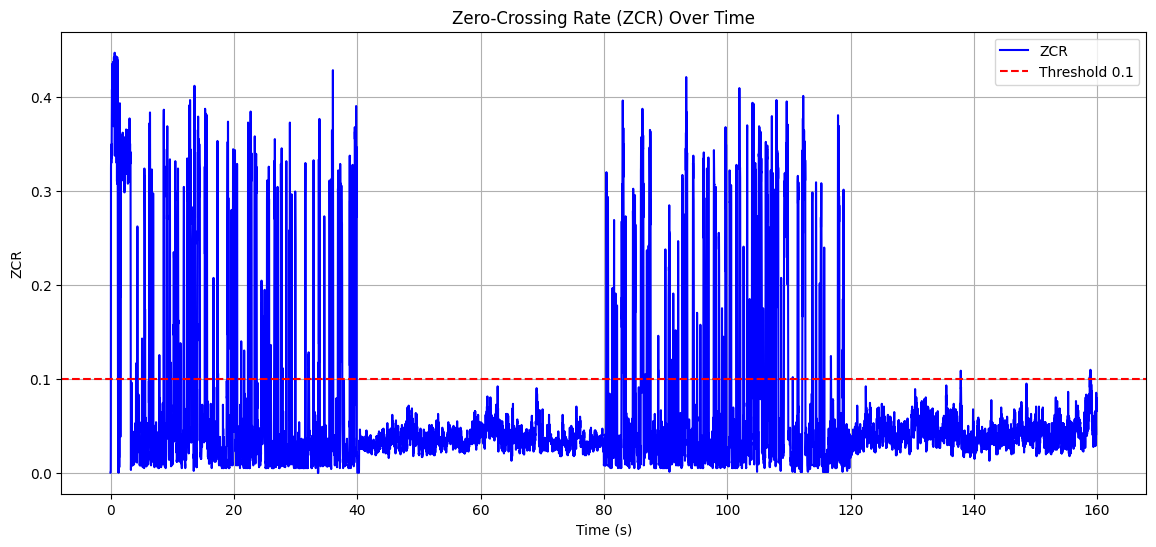

Total duration of the audio: 160.00 seconds
Time duration where ZCR is below 0.1 (noise): 80.64 seconds
Time duration where ZCR is above 0.1 (voice): 79.36 seconds


In [39]:
detect_noise(audio_dir = '/content/drive/MyDrive/SIH/audios/combined_audio.wav')

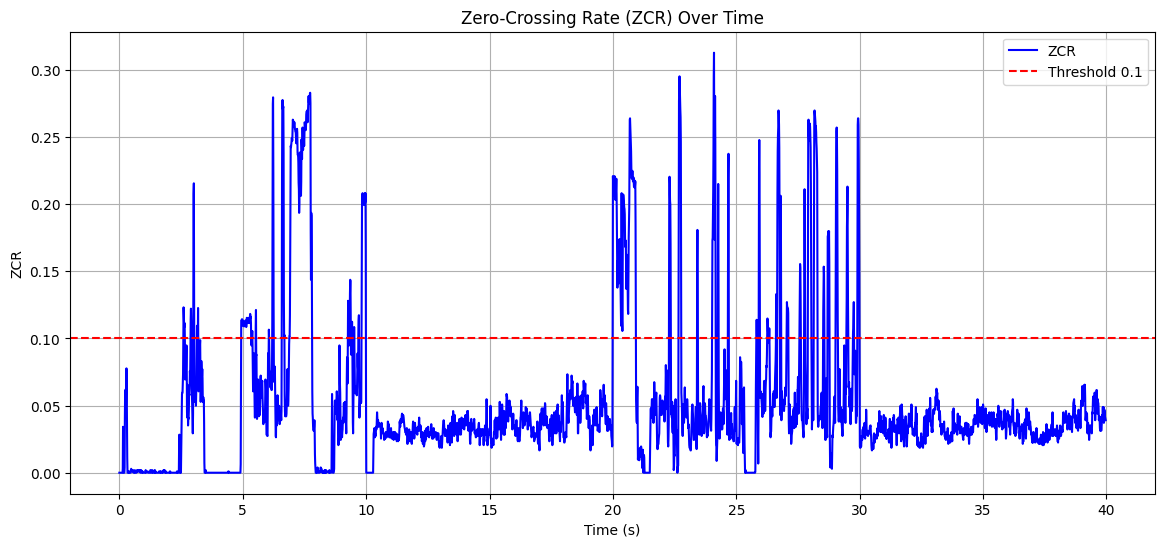

Total duration of the audio: 40.00 seconds
Time duration where ZCR is below 0.1 (noise): 20.91 seconds
Time duration where ZCR is above 0.1 (voice): 19.09 seconds


In [40]:
detect_noise(audio_dir = '/content/drive/MyDrive/SIH/audios/combined_audio1.wav')

# Attendance

## **Using frames**

In [ ]:
# Set up logging
logging.basicConfig(level=logging.INFO)

# Define paths
output_frames_folder = '/content/video_frames/'  # Folder to save extracted frames
output_csv_path = "/content/attendance_results.csv"

# Helper function to check if a file is an image
def is_image_file(file_name):
    return file_name.lower().endswith(('.png', '.jpg', '.jpeg'))

# Create a directory for extracted frames if it doesn't exist
os.makedirs(output_frames_folder, exist_ok=True)

# Extract frames from the video
def extract_frames(video_path, output_folder, frame_interval=30):
    video_capture = cv2.VideoCapture(video_path)
    frame_count = 0
    extracted_frame_count = 0

    while True:
        ret, frame = video_capture.read()
        if not ret:
            break

        if frame_count % frame_interval == 0:
            frame_filename = os.path.join(output_folder, f'frame_{extracted_frame_count}.jpg')
            cv2.imwrite(frame_filename, frame)
            extracted_frame_count += 1

        frame_count += 1

    video_capture.release()
    logging.info(f"Extracted {extracted_frame_count} frames from the video.")

# Extract frames from the video
extract_frames(input_video_path, output_frames_folder)

# Get the list of registered student images
registered_students = [f for f in os.listdir(registered_faces_folder) if is_image_file(f)]

# Initialize a list to store attendance results
attendance = []

# Create a set to track which students have been marked present
students_marked_present = set()

# Process each extracted frame
for frame_name in os.listdir(output_frames_folder):
    frame_path = os.path.join(output_frames_folder, frame_name)

    try:
        # Perform face recognition using DeepFace
        dfs = DeepFace.find(img_path=frame_path, db_path=registered_faces_folder, model_name='GhostFaceNet',enforce_detection=False)

        # Initialize variables to track the best match
        best_match_student = None
        lowest_distance = float('inf')

        # Iterate through the list of DataFrames returned by DeepFace.find()
        for df in dfs:
            if not df.empty:
                for _, row in df.iterrows():
                    registered_name = os.path.splitext(os.path.basename(row['identity']))[0]
                    registered_name =  registered_name.split('_')[0]

                    if registered_name in students_marked_present:
                        continue

                    if row['distance'] < lowest_distance:
                        lowest_distance = row['distance']
                        best_match_student = registered_name

        # Mark the best match as present
        if best_match_student and lowest_distance < 0.5:
            if best_match_student not in students_marked_present:
                students_marked_present.add(best_match_student)
                attendance.append({"Student Name": best_match_student, "Attendance Status": "Present"})

    except Exception as e:
        logging.error(f"Error processing frame {frame_name}: {e}")

# Add remaining registered students who were not marked present
for registered_image_name in registered_students:
    student_name = os.path.splitext(registered_image_name)[0]
    student_name = student_name.split('_')[0]
    if student_name not in students_marked_present:
        attendance.append({"Student Name": student_name, "Attendance Status": "Absent"})

# Convert the attendance list to a DataFrame
df = pd.DataFrame(attendance)

# Save the DataFrame to a CSV file
df.to_csv(output_csv_path, index=False)

logging.info(f"Attendance results saved to {output_csv_path}")


24-09-01 15:34:06 - Searching /content/video_frames/frame_86.jpg in 24 length datastore
24-09-01 15:34:08 - find function duration 1.7035396099090576 seconds
24-09-01 15:34:08 - Searching /content/video_frames/frame_40.jpg in 24 length datastore
24-09-01 15:34:10 - find function duration 1.812406063079834 seconds
24-09-01 15:34:10 - Searching /content/video_frames/frame_11.jpg in 24 length datastore
24-09-01 15:34:11 - find function duration 1.5736773014068604 seconds
24-09-01 15:34:11 - Searching /content/video_frames/frame_8.jpg in 24 length datastore
24-09-01 15:34:13 - find function duration 1.9149489402770996 seconds
24-09-01 15:34:13 - Searching /content/video_frames/frame_15.jpg in 24 length datastore
24-09-01 15:34:15 - find function duration 1.477534532546997 seconds
24-09-01 15:34:15 - Searching /content/video_frames/frame_54.jpg in 24 length datastore
24-09-01 15:34:16 - find function duration 1.6074998378753662 seconds
24-09-01 15:34:16 - Searching /content/video_frames/fra

In [ ]:
# Path to the folder you want to delete
folder_path = "/content/video_frames"  # Replace with your folder path

# Delete the folder and all its contents
shutil.rmtree(folder_path)

print(f"Folder '{folder_path}' and all its contents have been deleted.")

## **Using individual cropped faces**

In [6]:
# Set up logging
logging.basicConfig(level=logging.INFO)

# Load YOLOv8 models for face detection and behavior detection
face_model = YOLO(face_model_path)

# Define video input and output paths
output_csv_path = "/content/attendance_results.csv"

# Helper function to check if a file is an image
def is_image_file(file_name):
    return file_name.lower().endswith(('.png', '.jpg', '.jpeg'))

# Get the list of registered student images
registered_students = [f for f in os.listdir(registered_faces_folder) if is_image_file(f)]

os.makedirs('/content/detected_faces/', exist_ok=True)

# Initialize a list to store attendance results
attendance = []

# Create a set to track which students have been marked present
students_marked_present = set()

# Open the video file
cap = cv2.VideoCapture(input_video_path)

# Variables for processing control
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Total number of frames in the video
frames_to_process = 3  # Number of frames to process in each interval
process_interval = 1 * fps  # Interval in frames (1 second of video)

# Process the video frame by frame
frame_count = 0
processed_frames = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Only process a limited number of frames per interval
    if frame_count % process_interval < frames_to_process:
        processed_frames += 1  # Track how many frames we actually processed

        # Detect faces in the current frame using the YOLO model
        face_results = face_model.predict(frame)

        # Dictionary to track the best match for each student
        best_matches = {}

        # Process each detected face in the frame
        for idx, result in enumerate(face_results[0].boxes.data.tolist()):
            x1, y1, x2, y2, conf, cls = map(int, result[:6])

            # Crop the detected face
            detected_face = frame[y1:y2, x1:x2]
            cropped_face_path = f'/content/detected_faces/detected_face_{frame_count}_{idx}.jpg'
            cv2.imwrite(cropped_face_path, detected_face)

            try:
                # Perform face recognition using DeepFace
                dfs = DeepFace.find(img_path=cropped_face_path, db_path=registered_faces_folder, model_name='GhostFaceNet', enforce_detection=False)

                # Initialize variables to track the best match
                best_match_student = None
                lowest_distance = float('inf')

                # Iterate through the list of DataFrames returned by DeepFace.find()
                for df in dfs:
                    if not df.empty:
                        for _, row in df.iterrows():
                            registered_name = os.path.splitext(os.path.basename(row['identity']))[0]

                            if row['distance'] < lowest_distance:
                                lowest_distance = row['distance']
                                best_match_student = registered_name.split('_')[0]

                # Store the best match if it meets the threshold
                if best_match_student and lowest_distance < 0.5:  # Threshold set to 0.5
                    if best_match_student not in students_marked_present:
                        students_marked_present.add(best_match_student)
                        attendance.append({"Student Name": best_match_student, "Attendance Status": "Present"})
                        # Draw bounding box and name on the image
                        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue bounding box
                        cv2.putText(frame, best_match_student, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)  # Blue text

            except Exception as e:
                logging.error(f"Error processing face {idx} in frame {frame_count}: {e}")

    frame_count += 1

# Add remaining registered students who were not marked present
for registered_image_name in registered_students:
    student_name = os.path.splitext(registered_image_name)[0]
    student_name = student_name.split('_')[0]
    if student_name not in students_marked_present:
        attendance.append({"Student Name": student_name, "Attendance Status": "Absent"})

# Convert the attendance list to a DataFrame
df = pd.DataFrame(attendance)

# Save the DataFrame to a CSV file
df.to_csv(output_csv_path, index=False)

logging.info(f"Attendance results saved to {output_csv_path}")

WARNING ⚠️ /content/drive/MyDrive/SIH/models/face_detection_model.pt appears to require 'dill', which is not in ultralytics requirements.
AutoInstall will run now for 'dill' but this feature will be removed in the future.
Recommend fixes are to train a new model using the latest 'ultralytics' package or to run a command with an official YOLOv8 model, i.e. 'yolo predict model=yolov8n.pt'
requirements: Ultralytics requirement ['dill'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.1 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 2.4s, installed 1 package: ['dill']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


WARNING ⚠️ NMS time limit 0.550s exceeded
0: 384x640 5 FACEs, 107.3ms
Speed: 16.1ms preprocess, 107.3ms inference, 1307.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:31:43 - Found 24 newly added image(s), 0 removed image(s), 0 replaced image(s).


Finding representations:   0%|          | 0/24 [00:00<?, ?it/s]

24-09-03 18:31:48 - Pre-trained weights is downloaded from https://github.com/HamadYA/GhostFaceNets/releases/download/v1.2/GhostFaceNet_W1.3_S1_ArcFace.h5 to /root/.deepface/weights/ghostfacenet_v1.h5


Downloading...
From: https://github.com/HamadYA/GhostFaceNets/releases/download/v1.2/GhostFaceNet_W1.3_S1_ArcFace.h5
To: /root/.deepface/weights/ghostfacenet_v1.h5

  0%|          | 0.00/17.3M [00:00<?, ?B/s]
100%|██████████| 17.3M/17.3M [00:00<00:00, 115MB/s] 


24-09-03 18:31:49 - Pre-trained weights is just downloaded to /root/.deepface/weights/ghostfacenet_v1.h5


Finding representations: 100%|██████████| 24/24 [00:30<00:00,  1.29s/it]


24-09-03 18:32:14 - There are now 24 representations in ds_model_ghostfacenet_detector_opencv_aligned_normalization_base_expand_0.pkl
24-09-03 18:32:14 - Searching /content/detected_faces/detected_face_0_0.jpg in 24 length datastore
24-09-03 18:32:14 - find function duration 31.105045318603516 seconds
24-09-03 18:32:14 - Searching /content/detected_faces/detected_face_0_1.jpg in 24 length datastore
24-09-03 18:32:14 - find function duration 0.18954133987426758 seconds
24-09-03 18:32:14 - Searching /content/detected_faces/detected_face_0_2.jpg in 24 length datastore
24-09-03 18:32:14 - find function duration 0.19441795349121094 seconds
24-09-03 18:32:14 - Searching /content/detected_faces/detected_face_0_3.jpg in 24 length datastore
24-09-03 18:32:14 - find function duration 0.19122743606567383 seconds
24-09-03 18:32:14 - Searching /content/detected_faces/detected_face_0_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:15 - find function duration 0.18855857849121094 seconds
24-09-03 18:32:15 - Searching /content/detected_faces/detected_face_1_0.jpg in 24 length datastore
24-09-03 18:32:15 - find function duration 0.20224523544311523 seconds
24-09-03 18:32:15 - Searching /content/detected_faces/detected_face_1_1.jpg in 24 length datastore
24-09-03 18:32:15 - find function duration 0.1979203224182129 seconds
24-09-03 18:32:15 - Searching /content/detected_faces/detected_face_1_2.jpg in 24 length datastore
24-09-03 18:32:15 - find function duration 0.19575190544128418 seconds
24-09-03 18:32:15 - Searching /content/detected_faces/detected_face_1_3.jpg in 24 length datastore



0: 384x640 5 FACEs, 9.5ms
Speed: 2.7ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:15 - find function duration 0.21004056930541992 seconds
24-09-03 18:32:15 - Searching /content/detected_faces/detected_face_1_4.jpg in 24 length datastore
24-09-03 18:32:16 - find function duration 0.17887425422668457 seconds
24-09-03 18:32:16 - Searching /content/detected_faces/detected_face_2_0.jpg in 24 length datastore
24-09-03 18:32:16 - find function duration 0.2011098861694336 seconds
24-09-03 18:32:16 - Searching /content/detected_faces/detected_face_2_1.jpg in 24 length datastore
24-09-03 18:32:16 - find function duration 0.19137930870056152 seconds
24-09-03 18:32:16 - Searching /content/detected_faces/detected_face_2_2.jpg in 24 length datastore
24-09-03 18:32:16 - find function duration 0.18360519409179688 seconds
24-09-03 18:32:16 - Searching /content/detected_faces/detected_face_2_3.jpg in 24 length datastore
24-09-03 18:32:16 - find function duration 0.19595932960510254 seconds
24-09-03 18:32:16 - Searching /content/detected_faces/detected_face_2_4.jpg in 2


0: 384x640 5 FACEs, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:17 - Searching /content/detected_faces/detected_face_30_0.jpg in 24 length datastore
24-09-03 18:32:17 - find function duration 0.20302510261535645 seconds
24-09-03 18:32:17 - Searching /content/detected_faces/detected_face_30_1.jpg in 24 length datastore
24-09-03 18:32:17 - find function duration 0.1924130916595459 seconds
24-09-03 18:32:17 - Searching /content/detected_faces/detected_face_30_2.jpg in 24 length datastore
24-09-03 18:32:17 - find function duration 0.19289803504943848 seconds
24-09-03 18:32:17 - Searching /content/detected_faces/detected_face_30_3.jpg in 24 length datastore
24-09-03 18:32:17 - find function duration 0.19433236122131348 seconds
24-09-03 18:32:17 - Searching /content/detected_faces/detected_face_30_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:18 - find function duration 0.18810629844665527 seconds
24-09-03 18:32:18 - Searching /content/detected_faces/detected_face_31_0.jpg in 24 length datastore
24-09-03 18:32:18 - find function duration 0.20138812065124512 seconds
24-09-03 18:32:18 - Searching /content/detected_faces/detected_face_31_1.jpg in 24 length datastore
24-09-03 18:32:18 - find function duration 0.19218707084655762 seconds
24-09-03 18:32:18 - Searching /content/detected_faces/detected_face_31_2.jpg in 24 length datastore
24-09-03 18:32:18 - find function duration 0.18639588356018066 seconds
24-09-03 18:32:18 - Searching /content/detected_faces/detected_face_31_3.jpg in 24 length datastore



0: 384x640 5 FACEs, 7.6ms
Speed: 3.4ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:18 - find function duration 0.20841360092163086 seconds
24-09-03 18:32:18 - Searching /content/detected_faces/detected_face_31_4.jpg in 24 length datastore
24-09-03 18:32:19 - find function duration 0.17689132690429688 seconds
24-09-03 18:32:19 - Searching /content/detected_faces/detected_face_32_0.jpg in 24 length datastore
24-09-03 18:32:19 - find function duration 0.19885635375976562 seconds
24-09-03 18:32:19 - Searching /content/detected_faces/detected_face_32_1.jpg in 24 length datastore
24-09-03 18:32:19 - find function duration 0.19850420951843262 seconds
24-09-03 18:32:19 - Searching /content/detected_faces/detected_face_32_2.jpg in 24 length datastore
24-09-03 18:32:19 - find function duration 0.18856477737426758 seconds
24-09-03 18:32:19 - Searching /content/detected_faces/detected_face_32_3.jpg in 24 length datastore
24-09-03 18:32:19 - find function duration 0.19191336631774902 seconds
24-09-03 18:32:19 - Searching /content/detected_faces/detected_face_32_4.j


0: 384x640 5 FACEs, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:20 - Searching /content/detected_faces/detected_face_60_0.jpg in 24 length datastore
24-09-03 18:32:20 - find function duration 0.20163607597351074 seconds
24-09-03 18:32:20 - Searching /content/detected_faces/detected_face_60_1.jpg in 24 length datastore
24-09-03 18:32:20 - find function duration 0.2158188819885254 seconds
24-09-03 18:32:20 - Searching /content/detected_faces/detected_face_60_2.jpg in 24 length datastore
24-09-03 18:32:20 - find function duration 0.24279522895812988 seconds
24-09-03 18:32:20 - Searching /content/detected_faces/detected_face_60_3.jpg in 24 length datastore
24-09-03 18:32:21 - find function duration 0.19217157363891602 seconds
24-09-03 18:32:21 - Searching /content/detected_faces/detected_face_60_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:21 - find function duration 0.18829584121704102 seconds
24-09-03 18:32:21 - Searching /content/detected_faces/detected_face_61_0.jpg in 24 length datastore
24-09-03 18:32:21 - find function duration 0.21434450149536133 seconds
24-09-03 18:32:21 - Searching /content/detected_faces/detected_face_61_1.jpg in 24 length datastore
24-09-03 18:32:21 - find function duration 0.20299887657165527 seconds
24-09-03 18:32:21 - Searching /content/detected_faces/detected_face_61_2.jpg in 24 length datastore
24-09-03 18:32:21 - find function duration 0.19983744621276855 seconds
24-09-03 18:32:21 - Searching /content/detected_faces/detected_face_61_3.jpg in 24 length datastore
24-09-03 18:32:22 - find function duration 0.18323397636413574 seconds
24-09-03 18:32:22 - Searching /content/detected_faces/detected_face_61_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:22 - find function duration 0.24082708358764648 seconds
24-09-03 18:32:22 - Searching /content/detected_faces/detected_face_62_0.jpg in 24 length datastore
24-09-03 18:32:23 - find function duration 1.1597671508789062 seconds
24-09-03 18:32:23 - Searching /content/detected_faces/detected_face_62_1.jpg in 24 length datastore
24-09-03 18:32:23 - find function duration 0.3517916202545166 seconds
24-09-03 18:32:23 - Searching /content/detected_faces/detected_face_62_2.jpg in 24 length datastore
24-09-03 18:32:24 - find function duration 0.25809574127197266 seconds
24-09-03 18:32:24 - Searching /content/detected_faces/detected_face_62_3.jpg in 24 length datastore
24-09-03 18:32:24 - find function duration 0.25456976890563965 seconds
24-09-03 18:32:24 - Searching /content/detected_faces/detected_face_62_4.jpg in 24 length datastore


24-09-03 18:32:24 - find function duration 0.24340462684631348 seconds


0: 384x640 5 FACEs, 11.3ms
Speed: 2.2ms preprocess, 11.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:24 - Searching /content/detected_faces/detected_face_90_0.jpg in 24 length datastore
24-09-03 18:32:25 - find function duration 0.30894899368286133 seconds
24-09-03 18:32:25 - Searching /content/detected_faces/detected_face_90_1.jpg in 24 length datastore
24-09-03 18:32:25 - find function duration 0.2773563861846924 seconds
24-09-03 18:32:25 - Searching /content/detected_faces/detected_face_90_2.jpg in 24 length datastore
24-09-03 18:32:25 - find function duration 0.2684059143066406 seconds
24-09-03 18:32:25 - Searching /content/detected_faces/detected_face_90_3.jpg in 24 length datastore
24-09-03 18:32:26 - find function duration 0.291363000869751 seconds
24-09-03 18:32:26 - Searching /content/detected_faces/detected_face_90_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 8.6ms
Speed: 2.0ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:26 - find function duration 0.2424945831298828 seconds
24-09-03 18:32:26 - Searching /content/detected_faces/detected_face_91_0.jpg in 24 length datastore
24-09-03 18:32:26 - find function duration 0.2009594440460205 seconds
24-09-03 18:32:26 - Searching /content/detected_faces/detected_face_91_1.jpg in 24 length datastore
24-09-03 18:32:26 - find function duration 0.20582342147827148 seconds
24-09-03 18:32:26 - Searching /content/detected_faces/detected_face_91_2.jpg in 24 length datastore
24-09-03 18:32:26 - find function duration 0.18052053451538086 seconds
24-09-03 18:32:26 - Searching /content/detected_faces/detected_face_91_3.jpg in 24 length datastore


24-09-03 18:32:27 - find function duration 0.19158530235290527 seconds
24-09-03 18:32:27 - Searching /content/detected_faces/detected_face_91_4.jpg in 24 length datastore
24-09-03 18:32:27 - find function duration 0.19184374809265137 seconds


0: 384x640 5 FACEs, 7.1ms
Speed: 3.3ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:27 - Searching /content/detected_faces/detected_face_92_0.jpg in 24 length datastore
24-09-03 18:32:27 - find function duration 0.20706605911254883 seconds
24-09-03 18:32:27 - Searching /content/detected_faces/detected_face_92_1.jpg in 24 length datastore
24-09-03 18:32:27 - find function duration 0.19237828254699707 seconds
24-09-03 18:32:27 - Searching /content/detected_faces/detected_face_92_2.jpg in 24 length datastore
24-09-03 18:32:27 - find function duration 0.19112896919250488 seconds
24-09-03 18:32:27 - Searching /content/detected_faces/detected_face_92_3.jpg in 24 length datastore
24-09-03 18:32:28 - find function duration 0.18944811820983887 seconds
24-09-03 18:32:28 - Searching /content/detected_faces/detected_face_92_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 7.4ms
Speed: 3.5ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:28 - find function duration 0.19984221458435059 seconds
24-09-03 18:32:28 - Searching /content/detected_faces/detected_face_120_0.jpg in 24 length datastore
24-09-03 18:32:28 - find function duration 0.20235538482666016 seconds
24-09-03 18:32:28 - Searching /content/detected_faces/detected_face_120_1.jpg in 24 length datastore
24-09-03 18:32:28 - find function duration 0.19292855262756348 seconds
24-09-03 18:32:28 - Searching /content/detected_faces/detected_face_120_2.jpg in 24 length datastore
24-09-03 18:32:29 - find function duration 0.18523693084716797 seconds
24-09-03 18:32:29 - Searching /content/detected_faces/detected_face_120_3.jpg in 24 length datastore
24-09-03 18:32:29 - find function duration 0.19225454330444336 seconds
24-09-03 18:32:29 - Searching /content/detected_faces/detected_face_120_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:29 - find function duration 0.19173431396484375 seconds
24-09-03 18:32:29 - Searching /content/detected_faces/detected_face_121_0.jpg in 24 length datastore
24-09-03 18:32:29 - find function duration 0.20515751838684082 seconds
24-09-03 18:32:29 - Searching /content/detected_faces/detected_face_121_1.jpg in 24 length datastore
24-09-03 18:32:29 - find function duration 0.21532368659973145 seconds
24-09-03 18:32:29 - Searching /content/detected_faces/detected_face_121_2.jpg in 24 length datastore
24-09-03 18:32:30 - find function duration 0.18349313735961914 seconds
24-09-03 18:32:30 - Searching /content/detected_faces/detected_face_121_3.jpg in 24 length datastore


24-09-03 18:32:30 - find function duration 0.1983346939086914 seconds
24-09-03 18:32:30 - Searching /content/detected_faces/detected_face_121_4.jpg in 24 length datastore
24-09-03 18:32:30 - find function duration 0.193375825881958 seconds


0: 384x640 5 FACEs, 8.4ms
Speed: 4.0ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:30 - Searching /content/detected_faces/detected_face_122_0.jpg in 24 length datastore
24-09-03 18:32:30 - find function duration 0.19312715530395508 seconds
24-09-03 18:32:30 - Searching /content/detected_faces/detected_face_122_1.jpg in 24 length datastore
24-09-03 18:32:30 - find function duration 0.2246837615966797 seconds
24-09-03 18:32:30 - Searching /content/detected_faces/detected_face_122_2.jpg in 24 length datastore
24-09-03 18:32:31 - find function duration 0.1961522102355957 seconds
24-09-03 18:32:31 - Searching /content/detected_faces/detected_face_122_3.jpg in 24 length datastore
24-09-03 18:32:31 - find function duration 0.18992161750793457 seconds
24-09-03 18:32:31 - Searching /content/detected_faces/detected_face_122_4.jpg in 24 length datastore
24-09-03 18:32:31 - find function duration 0.19276857376098633 seconds



0: 384x640 5 FACEs, 7.2ms
Speed: 3.4ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:31 - Searching /content/detected_faces/detected_face_150_0.jpg in 24 length datastore
24-09-03 18:32:31 - find function duration 0.18964123725891113 seconds
24-09-03 18:32:31 - Searching /content/detected_faces/detected_face_150_1.jpg in 24 length datastore
24-09-03 18:32:32 - find function duration 0.1983165740966797 seconds
24-09-03 18:32:32 - Searching /content/detected_faces/detected_face_150_2.jpg in 24 length datastore
24-09-03 18:32:32 - find function duration 0.21456456184387207 seconds
24-09-03 18:32:32 - Searching /content/detected_faces/detected_face_150_3.jpg in 24 length datastore


24-09-03 18:32:32 - find function duration 0.2225170135498047 seconds
24-09-03 18:32:32 - Searching /content/detected_faces/detected_face_150_4.jpg in 24 length datastore
24-09-03 18:32:32 - find function duration 0.18776392936706543 seconds


0: 384x640 5 FACEs, 11.0ms
Speed: 2.2ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:32 - Searching /content/detected_faces/detected_face_151_0.jpg in 24 length datastore
24-09-03 18:32:32 - find function duration 0.18746018409729004 seconds
24-09-03 18:32:32 - Searching /content/detected_faces/detected_face_151_1.jpg in 24 length datastore
24-09-03 18:32:33 - find function duration 0.19667911529541016 seconds
24-09-03 18:32:33 - Searching /content/detected_faces/detected_face_151_2.jpg in 24 length datastore
24-09-03 18:32:33 - find function duration 0.19079113006591797 seconds
24-09-03 18:32:33 - Searching /content/detected_faces/detected_face_151_3.jpg in 24 length datastore


24-09-03 18:32:33 - find function duration 0.20573854446411133 seconds
24-09-03 18:32:33 - Searching /content/detected_faces/detected_face_151_4.jpg in 24 length datastore
24-09-03 18:32:33 - find function duration 0.1853804588317871 seconds


0: 384x640 5 FACEs, 12.3ms
Speed: 2.6ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:33 - Searching /content/detected_faces/detected_face_152_0.jpg in 24 length datastore
24-09-03 18:32:33 - find function duration 0.1849503517150879 seconds
24-09-03 18:32:33 - Searching /content/detected_faces/detected_face_152_1.jpg in 24 length datastore
24-09-03 18:32:34 - find function duration 0.21355390548706055 seconds
24-09-03 18:32:34 - Searching /content/detected_faces/detected_face_152_2.jpg in 24 length datastore
24-09-03 18:32:34 - find function duration 0.1957862377166748 seconds
24-09-03 18:32:34 - Searching /content/detected_faces/detected_face_152_3.jpg in 24 length datastore
24-09-03 18:32:34 - find function duration 0.21869945526123047 seconds
24-09-03 18:32:34 - Searching /content/detected_faces/detected_face_152_4.jpg in 24 length datastore
24-09-03 18:32:34 - find function duration 0.1855471134185791 seconds



0: 384x640 5 FACEs, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:34 - Searching /content/detected_faces/detected_face_180_0.jpg in 24 length datastore
24-09-03 18:32:35 - find function duration 0.19356155395507812 seconds
24-09-03 18:32:35 - Searching /content/detected_faces/detected_face_180_1.jpg in 24 length datastore
24-09-03 18:32:35 - find function duration 0.19282841682434082 seconds
24-09-03 18:32:35 - Searching /content/detected_faces/detected_face_180_2.jpg in 24 length datastore
24-09-03 18:32:35 - find function duration 0.2026994228363037 seconds
24-09-03 18:32:35 - Searching /content/detected_faces/detected_face_180_3.jpg in 24 length datastore
24-09-03 18:32:35 - find function duration 0.18697810173034668 seconds
24-09-03 18:32:35 - Searching /content/detected_faces/detected_face_180_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 8.8ms
Speed: 3.3ms preprocess, 8.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:35 - find function duration 0.18726825714111328 seconds
24-09-03 18:32:35 - Searching /content/detected_faces/detected_face_181_0.jpg in 24 length datastore
24-09-03 18:32:36 - find function duration 0.18663740158081055 seconds
24-09-03 18:32:36 - Searching /content/detected_faces/detected_face_181_1.jpg in 24 length datastore
24-09-03 18:32:36 - find function duration 0.19074463844299316 seconds
24-09-03 18:32:36 - Searching /content/detected_faces/detected_face_181_2.jpg in 24 length datastore
24-09-03 18:32:36 - find function duration 0.28435444831848145 seconds
24-09-03 18:32:36 - Searching /content/detected_faces/detected_face_181_3.jpg in 24 length datastore
24-09-03 18:32:36 - find function duration 0.2561476230621338 seconds
24-09-03 18:32:36 - Searching /content/detected_faces/detected_face_181_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 13.0ms
Speed: 2.0ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:36 - find function duration 0.2457575798034668 seconds
24-09-03 18:32:37 - Searching /content/detected_faces/detected_face_182_0.jpg in 24 length datastore
24-09-03 18:32:37 - find function duration 0.26241207122802734 seconds
24-09-03 18:32:37 - Searching /content/detected_faces/detected_face_182_1.jpg in 24 length datastore
24-09-03 18:32:37 - find function duration 0.28891658782958984 seconds
24-09-03 18:32:37 - Searching /content/detected_faces/detected_face_182_2.jpg in 24 length datastore
24-09-03 18:32:37 - find function duration 0.2525045871734619 seconds
24-09-03 18:32:37 - Searching /content/detected_faces/detected_face_182_3.jpg in 24 length datastore
24-09-03 18:32:38 - find function duration 0.25052642822265625 seconds
24-09-03 18:32:38 - Searching /content/detected_faces/detected_face_182_4.jpg in 24 length datastore
24-09-03 18:32:38 - find function duration 0.24056649208068848 seconds



0: 384x640 4 FACEs, 9.7ms
Speed: 4.2ms preprocess, 9.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:38 - Searching /content/detected_faces/detected_face_210_0.jpg in 24 length datastore
24-09-03 18:32:38 - find function duration 0.27800536155700684 seconds
24-09-03 18:32:38 - Searching /content/detected_faces/detected_face_210_1.jpg in 24 length datastore
24-09-03 18:32:39 - find function duration 0.2771012783050537 seconds
24-09-03 18:32:39 - Searching /content/detected_faces/detected_face_210_2.jpg in 24 length datastore
24-09-03 18:32:39 - find function duration 0.3090074062347412 seconds
24-09-03 18:32:39 - Searching /content/detected_faces/detected_face_210_3.jpg in 24 length datastore



0: 384x640 4 FACEs, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:39 - find function duration 0.2844371795654297 seconds
24-09-03 18:32:39 - Searching /content/detected_faces/detected_face_211_0.jpg in 24 length datastore
24-09-03 18:32:39 - find function duration 0.19266104698181152 seconds
24-09-03 18:32:39 - Searching /content/detected_faces/detected_face_211_1.jpg in 24 length datastore
24-09-03 18:32:40 - find function duration 0.19743680953979492 seconds
24-09-03 18:32:40 - Searching /content/detected_faces/detected_face_211_2.jpg in 24 length datastore
24-09-03 18:32:40 - find function duration 0.19637584686279297 seconds
24-09-03 18:32:40 - Searching /content/detected_faces/detected_face_211_3.jpg in 24 length datastore



0: 384x640 4 FACEs, 9.4ms
Speed: 2.1ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:40 - find function duration 0.19428396224975586 seconds
24-09-03 18:32:40 - Searching /content/detected_faces/detected_face_212_0.jpg in 24 length datastore
24-09-03 18:32:40 - find function duration 0.19919061660766602 seconds
24-09-03 18:32:40 - Searching /content/detected_faces/detected_face_212_1.jpg in 24 length datastore
24-09-03 18:32:40 - find function duration 0.19367647171020508 seconds
24-09-03 18:32:40 - Searching /content/detected_faces/detected_face_212_2.jpg in 24 length datastore
24-09-03 18:32:41 - find function duration 0.20030689239501953 seconds
24-09-03 18:32:41 - Searching /content/detected_faces/detected_face_212_3.jpg in 24 length datastore
24-09-03 18:32:41 - find function duration 0.185499906539917 seconds



0: 384x640 4 FACEs, 8.6ms
Speed: 2.5ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:41 - Searching /content/detected_faces/detected_face_240_0.jpg in 24 length datastore
24-09-03 18:32:41 - find function duration 0.20052790641784668 seconds
24-09-03 18:32:41 - Searching /content/detected_faces/detected_face_240_1.jpg in 24 length datastore
24-09-03 18:32:41 - find function duration 0.19590020179748535 seconds
24-09-03 18:32:41 - Searching /content/detected_faces/detected_face_240_2.jpg in 24 length datastore
24-09-03 18:32:42 - find function duration 0.19522595405578613 seconds
24-09-03 18:32:42 - Searching /content/detected_faces/detected_face_240_3.jpg in 24 length datastore



0: 384x640 4 FACEs, 9.1ms
Speed: 2.1ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:42 - find function duration 0.1940171718597412 seconds
24-09-03 18:32:42 - Searching /content/detected_faces/detected_face_241_0.jpg in 24 length datastore
24-09-03 18:32:42 - find function duration 0.1967146396636963 seconds
24-09-03 18:32:42 - Searching /content/detected_faces/detected_face_241_1.jpg in 24 length datastore
24-09-03 18:32:42 - find function duration 0.2034139633178711 seconds
24-09-03 18:32:42 - Searching /content/detected_faces/detected_face_241_2.jpg in 24 length datastore
24-09-03 18:32:42 - find function duration 0.19384765625 seconds
24-09-03 18:32:42 - Searching /content/detected_faces/detected_face_241_3.jpg in 24 length datastore



0: 384x640 4 FACEs, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:43 - find function duration 0.18800115585327148 seconds
24-09-03 18:32:43 - Searching /content/detected_faces/detected_face_242_0.jpg in 24 length datastore
24-09-03 18:32:43 - find function duration 0.19124889373779297 seconds
24-09-03 18:32:43 - Searching /content/detected_faces/detected_face_242_1.jpg in 24 length datastore
24-09-03 18:32:43 - find function duration 0.1997826099395752 seconds
24-09-03 18:32:43 - Searching /content/detected_faces/detected_face_242_2.jpg in 24 length datastore
24-09-03 18:32:43 - find function duration 0.20967769622802734 seconds
24-09-03 18:32:43 - Searching /content/detected_faces/detected_face_242_3.jpg in 24 length datastore
24-09-03 18:32:43 - find function duration 0.18346047401428223 seconds



0: 384x640 4 FACEs, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:44 - Searching /content/detected_faces/detected_face_270_0.jpg in 24 length datastore
24-09-03 18:32:44 - find function duration 0.20357394218444824 seconds
24-09-03 18:32:44 - Searching /content/detected_faces/detected_face_270_1.jpg in 24 length datastore
24-09-03 18:32:44 - find function duration 0.20927071571350098 seconds
24-09-03 18:32:44 - Searching /content/detected_faces/detected_face_270_2.jpg in 24 length datastore
24-09-03 18:32:44 - find function duration 0.19682955741882324 seconds
24-09-03 18:32:44 - Searching /content/detected_faces/detected_face_270_3.jpg in 24 length datastore
24-09-03 18:32:44 - find function duration 0.20479178428649902 seconds



0: 384x640 4 FACEs, 9.0ms
Speed: 2.2ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:44 - Searching /content/detected_faces/detected_face_271_0.jpg in 24 length datastore
24-09-03 18:32:45 - find function duration 0.19352054595947266 seconds
24-09-03 18:32:45 - Searching /content/detected_faces/detected_face_271_1.jpg in 24 length datastore
24-09-03 18:32:45 - find function duration 0.1947803497314453 seconds
24-09-03 18:32:45 - Searching /content/detected_faces/detected_face_271_2.jpg in 24 length datastore


24-09-03 18:32:45 - find function duration 0.20380926132202148 seconds
24-09-03 18:32:45 - Searching /content/detected_faces/detected_face_271_3.jpg in 24 length datastore
24-09-03 18:32:45 - find function duration 0.1879286766052246 seconds


0: 384x640 4 FACEs, 8.9ms
Speed: 2.0ms preprocess, 8.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:45 - Searching /content/detected_faces/detected_face_272_0.jpg in 24 length datastore
24-09-03 18:32:45 - find function duration 0.21114182472229004 seconds
24-09-03 18:32:45 - Searching /content/detected_faces/detected_face_272_1.jpg in 24 length datastore
24-09-03 18:32:46 - find function duration 0.19602680206298828 seconds
24-09-03 18:32:46 - Searching /content/detected_faces/detected_face_272_2.jpg in 24 length datastore
24-09-03 18:32:46 - find function duration 0.19557476043701172 seconds
24-09-03 18:32:46 - Searching /content/detected_faces/detected_face_272_3.jpg in 24 length datastore



0: 384x640 4 FACEs, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:46 - find function duration 0.194807767868042 seconds
24-09-03 18:32:46 - Searching /content/detected_faces/detected_face_300_0.jpg in 24 length datastore
24-09-03 18:32:46 - find function duration 0.20691895484924316 seconds
24-09-03 18:32:46 - Searching /content/detected_faces/detected_face_300_1.jpg in 24 length datastore
24-09-03 18:32:47 - find function duration 0.2028186321258545 seconds
24-09-03 18:32:47 - Searching /content/detected_faces/detected_face_300_2.jpg in 24 length datastore
24-09-03 18:32:47 - find function duration 0.2020273208618164 seconds


24-09-03 18:32:47 - Searching /content/detected_faces/detected_face_300_3.jpg in 24 length datastore
24-09-03 18:32:47 - find function duration 0.19670844078063965 seconds


0: 384x640 4 FACEs, 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:47 - Searching /content/detected_faces/detected_face_301_0.jpg in 24 length datastore
24-09-03 18:32:47 - find function duration 0.19289255142211914 seconds
24-09-03 18:32:47 - Searching /content/detected_faces/detected_face_301_1.jpg in 24 length datastore
24-09-03 18:32:47 - find function duration 0.20831847190856934 seconds
24-09-03 18:32:47 - Searching /content/detected_faces/detected_face_301_2.jpg in 24 length datastore
24-09-03 18:32:48 - find function duration 0.19296789169311523 seconds
24-09-03 18:32:48 - Searching /content/detected_faces/detected_face_301_3.jpg in 24 length datastore



0: 384x640 4 FACEs, 7.0ms
Speed: 1.7ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:48 - find function duration 0.19250011444091797 seconds
24-09-03 18:32:48 - Searching /content/detected_faces/detected_face_302_0.jpg in 24 length datastore
24-09-03 18:32:48 - find function duration 0.2192680835723877 seconds
24-09-03 18:32:48 - Searching /content/detected_faces/detected_face_302_1.jpg in 24 length datastore
24-09-03 18:32:48 - find function duration 0.18976926803588867 seconds
24-09-03 18:32:48 - Searching /content/detected_faces/detected_face_302_2.jpg in 24 length datastore
24-09-03 18:32:48 - find function duration 0.2059633731842041 seconds
24-09-03 18:32:48 - Searching /content/detected_faces/detected_face_302_3.jpg in 24 length datastore
24-09-03 18:32:49 - find function duration 0.17695331573486328 seconds



0: 384x640 4 FACEs, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:49 - Searching /content/detected_faces/detected_face_330_0.jpg in 24 length datastore
24-09-03 18:32:49 - find function duration 0.2037510871887207 seconds
24-09-03 18:32:49 - Searching /content/detected_faces/detected_face_330_1.jpg in 24 length datastore
24-09-03 18:32:49 - find function duration 0.19469070434570312 seconds
24-09-03 18:32:49 - Searching /content/detected_faces/detected_face_330_2.jpg in 24 length datastore
24-09-03 18:32:49 - find function duration 0.24337148666381836 seconds
24-09-03 18:32:49 - Searching /content/detected_faces/detected_face_330_3.jpg in 24 length datastore



0: 384x640 4 FACEs, 12.7ms
Speed: 2.1ms preprocess, 12.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:50 - find function duration 0.2631397247314453 seconds
24-09-03 18:32:50 - Searching /content/detected_faces/detected_face_331_0.jpg in 24 length datastore
24-09-03 18:32:50 - find function duration 0.26890039443969727 seconds
24-09-03 18:32:50 - Searching /content/detected_faces/detected_face_331_1.jpg in 24 length datastore
24-09-03 18:32:50 - find function duration 0.2407681941986084 seconds
24-09-03 18:32:50 - Searching /content/detected_faces/detected_face_331_2.jpg in 24 length datastore
24-09-03 18:32:50 - find function duration 0.30263352394104004 seconds
24-09-03 18:32:50 - Searching /content/detected_faces/detected_face_331_3.jpg in 24 length datastore



0: 384x640 4 FACEs, 11.1ms
Speed: 2.0ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:51 - find function duration 0.25228166580200195 seconds
24-09-03 18:32:51 - Searching /content/detected_faces/detected_face_332_0.jpg in 24 length datastore
24-09-03 18:32:51 - find function duration 0.26285576820373535 seconds
24-09-03 18:32:51 - Searching /content/detected_faces/detected_face_332_1.jpg in 24 length datastore
24-09-03 18:32:51 - find function duration 0.24656271934509277 seconds
24-09-03 18:32:51 - Searching /content/detected_faces/detected_face_332_2.jpg in 24 length datastore
24-09-03 18:32:52 - find function duration 0.26721715927124023 seconds
24-09-03 18:32:52 - Searching /content/detected_faces/detected_face_332_3.jpg in 24 length datastore
24-09-03 18:32:52 - find function duration 0.27403879165649414 seconds



0: 384x640 4 FACEs, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:52 - Searching /content/detected_faces/detected_face_360_0.jpg in 24 length datastore
24-09-03 18:32:52 - find function duration 0.2739701271057129 seconds
24-09-03 18:32:52 - Searching /content/detected_faces/detected_face_360_1.jpg in 24 length datastore
24-09-03 18:32:53 - find function duration 0.29006361961364746 seconds
24-09-03 18:32:53 - Searching /content/detected_faces/detected_face_360_2.jpg in 24 length datastore
24-09-03 18:32:53 - find function duration 0.2869701385498047 seconds
24-09-03 18:32:53 - Searching /content/detected_faces/detected_face_360_3.jpg in 24 length datastore
24-09-03 18:32:53 - find function duration 0.20492315292358398 seconds



0: 384x640 5 FACEs, 10.1ms
Speed: 2.2ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:53 - Searching /content/detected_faces/detected_face_361_0.jpg in 24 length datastore
24-09-03 18:32:53 - find function duration 0.19929790496826172 seconds
24-09-03 18:32:53 - Searching /content/detected_faces/detected_face_361_1.jpg in 24 length datastore
24-09-03 18:32:54 - find function duration 0.2043764591217041 seconds
24-09-03 18:32:54 - Searching /content/detected_faces/detected_face_361_2.jpg in 24 length datastore
24-09-03 18:32:54 - find function duration 0.18649506568908691 seconds
24-09-03 18:32:54 - Searching /content/detected_faces/detected_face_361_3.jpg in 24 length datastore


24-09-03 18:32:54 - find function duration 0.1952805519104004 seconds
24-09-03 18:32:54 - Searching /content/detected_faces/detected_face_361_4.jpg in 24 length datastore
24-09-03 18:32:54 - find function duration 0.1846911907196045 seconds


0: 384x640 5 FACEs, 10.3ms
Speed: 2.3ms preprocess, 10.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:54 - Searching /content/detected_faces/detected_face_362_0.jpg in 24 length datastore
24-09-03 18:32:54 - find function duration 0.21627402305603027 seconds
24-09-03 18:32:54 - Searching /content/detected_faces/detected_face_362_1.jpg in 24 length datastore
24-09-03 18:32:55 - find function duration 0.19766855239868164 seconds
24-09-03 18:32:55 - Searching /content/detected_faces/detected_face_362_2.jpg in 24 length datastore
24-09-03 18:32:55 - find function duration 0.1861400604248047 seconds
24-09-03 18:32:55 - Searching /content/detected_faces/detected_face_362_3.jpg in 24 length datastore
24-09-03 18:32:55 - find function duration 0.19396209716796875 seconds
24-09-03 18:32:55 - Searching /content/detected_faces/detected_face_362_4.jpg in 24 length datastore
24-09-03 18:32:55 - find function duration 0.1797199249267578 seconds



0: 384x640 5 FACEs, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:55 - Searching /content/detected_faces/detected_face_390_0.jpg in 24 length datastore
24-09-03 18:32:55 - find function duration 0.19052338600158691 seconds
24-09-03 18:32:55 - Searching /content/detected_faces/detected_face_390_1.jpg in 24 length datastore
24-09-03 18:32:56 - find function duration 0.20421504974365234 seconds
24-09-03 18:32:56 - Searching /content/detected_faces/detected_face_390_2.jpg in 24 length datastore
24-09-03 18:32:56 - find function duration 0.19436049461364746 seconds
24-09-03 18:32:56 - Searching /content/detected_faces/detected_face_390_3.jpg in 24 length datastore


24-09-03 18:32:56 - find function duration 0.19015002250671387 seconds
24-09-03 18:32:56 - Searching /content/detected_faces/detected_face_390_4.jpg in 24 length datastore
24-09-03 18:32:56 - find function duration 0.18549895286560059 seconds


0: 384x640 5 FACEs, 10.6ms
Speed: 2.0ms preprocess, 10.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:56 - Searching /content/detected_faces/detected_face_391_0.jpg in 24 length datastore
24-09-03 18:32:56 - find function duration 0.19420695304870605 seconds
24-09-03 18:32:56 - Searching /content/detected_faces/detected_face_391_1.jpg in 24 length datastore
24-09-03 18:32:57 - find function duration 0.20090889930725098 seconds
24-09-03 18:32:57 - Searching /content/detected_faces/detected_face_391_2.jpg in 24 length datastore
24-09-03 18:32:57 - find function duration 0.21245431900024414 seconds
24-09-03 18:32:57 - Searching /content/detected_faces/detected_face_391_3.jpg in 24 length datastore
24-09-03 18:32:57 - find function duration 0.18941283226013184 seconds
24-09-03 18:32:57 - Searching /content/detected_faces/detected_face_391_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:57 - find function duration 0.20168328285217285 seconds
24-09-03 18:32:57 - Searching /content/detected_faces/detected_face_392_0.jpg in 24 length datastore
24-09-03 18:32:57 - find function duration 0.20264577865600586 seconds
24-09-03 18:32:58 - Searching /content/detected_faces/detected_face_392_1.jpg in 24 length datastore
24-09-03 18:32:58 - find function duration 0.21642804145812988 seconds
24-09-03 18:32:58 - Searching /content/detected_faces/detected_face_392_2.jpg in 24 length datastore
24-09-03 18:32:58 - find function duration 0.19893264770507812 seconds
24-09-03 18:32:58 - Searching /content/detected_faces/detected_face_392_3.jpg in 24 length datastore
24-09-03 18:32:58 - find function duration 0.18458127975463867 seconds
24-09-03 18:32:58 - Searching /content/detected_faces/detected_face_392_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:58 - find function duration 0.19980120658874512 seconds
24-09-03 18:32:58 - Searching /content/detected_faces/detected_face_420_0.jpg in 24 length datastore
24-09-03 18:32:59 - find function duration 0.20390963554382324 seconds
24-09-03 18:32:59 - Searching /content/detected_faces/detected_face_420_1.jpg in 24 length datastore
24-09-03 18:32:59 - find function duration 0.20741772651672363 seconds
24-09-03 18:32:59 - Searching /content/detected_faces/detected_face_420_2.jpg in 24 length datastore
24-09-03 18:32:59 - find function duration 0.1985931396484375 seconds



0: 384x640 5 FACEs, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:32:59 - Searching /content/detected_faces/detected_face_420_3.jpg in 24 length datastore
24-09-03 18:32:59 - find function duration 0.1963515281677246 seconds
24-09-03 18:32:59 - Searching /content/detected_faces/detected_face_420_4.jpg in 24 length datastore
24-09-03 18:32:59 - find function duration 0.17856836318969727 seconds
24-09-03 18:32:59 - Searching /content/detected_faces/detected_face_421_0.jpg in 24 length datastore
24-09-03 18:33:00 - find function duration 0.1995556354522705 seconds
24-09-03 18:33:00 - Searching /content/detected_faces/detected_face_421_1.jpg in 24 length datastore
24-09-03 18:33:00 - find function duration 0.19943714141845703 seconds
24-09-03 18:33:00 - Searching /content/detected_faces/detected_face_421_2.jpg in 24 length datastore
24-09-03 18:33:00 - find function duration 0.1994953155517578 seconds
24-09-03 18:33:00 - Searching /content/detected_faces/detected_face_421_3.jpg in 24 length datastore
24-09-03 18:33:00 - find function duration


0: 384x640 5 FACEs, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:33:00 - find function duration 0.1833484172821045 seconds
24-09-03 18:33:00 - Searching /content/detected_faces/detected_face_422_0.jpg in 24 length datastore
24-09-03 18:33:01 - find function duration 0.2025618553161621 seconds
24-09-03 18:33:01 - Searching /content/detected_faces/detected_face_422_1.jpg in 24 length datastore
24-09-03 18:33:01 - find function duration 0.18995261192321777 seconds
24-09-03 18:33:01 - Searching /content/detected_faces/detected_face_422_2.jpg in 24 length datastore
24-09-03 18:33:01 - find function duration 0.19764447212219238 seconds
24-09-03 18:33:01 - Searching /content/detected_faces/detected_face_422_3.jpg in 24 length datastore
24-09-03 18:33:01 - find function duration 0.1883859634399414 seconds
24-09-03 18:33:01 - Searching /content/detected_faces/detected_face_422_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:33:01 - find function duration 0.18988347053527832 seconds
24-09-03 18:33:02 - Searching /content/detected_faces/detected_face_450_0.jpg in 24 length datastore
24-09-03 18:33:02 - find function duration 0.2117609977722168 seconds
24-09-03 18:33:02 - Searching /content/detected_faces/detected_face_450_1.jpg in 24 length datastore
24-09-03 18:33:02 - find function duration 0.19534802436828613 seconds
24-09-03 18:33:02 - Searching /content/detected_faces/detected_face_450_2.jpg in 24 length datastore
24-09-03 18:33:02 - find function duration 0.18918657302856445 seconds
24-09-03 18:33:02 - Searching /content/detected_faces/detected_face_450_3.jpg in 24 length datastore
24-09-03 18:33:02 - find function duration 0.17982101440429688 seconds
24-09-03 18:33:02 - Searching /content/detected_faces/detected_face_450_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 7.6ms
Speed: 7.0ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:33:03 - find function duration 0.1823720932006836 seconds
24-09-03 18:33:03 - Searching /content/detected_faces/detected_face_451_0.jpg in 24 length datastore
24-09-03 18:33:03 - find function duration 0.20204782485961914 seconds
24-09-03 18:33:03 - Searching /content/detected_faces/detected_face_451_1.jpg in 24 length datastore
24-09-03 18:33:03 - find function duration 0.21222543716430664 seconds
24-09-03 18:33:03 - Searching /content/detected_faces/detected_face_451_2.jpg in 24 length datastore
24-09-03 18:33:03 - find function duration 0.28160881996154785 seconds
24-09-03 18:33:03 - Searching /content/detected_faces/detected_face_451_3.jpg in 24 length datastore
24-09-03 18:33:03 - find function duration 0.24730205535888672 seconds
24-09-03 18:33:04 - Searching /content/detected_faces/detected_face_451_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:33:04 - find function duration 0.24570345878601074 seconds
24-09-03 18:33:04 - Searching /content/detected_faces/detected_face_452_0.jpg in 24 length datastore
24-09-03 18:33:04 - find function duration 0.2853281497955322 seconds
24-09-03 18:33:04 - Searching /content/detected_faces/detected_face_452_1.jpg in 24 length datastore
24-09-03 18:33:04 - find function duration 0.2960014343261719 seconds
24-09-03 18:33:04 - Searching /content/detected_faces/detected_face_452_2.jpg in 24 length datastore
24-09-03 18:33:05 - find function duration 0.24258971214294434 seconds
24-09-03 18:33:05 - Searching /content/detected_faces/detected_face_452_3.jpg in 24 length datastore
24-09-03 18:33:05 - find function duration 0.2764911651611328 seconds
24-09-03 18:33:05 - Searching /content/detected_faces/detected_face_452_4.jpg in 24 length datastore
24-09-03 18:33:05 - find function duration 0.24448490142822266 seconds



0: 384x640 5 FACEs, 21.0ms
Speed: 2.2ms preprocess, 21.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:33:05 - Searching /content/detected_faces/detected_face_480_0.jpg in 24 length datastore
24-09-03 18:33:06 - find function duration 0.28819942474365234 seconds
24-09-03 18:33:06 - Searching /content/detected_faces/detected_face_480_1.jpg in 24 length datastore
24-09-03 18:33:06 - find function duration 0.30168938636779785 seconds
24-09-03 18:33:06 - Searching /content/detected_faces/detected_face_480_2.jpg in 24 length datastore
24-09-03 18:33:06 - find function duration 0.29222583770751953 seconds
24-09-03 18:33:06 - Searching /content/detected_faces/detected_face_480_3.jpg in 24 length datastore
24-09-03 18:33:07 - find function duration 0.2708921432495117 seconds
24-09-03 18:33:07 - Searching /content/detected_faces/detected_face_480_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 12.9ms
Speed: 4.3ms preprocess, 12.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:33:07 - find function duration 0.2653384208679199 seconds
24-09-03 18:33:07 - Searching /content/detected_faces/detected_face_481_0.jpg in 24 length datastore
24-09-03 18:33:07 - find function duration 0.2907862663269043 seconds
24-09-03 18:33:07 - Searching /content/detected_faces/detected_face_481_1.jpg in 24 length datastore
24-09-03 18:33:07 - find function duration 0.199174165725708 seconds
24-09-03 18:33:07 - Searching /content/detected_faces/detected_face_481_2.jpg in 24 length datastore
24-09-03 18:33:08 - find function duration 0.19189715385437012 seconds
24-09-03 18:33:08 - Searching /content/detected_faces/detected_face_481_3.jpg in 24 length datastore


24-09-03 18:33:08 - find function duration 0.2050614356994629 seconds
24-09-03 18:33:08 - Searching /content/detected_faces/detected_face_481_4.jpg in 24 length datastore
24-09-03 18:33:08 - find function duration 0.18964767456054688 seconds


0: 384x640 5 FACEs, 12.0ms
Speed: 2.4ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:33:08 - Searching /content/detected_faces/detected_face_482_0.jpg in 24 length datastore
24-09-03 18:33:08 - find function duration 0.19693994522094727 seconds
24-09-03 18:33:08 - Searching /content/detected_faces/detected_face_482_1.jpg in 24 length datastore
24-09-03 18:33:08 - find function duration 0.1998424530029297 seconds
24-09-03 18:33:08 - Searching /content/detected_faces/detected_face_482_2.jpg in 24 length datastore
24-09-03 18:33:09 - find function duration 0.19217967987060547 seconds
24-09-03 18:33:09 - Searching /content/detected_faces/detected_face_482_3.jpg in 24 length datastore
24-09-03 18:33:09 - find function duration 0.19722342491149902 seconds
24-09-03 18:33:09 - Searching /content/detected_faces/detected_face_482_4.jpg in 24 length datastore
24-09-03 18:33:09 - find function duration 0.18834877014160156 seconds



0: 384x640 5 FACEs, 9.3ms
Speed: 2.4ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:33:09 - Searching /content/detected_faces/detected_face_510_0.jpg in 24 length datastore
24-09-03 18:33:09 - find function duration 0.2041478157043457 seconds
24-09-03 18:33:09 - Searching /content/detected_faces/detected_face_510_1.jpg in 24 length datastore
24-09-03 18:33:09 - find function duration 0.19885563850402832 seconds
24-09-03 18:33:09 - Searching /content/detected_faces/detected_face_510_2.jpg in 24 length datastore
24-09-03 18:33:10 - find function duration 0.19890499114990234 seconds
24-09-03 18:33:10 - Searching /content/detected_faces/detected_face_510_3.jpg in 24 length datastore
24-09-03 18:33:10 - find function duration 0.20244717597961426 seconds
24-09-03 18:33:10 - Searching /content/detected_faces/detected_face_510_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 9.0ms
Speed: 2.2ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:33:10 - find function duration 0.20178794860839844 seconds
24-09-03 18:33:10 - Searching /content/detected_faces/detected_face_511_0.jpg in 24 length datastore
24-09-03 18:33:10 - find function duration 0.20624089241027832 seconds
24-09-03 18:33:10 - Searching /content/detected_faces/detected_face_511_1.jpg in 24 length datastore
24-09-03 18:33:11 - find function duration 0.19829249382019043 seconds
24-09-03 18:33:11 - Searching /content/detected_faces/detected_face_511_2.jpg in 24 length datastore
24-09-03 18:33:11 - find function duration 0.19600939750671387 seconds
24-09-03 18:33:11 - Searching /content/detected_faces/detected_face_511_3.jpg in 24 length datastore


24-09-03 18:33:11 - find function duration 0.19888973236083984 seconds
24-09-03 18:33:11 - Searching /content/detected_faces/detected_face_511_4.jpg in 24 length datastore
24-09-03 18:33:11 - find function duration 0.18698668479919434 seconds


0: 384x640 5 FACEs, 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:33:11 - Searching /content/detected_faces/detected_face_512_0.jpg in 24 length datastore
24-09-03 18:33:11 - find function duration 0.21346068382263184 seconds
24-09-03 18:33:11 - Searching /content/detected_faces/detected_face_512_1.jpg in 24 length datastore
24-09-03 18:33:12 - find function duration 0.192427396774292 seconds
24-09-03 18:33:12 - Searching /content/detected_faces/detected_face_512_2.jpg in 24 length datastore
24-09-03 18:33:12 - find function duration 0.19735336303710938 seconds
24-09-03 18:33:12 - Searching /content/detected_faces/detected_face_512_3.jpg in 24 length datastore
24-09-03 18:33:12 - find function duration 0.1959235668182373 seconds



0: 384x640 5 FACEs, 9.2ms
Speed: 2.2ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:33:12 - Searching /content/detected_faces/detected_face_512_4.jpg in 24 length datastore
24-09-03 18:33:12 - find function duration 0.19983959197998047 seconds
24-09-03 18:33:12 - Searching /content/detected_faces/detected_face_540_0.jpg in 24 length datastore
24-09-03 18:33:12 - find function duration 0.19964170455932617 seconds
24-09-03 18:33:12 - Searching /content/detected_faces/detected_face_540_1.jpg in 24 length datastore
24-09-03 18:33:13 - find function duration 0.18983674049377441 seconds
24-09-03 18:33:13 - Searching /content/detected_faces/detected_face_540_2.jpg in 24 length datastore
24-09-03 18:33:13 - find function duration 0.19463539123535156 seconds
24-09-03 18:33:13 - Searching /content/detected_faces/detected_face_540_3.jpg in 24 length datastore
24-09-03 18:33:13 - find function duration 0.19327139854431152 seconds
24-09-03 18:33:13 - Searching /content/detected_faces/detected_face_540_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 10.5ms
Speed: 2.0ms preprocess, 10.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:33:13 - find function duration 0.21712946891784668 seconds
24-09-03 18:33:13 - Searching /content/detected_faces/detected_face_541_0.jpg in 24 length datastore
24-09-03 18:33:14 - find function duration 0.21374034881591797 seconds
24-09-03 18:33:14 - Searching /content/detected_faces/detected_face_541_1.jpg in 24 length datastore
24-09-03 18:33:14 - find function duration 0.18964886665344238 seconds
24-09-03 18:33:14 - Searching /content/detected_faces/detected_face_541_2.jpg in 24 length datastore
24-09-03 18:33:14 - find function duration 0.20300078392028809 seconds
24-09-03 18:33:14 - Searching /content/detected_faces/detected_face_541_3.jpg in 24 length datastore
24-09-03 18:33:14 - find function duration 0.18546366691589355 seconds
24-09-03 18:33:14 - Searching /content/detected_faces/detected_face_541_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:33:14 - find function duration 0.21137642860412598 seconds
24-09-03 18:33:14 - Searching /content/detected_faces/detected_face_542_0.jpg in 24 length datastore
24-09-03 18:33:15 - find function duration 0.202392578125 seconds
24-09-03 18:33:15 - Searching /content/detected_faces/detected_face_542_1.jpg in 24 length datastore
24-09-03 18:33:15 - find function duration 0.1917710304260254 seconds
24-09-03 18:33:15 - Searching /content/detected_faces/detected_face_542_2.jpg in 24 length datastore
24-09-03 18:33:15 - find function duration 0.19832968711853027 seconds
24-09-03 18:33:15 - Searching /content/detected_faces/detected_face_542_3.jpg in 24 length datastore
24-09-03 18:33:15 - find function duration 0.1980910301208496 seconds
24-09-03 18:33:15 - Searching /content/detected_faces/detected_face_542_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 9.3ms
Speed: 2.4ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:33:15 - find function duration 0.22428417205810547 seconds
24-09-03 18:33:16 - Searching /content/detected_faces/detected_face_570_0.jpg in 24 length datastore
24-09-03 18:33:16 - find function duration 0.2008359432220459 seconds
24-09-03 18:33:16 - Searching /content/detected_faces/detected_face_570_1.jpg in 24 length datastore
24-09-03 18:33:16 - find function duration 0.20005369186401367 seconds
24-09-03 18:33:16 - Searching /content/detected_faces/detected_face_570_2.jpg in 24 length datastore
24-09-03 18:33:16 - find function duration 0.18516921997070312 seconds
24-09-03 18:33:16 - Searching /content/detected_faces/detected_face_570_3.jpg in 24 length datastore
24-09-03 18:33:16 - find function duration 0.2070913314819336 seconds
24-09-03 18:33:16 - Searching /content/detected_faces/detected_face_570_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:33:17 - find function duration 0.20861482620239258 seconds
24-09-03 18:33:17 - Searching /content/detected_faces/detected_face_571_0.jpg in 24 length datastore
24-09-03 18:33:17 - find function duration 0.20457124710083008 seconds
24-09-03 18:33:17 - Searching /content/detected_faces/detected_face_571_1.jpg in 24 length datastore
24-09-03 18:33:17 - find function duration 0.19866418838500977 seconds
24-09-03 18:33:17 - Searching /content/detected_faces/detected_face_571_2.jpg in 24 length datastore
24-09-03 18:33:17 - find function duration 0.204634428024292 seconds
24-09-03 18:33:17 - Searching /content/detected_faces/detected_face_571_3.jpg in 24 length datastore
24-09-03 18:33:17 - find function duration 0.2932159900665283 seconds
24-09-03 18:33:17 - Searching /content/detected_faces/detected_face_571_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:33:18 - find function duration 0.24953603744506836 seconds
24-09-03 18:33:18 - Searching /content/detected_faces/detected_face_572_0.jpg in 24 length datastore
24-09-03 18:33:18 - find function duration 0.27510881423950195 seconds
24-09-03 18:33:18 - Searching /content/detected_faces/detected_face_572_1.jpg in 24 length datastore
24-09-03 18:33:18 - find function duration 0.2795901298522949 seconds
24-09-03 18:33:18 - Searching /content/detected_faces/detected_face_572_2.jpg in 24 length datastore
24-09-03 18:33:19 - find function duration 0.27914977073669434 seconds
24-09-03 18:33:19 - Searching /content/detected_faces/detected_face_572_3.jpg in 24 length datastore
24-09-03 18:33:19 - find function duration 0.25415563583374023 seconds
24-09-03 18:33:19 - Searching /content/detected_faces/detected_face_572_4.jpg in 24 length datastore
24-09-03 18:33:19 - find function duration 0.250119686126709 seconds



0: 384x640 5 FACEs, 15.5ms
Speed: 2.3ms preprocess, 15.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:33:19 - Searching /content/detected_faces/detected_face_600_0.jpg in 24 length datastore
24-09-03 18:33:20 - find function duration 0.31313538551330566 seconds
24-09-03 18:33:20 - Searching /content/detected_faces/detected_face_600_1.jpg in 24 length datastore
24-09-03 18:33:20 - find function duration 0.2818107604980469 seconds
24-09-03 18:33:20 - Searching /content/detected_faces/detected_face_600_2.jpg in 24 length datastore
24-09-03 18:33:20 - find function duration 0.2618882656097412 seconds
24-09-03 18:33:20 - Searching /content/detected_faces/detected_face_600_3.jpg in 24 length datastore
24-09-03 18:33:21 - find function duration 0.31308960914611816 seconds
24-09-03 18:33:21 - Searching /content/detected_faces/detected_face_600_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 7.7ms
Speed: 4.6ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:33:21 - find function duration 0.29595375061035156 seconds
24-09-03 18:33:21 - Searching /content/detected_faces/detected_face_601_0.jpg in 24 length datastore
24-09-03 18:33:21 - find function duration 0.20642733573913574 seconds
24-09-03 18:33:21 - Searching /content/detected_faces/detected_face_601_1.jpg in 24 length datastore
24-09-03 18:33:21 - find function duration 0.19010496139526367 seconds
24-09-03 18:33:21 - Searching /content/detected_faces/detected_face_601_2.jpg in 24 length datastore
24-09-03 18:33:21 - find function duration 0.1919245719909668 seconds
24-09-03 18:33:21 - Searching /content/detected_faces/detected_face_601_3.jpg in 24 length datastore


24-09-03 18:33:22 - find function duration 0.20430231094360352 seconds
24-09-03 18:33:22 - Searching /content/detected_faces/detected_face_601_4.jpg in 24 length datastore
24-09-03 18:33:22 - find function duration 0.19156384468078613 seconds


0: 384x640 5 FACEs, 9.0ms
Speed: 3.1ms preprocess, 9.0ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:33:22 - Searching /content/detected_faces/detected_face_602_0.jpg in 24 length datastore
24-09-03 18:33:22 - find function duration 0.1937854290008545 seconds
24-09-03 18:33:22 - Searching /content/detected_faces/detected_face_602_1.jpg in 24 length datastore
24-09-03 18:33:22 - find function duration 0.19879794120788574 seconds
24-09-03 18:33:22 - Searching /content/detected_faces/detected_face_602_2.jpg in 24 length datastore
24-09-03 18:33:22 - find function duration 0.2124006748199463 seconds
24-09-03 18:33:22 - Searching /content/detected_faces/detected_face_602_3.jpg in 24 length datastore
24-09-03 18:33:23 - find function duration 0.20740032196044922 seconds
24-09-03 18:33:23 - Searching /content/detected_faces/detected_face_602_4.jpg in 24 length datastore
24-09-03 18:33:23 - find function duration 0.1993544101715088 seconds



0: 384x640 5 FACEs, 9.0ms
Speed: 2.1ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:33:23 - Searching /content/detected_faces/detected_face_630_0.jpg in 24 length datastore
24-09-03 18:33:23 - find function duration 0.20554423332214355 seconds
24-09-03 18:33:23 - Searching /content/detected_faces/detected_face_630_1.jpg in 24 length datastore
24-09-03 18:33:23 - find function duration 0.19915246963500977 seconds
24-09-03 18:33:23 - Searching /content/detected_faces/detected_face_630_2.jpg in 24 length datastore
24-09-03 18:33:24 - find function duration 0.20310282707214355 seconds
24-09-03 18:33:24 - Searching /content/detected_faces/detected_face_630_3.jpg in 24 length datastore
24-09-03 18:33:24 - find function duration 0.19327354431152344 seconds
24-09-03 18:33:24 - Searching /content/detected_faces/detected_face_630_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 8.3ms
Speed: 3.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:33:24 - find function duration 0.20125269889831543 seconds
24-09-03 18:33:24 - Searching /content/detected_faces/detected_face_631_0.jpg in 24 length datastore
24-09-03 18:33:24 - find function duration 0.20598959922790527 seconds
24-09-03 18:33:24 - Searching /content/detected_faces/detected_face_631_1.jpg in 24 length datastore
24-09-03 18:33:24 - find function duration 0.18811726570129395 seconds
24-09-03 18:33:24 - Searching /content/detected_faces/detected_face_631_2.jpg in 24 length datastore
24-09-03 18:33:25 - find function duration 0.1991901397705078 seconds
24-09-03 18:33:25 - Searching /content/detected_faces/detected_face_631_3.jpg in 24 length datastore
24-09-03 18:33:25 - find function duration 0.1869645118713379 seconds
24-09-03 18:33:25 - Searching /content/detected_faces/detected_face_631_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:33:25 - find function duration 0.19223570823669434 seconds
24-09-03 18:33:25 - Searching /content/detected_faces/detected_face_632_0.jpg in 24 length datastore
24-09-03 18:33:25 - find function duration 0.21034765243530273 seconds
24-09-03 18:33:25 - Searching /content/detected_faces/detected_face_632_1.jpg in 24 length datastore
24-09-03 18:33:25 - find function duration 0.2090623378753662 seconds
24-09-03 18:33:25 - Searching /content/detected_faces/detected_face_632_2.jpg in 24 length datastore
24-09-03 18:33:26 - find function duration 0.19770455360412598 seconds
24-09-03 18:33:26 - Searching /content/detected_faces/detected_face_632_3.jpg in 24 length datastore
24-09-03 18:33:26 - find function duration 0.19319415092468262 seconds
24-09-03 18:33:26 - Searching /content/detected_faces/detected_face_632_4.jpg in 24 length datastore
24-09-03 18:33:26 - find function duration 0.19153213500976562 seconds


## **Attendance test on an image**

In [ ]:
# Set up logging
logging.basicConfig(level=logging.INFO)

# Load YOLOv8 model for face detection
face_model = YOLO(face_model_path)

# Define video input and output paths
img_path = '/content/drive/MyDrive/SIH/images/attendance_test.png'
output_csv_path = "/content/attendance_results.csv"
output_image_path = "/content/attendance_output.jpg"

# Create a directory for extracted faces if it doesn't exist
os.makedirs('/content/detected_faces/', exist_ok=True)

# Get the list of registered student images
registered_students = [f for f in os.listdir(registered_faces_folder)]

# Initialize a list to store attendance results
attendance = []

# Create a set to track which students have been marked present
students_marked_present = set()

# Read the input image
frame = cv2.imread(img_path)

# Detect faces in the current frame using the YOLO model
face_results = face_model.predict(img_path)

# Dictionary to track the best match for each student
best_matches = {}

# Process each detected face in the frame
for idx, result in enumerate(face_results[0].boxes.data.tolist()):
    x1, y1, x2, y2, conf, cls = map(int, result[:6])

    # Crop the detected face
    detected_face = frame[y1:y2, x1:x2]
    cropped_face_path = f'/content/detected_faces/detected_face_{idx}.jpg'
    cv2.imwrite(cropped_face_path, detected_face)

    try:
        # Perform face recognition using DeepFace
        dfs = DeepFace.find(img_path=cropped_face_path, db_path=registered_faces_folder, model_name='GhostFaceNet', enforce_detection=False)

        # Initialize variables to track the best match
        best_match_student = None
        lowest_distance = float('inf')

        # Iterate through the list of DataFrames returned by DeepFace.find()
        for df in dfs:
            if not df.empty:
                for _, row in df.iterrows():
                    registered_name = os.path.splitext(os.path.basename(row['identity']))[0]

                    if row['distance'] < lowest_distance:
                        lowest_distance = row['distance']
                        best_match_student = registered_name.split('_')[0]

        # Store the best match if it meets the threshold
        if best_match_student and lowest_distance < 0.5:  # Threshold set to 0.5
            if best_match_student not in students_marked_present:
                students_marked_present.add(best_match_student)
                attendance.append({"Student Name": best_match_student, "Attendance Status": "Present"})

                # Draw bounding box and name on the image
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Blue bounding box
                cv2.putText(frame, best_match_student, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)  # Blue text

    except Exception as e:
        logging.error(f"Error processing face {idx}: {e}")

# Add remaining registered students who were not marked present
for registered_image_name in registered_students:
    student_name = os.path.splitext(registered_image_name)[0]
    student_name = student_name.split('_')[0]
    if student_name not in students_marked_present:
        attendance.append({"Student Name": student_name, "Attendance Status": "Absent"})

# Convert the attendance list to a DataFrame
df = pd.DataFrame(attendance)

# Save the DataFrame to a CSV file
df.to_csv(output_csv_path, index=False)

# Save the output image with bounding boxes and names
cv2.imwrite(output_image_path, frame)

logging.info(f"Attendance results saved to {output_csv_path}")
logging.info(f"Output image saved to {output_image_path}")


image 1/1 /content/test4.png: 384x640 5 FACEs, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-02 16:15:36 - Searching /content/detected_faces/detected_face_0.jpg in 24 length datastore
24-09-02 16:15:36 - find function duration 0.21993041038513184 seconds
24-09-02 16:15:36 - Searching /content/detected_faces/detected_face_1.jpg in 24 length datastore
24-09-02 16:15:37 - find function duration 0.20621371269226074 seconds
24-09-02 16:15:37 - Searching /content/detected_faces/detected_face_2.jpg in 24 length datastore
24-09-02 16:15:37 - find function duration 0.189802885055542 seconds
24-09-02 16:15:37 - Searching /content/detected_faces/detected_face_3.jpg in 24 length datastore
24-09-02 16:15:37 - find function duration 0.19826889038085938 seconds
24-09-02 16:15:37 - Searching /content/detected_faces/detected_face_4.jpg in 24 length datastore
24-09-02 16:15:37 - find function duration 0.20037412643432617 seconds


## **Attendance CSV**

In [7]:
# Load the CSV file
file_path = '/content/attendance_results.csv'
df = pd.read_csv(file_path)

# Extract the part of the name before the underscore
df['Name Prefix'] = df['Student Name'].str.split('_').str[0]

# Combine the attendance statuses for each group
merged_df = df.groupby('Name Prefix')['Attendance Status'].apply(lambda x: ', '.join(x)).reset_index()

# Rename columns
merged_df.columns = ['Student Name', 'Merged Attendance Status']

# Update the attendance status to 'Present' if there is any 'Present' in the merged status
merged_df['Final Attendance Status'] = merged_df['Merged Attendance Status'].apply(
    lambda x: 'Present' if 'Present' in x else 'Absent'
)

# Keep only the relevant columns
final_df = merged_df[['Student Name', 'Final Attendance Status']]

# Save the final dataframe to a new CSV file
output_file_path = '/content/final_attendance_result.csv'
final_df.to_csv(output_file_path, index=False)

print(f"Final attendance result saved to: {output_file_path}")


Final attendance result saved to: /content/final_attendance_result.csv


In [ ]:
!cp /content/final_attendance_result.csv /content/drive/MyDrive/

# Behaviour Tracking

In [9]:
def calculate_iou(boxA, boxB):
    # Determine the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # Compute the intersection over union by taking the intersection area and dividing it by the sum of prediction + ground-truth areas - the intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # Return the intersection over union value
    return iou

In [10]:
# Set up logging
logging.basicConfig(level=logging.INFO)

# Load YOLOv8 models for face detection and behavior detection
face_model = YOLO(face_model_path)
behavior_model = YOLO(behaviour_model_path)

# Define video input and output paths
video_output_path = '/content/output_video.mp4'  # Path to save the output video
output_csv_path = '/content/behavior_durations.csv'  # Path to save the CSV file

# Helper function to check if a file is an image
def is_image_file(file_name):
    return file_name.lower().endswith(('.png', '.jpg', '.jpeg'))

# Get the list of registered student images
registered_students = [f for f in os.listdir(registered_faces_folder) if is_image_file(f)]

os.makedirs('/content/detected_faces/', exist_ok=True)

# Open the video file
cap = cv2.VideoCapture(input_video_path)

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Total number of frames in the video
video_duration = total_frames / fps  # Total duration of the video in seconds

# Define the codec and create a VideoWriter object
out = cv2.VideoWriter(video_output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

# Variables for processing control
frames_to_process = 3  # Number of frames to process in each interval
process_interval = 1 * fps  # Interval in frames (1 second of video)

# Store previous detections to use in skipped frames
previous_detections = []  # Format: (center_x, center_y, name, (x1, y1, x2, y2))
previous_behaviors = []

# Dictionary to track behavior durations
behavior_durations = {}

# Process the video frame by frame
frame_count = 0
processed_frames = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Only process a limited number of frames per interval
    if frame_count % process_interval < frames_to_process:
        processed_frames += 1  # Track how many frames we actually processed

        # Detect faces in the current frame using the YOLO model
        face_results = face_model.predict(frame)

        # Dictionary to track the best match for each student
        best_matches = {}

        # Process each detected face in the frame
        for idx, result in enumerate(face_results[0].boxes.data.tolist()):
            x1, y1, x2, y2, conf, cls = map(int, result[:6])
            center_x = int((x1 + x2) / 2)
            center_y = int((y1 + y2) / 2)

            # Crop the detected face
            detected_face = frame[y1:y2, x1:x2]
            cropped_face_path = f'/content/detected_faces/detected_face_{frame_count}_{idx}.jpg'
            cv2.imwrite(cropped_face_path, detected_face)

            try:
                # Perform face recognition using DeepFace
                dfs = DeepFace.find(img_path=cropped_face_path, db_path=registered_faces_folder, model_name='GhostFaceNet', enforce_detection=False)

                # Initialize variables to track the best match
                best_match_student = None
                lowest_distance = float('inf')

                # Iterate through the list of DataFrames returned by DeepFace.find()
                for df in dfs:
                    if not df.empty:
                        for _, row in df.iterrows():
                            registered_name = os.path.splitext(os.path.basename(row['identity']))[0]

                            if row['distance'] < lowest_distance:
                                lowest_distance = row['distance']
                                best_match_student = registered_name.split('_')[0]

                # Store the best match if it meets the threshold
                if best_match_student and lowest_distance < 0.5:  # Threshold set to 0.5
                    if best_match_student not in best_matches or lowest_distance < best_matches[best_match_student]['distance']:
                        best_matches[best_match_student] = {
                            'center_x': center_x,
                            'center_y': center_y,
                            'bbox': (x1, y1, x2, y2),
                            'distance': lowest_distance
                        }

            except Exception as e:
                logging.error(f"Error processing face {idx} in frame {frame_count}: {e}")

        # Convert the best matches to current detections
        current_detections = [
            (data['center_x'], data['center_y'], student, data['bbox'])
            for student, data in best_matches.items()
        ]

        # Ensure behavior durations are initialized for new students
        for student in best_matches:
            if student not in behavior_durations:
                behavior_durations[student] = {}


        # If no face is detected, retain the last known location
        if not current_detections:
            current_detections = previous_detections

        # Add missing detection
        added_names = []
        # Iterate over previous detections
        for prev_detection in previous_detections:
            prev_center_x, prev_center_y, prev_name, prev_bbox = prev_detection

            # Check if this previous detection is not in the current detections
            face_still_detected = False
            for curr_detection in current_detections:
                curr_center_x, curr_center_y, curr_name, curr_bbox = curr_detection
                if prev_name == curr_name:
                    face_still_detected = True
                    break

            # If the face was not detected in the current frame, add it to current detections
            if not face_still_detected:
                current_detections.append(prev_detection)
                added_names.append(prev_name)
        message = f"Added {added_names}"
        # cv2.putText(frame, message, (10, frame_height - 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)

        # Update previous detections with current detections
        previous_detections = current_detections

        # Detect behaviors in the current frame using the behavior model
        behavior_results = behavior_model.predict(frame)

        current_behaviors = []

        # Dictionary to keep track of the highest IoU for each person in the current frame
        name_to_iou = {}

        for behavior in behavior_results[0].boxes.data.tolist():
            bx1, by1, bx2, by2, b_conf, b_cls = map(int, behavior[:6])
            behavior_label = behavior_model.names[b_cls]

            associated_name = None
            max_iou = 0  # Minimum IoU threshold to associate a behavior with a face

            # Iterate over current detections and calculate IoU with extended bounding boxes
            for (_, _, name, (x1, y1, x2, y2)) in current_detections:
                # Extend the face bounding box to represent the upper body (arbitrary extension, you may need to adjust this)
                extended_x1 = x1 - int(0.3 * (x2 - x1))  # Extend slightly to the left
                extended_y1 = y1 - int(0.2 * (y2 - y1))  # Extend upwards to cover more of the upper body
                extended_x2 = x2 + int(0.3 * (x2 - x1))  # Extend slightly to the right
                extended_y2 = y2 + int(0.5 * (y2 - y1))  # Extend downwards to cover more of the upper body

                # Calculate IoU between the extended face bounding box and the behavior bounding box
                iou = calculate_iou((extended_x1, extended_y1, extended_x2, extended_y2), (bx1, by1, bx2, by2))

                # Assign the associated name based on the maximum IoU
                if iou > max_iou:
                    max_iou = iou
                    associated_name = name

            # Check if the name is already associated with another behavior
            if associated_name:
                if associated_name in name_to_iou:
                    # If the new IoU is higher, update the behavior for that name
                    if max_iou > name_to_iou[associated_name]['iou']:
                        name_to_iou[associated_name] = {
                            'iou': max_iou,
                            'behavior': (bx1, by1, bx2, by2, associated_name, behavior_label)
                        }
                else:
                    # If the name is not yet associated, add it to the dictionary
                    name_to_iou[associated_name] = {
                        'iou': max_iou,
                        'behavior': (bx1, by1, bx2, by2, associated_name, behavior_label)
                    }

        # After looping through all behaviors, add the behavior with the highest IoU for each person to current_behaviors
        for associated_name, data in name_to_iou.items():
            current_behaviors.append(data['behavior'])
            # Update the duration of the detected behavior
            if associated_name in behavior_durations:
                if data['behavior'][5] not in behavior_durations[associated_name]:
                    behavior_durations[associated_name][data['behavior'][5]] = 0
                behavior_durations[associated_name][data['behavior'][5]] += (process_interval / fps) / frames_to_process

        # Update previous behaviors
        previous_behaviors = current_behaviors

    # Draw previous face detections on every frame
    # for (center_x, center_y, name, (x1, y1, x2, y2)) in previous_detections:
    #     cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
    #     cv2.circle(frame, (center_x, center_y), 3, (0, 0, 255), -1)
    #     cv2.putText(frame, name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Draw previous behavior detections on every frame
    for (bx1, by1, bx2, by2, associated_name, behavior_label) in previous_behaviors:
        cv2.rectangle(frame, (bx1, by1), (bx2, by2), (0, 255, 255), 2)
        # Draw associated_name in red
        cv2.putText(frame, associated_name, (bx1, by1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

        # Calculate the position for behavior_label slightly to the right of associated_name
        text_size, _ = cv2.getTextSize(associated_name, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 2)
        text_width = text_size[0]
        behavior_label_position = (bx1 + text_width + 10, by1 - 10)  # Adjust 10 to position as needed

        # Draw behavior_label in yellow
        cv2.putText(frame, f' - {behavior_label}', behavior_label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 255), 2)  # Yellow color

    # Write the annotated frame to the output video
    out.write(frame)
    frame_count += 1

# Convert behavior durations to a pandas DataFrame and save as CSV
# Collect all unique behavior labels encountered
all_behaviors = set()
for durations in behavior_durations.values():
    all_behaviors.update(durations.keys())

# Create a list of dictionaries for each person's behavior durations
data = []
for person, behaviors in behavior_durations.items():
    row = {'Name': person}
    for behavior in all_behaviors:
        row[behavior] = behaviors.get(behavior, 0)
    data.append(row)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv(output_csv_path, index=False)

# Release the video objects
cap.release()
out.release()

logging.info(f"Processed video saved at: {video_output_path}")
logging.info(f"Behavior duration data saved to: {output_csv_path}")


0: 384x640 5 FACEs, 9.6ms
Speed: 1.8ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:20 - Searching /content/detected_faces/detected_face_0_0.jpg in 24 length datastore
24-09-03 18:38:21 - find function duration 0.19925403594970703 seconds
24-09-03 18:38:21 - Searching /content/detected_faces/detected_face_0_1.jpg in 24 length datastore
24-09-03 18:38:21 - find function duration 0.19577574729919434 seconds
24-09-03 18:38:21 - Searching /content/detected_faces/detected_face_0_2.jpg in 24 length datastore
24-09-03 18:38:21 - find function duration 0.19830584526062012 seconds
24-09-03 18:38:21 - Searching /content/detected_faces/detected_face_0_3.jpg in 24 length datastore
24-09-03 18:38:21 - find function duration 0.1904926300048828 seconds
24-09-03 18:38:21 - Searching /content/detected_faces/detected_face_0_4.jpg in 24 length datastore
24-09-03 18:38:21 - find function duration 0.19338774681091309 seconds



0: 384x640 3 looking_forwards, 1 reading, 1 using_phone, 42.4ms
Speed: 1.7ms preprocess, 42.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 11.1ms
Speed: 2.1ms preprocess, 11.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:22 - Searching /content/detected_faces/detected_face_1_0.jpg in 24 length datastore
24-09-03 18:38:22 - find function duration 0.19253325462341309 seconds
24-09-03 18:38:22 - Searching /content/detected_faces/detected_face_1_1.jpg in 24 length datastore
24-09-03 18:38:23 - find function duration 0.21386981010437012 seconds
24-09-03 18:38:23 - Searching /content/detected_faces/detected_face_1_2.jpg in 24 length datastore
24-09-03 18:38:23 - find function duration 0.19339299201965332 seconds
24-09-03 18:38:23 - Searching /content/detected_faces/detected_face_1_3.jpg in 24 length datastore
24-09-03 18:38:23 - find function duration 0.20651888847351074 seconds


24-09-03 18:38:23 - Searching /content/detected_faces/detected_face_1_4.jpg in 24 length datastore
24-09-03 18:38:23 - find function duration 0.18184399604797363 seconds


0: 384x640 3 looking_forwards, 1 reading, 1 using_phone, 39.9ms
Speed: 3.4ms preprocess, 39.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:23 - Searching /content/detected_faces/detected_face_2_0.jpg in 24 length datastore
24-09-03 18:38:23 - find function duration 0.27132391929626465 seconds
24-09-03 18:38:23 - Searching /content/detected_faces/detected_face_2_1.jpg in 24 length datastore
24-09-03 18:38:24 - find function duration 0.2503330707550049 seconds
24-09-03 18:38:24 - Searching /content/detected_faces/detected_face_2_2.jpg in 24 length datastore
24-09-03 18:38:24 - find function duration 0.2634391784667969 seconds
24-09-03 18:38:24 - Searching /content/detected_faces/detected_face_2_3.jpg in 24 length datastore
24-09-03 18:38:24 - find function duration 0.2422802448272705 seconds
24-09-03 18:38:24 - Searching /content/detected_faces/detected_face_2_4.jpg in 24 length datastore



0: 384x640 3 looking_forwards, 1 reading, 1 using_phone, 39.9ms
Speed: 2.1ms preprocess, 39.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:25 - find function duration 0.2660987377166748 seconds



0: 384x640 5 FACEs, 11.9ms
Speed: 2.3ms preprocess, 11.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:25 - Searching /content/detected_faces/detected_face_30_0.jpg in 24 length datastore
24-09-03 18:38:25 - find function duration 0.2603445053100586 seconds
24-09-03 18:38:25 - Searching /content/detected_faces/detected_face_30_1.jpg in 24 length datastore
24-09-03 18:38:26 - find function duration 0.2679107189178467 seconds
24-09-03 18:38:26 - Searching /content/detected_faces/detected_face_30_2.jpg in 24 length datastore
24-09-03 18:38:26 - find function duration 0.29143714904785156 seconds
24-09-03 18:38:26 - Searching /content/detected_faces/detected_face_30_3.jpg in 24 length datastore
24-09-03 18:38:26 - find function duration 0.274228572845459 seconds
24-09-03 18:38:26 - Searching /content/detected_faces/detected_face_30_4.jpg in 24 length datastore



0: 384x640 3 looking_forwards, 1 reading, 1 using_phone, 1 writing, 39.9ms
Speed: 2.2ms preprocess, 39.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 9.7ms
Speed: 2.0ms preprocess, 9.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:26 - find function duration 0.27902722358703613 seconds
24-09-03 18:38:27 - Searching /content/detected_faces/detected_face_31_0.jpg in 24 length datastore
24-09-03 18:38:27 - find function duration 0.30109620094299316 seconds
24-09-03 18:38:27 - Searching /content/detected_faces/detected_face_31_1.jpg in 24 length datastore
24-09-03 18:38:27 - find function duration 0.28151774406433105 seconds
24-09-03 18:38:27 - Searching /content/detected_faces/detected_face_31_2.jpg in 24 length datastore
24-09-03 18:38:27 - find function duration 0.1874237060546875 seconds
24-09-03 18:38:27 - Searching /content/detected_faces/detected_face_31_3.jpg in 24 length datastore


24-09-03 18:38:28 - find function duration 0.19194245338439941 seconds
24-09-03 18:38:28 - Searching /content/detected_faces/detected_face_31_4.jpg in 24 length datastore
24-09-03 18:38:28 - find function duration 0.18311357498168945 seconds


0: 384x640 3 looking_forwards, 1 reading, 1 using_phone, 1 writing, 39.9ms
Speed: 2.8ms preprocess, 39.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:28 - Searching /content/detected_faces/detected_face_32_0.jpg in 24 length datastore
24-09-03 18:38:28 - find function duration 0.2152571678161621 seconds
24-09-03 18:38:28 - Searching /content/detected_faces/detected_face_32_1.jpg in 24 length datastore
24-09-03 18:38:28 - find function duration 0.19399785995483398 seconds
24-09-03 18:38:28 - Searching /content/detected_faces/detected_face_32_2.jpg in 24 length datastore
24-09-03 18:38:28 - find function duration 0.19418907165527344 seconds
24-09-03 18:38:28 - Searching /content/detected_faces/detected_face_32_3.jpg in 24 length datastore


24-09-03 18:38:29 - find function duration 0.21230769157409668 seconds
24-09-03 18:38:29 - Searching /content/detected_faces/detected_face_32_4.jpg in 24 length datastore
24-09-03 18:38:29 - find function duration 0.19208312034606934 seconds


0: 384x640 3 looking_forwards, 1 reading, 1 using_phone, 1 writing, 39.9ms
Speed: 2.6ms preprocess, 39.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:29 - Searching /content/detected_faces/detected_face_60_0.jpg in 24 length datastore
24-09-03 18:38:29 - find function duration 0.20552897453308105 seconds
24-09-03 18:38:29 - Searching /content/detected_faces/detected_face_60_1.jpg in 24 length datastore
24-09-03 18:38:30 - find function duration 0.19834542274475098 seconds
24-09-03 18:38:30 - Searching /content/detected_faces/detected_face_60_2.jpg in 24 length datastore
24-09-03 18:38:30 - find function duration 0.19819235801696777 seconds
24-09-03 18:38:30 - Searching /content/detected_faces/detected_face_60_3.jpg in 24 length datastore


24-09-03 18:38:30 - find function duration 0.2125084400177002 seconds
24-09-03 18:38:30 - Searching /content/detected_faces/detected_face_60_4.jpg in 24 length datastore
24-09-03 18:38:30 - find function duration 0.20003914833068848 seconds


0: 384x640 3 looking_forwards, 1 reading, 1 using_phone, 40.8ms
Speed: 2.3ms preprocess, 40.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:30 - Searching /content/detected_faces/detected_face_61_0.jpg in 24 length datastore
24-09-03 18:38:31 - find function duration 0.22379159927368164 seconds
24-09-03 18:38:31 - Searching /content/detected_faces/detected_face_61_1.jpg in 24 length datastore
24-09-03 18:38:31 - find function duration 0.19565033912658691 seconds
24-09-03 18:38:31 - Searching /content/detected_faces/detected_face_61_2.jpg in 24 length datastore
24-09-03 18:38:31 - find function duration 0.2967875003814697 seconds
24-09-03 18:38:31 - Searching /content/detected_faces/detected_face_61_3.jpg in 24 length datastore
24-09-03 18:38:31 - find function duration 0.3245205879211426 seconds
24-09-03 18:38:31 - Searching /content/detected_faces/detected_face_61_4.jpg in 24 length datastore



0: 384x640 3 looking_forwards, 1 reading, 1 using_phone, 39.9ms
Speed: 2.4ms preprocess, 39.9ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 10.7ms
Speed: 4.1ms preprocess, 10.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:32 - find function duration 0.28882813453674316 seconds
24-09-03 18:38:32 - Searching /content/detected_faces/detected_face_62_0.jpg in 24 length datastore
24-09-03 18:38:32 - find function duration 0.29918551445007324 seconds
24-09-03 18:38:32 - Searching /content/detected_faces/detected_face_62_1.jpg in 24 length datastore
24-09-03 18:38:32 - find function duration 0.3331453800201416 seconds
24-09-03 18:38:32 - Searching /content/detected_faces/detected_face_62_2.jpg in 24 length datastore
24-09-03 18:38:33 - find function duration 0.3088040351867676 seconds
24-09-03 18:38:33 - Searching /content/detected_faces/detected_face_62_3.jpg in 24 length datastore
24-09-03 18:38:33 - find function duration 0.3068664073944092 seconds
24-09-03 18:38:33 - Searching /content/detected_faces/detected_face_62_4.jpg in 24 length datastore



0: 384x640 3 looking_forwards, 1 reading, 1 using_phone, 39.9ms
Speed: 2.7ms preprocess, 39.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:33 - find function duration 0.32637977600097656 seconds



0: 384x640 5 FACEs, 11.7ms
Speed: 3.2ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:34 - Searching /content/detected_faces/detected_face_90_0.jpg in 24 length datastore
24-09-03 18:38:34 - find function duration 0.3047800064086914 seconds
24-09-03 18:38:34 - Searching /content/detected_faces/detected_face_90_1.jpg in 24 length datastore
24-09-03 18:38:34 - find function duration 0.31045985221862793 seconds
24-09-03 18:38:34 - Searching /content/detected_faces/detected_face_90_2.jpg in 24 length datastore
24-09-03 18:38:35 - find function duration 0.2917516231536865 seconds
24-09-03 18:38:35 - Searching /content/detected_faces/detected_face_90_3.jpg in 24 length datastore


24-09-03 18:38:35 - find function duration 0.2468397617340088 seconds
24-09-03 18:38:35 - Searching /content/detected_faces/detected_face_90_4.jpg in 24 length datastore
24-09-03 18:38:35 - find function duration 0.19154644012451172 seconds


0: 384x640 4 looking_forwards, 1 using_phone, 40.0ms
Speed: 2.3ms preprocess, 40.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 11.6ms
Speed: 4.1ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:35 - Searching /content/detected_faces/detected_face_91_0.jpg in 24 length datastore
24-09-03 18:38:35 - find function duration 0.20941495895385742 seconds
24-09-03 18:38:35 - Searching /content/detected_faces/detected_face_91_1.jpg in 24 length datastore
24-09-03 18:38:36 - find function duration 0.1980304718017578 seconds
24-09-03 18:38:36 - Searching /content/detected_faces/detected_face_91_2.jpg in 24 length datastore
24-09-03 18:38:36 - find function duration 0.19379234313964844 seconds
24-09-03 18:38:36 - Searching /content/detected_faces/detected_face_91_3.jpg in 24 length datastore
24-09-03 18:38:36 - find function duration 0.1951446533203125 seconds
24-09-03 18:38:36 - Searching /content/detected_faces/detected_face_91_4.jpg in 24 length datastore



0: 384x640 4 looking_forwards, 1 using_phone, 39.9ms
Speed: 2.2ms preprocess, 39.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:36 - find function duration 0.19310474395751953 seconds
24-09-03 18:38:36 - Searching /content/detected_faces/detected_face_92_0.jpg in 24 length datastore
24-09-03 18:38:37 - find function duration 0.2057042121887207 seconds
24-09-03 18:38:37 - Searching /content/detected_faces/detected_face_92_1.jpg in 24 length datastore
24-09-03 18:38:37 - find function duration 0.1967473030090332 seconds
24-09-03 18:38:37 - Searching /content/detected_faces/detected_face_92_2.jpg in 24 length datastore
24-09-03 18:38:37 - find function duration 0.20165562629699707 seconds
24-09-03 18:38:37 - Searching /content/detected_faces/detected_face_92_3.jpg in 24 length datastore
24-09-03 18:38:37 - find function duration 0.19394302368164062 seconds
24-09-03 18:38:37 - Searching /content/detected_faces/detected_face_92_4.jpg in 24 length datastore



0: 384x640 4 looking_forwards, 1 using_phone, 40.0ms
Speed: 2.2ms preprocess, 40.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:37 - find function duration 0.2849390506744385 seconds



0: 384x640 5 FACEs, 9.3ms
Speed: 2.1ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:38 - Searching /content/detected_faces/detected_face_120_0.jpg in 24 length datastore
24-09-03 18:38:38 - find function duration 0.2748556137084961 seconds
24-09-03 18:38:38 - Searching /content/detected_faces/detected_face_120_1.jpg in 24 length datastore
24-09-03 18:38:39 - find function duration 0.2924361228942871 seconds
24-09-03 18:38:39 - Searching /content/detected_faces/detected_face_120_2.jpg in 24 length datastore
24-09-03 18:38:39 - find function duration 0.24755406379699707 seconds
24-09-03 18:38:39 - Searching /content/detected_faces/detected_face_120_3.jpg in 24 length datastore
24-09-03 18:38:39 - find function duration 0.2615339756011963 seconds
24-09-03 18:38:39 - Searching /content/detected_faces/detected_face_120_4.jpg in 24 length datastore



0: 384x640 5 looking_forwards, 1 turn_around, 1 using_phone, 39.9ms
Speed: 2.4ms preprocess, 39.9ms inference, 5.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 13.5ms
Speed: 2.2ms preprocess, 13.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:39 - find function duration 0.25540900230407715 seconds
24-09-03 18:38:39 - Searching /content/detected_faces/detected_face_121_0.jpg in 24 length datastore
24-09-03 18:38:40 - find function duration 0.3069424629211426 seconds
24-09-03 18:38:40 - Searching /content/detected_faces/detected_face_121_1.jpg in 24 length datastore
24-09-03 18:38:40 - find function duration 0.2930448055267334 seconds
24-09-03 18:38:40 - Searching /content/detected_faces/detected_face_121_2.jpg in 24 length datastore
24-09-03 18:38:40 - find function duration 0.28994297981262207 seconds
24-09-03 18:38:40 - Searching /content/detected_faces/detected_face_121_3.jpg in 24 length datastore
24-09-03 18:38:41 - find function duration 0.3029630184173584 seconds
24-09-03 18:38:41 - Searching /content/detected_faces/detected_face_121_4.jpg in 24 length datastore



0: 384x640 5 looking_forwards, 1 turn_around, 1 using_phone, 40.0ms
Speed: 2.2ms preprocess, 40.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 14.0ms
Speed: 2.2ms preprocess, 14.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:41 - find function duration 0.2935211658477783 seconds
24-09-03 18:38:41 - Searching /content/detected_faces/detected_face_122_0.jpg in 24 length datastore
24-09-03 18:38:41 - find function duration 0.22990703582763672 seconds
24-09-03 18:38:41 - Searching /content/detected_faces/detected_face_122_1.jpg in 24 length datastore
24-09-03 18:38:41 - find function duration 0.20734262466430664 seconds
24-09-03 18:38:41 - Searching /content/detected_faces/detected_face_122_2.jpg in 24 length datastore
24-09-03 18:38:42 - find function duration 0.2149519920349121 seconds
24-09-03 18:38:42 - Searching /content/detected_faces/detected_face_122_3.jpg in 24 length datastore
24-09-03 18:38:42 - find function duration 0.19303536415100098 seconds
24-09-03 18:38:42 - Searching /content/detected_faces/detected_face_122_4.jpg in 24 length datastore



0: 384x640 4 looking_forwards, 1 turn_around, 1 using_phone, 39.9ms
Speed: 3.5ms preprocess, 39.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:42 - find function duration 0.20012545585632324 seconds



0: 384x640 5 FACEs, 13.6ms
Speed: 2.1ms preprocess, 13.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:42 - Searching /content/detected_faces/detected_face_150_0.jpg in 24 length datastore
24-09-03 18:38:43 - find function duration 0.19533443450927734 seconds
24-09-03 18:38:43 - Searching /content/detected_faces/detected_face_150_1.jpg in 24 length datastore
24-09-03 18:38:43 - find function duration 0.1994767189025879 seconds
24-09-03 18:38:43 - Searching /content/detected_faces/detected_face_150_2.jpg in 24 length datastore
24-09-03 18:38:43 - find function duration 0.21332192420959473 seconds
24-09-03 18:38:43 - Searching /content/detected_faces/detected_face_150_3.jpg in 24 length datastore
24-09-03 18:38:43 - find function duration 0.18694472312927246 seconds
24-09-03 18:38:43 - Searching /content/detected_faces/detected_face_150_4.jpg in 24 length datastore



0: 384x640 3 looking_forwards, 1 reading, 1 using_phone, 39.9ms
Speed: 3.6ms preprocess, 39.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:43 - find function duration 0.19700956344604492 seconds
24-09-03 18:38:44 - Searching /content/detected_faces/detected_face_151_0.jpg in 24 length datastore
24-09-03 18:38:44 - find function duration 0.20496582984924316 seconds
24-09-03 18:38:44 - Searching /content/detected_faces/detected_face_151_1.jpg in 24 length datastore
24-09-03 18:38:44 - find function duration 0.2121868133544922 seconds
24-09-03 18:38:44 - Searching /content/detected_faces/detected_face_151_2.jpg in 24 length datastore
24-09-03 18:38:44 - find function duration 0.19190216064453125 seconds
24-09-03 18:38:44 - Searching /content/detected_faces/detected_face_151_3.jpg in 24 length datastore


24-09-03 18:38:44 - find function duration 0.18902826309204102 seconds
24-09-03 18:38:44 - Searching /content/detected_faces/detected_face_151_4.jpg in 24 length datastore
24-09-03 18:38:45 - find function duration 0.19584274291992188 seconds


0: 384x640 3 looking_forwards, 1 reading, 1 using_phone, 39.9ms
Speed: 3.3ms preprocess, 39.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 7.8ms
Speed: 2.0ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:45 - Searching /content/detected_faces/detected_face_152_0.jpg in 24 length datastore
24-09-03 18:38:45 - find function duration 0.1922154426574707 seconds
24-09-03 18:38:45 - Searching /content/detected_faces/detected_face_152_1.jpg in 24 length datastore
24-09-03 18:38:45 - find function duration 0.20881366729736328 seconds
24-09-03 18:38:45 - Searching /content/detected_faces/detected_face_152_2.jpg in 24 length datastore
24-09-03 18:38:45 - find function duration 0.1954197883605957 seconds


24-09-03 18:38:45 - Searching /content/detected_faces/detected_face_152_3.jpg in 24 length datastore
24-09-03 18:38:45 - find function duration 0.19790363311767578 seconds
24-09-03 18:38:45 - Searching /content/detected_faces/detected_face_152_4.jpg in 24 length datastore
24-09-03 18:38:46 - find function duration 0.19438791275024414 seconds


0: 384x640 3 looking_forwards, 1 reading, 1 using_phone, 39.9ms
Speed: 2.2ms preprocess, 39.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:46 - Searching /content/detected_faces/detected_face_180_0.jpg in 24 length datastore
24-09-03 18:38:46 - find function duration 0.19751214981079102 seconds
24-09-03 18:38:46 - Searching /content/detected_faces/detected_face_180_1.jpg in 24 length datastore
24-09-03 18:38:46 - find function duration 0.1988356113433838 seconds
24-09-03 18:38:46 - Searching /content/detected_faces/detected_face_180_2.jpg in 24 length datastore
24-09-03 18:38:47 - find function duration 0.1948082447052002 seconds
24-09-03 18:38:47 - Searching /content/detected_faces/detected_face_180_3.jpg in 24 length datastore


24-09-03 18:38:47 - find function duration 0.19466829299926758 seconds
24-09-03 18:38:47 - Searching /content/detected_faces/detected_face_180_4.jpg in 24 length datastore
24-09-03 18:38:47 - find function duration 0.188079833984375 seconds


0: 384x640 3 looking_forwards, 1 reading, 1 using_phone, 39.9ms
Speed: 2.2ms preprocess, 39.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 8.1ms
Speed: 2.5ms preprocess, 8.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:47 - Searching /content/detected_faces/detected_face_181_0.jpg in 24 length datastore
24-09-03 18:38:47 - find function duration 0.20022797584533691 seconds
24-09-03 18:38:47 - Searching /content/detected_faces/detected_face_181_1.jpg in 24 length datastore
24-09-03 18:38:47 - find function duration 0.19967985153198242 seconds
24-09-03 18:38:47 - Searching /content/detected_faces/detected_face_181_2.jpg in 24 length datastore
24-09-03 18:38:48 - find function duration 0.190110445022583 seconds
24-09-03 18:38:48 - Searching /content/detected_faces/detected_face_181_3.jpg in 24 length datastore


24-09-03 18:38:48 - find function duration 0.20351886749267578 seconds
24-09-03 18:38:48 - Searching /content/detected_faces/detected_face_181_4.jpg in 24 length datastore
24-09-03 18:38:48 - find function duration 0.1943807601928711 seconds


0: 384x640 3 looking_forwards, 1 reading, 1 using_phone, 40.0ms
Speed: 2.1ms preprocess, 40.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:48 - Searching /content/detected_faces/detected_face_182_0.jpg in 24 length datastore
24-09-03 18:38:48 - find function duration 0.19853854179382324 seconds
24-09-03 18:38:48 - Searching /content/detected_faces/detected_face_182_1.jpg in 24 length datastore
24-09-03 18:38:48 - find function duration 0.19572043418884277 seconds
24-09-03 18:38:48 - Searching /content/detected_faces/detected_face_182_2.jpg in 24 length datastore
24-09-03 18:38:49 - find function duration 0.19969487190246582 seconds
24-09-03 18:38:49 - Searching /content/detected_faces/detected_face_182_3.jpg in 24 length datastore
24-09-03 18:38:49 - find function duration 0.2031421661376953 seconds


24-09-03 18:38:49 - Searching /content/detected_faces/detected_face_182_4.jpg in 24 length datastore
24-09-03 18:38:49 - find function duration 0.190598726272583 seconds


0: 384x640 3 looking_forwards, 1 reading, 1 using_phone, 39.8ms
Speed: 2.6ms preprocess, 39.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 FACEs, 7.1ms
Speed: 2.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:49 - Searching /content/detected_faces/detected_face_210_0.jpg in 24 length datastore
24-09-03 18:38:50 - find function duration 0.19144940376281738 seconds
24-09-03 18:38:50 - Searching /content/detected_faces/detected_face_210_1.jpg in 24 length datastore
24-09-03 18:38:50 - find function duration 0.20872759819030762 seconds
24-09-03 18:38:50 - Searching /content/detected_faces/detected_face_210_2.jpg in 24 length datastore
24-09-03 18:38:50 - find function duration 0.19527721405029297 seconds
24-09-03 18:38:50 - Searching /content/detected_faces/detected_face_210_3.jpg in 24 length datastore



0: 384x640 2 looking_forwards, 1 reading, 1 sleeping, 1 using_phone, 1 writing, 39.9ms
Speed: 1.7ms preprocess, 39.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 FACEs, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:50 - find function duration 0.1869673728942871 seconds
24-09-03 18:38:50 - Searching /content/detected_faces/detected_face_211_0.jpg in 24 length datastore
24-09-03 18:38:50 - find function duration 0.19170498847961426 seconds
24-09-03 18:38:51 - Searching /content/detected_faces/detected_face_211_1.jpg in 24 length datastore
24-09-03 18:38:51 - find function duration 0.20204782485961914 seconds
24-09-03 18:38:51 - Searching /content/detected_faces/detected_face_211_2.jpg in 24 length datastore
24-09-03 18:38:51 - find function duration 0.21033453941345215 seconds
24-09-03 18:38:51 - Searching /content/detected_faces/detected_face_211_3.jpg in 24 length datastore
24-09-03 18:38:51 - find function duration 0.19712376594543457 seconds



0: 384x640 2 looking_forwards, 1 reading, 1 sleeping, 1 using_phone, 1 writing, 40.0ms
Speed: 2.2ms preprocess, 40.0ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 FACEs, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:51 - Searching /content/detected_faces/detected_face_212_0.jpg in 24 length datastore
24-09-03 18:38:51 - find function duration 0.2781853675842285 seconds
24-09-03 18:38:51 - Searching /content/detected_faces/detected_face_212_1.jpg in 24 length datastore
24-09-03 18:38:52 - find function duration 0.2601439952850342 seconds
24-09-03 18:38:52 - Searching /content/detected_faces/detected_face_212_2.jpg in 24 length datastore
24-09-03 18:38:52 - find function duration 0.2575249671936035 seconds
24-09-03 18:38:52 - Searching /content/detected_faces/detected_face_212_3.jpg in 24 length datastore



0: 384x640 2 looking_forwards, 1 reading, 1 sleeping, 1 using_phone, 1 writing, 40.0ms
Speed: 2.2ms preprocess, 40.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:52 - find function duration 0.2796595096588135 seconds



0: 384x640 4 FACEs, 9.1ms
Speed: 2.1ms preprocess, 9.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:53 - Searching /content/detected_faces/detected_face_240_0.jpg in 24 length datastore
24-09-03 18:38:53 - find function duration 0.2690765857696533 seconds
24-09-03 18:38:53 - Searching /content/detected_faces/detected_face_240_1.jpg in 24 length datastore
24-09-03 18:38:53 - find function duration 0.25911974906921387 seconds
24-09-03 18:38:53 - Searching /content/detected_faces/detected_face_240_2.jpg in 24 length datastore
24-09-03 18:38:54 - find function duration 0.3508141040802002 seconds
24-09-03 18:38:54 - Searching /content/detected_faces/detected_face_240_3.jpg in 24 length datastore



0: 384x640 2 looking_forwards, 1 reading, 1 sleeping, 1 using_phone, 39.9ms
Speed: 2.2ms preprocess, 39.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 FACEs, 15.5ms
Speed: 2.2ms preprocess, 15.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:54 - find function duration 0.31792187690734863 seconds
24-09-03 18:38:54 - Searching /content/detected_faces/detected_face_241_0.jpg in 24 length datastore
24-09-03 18:38:54 - find function duration 0.30443835258483887 seconds
24-09-03 18:38:54 - Searching /content/detected_faces/detected_face_241_1.jpg in 24 length datastore
24-09-03 18:38:55 - find function duration 0.2946960926055908 seconds
24-09-03 18:38:55 - Searching /content/detected_faces/detected_face_241_2.jpg in 24 length datastore


24-09-03 18:38:55 - find function duration 0.2539937496185303 seconds
24-09-03 18:38:55 - Searching /content/detected_faces/detected_face_241_3.jpg in 24 length datastore
24-09-03 18:38:55 - find function duration 0.1846911907196045 seconds


0: 384x640 2 looking_forwards, 1 reading, 1 sleeping, 1 using_phone, 40.0ms
Speed: 2.1ms preprocess, 40.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 FACEs, 8.7ms
Speed: 2.0ms preprocess, 8.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:55 - Searching /content/detected_faces/detected_face_242_0.jpg in 24 length datastore
24-09-03 18:38:55 - find function duration 0.1911156177520752 seconds
24-09-03 18:38:55 - Searching /content/detected_faces/detected_face_242_1.jpg in 24 length datastore
24-09-03 18:38:56 - find function duration 0.19304180145263672 seconds
24-09-03 18:38:56 - Searching /content/detected_faces/detected_face_242_2.jpg in 24 length datastore
24-09-03 18:38:56 - find function duration 0.20325112342834473 seconds
24-09-03 18:38:56 - Searching /content/detected_faces/detected_face_242_3.jpg in 24 length datastore



0: 384x640 2 looking_forwards, 1 reading, 1 sleeping, 1 using_phone, 39.9ms
Speed: 3.4ms preprocess, 39.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:56 - find function duration 0.21458697319030762 seconds



0: 384x640 4 FACEs, 9.6ms
Speed: 2.1ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:56 - Searching /content/detected_faces/detected_face_270_0.jpg in 24 length datastore
24-09-03 18:38:57 - find function duration 0.1999986171722412 seconds
24-09-03 18:38:57 - Searching /content/detected_faces/detected_face_270_1.jpg in 24 length datastore
24-09-03 18:38:57 - find function duration 0.1956193447113037 seconds
24-09-03 18:38:57 - Searching /content/detected_faces/detected_face_270_2.jpg in 24 length datastore


24-09-03 18:38:57 - find function duration 0.22455954551696777 seconds
24-09-03 18:38:57 - Searching /content/detected_faces/detected_face_270_3.jpg in 24 length datastore
24-09-03 18:38:57 - find function duration 0.19183874130249023 seconds


0: 384x640 2 looking_forwards, 1 reading, 1 sleeping, 1 using_phone, 1 writing, 40.0ms
Speed: 2.4ms preprocess, 40.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 FACEs, 10.6ms
Speed: 2.0ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:57 - Searching /content/detected_faces/detected_face_271_0.jpg in 24 length datastore
24-09-03 18:38:58 - find function duration 0.20503592491149902 seconds
24-09-03 18:38:58 - Searching /content/detected_faces/detected_face_271_1.jpg in 24 length datastore
24-09-03 18:38:58 - find function duration 0.19351935386657715 seconds
24-09-03 18:38:58 - Searching /content/detected_faces/detected_face_271_2.jpg in 24 length datastore


24-09-03 18:38:58 - find function duration 0.2098219394683838 seconds
24-09-03 18:38:58 - Searching /content/detected_faces/detected_face_271_3.jpg in 24 length datastore
24-09-03 18:38:58 - find function duration 0.1967458724975586 seconds


0: 384x640 1 hand_raising, 2 looking_forwards, 1 reading, 1 sleeping, 1 using_phone, 1 writing, 39.9ms
Speed: 2.8ms preprocess, 39.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 FACEs, 14.3ms
Speed: 8.3ms preprocess, 14.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:58 - Searching /content/detected_faces/detected_face_272_0.jpg in 24 length datastore
24-09-03 18:38:58 - find function duration 0.20003700256347656 seconds
24-09-03 18:38:58 - Searching /content/detected_faces/detected_face_272_1.jpg in 24 length datastore
24-09-03 18:38:59 - find function duration 0.1901867389678955 seconds
24-09-03 18:38:59 - Searching /content/detected_faces/detected_face_272_2.jpg in 24 length datastore
24-09-03 18:38:59 - find function duration 0.18993568420410156 seconds
24-09-03 18:38:59 - Searching /content/detected_faces/detected_face_272_3.jpg in 24 length datastore



0: 384x640 1 hand_raising, 2 looking_forwards, 1 reading, 1 sleeping, 1 using_phone, 40.4ms
Speed: 2.3ms preprocess, 40.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:59 - find function duration 0.20807671546936035 seconds



0: 384x640 4 FACEs, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:38:59 - Searching /content/detected_faces/detected_face_300_0.jpg in 24 length datastore
24-09-03 18:39:00 - find function duration 0.1983647346496582 seconds
24-09-03 18:39:00 - Searching /content/detected_faces/detected_face_300_1.jpg in 24 length datastore
24-09-03 18:39:00 - find function duration 0.19793343544006348 seconds
24-09-03 18:39:00 - Searching /content/detected_faces/detected_face_300_2.jpg in 24 length datastore


24-09-03 18:39:00 - find function duration 0.20733046531677246 seconds
24-09-03 18:39:00 - Searching /content/detected_faces/detected_face_300_3.jpg in 24 length datastore
24-09-03 18:39:00 - find function duration 0.1958928108215332 seconds


0: 384x640 1 hand_raising, 1 looking_forward, 1 reading, 1 sleeping, 1 using_phone, 40.0ms
Speed: 4.4ms preprocess, 40.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 FACEs, 10.0ms
Speed: 2.5ms preprocess, 10.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:00 - Searching /content/detected_faces/detected_face_301_0.jpg in 24 length datastore
24-09-03 18:39:00 - find function duration 0.19457030296325684 seconds
24-09-03 18:39:00 - Searching /content/detected_faces/detected_face_301_1.jpg in 24 length datastore
24-09-03 18:39:01 - find function duration 0.1884751319885254 seconds
24-09-03 18:39:01 - Searching /content/detected_faces/detected_face_301_2.jpg in 24 length datastore
24-09-03 18:39:01 - find function duration 0.19371986389160156 seconds
24-09-03 18:39:01 - Searching /content/detected_faces/detected_face_301_3.jpg in 24 length datastore



0: 384x640 1 hand_raising, 1 looking_forward, 1 reading, 1 sleeping, 1 using_phone, 39.9ms
Speed: 3.6ms preprocess, 39.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 FACEs, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:01 - find function duration 0.2047748565673828 seconds
24-09-03 18:39:01 - Searching /content/detected_faces/detected_face_302_0.jpg in 24 length datastore
24-09-03 18:39:01 - find function duration 0.21900391578674316 seconds
24-09-03 18:39:01 - Searching /content/detected_faces/detected_face_302_1.jpg in 24 length datastore
24-09-03 18:39:02 - find function duration 0.17962145805358887 seconds
24-09-03 18:39:02 - Searching /content/detected_faces/detected_face_302_2.jpg in 24 length datastore


24-09-03 18:39:02 - find function duration 0.19794034957885742 seconds
24-09-03 18:39:02 - Searching /content/detected_faces/detected_face_302_3.jpg in 24 length datastore
24-09-03 18:39:02 - find function duration 0.18672943115234375 seconds


0: 384x640 1 hand_raising, 1 looking_forward, 1 reading, 1 sleeping, 1 using_phone, 39.9ms
Speed: 2.1ms preprocess, 39.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 FACEs, 9.4ms
Speed: 2.1ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:02 - Searching /content/detected_faces/detected_face_330_0.jpg in 24 length datastore
24-09-03 18:39:02 - find function duration 0.1929926872253418 seconds
24-09-03 18:39:02 - Searching /content/detected_faces/detected_face_330_1.jpg in 24 length datastore
24-09-03 18:39:03 - find function duration 0.18651270866394043 seconds
24-09-03 18:39:03 - Searching /content/detected_faces/detected_face_330_2.jpg in 24 length datastore
24-09-03 18:39:03 - find function duration 0.1971895694732666 seconds


24-09-03 18:39:03 - Searching /content/detected_faces/detected_face_330_3.jpg in 24 length datastore
24-09-03 18:39:03 - find function duration 0.19179916381835938 seconds


0: 384x640 1 hand_raising, 1 looking_forward, 1 reading, 1 sleeping, 1 using_phone, 39.9ms
Speed: 2.8ms preprocess, 39.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 FACEs, 10.6ms
Speed: 1.9ms preprocess, 10.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:03 - Searching /content/detected_faces/detected_face_331_0.jpg in 24 length datastore
24-09-03 18:39:03 - find function duration 0.20683932304382324 seconds
24-09-03 18:39:03 - Searching /content/detected_faces/detected_face_331_1.jpg in 24 length datastore
24-09-03 18:39:04 - find function duration 0.18932723999023438 seconds
24-09-03 18:39:04 - Searching /content/detected_faces/detected_face_331_2.jpg in 24 length datastore


24-09-03 18:39:04 - find function duration 0.19135022163391113 seconds
24-09-03 18:39:04 - Searching /content/detected_faces/detected_face_331_3.jpg in 24 length datastore
24-09-03 18:39:04 - find function duration 0.1965939998626709 seconds


0: 384x640 1 hand_raising, 1 looking_forward, 1 reading, 1 sleeping, 1 using_phone, 40.5ms
Speed: 3.3ms preprocess, 40.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 FACEs, 7.1ms
Speed: 6.2ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:04 - Searching /content/detected_faces/detected_face_332_0.jpg in 24 length datastore
24-09-03 18:39:04 - find function duration 0.2052929401397705 seconds
24-09-03 18:39:04 - Searching /content/detected_faces/detected_face_332_1.jpg in 24 length datastore
24-09-03 18:39:04 - find function duration 0.19859814643859863 seconds
24-09-03 18:39:04 - Searching /content/detected_faces/detected_face_332_2.jpg in 24 length datastore


24-09-03 18:39:05 - find function duration 0.19782042503356934 seconds
24-09-03 18:39:05 - Searching /content/detected_faces/detected_face_332_3.jpg in 24 length datastore
24-09-03 18:39:05 - find function duration 0.18686318397521973 seconds


0: 384x640 1 hand_raising, 1 looking_forward, 1 reading, 1 sleeping, 1 using_phone, 40.0ms
Speed: 2.5ms preprocess, 40.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 FACEs, 9.6ms
Speed: 2.4ms preprocess, 9.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:05 - Searching /content/detected_faces/detected_face_360_0.jpg in 24 length datastore
24-09-03 18:39:06 - find function duration 0.27428150177001953 seconds
24-09-03 18:39:06 - Searching /content/detected_faces/detected_face_360_1.jpg in 24 length datastore
24-09-03 18:39:06 - find function duration 0.2655975818634033 seconds
24-09-03 18:39:06 - Searching /content/detected_faces/detected_face_360_2.jpg in 24 length datastore
24-09-03 18:39:06 - find function duration 0.2817416191101074 seconds
24-09-03 18:39:06 - Searching /content/detected_faces/detected_face_360_3.jpg in 24 length datastore



0: 384x640 1 hand_raising, 1 looking_forward, 1 reading, 1 using_phone, 1 writing, 39.9ms
Speed: 2.4ms preprocess, 39.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:06 - find function duration 0.27640748023986816 seconds
24-09-03 18:39:07 - Searching /content/detected_faces/detected_face_361_0.jpg in 24 length datastore
24-09-03 18:39:07 - find function duration 0.27966976165771484 seconds
24-09-03 18:39:07 - Searching /content/detected_faces/detected_face_361_1.jpg in 24 length datastore
24-09-03 18:39:07 - find function duration 0.2547142505645752 seconds
24-09-03 18:39:07 - Searching /content/detected_faces/detected_face_361_2.jpg in 24 length datastore
24-09-03 18:39:07 - find function duration 0.2687530517578125 seconds
24-09-03 18:39:07 - Searching /content/detected_faces/detected_face_361_3.jpg in 24 length datastore
24-09-03 18:39:08 - find function duration 0.2678370475769043 seconds
24-09-03 18:39:08 - Searching /content/detected_faces/detected_face_361_4.jpg in 24 length datastore



0: 384x640 1 hand_raising, 1 looking_forward, 2 readings, 1 using_phone, 39.9ms
Speed: 2.1ms preprocess, 39.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 10.3ms
Speed: 2.1ms preprocess, 10.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:08 - find function duration 0.2714848518371582 seconds
24-09-03 18:39:08 - Searching /content/detected_faces/detected_face_362_0.jpg in 24 length datastore
24-09-03 18:39:08 - find function duration 0.28080081939697266 seconds
24-09-03 18:39:08 - Searching /content/detected_faces/detected_face_362_1.jpg in 24 length datastore
24-09-03 18:39:09 - find function duration 0.30016279220581055 seconds
24-09-03 18:39:09 - Searching /content/detected_faces/detected_face_362_2.jpg in 24 length datastore
24-09-03 18:39:09 - find function duration 0.2847311496734619 seconds
24-09-03 18:39:09 - Searching /content/detected_faces/detected_face_362_3.jpg in 24 length datastore
24-09-03 18:39:09 - find function duration 0.19491863250732422 seconds



0: 384x640 1 hand_raising, 1 looking_forward, 2 readings, 1 using_phone, 41.0ms
Speed: 2.3ms preprocess, 41.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:09 - Searching /content/detected_faces/detected_face_362_4.jpg in 24 length datastore
24-09-03 18:39:09 - find function duration 0.19133400917053223 seconds



0: 384x640 5 FACEs, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:10 - Searching /content/detected_faces/detected_face_390_0.jpg in 24 length datastore
24-09-03 18:39:10 - find function duration 0.2120652198791504 seconds
24-09-03 18:39:10 - Searching /content/detected_faces/detected_face_390_1.jpg in 24 length datastore
24-09-03 18:39:10 - find function duration 0.19106698036193848 seconds
24-09-03 18:39:10 - Searching /content/detected_faces/detected_face_390_2.jpg in 24 length datastore
24-09-03 18:39:10 - find function duration 0.20286917686462402 seconds
24-09-03 18:39:10 - Searching /content/detected_faces/detected_face_390_3.jpg in 24 length datastore


24-09-03 18:39:10 - find function duration 0.19994711875915527 seconds
24-09-03 18:39:10 - Searching /content/detected_faces/detected_face_390_4.jpg in 24 length datastore
24-09-03 18:39:11 - find function duration 0.18802261352539062 seconds


0: 384x640 1 hand_raising, 2 looking_forwards, 1 reading, 1 using_phone, 41.0ms
Speed: 2.8ms preprocess, 41.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:11 - Searching /content/detected_faces/detected_face_391_0.jpg in 24 length datastore
24-09-03 18:39:11 - find function duration 0.21449780464172363 seconds
24-09-03 18:39:11 - Searching /content/detected_faces/detected_face_391_1.jpg in 24 length datastore
24-09-03 18:39:11 - find function duration 0.18259096145629883 seconds
24-09-03 18:39:11 - Searching /content/detected_faces/detected_face_391_2.jpg in 24 length datastore
24-09-03 18:39:11 - find function duration 0.2203047275543213 seconds
24-09-03 18:39:11 - Searching /content/detected_faces/detected_face_391_3.jpg in 24 length datastore
24-09-03 18:39:12 - find function duration 0.19847822189331055 seconds


24-09-03 18:39:12 - Searching /content/detected_faces/detected_face_391_4.jpg in 24 length datastore
24-09-03 18:39:12 - find function duration 0.19203472137451172 seconds


0: 384x640 1 hand_raising, 2 looking_forwards, 1 reading, 1 using_phone, 40.0ms
Speed: 2.2ms preprocess, 40.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:12 - Searching /content/detected_faces/detected_face_392_0.jpg in 24 length datastore
24-09-03 18:39:12 - find function duration 0.2066488265991211 seconds
24-09-03 18:39:12 - Searching /content/detected_faces/detected_face_392_1.jpg in 24 length datastore
24-09-03 18:39:12 - find function duration 0.2011420726776123 seconds
24-09-03 18:39:12 - Searching /content/detected_faces/detected_face_392_2.jpg in 24 length datastore
24-09-03 18:39:12 - find function duration 0.1824350357055664 seconds
24-09-03 18:39:12 - Searching /content/detected_faces/detected_face_392_3.jpg in 24 length datastore


24-09-03 18:39:13 - find function duration 0.20791339874267578 seconds
24-09-03 18:39:13 - Searching /content/detected_faces/detected_face_392_4.jpg in 24 length datastore
24-09-03 18:39:13 - find function duration 0.1892104148864746 seconds


0: 384x640 1 hand_raising, 2 looking_forwards, 1 reading, 1 using_phone, 39.9ms
Speed: 2.1ms preprocess, 39.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 9.8ms
Speed: 2.1ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:13 - Searching /content/detected_faces/detected_face_420_0.jpg in 24 length datastore
24-09-03 18:39:13 - find function duration 0.204176664352417 seconds
24-09-03 18:39:13 - Searching /content/detected_faces/detected_face_420_1.jpg in 24 length datastore
24-09-03 18:39:14 - find function duration 0.2010815143585205 seconds
24-09-03 18:39:14 - Searching /content/detected_faces/detected_face_420_2.jpg in 24 length datastore
24-09-03 18:39:14 - find function duration 0.19860553741455078 seconds
24-09-03 18:39:14 - Searching /content/detected_faces/detected_face_420_3.jpg in 24 length datastore
24-09-03 18:39:14 - find function duration 0.19046664237976074 seconds
24-09-03 18:39:14 - Searching /content/detected_faces/detected_face_420_4.jpg in 24 length datastore



0: 384x640 1 hand_raising, 2 looking_forwards, 1 reading, 1 using_phone, 41.1ms
Speed: 2.1ms preprocess, 41.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 9.1ms
Speed: 2.0ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:14 - find function duration 0.19041824340820312 seconds
24-09-03 18:39:14 - Searching /content/detected_faces/detected_face_421_0.jpg in 24 length datastore
24-09-03 18:39:14 - find function duration 0.21154260635375977 seconds
24-09-03 18:39:14 - Searching /content/detected_faces/detected_face_421_1.jpg in 24 length datastore
24-09-03 18:39:15 - find function duration 0.19776320457458496 seconds
24-09-03 18:39:15 - Searching /content/detected_faces/detected_face_421_2.jpg in 24 length datastore
24-09-03 18:39:15 - find function duration 0.19861078262329102 seconds
24-09-03 18:39:15 - Searching /content/detected_faces/detected_face_421_3.jpg in 24 length datastore


24-09-03 18:39:15 - find function duration 0.20145702362060547 seconds
24-09-03 18:39:15 - Searching /content/detected_faces/detected_face_421_4.jpg in 24 length datastore
24-09-03 18:39:15 - find function duration 0.19345617294311523 seconds


0: 384x640 1 hand_raising, 2 looking_forwards, 1 reading, 1 using_phone, 40.8ms
Speed: 2.4ms preprocess, 40.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:15 - Searching /content/detected_faces/detected_face_422_0.jpg in 24 length datastore
24-09-03 18:39:16 - find function duration 0.20434951782226562 seconds
24-09-03 18:39:16 - Searching /content/detected_faces/detected_face_422_1.jpg in 24 length datastore
24-09-03 18:39:16 - find function duration 0.2175886631011963 seconds
24-09-03 18:39:16 - Searching /content/detected_faces/detected_face_422_2.jpg in 24 length datastore
24-09-03 18:39:16 - find function duration 0.2110428810119629 seconds
24-09-03 18:39:16 - Searching /content/detected_faces/detected_face_422_3.jpg in 24 length datastore
24-09-03 18:39:16 - find function duration 0.18707013130187988 seconds
24-09-03 18:39:16 - Searching /content/detected_faces/detected_face_422_4.jpg in 24 length datastore



0: 384x640 1 hand_raising, 2 looking_forwards, 1 reading, 1 using_phone, 39.9ms
Speed: 2.9ms preprocess, 39.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:16 - find function duration 0.18694233894348145 seconds



0: 384x640 5 FACEs, 9.4ms
Speed: 2.2ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:17 - Searching /content/detected_faces/detected_face_450_0.jpg in 24 length datastore
24-09-03 18:39:17 - find function duration 0.20740771293640137 seconds
24-09-03 18:39:17 - Searching /content/detected_faces/detected_face_450_1.jpg in 24 length datastore
24-09-03 18:39:17 - find function duration 0.20074009895324707 seconds
24-09-03 18:39:17 - Searching /content/detected_faces/detected_face_450_2.jpg in 24 length datastore
24-09-03 18:39:17 - find function duration 0.19877266883850098 seconds
24-09-03 18:39:17 - Searching /content/detected_faces/detected_face_450_3.jpg in 24 length datastore
24-09-03 18:39:18 - find function duration 0.18494296073913574 seconds
24-09-03 18:39:18 - Searching /content/detected_faces/detected_face_450_4.jpg in 24 length datastore



0: 384x640 1 hand_raising, 2 looking_forwards, 1 reading, 1 using_phone, 39.9ms
Speed: 2.1ms preprocess, 39.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 9.4ms
Speed: 1.9ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:18 - find function duration 0.20203661918640137 seconds
24-09-03 18:39:18 - Searching /content/detected_faces/detected_face_451_0.jpg in 24 length datastore
24-09-03 18:39:18 - find function duration 0.6267681121826172 seconds
24-09-03 18:39:18 - Searching /content/detected_faces/detected_face_451_1.jpg in 24 length datastore
24-09-03 18:39:19 - find function duration 0.3012526035308838 seconds
24-09-03 18:39:19 - Searching /content/detected_faces/detected_face_451_2.jpg in 24 length datastore
24-09-03 18:39:19 - find function duration 0.19101977348327637 seconds
24-09-03 18:39:19 - Searching /content/detected_faces/detected_face_451_3.jpg in 24 length datastore
24-09-03 18:39:19 - find function duration 0.2835862636566162 seconds
24-09-03 18:39:19 - Searching /content/detected_faces/detected_face_451_4.jpg in 24 length datastore



0: 384x640 1 hand_raising, 2 looking_forwards, 1 reading, 1 using_phone, 40.2ms
Speed: 2.1ms preprocess, 40.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 9.8ms
Speed: 2.0ms preprocess, 9.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:19 - find function duration 0.24955034255981445 seconds
24-09-03 18:39:20 - Searching /content/detected_faces/detected_face_452_0.jpg in 24 length datastore
24-09-03 18:39:20 - find function duration 0.2713778018951416 seconds
24-09-03 18:39:20 - Searching /content/detected_faces/detected_face_452_1.jpg in 24 length datastore
24-09-03 18:39:20 - find function duration 0.2750883102416992 seconds
24-09-03 18:39:20 - Searching /content/detected_faces/detected_face_452_2.jpg in 24 length datastore
24-09-03 18:39:20 - find function duration 0.26833009719848633 seconds
24-09-03 18:39:20 - Searching /content/detected_faces/detected_face_452_3.jpg in 24 length datastore
24-09-03 18:39:21 - find function duration 0.26544690132141113 seconds
24-09-03 18:39:21 - Searching /content/detected_faces/detected_face_452_4.jpg in 24 length datastore



0: 384x640 1 hand_raising, 2 looking_forwards, 1 reading, 1 using_phone, 39.9ms
Speed: 2.3ms preprocess, 39.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:21 - find function duration 0.25965166091918945 seconds



0: 384x640 5 FACEs, 12.2ms
Speed: 2.7ms preprocess, 12.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:21 - Searching /content/detected_faces/detected_face_480_0.jpg in 24 length datastore
24-09-03 18:39:22 - find function duration 0.29676055908203125 seconds
24-09-03 18:39:22 - Searching /content/detected_faces/detected_face_480_1.jpg in 24 length datastore
24-09-03 18:39:22 - find function duration 0.3125319480895996 seconds
24-09-03 18:39:22 - Searching /content/detected_faces/detected_face_480_2.jpg in 24 length datastore
24-09-03 18:39:22 - find function duration 0.287797212600708 seconds
24-09-03 18:39:22 - Searching /content/detected_faces/detected_face_480_3.jpg in 24 length datastore
24-09-03 18:39:23 - find function duration 0.30472898483276367 seconds
24-09-03 18:39:23 - Searching /content/detected_faces/detected_face_480_4.jpg in 24 length datastore



0: 384x640 1 hand_raising, 2 looking_forwards, 1 reading, 1 turn_around, 1 using_phone, 1 writing, 39.9ms
Speed: 2.3ms preprocess, 39.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:23 - find function duration 0.32575511932373047 seconds
24-09-03 18:39:23 - Searching /content/detected_faces/detected_face_481_0.jpg in 24 length datastore
24-09-03 18:39:23 - find function duration 0.19301915168762207 seconds
24-09-03 18:39:23 - Searching /content/detected_faces/detected_face_481_1.jpg in 24 length datastore
24-09-03 18:39:23 - find function duration 0.19314908981323242 seconds
24-09-03 18:39:23 - Searching /content/detected_faces/detected_face_481_2.jpg in 24 length datastore
24-09-03 18:39:24 - find function duration 0.18831515312194824 seconds
24-09-03 18:39:24 - Searching /content/detected_faces/detected_face_481_3.jpg in 24 length datastore
24-09-03 18:39:24 - find function duration 0.19425034523010254 seconds
24-09-03 18:39:24 - Searching /content/detected_faces/detected_face_481_4.jpg in 24 length datastore



0: 384x640 1 hand_raising, 2 looking_forwards, 1 reading, 1 using_phone, 1 writing, 39.9ms
Speed: 4.1ms preprocess, 39.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 9.3ms
Speed: 1.9ms preprocess, 9.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:24 - find function duration 0.20412635803222656 seconds
24-09-03 18:39:24 - Searching /content/detected_faces/detected_face_482_0.jpg in 24 length datastore
24-09-03 18:39:24 - find function duration 0.19962787628173828 seconds
24-09-03 18:39:24 - Searching /content/detected_faces/detected_face_482_1.jpg in 24 length datastore
24-09-03 18:39:24 - find function duration 0.18799710273742676 seconds
24-09-03 18:39:24 - Searching /content/detected_faces/detected_face_482_2.jpg in 24 length datastore
24-09-03 18:39:25 - find function duration 0.1946094036102295 seconds
24-09-03 18:39:25 - Searching /content/detected_faces/detected_face_482_3.jpg in 24 length datastore
24-09-03 18:39:25 - find function duration 0.19334983825683594 seconds
24-09-03 18:39:25 - Searching /content/detected_faces/detected_face_482_4.jpg in 24 length datastore



0: 384x640 1 hand_raising, 2 looking_forwards, 1 reading, 2 using_phones, 39.9ms
Speed: 3.4ms preprocess, 39.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:25 - find function duration 0.20441603660583496 seconds



0: 384x640 5 FACEs, 9.6ms
Speed: 2.2ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:25 - Searching /content/detected_faces/detected_face_510_0.jpg in 24 length datastore
24-09-03 18:39:26 - find function duration 0.19248342514038086 seconds
24-09-03 18:39:26 - Searching /content/detected_faces/detected_face_510_1.jpg in 24 length datastore
24-09-03 18:39:26 - find function duration 0.19165682792663574 seconds
24-09-03 18:39:26 - Searching /content/detected_faces/detected_face_510_2.jpg in 24 length datastore
24-09-03 18:39:26 - find function duration 0.2108142375946045 seconds
24-09-03 18:39:26 - Searching /content/detected_faces/detected_face_510_3.jpg in 24 length datastore
24-09-03 18:39:26 - find function duration 0.1877119541168213 seconds
24-09-03 18:39:26 - Searching /content/detected_faces/detected_face_510_4.jpg in 24 length datastore



0: 384x640 1 hand_raising, 1 looking_forward, 1 reading, 1 using_phone, 2 writings, 40.0ms
Speed: 2.9ms preprocess, 40.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 21.6ms
Speed: 2.2ms preprocess, 21.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:26 - find function duration 0.19065213203430176 seconds
24-09-03 18:39:27 - Searching /content/detected_faces/detected_face_511_0.jpg in 24 length datastore
24-09-03 18:39:27 - find function duration 0.5490801334381104 seconds
24-09-03 18:39:27 - Searching /content/detected_faces/detected_face_511_1.jpg in 24 length datastore
24-09-03 18:39:27 - find function duration 0.20851850509643555 seconds
24-09-03 18:39:27 - Searching /content/detected_faces/detected_face_511_2.jpg in 24 length datastore
24-09-03 18:39:27 - find function duration 0.18642592430114746 seconds
24-09-03 18:39:27 - Searching /content/detected_faces/detected_face_511_3.jpg in 24 length datastore
24-09-03 18:39:28 - find function duration 0.32980823516845703 seconds
24-09-03 18:39:28 - Searching /content/detected_faces/detected_face_511_4.jpg in 24 length datastore



0: 384x640 1 hand_raising, 1 looking_forward, 1 reading, 1 using_phone, 2 writings, 39.9ms
Speed: 2.2ms preprocess, 39.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 8.7ms
Speed: 2.0ms preprocess, 8.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:28 - find function duration 0.45525646209716797 seconds
24-09-03 18:39:28 - Searching /content/detected_faces/detected_face_512_0.jpg in 24 length datastore
24-09-03 18:39:29 - find function duration 0.20072126388549805 seconds
24-09-03 18:39:29 - Searching /content/detected_faces/detected_face_512_1.jpg in 24 length datastore
24-09-03 18:39:29 - find function duration 0.19696855545043945 seconds
24-09-03 18:39:29 - Searching /content/detected_faces/detected_face_512_2.jpg in 24 length datastore
24-09-03 18:39:29 - find function duration 0.6263284683227539 seconds
24-09-03 18:39:29 - Searching /content/detected_faces/detected_face_512_3.jpg in 24 length datastore
24-09-03 18:39:30 - find function duration 0.19157791137695312 seconds
24-09-03 18:39:30 - Searching /content/detected_faces/detected_face_512_4.jpg in 24 length datastore



0: 384x640 1 hand_raising, 1 looking_forward, 1 reading, 1 using_phone, 1 writing, 39.9ms
Speed: 4.2ms preprocess, 39.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:30 - find function duration 0.18761658668518066 seconds



0: 384x640 5 FACEs, 11.6ms
Speed: 4.3ms preprocess, 11.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:30 - Searching /content/detected_faces/detected_face_540_0.jpg in 24 length datastore
24-09-03 18:39:30 - find function duration 0.20334720611572266 seconds
24-09-03 18:39:30 - Searching /content/detected_faces/detected_face_540_1.jpg in 24 length datastore
24-09-03 18:39:31 - find function duration 0.19281554222106934 seconds
24-09-03 18:39:31 - Searching /content/detected_faces/detected_face_540_2.jpg in 24 length datastore
24-09-03 18:39:31 - find function duration 0.1865525245666504 seconds
24-09-03 18:39:31 - Searching /content/detected_faces/detected_face_540_3.jpg in 24 length datastore
24-09-03 18:39:31 - find function duration 0.19706010818481445 seconds


24-09-03 18:39:31 - Searching /content/detected_faces/detected_face_540_4.jpg in 24 length datastore
24-09-03 18:39:31 - find function duration 0.1884312629699707 seconds


0: 384x640 1 hand_raising, 1 looking_forward, 1 reading, 1 using_phone, 2 writings, 39.9ms
Speed: 3.0ms preprocess, 39.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:31 - Searching /content/detected_faces/detected_face_541_0.jpg in 24 length datastore
24-09-03 18:39:31 - find function duration 0.19248437881469727 seconds
24-09-03 18:39:31 - Searching /content/detected_faces/detected_face_541_1.jpg in 24 length datastore
24-09-03 18:39:32 - find function duration 0.19197964668273926 seconds
24-09-03 18:39:32 - Searching /content/detected_faces/detected_face_541_2.jpg in 24 length datastore
24-09-03 18:39:32 - find function duration 0.1841728687286377 seconds
24-09-03 18:39:32 - Searching /content/detected_faces/detected_face_541_3.jpg in 24 length datastore


24-09-03 18:39:32 - find function duration 0.2016746997833252 seconds
24-09-03 18:39:32 - Searching /content/detected_faces/detected_face_541_4.jpg in 24 length datastore
24-09-03 18:39:32 - find function duration 0.1927337646484375 seconds


0: 384x640 1 hand_raising, 1 looking_forward, 1 reading, 1 using_phone, 2 writings, 40.0ms
Speed: 2.1ms preprocess, 40.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 9.0ms
Speed: 2.0ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:32 - Searching /content/detected_faces/detected_face_542_0.jpg in 24 length datastore
24-09-03 18:39:32 - find function duration 0.20092296600341797 seconds
24-09-03 18:39:32 - Searching /content/detected_faces/detected_face_542_1.jpg in 24 length datastore
24-09-03 18:39:33 - find function duration 0.18950486183166504 seconds
24-09-03 18:39:33 - Searching /content/detected_faces/detected_face_542_2.jpg in 24 length datastore
24-09-03 18:39:33 - find function duration 0.20743536949157715 seconds
24-09-03 18:39:33 - Searching /content/detected_faces/detected_face_542_3.jpg in 24 length datastore
24-09-03 18:39:33 - find function duration 0.2261512279510498 seconds
24-09-03 18:39:33 - Searching /content/detected_faces/detected_face_542_4.jpg in 24 length datastore



0: 384x640 1 hand_raising, 1 looking_forward, 1 reading, 1 using_phone, 2 writings, 39.9ms
Speed: 2.2ms preprocess, 39.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:33 - find function duration 0.2871131896972656 seconds



0: 384x640 5 FACEs, 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:34 - Searching /content/detected_faces/detected_face_570_0.jpg in 24 length datastore
24-09-03 18:39:34 - find function duration 0.2901780605316162 seconds
24-09-03 18:39:34 - Searching /content/detected_faces/detected_face_570_1.jpg in 24 length datastore
24-09-03 18:39:34 - find function duration 0.26348257064819336 seconds
24-09-03 18:39:34 - Searching /content/detected_faces/detected_face_570_2.jpg in 24 length datastore
24-09-03 18:39:35 - find function duration 0.26038575172424316 seconds
24-09-03 18:39:35 - Searching /content/detected_faces/detected_face_570_3.jpg in 24 length datastore
24-09-03 18:39:35 - find function duration 0.2500016689300537 seconds
24-09-03 18:39:35 - Searching /content/detected_faces/detected_face_570_4.jpg in 24 length datastore



0: 384x640 1 hand_raising, 1 looking_forward, 1 reading, 1 using_phone, 2 writings, 39.9ms
Speed: 2.3ms preprocess, 39.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 11.9ms
Speed: 2.2ms preprocess, 11.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:35 - find function duration 0.25074148178100586 seconds
24-09-03 18:39:35 - Searching /content/detected_faces/detected_face_571_0.jpg in 24 length datastore
24-09-03 18:39:36 - find function duration 0.286909818649292 seconds
24-09-03 18:39:36 - Searching /content/detected_faces/detected_face_571_1.jpg in 24 length datastore
24-09-03 18:39:36 - find function duration 0.2727968692779541 seconds
24-09-03 18:39:36 - Searching /content/detected_faces/detected_face_571_2.jpg in 24 length datastore
24-09-03 18:39:36 - find function duration 0.2641115188598633 seconds
24-09-03 18:39:36 - Searching /content/detected_faces/detected_face_571_3.jpg in 24 length datastore
24-09-03 18:39:36 - find function duration 0.284409761428833 seconds
24-09-03 18:39:36 - Searching /content/detected_faces/detected_face_571_4.jpg in 24 length datastore



0: 384x640 1 hand_raising, 1 looking_forward, 1 reading, 1 using_phone, 2 writings, 40.0ms
Speed: 2.1ms preprocess, 40.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:37 - find function duration 0.2751476764678955 seconds
24-09-03 18:39:37 - Searching /content/detected_faces/detected_face_572_0.jpg in 24 length datastore
24-09-03 18:39:37 - find function duration 0.2971940040588379 seconds
24-09-03 18:39:37 - Searching /content/detected_faces/detected_face_572_1.jpg in 24 length datastore
24-09-03 18:39:37 - find function duration 0.19597244262695312 seconds
24-09-03 18:39:37 - Searching /content/detected_faces/detected_face_572_2.jpg in 24 length datastore
24-09-03 18:39:38 - find function duration 0.20158791542053223 seconds
24-09-03 18:39:38 - Searching /content/detected_faces/detected_face_572_3.jpg in 24 length datastore
24-09-03 18:39:38 - find function duration 0.18855738639831543 seconds
24-09-03 18:39:38 - Searching /content/detected_faces/detected_face_572_4.jpg in 24 length datastore



0: 384x640 1 hand_raising, 1 looking_forward, 1 reading, 1 using_phone, 2 writings, 39.9ms
Speed: 4.5ms preprocess, 39.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:38 - find function duration 0.19071555137634277 seconds



0: 384x640 5 FACEs, 6.8ms
Speed: 1.7ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:38 - Searching /content/detected_faces/detected_face_600_0.jpg in 24 length datastore
24-09-03 18:39:38 - find function duration 0.20085906982421875 seconds
24-09-03 18:39:38 - Searching /content/detected_faces/detected_face_600_1.jpg in 24 length datastore
24-09-03 18:39:39 - find function duration 0.19257569313049316 seconds
24-09-03 18:39:39 - Searching /content/detected_faces/detected_face_600_2.jpg in 24 length datastore
24-09-03 18:39:39 - find function duration 0.1821143627166748 seconds
24-09-03 18:39:39 - Searching /content/detected_faces/detected_face_600_3.jpg in 24 length datastore


24-09-03 18:39:39 - find function duration 0.19849348068237305 seconds
24-09-03 18:39:39 - Searching /content/detected_faces/detected_face_600_4.jpg in 24 length datastore
24-09-03 18:39:39 - find function duration 0.1869199275970459 seconds


0: 384x640 1 hand_raising, 1 looking_forward, 1 reading, 1 using_phone, 1 writing, 40.0ms
Speed: 3.4ms preprocess, 40.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 7.5ms
Speed: 5.7ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:39 - Searching /content/detected_faces/detected_face_601_0.jpg in 24 length datastore
24-09-03 18:39:40 - find function duration 0.2146296501159668 seconds
24-09-03 18:39:40 - Searching /content/detected_faces/detected_face_601_1.jpg in 24 length datastore
24-09-03 18:39:40 - find function duration 0.19392108917236328 seconds
24-09-03 18:39:40 - Searching /content/detected_faces/detected_face_601_2.jpg in 24 length datastore
24-09-03 18:39:40 - find function duration 0.1952500343322754 seconds
24-09-03 18:39:40 - Searching /content/detected_faces/detected_face_601_3.jpg in 24 length datastore
24-09-03 18:39:40 - find function duration 0.1828172206878662 seconds
24-09-03 18:39:40 - Searching /content/detected_faces/detected_face_601_4.jpg in 24 length datastore



0: 384x640 1 hand_raising, 1 looking_forward, 1 reading, 1 using_phone, 1 writing, 39.9ms
Speed: 3.4ms preprocess, 39.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 9.4ms
Speed: 2.0ms preprocess, 9.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:40 - find function duration 0.19728779792785645 seconds
24-09-03 18:39:40 - Searching /content/detected_faces/detected_face_602_0.jpg in 24 length datastore
24-09-03 18:39:41 - find function duration 0.20344305038452148 seconds
24-09-03 18:39:41 - Searching /content/detected_faces/detected_face_602_1.jpg in 24 length datastore
24-09-03 18:39:41 - find function duration 0.19022011756896973 seconds
24-09-03 18:39:41 - Searching /content/detected_faces/detected_face_602_2.jpg in 24 length datastore
24-09-03 18:39:41 - find function duration 0.19695186614990234 seconds
24-09-03 18:39:41 - Searching /content/detected_faces/detected_face_602_3.jpg in 24 length datastore
24-09-03 18:39:41 - find function duration 0.18848824501037598 seconds
24-09-03 18:39:41 - Searching /content/detected_faces/detected_face_602_4.jpg in 24 length datastore



0: 384x640 1 hand_raising, 1 looking_forward, 1 reading, 1 using_phone, 1 writing, 40.4ms
Speed: 3.2ms preprocess, 40.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:41 - find function duration 0.18975472450256348 seconds



0: 384x640 5 FACEs, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:42 - Searching /content/detected_faces/detected_face_630_0.jpg in 24 length datastore
24-09-03 18:39:42 - find function duration 0.20658349990844727 seconds
24-09-03 18:39:42 - Searching /content/detected_faces/detected_face_630_1.jpg in 24 length datastore
24-09-03 18:39:42 - find function duration 0.19427156448364258 seconds
24-09-03 18:39:42 - Searching /content/detected_faces/detected_face_630_2.jpg in 24 length datastore
24-09-03 18:39:42 - find function duration 0.19024348258972168 seconds
24-09-03 18:39:42 - Searching /content/detected_faces/detected_face_630_3.jpg in 24 length datastore
24-09-03 18:39:43 - find function duration 0.2003939151763916 seconds


24-09-03 18:39:43 - Searching /content/detected_faces/detected_face_630_4.jpg in 24 length datastore
24-09-03 18:39:43 - find function duration 0.20562148094177246 seconds


0: 384x640 1 hand_raising, 2 looking_forwards, 1 reading, 1 using_phone, 1 writing, 40.0ms
Speed: 3.9ms preprocess, 40.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 9.7ms
Speed: 2.0ms preprocess, 9.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:43 - Searching /content/detected_faces/detected_face_631_0.jpg in 24 length datastore
24-09-03 18:39:43 - find function duration 0.217393159866333 seconds
24-09-03 18:39:43 - Searching /content/detected_faces/detected_face_631_1.jpg in 24 length datastore
24-09-03 18:39:43 - find function duration 0.19624614715576172 seconds
24-09-03 18:39:43 - Searching /content/detected_faces/detected_face_631_2.jpg in 24 length datastore
24-09-03 18:39:43 - find function duration 0.19517874717712402 seconds
24-09-03 18:39:43 - Searching /content/detected_faces/detected_face_631_3.jpg in 24 length datastore


24-09-03 18:39:44 - find function duration 0.2097311019897461 seconds
24-09-03 18:39:44 - Searching /content/detected_faces/detected_face_631_4.jpg in 24 length datastore
24-09-03 18:39:44 - find function duration 0.18624258041381836 seconds


0: 384x640 1 hand_raising, 2 looking_forwards, 1 reading, 1 writing, 40.0ms
Speed: 3.0ms preprocess, 40.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 FACEs, 12.3ms
Speed: 2.2ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:39:44 - Searching /content/detected_faces/detected_face_632_0.jpg in 24 length datastore
24-09-03 18:39:44 - find function duration 0.20357155799865723 seconds
24-09-03 18:39:44 - Searching /content/detected_faces/detected_face_632_1.jpg in 24 length datastore
24-09-03 18:39:44 - find function duration 0.18586087226867676 seconds
24-09-03 18:39:44 - Searching /content/detected_faces/detected_face_632_2.jpg in 24 length datastore
24-09-03 18:39:45 - find function duration 0.188032865524292 seconds
24-09-03 18:39:45 - Searching /content/detected_faces/detected_face_632_3.jpg in 24 length datastore


24-09-03 18:39:45 - find function duration 0.20494461059570312 seconds
24-09-03 18:39:45 - Searching /content/detected_faces/detected_face_632_4.jpg in 24 length datastore
24-09-03 18:39:45 - find function duration 0.19203495979309082 seconds


0: 384x640 1 hand_raising, 2 looking_forwards, 1 reading, 1 writing, 40.4ms
Speed: 2.5ms preprocess, 40.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


In [11]:
!cp /content/output_video.mp4 /content/drive/MyDrive/

In [ ]:
!cp /content/behavior_durations.csv /content/drive/MyDrive/

# Group Detection

In [12]:
# Load the YOLOv8 model
model_path = face_model_path
model = YOLO(model_path)

# Load the image
image_path = '/content/drive/MyDrive/SIH/images/grouping_test.jpg'
image = cv2.imread(image_path)

# Perform face detection
results = model.predict(image)


0: 384x640 5 FACEs, 9.7ms
Speed: 2.4ms preprocess, 9.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


In [13]:
bounding_boxes = results[0].boxes.xyxy.cpu().numpy()

for bbox in bounding_boxes:
    # Extract coordinates
    x1, y1, x2, y2 = map(int, bbox)
    # Draw bounding box in green
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    # Calculate the center point
    center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
    # Mark the center point in red
    cv2.circle(image, (center_x, center_y), 5, (0, 0, 255), -1)


In [16]:
names = []
for bbox in bounding_boxes:
    # Crop the detected face from the image
    x1, y1, x2, y2 = map(int, bbox)
    face_crop = image[y1:y2, x1:x2]

    # Find the closest match
    result = DeepFace.find(face_crop, db_path=registered_faces_folder, model_name = 'GhostFaceNet', enforce_detection=False)

    # Extract the first dataframe from the list
    if len(result) > 0 and not result[0].empty:
        closest_match = result[0]['identity'].values[0]
    else:
        closest_match = "Unknown"  # Handle cases where no match is found

    # Extract the name from the file name
    name = closest_match.split('/')[-1].split('.')[0]
    name = name.split('_')[0]
    names.append(name)

    # Put the name below the bounding box
    cv2.putText(image, name, (x1, y2 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)


24-09-03 18:44:58 - Searching [[[  0 255   0]
  [  0 255   0]
  [  0 255   0]
  ...
  [  0 255   0]
  [  0 255   0]
  [  0 255   0]]

 [[  0 255   0]
  [  0 255   0]
  [  0 255   0]
  ...
  [  0 255   0]
  [  0 255   0]
  [  0 255   0]]

 [[  0 255   0]
  [  0 255   0]
  [ 37  28  24]
  ...
  [ 36  31  30]
  [ 38  31  28]
  [  0 255   0]]

 ...

 [[  0 255   0]
  [  0 255   0]
  [ 33  25  35]
  ...
  [ 36  29  32]
  [ 48  37  39]
  [  0 255   0]]

 [[  0 255   0]
  [  0 255   0]
  [ 32  23  33]
  ...
  [ 38  31  36]
  [ 46  35  38]
  [  0 255   0]]

 [[  0 255   0]
  [  0 255   0]
  [  0 255   0]
  ...
  [  0 255   0]
  [  0 255   0]
  [  0 255   0]]] in 24 length datastore
24-09-03 18:44:59 - find function duration 0.20261406898498535 seconds
24-09-03 18:44:59 - Searching [[[  0 255   0]
  [  0 255   0]
  [  0 255   0]
  ...
  [  0 255   0]
  [  0 255   0]
  [  0 255   0]]

 [[  0 255   0]
  [  0 255   0]
  [  0 255   0]
  ...
  [  0 255   0]
  [  0 255   0]
  [  0 255   0]]

 [[  0 2

In [20]:
# Extract the center points
center_points = np.array([(int((x1 + x2) / 2), int((y1 + y2) / 2)) for x1, y1, x2, y2 in bounding_boxes])
print(center_points)

# Apply DBSCAN clustering
# You need to choose appropriate values for `eps` and `min_samples`
dbscan = DBSCAN(eps=200, min_samples=1).fit(center_points)
clusters = dbscan.labels_
print(clusters)

# Number of clusters found (excluding noise points labeled as -1)
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)

# Group names by clusters
clustered_names = {i: [] for i in range(n_clusters) if i != -1}
for i, cluster in enumerate(clusters):
    if cluster != -1:  # Ignore noise points
        clustered_names[cluster].append(names[i])

# Handle noise points (optional)
noise_points = [names[i] for i, cluster in enumerate(clusters) if cluster == -1]

[[ 557  695]
 [ 750  685]
 [1391  597]
 [1726  686]
 [1234  608]]
[0 0 1 2 1]


In [21]:
csv_file_path = '/content/group_names.csv'
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['group', 'names'])

    for cluster_id, name_list in clustered_names.items():
        writer.writerow([f'group{cluster_id + 1}', ', '.join(name_list)])

3


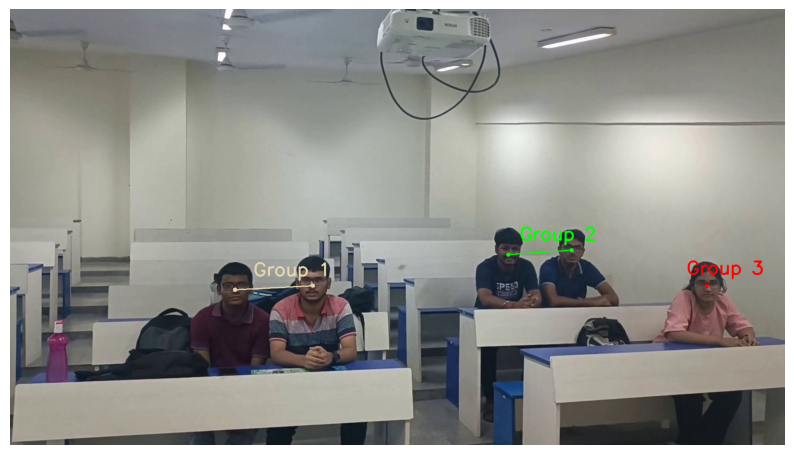

True

In [22]:
# Load the original image
image_path = '/content/drive/MyDrive/SIH/images/grouping_test.jpg'
image = cv2.imread(image_path)

# Assuming `center_points` is a NumPy array with shape (n_samples, 2)
# and `clusters` is a NumPy array with cluster labels.

# Assign a unique color to each cluster
colors = [(173, 216, 230), (0, 255, 0), (0,0,255)]
print(n_clusters)

# Draw lines between points in the same cluster and add labels
for cluster_id in range(n_clusters):
    cluster_points = center_points[clusters == cluster_id]

    if len(cluster_points) > 1:
        for i in range(len(cluster_points) - 1):
            pt1 = tuple(cluster_points[i])
            pt2 = tuple(cluster_points[i + 1])
            cv2.line(image, pt1, pt2, colors[cluster_id], 2)

    # Draw the points themselves
    for point in cluster_points:
        cv2.circle(image, tuple(point), 5, colors[cluster_id], -1)

    # Calculate the midpoint between the first and last points
    mid_x = (cluster_points[0][0] + cluster_points[-1][0]) // 2
    mid_y = (cluster_points[0][1] + cluster_points[-1][1]) // 2

    # Adjust the label position to be 20 units above the midpoint
    label_position = (mid_x-50, mid_y - 30)

    # Place the label near the midpoint
    cv2.putText(image, f"Group {cluster_id + 1}", label_position, cv2.FONT_HERSHEY_SIMPLEX, 1.5, colors[cluster_id], 3)

# Convert to RGB for displaying with matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

# Save the resulting image (optional)
output_path = '/content/groups_image.jpg'
cv2.imwrite(output_path, image)

On video

In [24]:
# Set up logging
logging.basicConfig(level=logging.INFO)

# Load YOLOv8 models for face detection
face_model = YOLO(face_model_path)

# Define video input and output paths
video_input_path = '/content/drive/MyDrive/SIH/videos/cb1.mp4'
video_output_path = '/content/grouping_video.mp4'  # Path to save the output video
output_csv_path = '/content/group_names.csv'  # Path to save the CSV file

# Helper function to check if a file is an image
def is_image_file(file_name):
    return file_name.lower().endswith(('.png', '.jpg', '.jpeg'))

# Get the list of registered student images
registered_students = [f for f in os.listdir(registered_faces_folder) if is_image_file(f)]

os.makedirs('/content/detected_faces/', exist_ok=True)

# Open the video file
cap = cv2.VideoCapture(video_input_path)

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Total number of frames in the video
video_duration = total_frames / fps  # Total duration of the video in seconds

# Define the codec and create a VideoWriter object
out = cv2.VideoWriter(video_output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

# Variables for processing control
frames_to_process = 3  # Number of frames to process in each interval
process_interval = 1 * fps  # Interval in frames (1 second of video)

# Store previous detections to use in skipped frames
previous_detections = []  # Format: (center_x, center_y, name, (x1, y1, x2, y2))

# Process the video frame by frame
frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Only process a limited number of frames per interval
    if frame_count % process_interval < frames_to_process:

        # Detect faces in the current frame using the YOLO model
        face_results = face_model.predict(frame)

        # Dictionary to track the best match for each student
        best_matches = {}

        # Process each detected face in the frame
        for idx, result in enumerate(face_results[0].boxes.data.tolist()):
            x1, y1, x2, y2, conf, cls = map(int, result[:6])
            center_x = int((x1 + x2) / 2)
            center_y = int((y1 + y2) / 2)

            # Crop the detected face
            detected_face = frame[y1:y2, x1:x2]
            cropped_face_path = f'/content/detected_faces/detected_face_{frame_count}_{idx}.jpg'
            cv2.imwrite(cropped_face_path, detected_face)

            try:
                # Perform face recognition using DeepFace
                dfs = DeepFace.find(img_path=cropped_face_path, db_path=registered_faces_folder, model_name='GhostFaceNet', enforce_detection=False)

                # Initialize variables to track the best match
                best_match_student = None
                lowest_distance = float('inf')

                # Iterate through the list of DataFrames returned by DeepFace.find()
                for df in dfs:
                    if not df.empty:
                        for _, row in df.iterrows():
                            registered_name = os.path.splitext(os.path.basename(row['identity']))[0]

                            if row['distance'] < lowest_distance:
                                lowest_distance = row['distance']
                                best_match_student = registered_name.split('_')[0]

                # Store the best match if it meets the threshold
                if best_match_student and lowest_distance < 0.5:  # Threshold set to 0.5
                    if best_match_student not in best_matches or lowest_distance < best_matches[best_match_student]['distance']:
                        best_matches[best_match_student] = {
                            'center_x': center_x,
                            'center_y': center_y,
                            'bbox': (x1, y1, x2, y2),
                            'distance': lowest_distance
                        }

            except Exception as e:
                logging.error(f"Error processing face {idx} in frame {frame_count}: {e}")

        # Convert the best matches to current detections
        current_detections = [
            (data['center_x'], data['center_y'], student, data['bbox'])
            for student, data in best_matches.items()
        ]

        # If no face is detected, retain the last known location
        if not current_detections:
            current_detections = previous_detections

        # Add missing detection
        added_names = []
        # Iterate over previous detections
        for prev_detection in previous_detections:
            prev_center_x, prev_center_y, prev_name, prev_bbox = prev_detection

            # Check if this previous detection is not in the current detections
            face_still_detected = False
            for curr_detection in current_detections:
                curr_center_x, curr_center_y, curr_name, curr_bbox = curr_detection
                if prev_name == curr_name:
                    face_still_detected = True
                    break

            # If the face was not detected in the current frame, add it to current detections
            if not face_still_detected:
                current_detections.append(prev_detection)
                added_names.append(prev_name)

        # Update previous detections with current detections
        previous_detections = current_detections

        # Extract the center points and names
        center_points = np.array([(center_x, center_y) for center_x, center_y, _, _ in current_detections])
        names = [name for _, _, name, _ in current_detections]

        # Apply DBSCAN clustering
        if len(center_points) > 0:
            dbscan = DBSCAN(eps=200, min_samples=1).fit(center_points)
            clusters = dbscan.labels_

            # Number of clusters found (excluding noise points labeled as -1)
            n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)

            # Group names by clusters
            clustered_names = {i: [] for i in range(n_clusters) if i != -1}
            for i, cluster in enumerate(clusters):
                if cluster != -1:  # Ignore noise points
                    clustered_names[cluster].append(names[i])

            # Draw clusters on the frame
            colors = [(173, 216, 230), (0, 255, 0), (0, 0, 255)]  # Colors for clusters

            for cluster_id in range(n_clusters):
                cluster_points = center_points[clusters == cluster_id]

                if len(cluster_points) > 1:
                    for i in range(len(cluster_points) - 1):
                        pt1 = tuple(cluster_points[i])
                        pt2 = tuple(cluster_points[i + 1])
                        cv2.line(frame, pt1, pt2, colors[cluster_id % len(cluster_points)], 2)

                # Draw the points themselves
                for point in cluster_points:
                    cv2.circle(frame, tuple(point), 5, colors[cluster_id % len(cluster_points)], -1)

                # Calculate the midpoint between the first and last points
                mid_x = (cluster_points[0][0] + cluster_points[-1][0]) // 2
                mid_y = (cluster_points[0][1] + cluster_points[-1][1]) // 2

                # Adjust the label position to be 20 units above the midpoint
                label_position = (mid_x - 50, mid_y - 30)

                # Place the label near the midpoint
                cv2.putText(frame, f"Group {cluster_id + 1}", label_position, cv2.FONT_HERSHEY_SIMPLEX, 1, colors[cluster_id % len(cluster_points)], 2)

            # Write the clusters to a CSV file
            with open(output_csv_path, mode='w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(['group', 'names'])

                for cluster_id, name_list in clustered_names.items():
                    writer.writerow([f'group{cluster_id + 1}', ', '.join(name_list)])

    # Draw previous face detections on every frame
    for (center_x, center_y, name, (x1, y1, x2, y2)) in previous_detections:
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Write the annotated frame to the output video
    out.write(frame)
    frame_count += 1

# Release the video objects
cap.release()
out.release()

logging.info(f"Processed video saved at: {video_output_path}")
logging.info(f"Cluster CSV file saved at: {output_csv_path}")


0: 384x640 5 FACEs, 9.6ms
Speed: 3.7ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:54:49 - Searching /content/detected_faces/detected_face_0_0.jpg in 24 length datastore
24-09-03 18:54:49 - find function duration 0.24184918403625488 seconds
24-09-03 18:54:49 - Searching /content/detected_faces/detected_face_0_1.jpg in 24 length datastore
24-09-03 18:54:49 - find function duration 0.24300456047058105 seconds
24-09-03 18:54:49 - Searching /content/detected_faces/detected_face_0_2.jpg in 24 length datastore
24-09-03 18:54:50 - find function duration 0.2485969066619873 seconds
24-09-03 18:54:50 - Searching /content/detected_faces/detected_face_0_3.jpg in 24 length datastore
24-09-03 18:54:50 - find function duration 0.21356821060180664 seconds
24-09-03 18:54:50 - Searching /content/detected_faces/detected_face_0_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 10.0ms
Speed: 5.1ms preprocess, 10.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:54:50 - find function duration 0.22778034210205078 seconds
24-09-03 18:54:50 - Searching /content/detected_faces/detected_face_1_0.jpg in 24 length datastore
24-09-03 18:54:50 - find function duration 0.23839640617370605 seconds
24-09-03 18:54:50 - Searching /content/detected_faces/detected_face_1_1.jpg in 24 length datastore
24-09-03 18:54:51 - find function duration 0.22196102142333984 seconds
24-09-03 18:54:51 - Searching /content/detected_faces/detected_face_1_2.jpg in 24 length datastore
24-09-03 18:54:51 - find function duration 0.24074506759643555 seconds
24-09-03 18:54:51 - Searching /content/detected_faces/detected_face_1_3.jpg in 24 length datastore
24-09-03 18:54:51 - find function duration 0.2220761775970459 seconds
24-09-03 18:54:51 - Searching /content/detected_faces/detected_face_1_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 13.1ms
Speed: 3.2ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:54:51 - find function duration 0.23764467239379883 seconds
24-09-03 18:54:51 - Searching /content/detected_faces/detected_face_2_0.jpg in 24 length datastore
24-09-03 18:54:52 - find function duration 0.22985172271728516 seconds
24-09-03 18:54:52 - Searching /content/detected_faces/detected_face_2_1.jpg in 24 length datastore
24-09-03 18:54:52 - find function duration 0.24334383010864258 seconds
24-09-03 18:54:52 - Searching /content/detected_faces/detected_face_2_2.jpg in 24 length datastore
24-09-03 18:54:52 - find function duration 0.221052885055542 seconds
24-09-03 18:54:52 - Searching /content/detected_faces/detected_face_2_3.jpg in 24 length datastore
24-09-03 18:54:52 - find function duration 0.2290189266204834 seconds
24-09-03 18:54:52 - Searching /content/detected_faces/detected_face_2_4.jpg in 24 length datastore
24-09-03 18:54:52 - find function duration 0.23673748970031738 seconds



0: 384x640 5 FACEs, 9.4ms
Speed: 3.3ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:54:53 - Searching /content/detected_faces/detected_face_29_0.jpg in 24 length datastore
24-09-03 18:54:54 - find function duration 0.23711657524108887 seconds
24-09-03 18:54:54 - Searching /content/detected_faces/detected_face_29_1.jpg in 24 length datastore
24-09-03 18:54:54 - find function duration 0.2039783000946045 seconds
24-09-03 18:54:54 - Searching /content/detected_faces/detected_face_29_2.jpg in 24 length datastore
24-09-03 18:54:54 - find function duration 0.22281718254089355 seconds
24-09-03 18:54:54 - Searching /content/detected_faces/detected_face_29_3.jpg in 24 length datastore
24-09-03 18:54:54 - find function duration 0.2000424861907959 seconds
24-09-03 18:54:54 - Searching /content/detected_faces/detected_face_29_4.jpg in 24 length datastore
24-09-03 18:54:54 - find function duration 0.19179677963256836 seconds



0: 384x640 5 FACEs, 10.0ms
Speed: 3.2ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:54:54 - Searching /content/detected_faces/detected_face_30_0.jpg in 24 length datastore
24-09-03 18:54:55 - find function duration 0.23741626739501953 seconds
24-09-03 18:54:55 - Searching /content/detected_faces/detected_face_30_1.jpg in 24 length datastore
24-09-03 18:54:55 - find function duration 0.20294952392578125 seconds
24-09-03 18:54:55 - Searching /content/detected_faces/detected_face_30_2.jpg in 24 length datastore
24-09-03 18:54:55 - find function duration 0.2177734375 seconds
24-09-03 18:54:55 - Searching /content/detected_faces/detected_face_30_3.jpg in 24 length datastore
24-09-03 18:54:55 - find function duration 0.19789481163024902 seconds
24-09-03 18:54:55 - Searching /content/detected_faces/detected_face_30_4.jpg in 24 length datastore
24-09-03 18:54:55 - find function duration 0.19241118431091309 seconds



0: 384x640 5 FACEs, 10.3ms
Speed: 3.8ms preprocess, 10.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:54:56 - Searching /content/detected_faces/detected_face_31_0.jpg in 24 length datastore
24-09-03 18:54:56 - find function duration 0.22599124908447266 seconds
24-09-03 18:54:56 - Searching /content/detected_faces/detected_face_31_1.jpg in 24 length datastore
24-09-03 18:54:56 - find function duration 0.21649718284606934 seconds
24-09-03 18:54:56 - Searching /content/detected_faces/detected_face_31_2.jpg in 24 length datastore
24-09-03 18:54:56 - find function duration 0.20170044898986816 seconds
24-09-03 18:54:56 - Searching /content/detected_faces/detected_face_31_3.jpg in 24 length datastore
24-09-03 18:54:56 - find function duration 0.18944644927978516 seconds
24-09-03 18:54:56 - Searching /content/detected_faces/detected_face_31_4.jpg in 24 length datastore
24-09-03 18:54:57 - find function duration 0.23357439041137695 seconds



0: 384x640 5 FACEs, 12.4ms
Speed: 3.3ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:54:57 - Searching /content/detected_faces/detected_face_58_0.jpg in 24 length datastore
24-09-03 18:54:58 - find function duration 0.24332022666931152 seconds
24-09-03 18:54:58 - Searching /content/detected_faces/detected_face_58_1.jpg in 24 length datastore
24-09-03 18:54:58 - find function duration 0.2730369567871094 seconds
24-09-03 18:54:58 - Searching /content/detected_faces/detected_face_58_2.jpg in 24 length datastore
24-09-03 18:54:58 - find function duration 0.2924644947052002 seconds
24-09-03 18:54:58 - Searching /content/detected_faces/detected_face_58_3.jpg in 24 length datastore
24-09-03 18:54:58 - find function duration 0.26532959938049316 seconds
24-09-03 18:54:58 - Searching /content/detected_faces/detected_face_58_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 20.4ms
Speed: 4.6ms preprocess, 20.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:54:59 - find function duration 0.2690582275390625 seconds
24-09-03 18:54:59 - Searching /content/detected_faces/detected_face_59_0.jpg in 24 length datastore
24-09-03 18:54:59 - find function duration 0.32364559173583984 seconds
24-09-03 18:54:59 - Searching /content/detected_faces/detected_face_59_1.jpg in 24 length datastore
24-09-03 18:54:59 - find function duration 0.274564266204834 seconds
24-09-03 18:54:59 - Searching /content/detected_faces/detected_face_59_2.jpg in 24 length datastore
24-09-03 18:55:00 - find function duration 0.28438639640808105 seconds
24-09-03 18:55:00 - Searching /content/detected_faces/detected_face_59_3.jpg in 24 length datastore
24-09-03 18:55:00 - find function duration 0.27581310272216797 seconds
24-09-03 18:55:00 - Searching /content/detected_faces/detected_face_59_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 11.2ms
Speed: 4.5ms preprocess, 11.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:00 - find function duration 0.28725337982177734 seconds
24-09-03 18:55:00 - Searching /content/detected_faces/detected_face_60_0.jpg in 24 length datastore
24-09-03 18:55:01 - find function duration 0.3098311424255371 seconds
24-09-03 18:55:01 - Searching /content/detected_faces/detected_face_60_1.jpg in 24 length datastore
24-09-03 18:55:01 - find function duration 0.2961881160736084 seconds
24-09-03 18:55:01 - Searching /content/detected_faces/detected_face_60_2.jpg in 24 length datastore
24-09-03 18:55:01 - find function duration 0.29074931144714355 seconds
24-09-03 18:55:01 - Searching /content/detected_faces/detected_face_60_3.jpg in 24 length datastore
24-09-03 18:55:01 - find function duration 0.30306506156921387 seconds
24-09-03 18:55:01 - Searching /content/detected_faces/detected_face_60_4.jpg in 24 length datastore
24-09-03 18:55:02 - find function duration 0.3263523578643799 seconds



0: 384x640 5 FACEs, 11.0ms
Speed: 3.1ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:03 - Searching /content/detected_faces/detected_face_87_0.jpg in 24 length datastore
24-09-03 18:55:03 - find function duration 0.23097562789916992 seconds
24-09-03 18:55:03 - Searching /content/detected_faces/detected_face_87_1.jpg in 24 length datastore
24-09-03 18:55:03 - find function duration 0.207472562789917 seconds
24-09-03 18:55:03 - Searching /content/detected_faces/detected_face_87_2.jpg in 24 length datastore
24-09-03 18:55:03 - find function duration 0.2390434741973877 seconds
24-09-03 18:55:03 - Searching /content/detected_faces/detected_face_87_3.jpg in 24 length datastore
24-09-03 18:55:04 - find function duration 0.2123401165008545 seconds
24-09-03 18:55:04 - Searching /content/detected_faces/detected_face_87_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 11.2ms
Speed: 3.1ms preprocess, 11.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:04 - find function duration 0.2053053379058838 seconds
24-09-03 18:55:04 - Searching /content/detected_faces/detected_face_88_0.jpg in 24 length datastore
24-09-03 18:55:04 - find function duration 0.24219560623168945 seconds
24-09-03 18:55:04 - Searching /content/detected_faces/detected_face_88_1.jpg in 24 length datastore
24-09-03 18:55:04 - find function duration 0.21772217750549316 seconds
24-09-03 18:55:04 - Searching /content/detected_faces/detected_face_88_2.jpg in 24 length datastore
24-09-03 18:55:04 - find function duration 0.21023225784301758 seconds
24-09-03 18:55:04 - Searching /content/detected_faces/detected_face_88_3.jpg in 24 length datastore
24-09-03 18:55:05 - find function duration 0.19226527214050293 seconds
24-09-03 18:55:05 - Searching /content/detected_faces/detected_face_88_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 16.6ms
Speed: 6.9ms preprocess, 16.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:05 - find function duration 0.3536839485168457 seconds
24-09-03 18:55:05 - Searching /content/detected_faces/detected_face_89_0.jpg in 24 length datastore
24-09-03 18:55:05 - find function duration 0.3434932231903076 seconds
24-09-03 18:55:05 - Searching /content/detected_faces/detected_face_89_1.jpg in 24 length datastore
24-09-03 18:55:06 - find function duration 0.362166166305542 seconds
24-09-03 18:55:06 - Searching /content/detected_faces/detected_face_89_2.jpg in 24 length datastore
24-09-03 18:55:06 - find function duration 0.38652968406677246 seconds
24-09-03 18:55:06 - Searching /content/detected_faces/detected_face_89_3.jpg in 24 length datastore
24-09-03 18:55:07 - find function duration 0.35517144203186035 seconds
24-09-03 18:55:07 - Searching /content/detected_faces/detected_face_89_4.jpg in 24 length datastore
24-09-03 18:55:07 - find function duration 0.33886194229125977 seconds



0: 384x640 5 FACEs, 13.1ms
Speed: 11.3ms preprocess, 13.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:08 - Searching /content/detected_faces/detected_face_116_0.jpg in 24 length datastore
24-09-03 18:55:08 - find function duration 0.3156468868255615 seconds
24-09-03 18:55:08 - Searching /content/detected_faces/detected_face_116_1.jpg in 24 length datastore
24-09-03 18:55:09 - find function duration 0.34927845001220703 seconds
24-09-03 18:55:09 - Searching /content/detected_faces/detected_face_116_2.jpg in 24 length datastore
24-09-03 18:55:09 - find function duration 0.33150386810302734 seconds
24-09-03 18:55:09 - Searching /content/detected_faces/detected_face_116_3.jpg in 24 length datastore
24-09-03 18:55:09 - find function duration 0.29901862144470215 seconds
24-09-03 18:55:09 - Searching /content/detected_faces/detected_face_116_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 10.2ms
Speed: 3.6ms preprocess, 10.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:10 - find function duration 0.2022542953491211 seconds
24-09-03 18:55:10 - Searching /content/detected_faces/detected_face_117_0.jpg in 24 length datastore
24-09-03 18:55:10 - find function duration 0.2180016040802002 seconds
24-09-03 18:55:10 - Searching /content/detected_faces/detected_face_117_1.jpg in 24 length datastore
24-09-03 18:55:10 - find function duration 0.21507740020751953 seconds
24-09-03 18:55:10 - Searching /content/detected_faces/detected_face_117_2.jpg in 24 length datastore
24-09-03 18:55:10 - find function duration 0.22252488136291504 seconds
24-09-03 18:55:10 - Searching /content/detected_faces/detected_face_117_3.jpg in 24 length datastore
24-09-03 18:55:10 - find function duration 0.19359707832336426 seconds
24-09-03 18:55:10 - Searching /content/detected_faces/detected_face_117_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 11.1ms
Speed: 3.7ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:11 - find function duration 0.2039811611175537 seconds
24-09-03 18:55:11 - Searching /content/detected_faces/detected_face_118_0.jpg in 24 length datastore
24-09-03 18:55:11 - find function duration 0.22670412063598633 seconds
24-09-03 18:55:11 - Searching /content/detected_faces/detected_face_118_1.jpg in 24 length datastore
24-09-03 18:55:11 - find function duration 0.2109375 seconds
24-09-03 18:55:11 - Searching /content/detected_faces/detected_face_118_2.jpg in 24 length datastore
24-09-03 18:55:11 - find function duration 0.20201992988586426 seconds
24-09-03 18:55:11 - Searching /content/detected_faces/detected_face_118_3.jpg in 24 length datastore
24-09-03 18:55:12 - find function duration 0.1988680362701416 seconds
24-09-03 18:55:12 - Searching /content/detected_faces/detected_face_118_4.jpg in 24 length datastore
24-09-03 18:55:12 - find function duration 0.206298828125 seconds



0: 384x640 5 FACEs, 14.6ms
Speed: 4.4ms preprocess, 14.6ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:13 - Searching /content/detected_faces/detected_face_145_0.jpg in 24 length datastore
24-09-03 18:55:13 - find function duration 0.28919458389282227 seconds
24-09-03 18:55:13 - Searching /content/detected_faces/detected_face_145_1.jpg in 24 length datastore
24-09-03 18:55:13 - find function duration 0.2649350166320801 seconds
24-09-03 18:55:13 - Searching /content/detected_faces/detected_face_145_2.jpg in 24 length datastore
24-09-03 18:55:14 - find function duration 0.2958059310913086 seconds
24-09-03 18:55:14 - Searching /content/detected_faces/detected_face_145_3.jpg in 24 length datastore
24-09-03 18:55:14 - find function duration 0.26910877227783203 seconds
24-09-03 18:55:14 - Searching /content/detected_faces/detected_face_145_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 13.5ms
Speed: 3.1ms preprocess, 13.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:14 - find function duration 0.26202917098999023 seconds
24-09-03 18:55:14 - Searching /content/detected_faces/detected_face_146_0.jpg in 24 length datastore
24-09-03 18:55:14 - find function duration 0.33956003189086914 seconds
24-09-03 18:55:15 - Searching /content/detected_faces/detected_face_146_1.jpg in 24 length datastore
24-09-03 18:55:15 - find function duration 0.80647873878479 seconds
24-09-03 18:55:15 - Searching /content/detected_faces/detected_face_146_2.jpg in 24 length datastore
24-09-03 18:55:16 - find function duration 0.7227849960327148 seconds
24-09-03 18:55:16 - Searching /content/detected_faces/detected_face_146_3.jpg in 24 length datastore
24-09-03 18:55:17 - find function duration 0.6258480548858643 seconds
24-09-03 18:55:17 - Searching /content/detected_faces/detected_face_146_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 25.3ms
Speed: 13.7ms preprocess, 25.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:17 - find function duration 0.6329824924468994 seconds
24-09-03 18:55:17 - Searching /content/detected_faces/detected_face_147_0.jpg in 24 length datastore
24-09-03 18:55:18 - find function duration 0.37366342544555664 seconds
24-09-03 18:55:18 - Searching /content/detected_faces/detected_face_147_1.jpg in 24 length datastore
24-09-03 18:55:18 - find function duration 0.4335653781890869 seconds
24-09-03 18:55:18 - Searching /content/detected_faces/detected_face_147_2.jpg in 24 length datastore
24-09-03 18:55:19 - find function duration 0.44295477867126465 seconds
24-09-03 18:55:19 - Searching /content/detected_faces/detected_face_147_3.jpg in 24 length datastore
24-09-03 18:55:19 - find function duration 0.3628566265106201 seconds
24-09-03 18:55:19 - Searching /content/detected_faces/detected_face_147_4.jpg in 24 length datastore
24-09-03 18:55:19 - find function duration 0.3098273277282715 seconds



0: 384x640 5 FACEs, 13.3ms
Speed: 10.6ms preprocess, 13.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:21 - Searching /content/detected_faces/detected_face_174_0.jpg in 24 length datastore
24-09-03 18:55:21 - find function duration 0.3352622985839844 seconds
24-09-03 18:55:21 - Searching /content/detected_faces/detected_face_174_1.jpg in 24 length datastore
24-09-03 18:55:21 - find function duration 0.26879358291625977 seconds
24-09-03 18:55:21 - Searching /content/detected_faces/detected_face_174_2.jpg in 24 length datastore
24-09-03 18:55:21 - find function duration 0.19486308097839355 seconds
24-09-03 18:55:21 - Searching /content/detected_faces/detected_face_174_3.jpg in 24 length datastore
24-09-03 18:55:22 - find function duration 0.2104191780090332 seconds
24-09-03 18:55:22 - Searching /content/detected_faces/detected_face_174_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 10.9ms
Speed: 3.9ms preprocess, 10.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:22 - find function duration 0.2119138240814209 seconds
24-09-03 18:55:22 - Searching /content/detected_faces/detected_face_175_0.jpg in 24 length datastore
24-09-03 18:55:22 - find function duration 0.22810101509094238 seconds
24-09-03 18:55:22 - Searching /content/detected_faces/detected_face_175_1.jpg in 24 length datastore
24-09-03 18:55:22 - find function duration 0.20020818710327148 seconds
24-09-03 18:55:22 - Searching /content/detected_faces/detected_face_175_2.jpg in 24 length datastore
24-09-03 18:55:23 - find function duration 0.1938486099243164 seconds
24-09-03 18:55:23 - Searching /content/detected_faces/detected_face_175_3.jpg in 24 length datastore
24-09-03 18:55:23 - find function duration 0.2025909423828125 seconds
24-09-03 18:55:23 - Searching /content/detected_faces/detected_face_175_4.jpg in 24 length datastore
24-09-03 18:55:23 - find function duration 0.18964123725891113 seconds



0: 384x640 5 FACEs, 9.8ms
Speed: 3.3ms preprocess, 9.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:23 - Searching /content/detected_faces/detected_face_176_0.jpg in 24 length datastore
24-09-03 18:55:23 - find function duration 0.19817256927490234 seconds
24-09-03 18:55:23 - Searching /content/detected_faces/detected_face_176_1.jpg in 24 length datastore
24-09-03 18:55:23 - find function duration 0.2053842544555664 seconds
24-09-03 18:55:23 - Searching /content/detected_faces/detected_face_176_2.jpg in 24 length datastore
24-09-03 18:55:24 - find function duration 0.21615099906921387 seconds
24-09-03 18:55:24 - Searching /content/detected_faces/detected_face_176_3.jpg in 24 length datastore
24-09-03 18:55:24 - find function duration 0.21532392501831055 seconds
24-09-03 18:55:24 - Searching /content/detected_faces/detected_face_176_4.jpg in 24 length datastore
24-09-03 18:55:24 - find function duration 0.21022415161132812 seconds



0: 384x640 4 FACEs, 9.6ms
Speed: 3.3ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:25 - Searching /content/detected_faces/detected_face_203_0.jpg in 24 length datastore
24-09-03 18:55:25 - find function duration 0.23671555519104004 seconds
24-09-03 18:55:25 - Searching /content/detected_faces/detected_face_203_1.jpg in 24 length datastore
24-09-03 18:55:25 - find function duration 0.2150895595550537 seconds
24-09-03 18:55:25 - Searching /content/detected_faces/detected_face_203_2.jpg in 24 length datastore
24-09-03 18:55:25 - find function duration 0.20493125915527344 seconds
24-09-03 18:55:25 - Searching /content/detected_faces/detected_face_203_3.jpg in 24 length datastore



0: 384x640 4 FACEs, 14.5ms
Speed: 3.9ms preprocess, 14.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:26 - find function duration 0.20366358757019043 seconds
24-09-03 18:55:26 - Searching /content/detected_faces/detected_face_204_0.jpg in 24 length datastore
24-09-03 18:55:26 - find function duration 0.2180647850036621 seconds
24-09-03 18:55:26 - Searching /content/detected_faces/detected_face_204_1.jpg in 24 length datastore
24-09-03 18:55:26 - find function duration 0.22538304328918457 seconds
24-09-03 18:55:26 - Searching /content/detected_faces/detected_face_204_2.jpg in 24 length datastore
24-09-03 18:55:26 - find function duration 0.23035979270935059 seconds
24-09-03 18:55:26 - Searching /content/detected_faces/detected_face_204_3.jpg in 24 length datastore



0: 384x640 4 FACEs, 10.8ms
Speed: 6.6ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:27 - find function duration 0.22023296356201172 seconds
24-09-03 18:55:27 - Searching /content/detected_faces/detected_face_205_0.jpg in 24 length datastore
24-09-03 18:55:27 - find function duration 0.23260760307312012 seconds
24-09-03 18:55:27 - Searching /content/detected_faces/detected_face_205_1.jpg in 24 length datastore
24-09-03 18:55:27 - find function duration 0.23421669006347656 seconds
24-09-03 18:55:27 - Searching /content/detected_faces/detected_face_205_2.jpg in 24 length datastore
24-09-03 18:55:27 - find function duration 0.20701146125793457 seconds
24-09-03 18:55:27 - Searching /content/detected_faces/detected_face_205_3.jpg in 24 length datastore
24-09-03 18:55:28 - find function duration 0.26390671730041504 seconds



0: 384x640 5 FACEs, 11.3ms
Speed: 4.2ms preprocess, 11.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:29 - Searching /content/detected_faces/detected_face_232_0.jpg in 24 length datastore
24-09-03 18:55:29 - find function duration 0.3122560977935791 seconds
24-09-03 18:55:29 - Searching /content/detected_faces/detected_face_232_1.jpg in 24 length datastore
24-09-03 18:55:29 - find function duration 0.2784922122955322 seconds
24-09-03 18:55:29 - Searching /content/detected_faces/detected_face_232_2.jpg in 24 length datastore
24-09-03 18:55:30 - find function duration 0.2663149833679199 seconds
24-09-03 18:55:30 - Searching /content/detected_faces/detected_face_232_3.jpg in 24 length datastore
24-09-03 18:55:30 - find function duration 0.2821815013885498 seconds
24-09-03 18:55:30 - Searching /content/detected_faces/detected_face_232_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 20.1ms
Speed: 3.1ms preprocess, 20.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:30 - find function duration 0.3017897605895996 seconds
24-09-03 18:55:30 - Searching /content/detected_faces/detected_face_233_0.jpg in 24 length datastore
24-09-03 18:55:31 - find function duration 0.30195093154907227 seconds
24-09-03 18:55:31 - Searching /content/detected_faces/detected_face_233_1.jpg in 24 length datastore
24-09-03 18:55:31 - find function duration 0.28974342346191406 seconds
24-09-03 18:55:31 - Searching /content/detected_faces/detected_face_233_2.jpg in 24 length datastore
24-09-03 18:55:31 - find function duration 0.30177998542785645 seconds
24-09-03 18:55:31 - Searching /content/detected_faces/detected_face_233_3.jpg in 24 length datastore
24-09-03 18:55:31 - find function duration 0.29860615730285645 seconds
24-09-03 18:55:31 - Searching /content/detected_faces/detected_face_233_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 18.0ms
Speed: 3.8ms preprocess, 18.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:32 - find function duration 0.27471423149108887 seconds
24-09-03 18:55:32 - Searching /content/detected_faces/detected_face_234_0.jpg in 24 length datastore
24-09-03 18:55:32 - find function duration 0.3351912498474121 seconds
24-09-03 18:55:32 - Searching /content/detected_faces/detected_face_234_1.jpg in 24 length datastore
24-09-03 18:55:32 - find function duration 0.2672562599182129 seconds
24-09-03 18:55:32 - Searching /content/detected_faces/detected_face_234_2.jpg in 24 length datastore
24-09-03 18:55:33 - find function duration 0.19526410102844238 seconds
24-09-03 18:55:33 - Searching /content/detected_faces/detected_face_234_3.jpg in 24 length datastore
24-09-03 18:55:33 - find function duration 0.19835615158081055 seconds
24-09-03 18:55:33 - Searching /content/detected_faces/detected_face_234_4.jpg in 24 length datastore
24-09-03 18:55:33 - find function duration 0.2024080753326416 seconds



0: 384x640 5 FACEs, 10.2ms
Speed: 5.3ms preprocess, 10.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:34 - Searching /content/detected_faces/detected_face_261_0.jpg in 24 length datastore
24-09-03 18:55:34 - find function duration 0.2187952995300293 seconds
24-09-03 18:55:34 - Searching /content/detected_faces/detected_face_261_1.jpg in 24 length datastore
24-09-03 18:55:34 - find function duration 0.21020245552062988 seconds
24-09-03 18:55:34 - Searching /content/detected_faces/detected_face_261_2.jpg in 24 length datastore
24-09-03 18:55:34 - find function duration 0.2041459083557129 seconds
24-09-03 18:55:34 - Searching /content/detected_faces/detected_face_261_3.jpg in 24 length datastore
24-09-03 18:55:35 - find function duration 0.21095871925354004 seconds
24-09-03 18:55:35 - Searching /content/detected_faces/detected_face_261_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 10.0ms
Speed: 3.2ms preprocess, 10.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:35 - find function duration 0.20665311813354492 seconds
24-09-03 18:55:35 - Searching /content/detected_faces/detected_face_262_0.jpg in 24 length datastore
24-09-03 18:55:35 - find function duration 0.22504568099975586 seconds
24-09-03 18:55:35 - Searching /content/detected_faces/detected_face_262_1.jpg in 24 length datastore
24-09-03 18:55:35 - find function duration 0.22324252128601074 seconds
24-09-03 18:55:35 - Searching /content/detected_faces/detected_face_262_2.jpg in 24 length datastore
24-09-03 18:55:36 - find function duration 0.2110753059387207 seconds
24-09-03 18:55:36 - Searching /content/detected_faces/detected_face_262_3.jpg in 24 length datastore
24-09-03 18:55:36 - find function duration 0.19714879989624023 seconds
24-09-03 18:55:36 - Searching /content/detected_faces/detected_face_262_4.jpg in 24 length datastore
24-09-03 18:55:36 - find function duration 0.20389962196350098 seconds



0: 384x640 5 FACEs, 10.0ms
Speed: 3.2ms preprocess, 10.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:36 - Searching /content/detected_faces/detected_face_263_0.jpg in 24 length datastore
24-09-03 18:55:36 - find function duration 0.22240734100341797 seconds
24-09-03 18:55:36 - Searching /content/detected_faces/detected_face_263_1.jpg in 24 length datastore
24-09-03 18:55:36 - find function duration 0.2019355297088623 seconds
24-09-03 18:55:36 - Searching /content/detected_faces/detected_face_263_2.jpg in 24 length datastore
24-09-03 18:55:37 - find function duration 0.21827983856201172 seconds
24-09-03 18:55:37 - Searching /content/detected_faces/detected_face_263_3.jpg in 24 length datastore
24-09-03 18:55:37 - find function duration 0.19866275787353516 seconds
24-09-03 18:55:37 - Searching /content/detected_faces/detected_face_263_4.jpg in 24 length datastore
24-09-03 18:55:37 - find function duration 0.22247815132141113 seconds



0: 384x640 5 FACEs, 9.9ms
Speed: 3.2ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:38 - Searching /content/detected_faces/detected_face_290_0.jpg in 24 length datastore
24-09-03 18:55:38 - find function duration 0.23315024375915527 seconds
24-09-03 18:55:38 - Searching /content/detected_faces/detected_face_290_1.jpg in 24 length datastore
24-09-03 18:55:38 - find function duration 0.23200774192810059 seconds
24-09-03 18:55:38 - Searching /content/detected_faces/detected_face_290_2.jpg in 24 length datastore
24-09-03 18:55:38 - find function duration 0.23674464225769043 seconds
24-09-03 18:55:39 - Searching /content/detected_faces/detected_face_290_3.jpg in 24 length datastore
24-09-03 18:55:39 - find function duration 0.2049882411956787 seconds
24-09-03 18:55:39 - Searching /content/detected_faces/detected_face_290_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 11.4ms
Speed: 3.3ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:39 - find function duration 0.22074079513549805 seconds
24-09-03 18:55:39 - Searching /content/detected_faces/detected_face_291_0.jpg in 24 length datastore
24-09-03 18:55:39 - find function duration 0.2096092700958252 seconds
24-09-03 18:55:39 - Searching /content/detected_faces/detected_face_291_1.jpg in 24 length datastore
24-09-03 18:55:39 - find function duration 0.22075796127319336 seconds
24-09-03 18:55:39 - Searching /content/detected_faces/detected_face_291_2.jpg in 24 length datastore
24-09-03 18:55:40 - find function duration 0.20641231536865234 seconds
24-09-03 18:55:40 - Searching /content/detected_faces/detected_face_291_3.jpg in 24 length datastore
24-09-03 18:55:40 - find function duration 0.2040083408355713 seconds
24-09-03 18:55:40 - Searching /content/detected_faces/detected_face_291_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 9.0ms
Speed: 3.2ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:40 - find function duration 0.21691608428955078 seconds
24-09-03 18:55:40 - Searching /content/detected_faces/detected_face_292_0.jpg in 24 length datastore
24-09-03 18:55:40 - find function duration 0.2070925235748291 seconds
24-09-03 18:55:40 - Searching /content/detected_faces/detected_face_292_1.jpg in 24 length datastore
24-09-03 18:55:41 - find function duration 0.2223799228668213 seconds
24-09-03 18:55:41 - Searching /content/detected_faces/detected_face_292_2.jpg in 24 length datastore
24-09-03 18:55:41 - find function duration 0.19903111457824707 seconds
24-09-03 18:55:41 - Searching /content/detected_faces/detected_face_292_3.jpg in 24 length datastore
24-09-03 18:55:41 - find function duration 0.22779083251953125 seconds
24-09-03 18:55:41 - Searching /content/detected_faces/detected_face_292_4.jpg in 24 length datastore
24-09-03 18:55:41 - find function duration 0.19802474975585938 seconds



0: 384x640 5 FACEs, 11.4ms
Speed: 6.5ms preprocess, 11.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:42 - Searching /content/detected_faces/detected_face_319_0.jpg in 24 length datastore
24-09-03 18:55:42 - find function duration 0.21437811851501465 seconds
24-09-03 18:55:42 - Searching /content/detected_faces/detected_face_319_1.jpg in 24 length datastore
24-09-03 18:55:42 - find function duration 0.2191927433013916 seconds
24-09-03 18:55:42 - Searching /content/detected_faces/detected_face_319_2.jpg in 24 length datastore
24-09-03 18:55:43 - find function duration 0.304121732711792 seconds
24-09-03 18:55:43 - Searching /content/detected_faces/detected_face_319_3.jpg in 24 length datastore
24-09-03 18:55:43 - find function duration 0.2778818607330322 seconds
24-09-03 18:55:43 - Searching /content/detected_faces/detected_face_319_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 14.3ms
Speed: 3.1ms preprocess, 14.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:43 - find function duration 0.3169069290161133 seconds
24-09-03 18:55:43 - Searching /content/detected_faces/detected_face_320_0.jpg in 24 length datastore
24-09-03 18:55:44 - find function duration 0.30570125579833984 seconds
24-09-03 18:55:44 - Searching /content/detected_faces/detected_face_320_1.jpg in 24 length datastore
24-09-03 18:55:44 - find function duration 0.28353023529052734 seconds
24-09-03 18:55:44 - Searching /content/detected_faces/detected_face_320_2.jpg in 24 length datastore
24-09-03 18:55:44 - find function duration 0.2598459720611572 seconds
24-09-03 18:55:44 - Searching /content/detected_faces/detected_face_320_3.jpg in 24 length datastore
24-09-03 18:55:44 - find function duration 0.26488399505615234 seconds
24-09-03 18:55:44 - Searching /content/detected_faces/detected_face_320_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 23.8ms
Speed: 3.4ms preprocess, 23.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:45 - find function duration 0.2736806869506836 seconds
24-09-03 18:55:45 - Searching /content/detected_faces/detected_face_321_0.jpg in 24 length datastore
24-09-03 18:55:45 - find function duration 0.3189671039581299 seconds
24-09-03 18:55:45 - Searching /content/detected_faces/detected_face_321_1.jpg in 24 length datastore
24-09-03 18:55:45 - find function duration 0.2897348403930664 seconds
24-09-03 18:55:45 - Searching /content/detected_faces/detected_face_321_2.jpg in 24 length datastore
24-09-03 18:55:46 - find function duration 0.29894089698791504 seconds
24-09-03 18:55:46 - Searching /content/detected_faces/detected_face_321_3.jpg in 24 length datastore
24-09-03 18:55:46 - find function duration 0.3081858158111572 seconds
24-09-03 18:55:46 - Searching /content/detected_faces/detected_face_321_4.jpg in 24 length datastore
24-09-03 18:55:46 - find function duration 0.2881202697753906 seconds



0: 384x640 5 FACEs, 12.1ms
Speed: 3.6ms preprocess, 12.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:47 - Searching /content/detected_faces/detected_face_348_0.jpg in 24 length datastore
24-09-03 18:55:47 - find function duration 0.20452404022216797 seconds
24-09-03 18:55:47 - Searching /content/detected_faces/detected_face_348_1.jpg in 24 length datastore
24-09-03 18:55:47 - find function duration 0.19997358322143555 seconds
24-09-03 18:55:47 - Searching /content/detected_faces/detected_face_348_2.jpg in 24 length datastore
24-09-03 18:55:48 - find function duration 0.20160317420959473 seconds
24-09-03 18:55:48 - Searching /content/detected_faces/detected_face_348_3.jpg in 24 length datastore
24-09-03 18:55:48 - find function duration 0.20845699310302734 seconds
24-09-03 18:55:48 - Searching /content/detected_faces/detected_face_348_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 9.2ms
Speed: 3.3ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:48 - find function duration 0.20650744438171387 seconds
24-09-03 18:55:48 - Searching /content/detected_faces/detected_face_349_0.jpg in 24 length datastore
24-09-03 18:55:48 - find function duration 0.21905112266540527 seconds
24-09-03 18:55:48 - Searching /content/detected_faces/detected_face_349_1.jpg in 24 length datastore
24-09-03 18:55:49 - find function duration 0.21164655685424805 seconds
24-09-03 18:55:49 - Searching /content/detected_faces/detected_face_349_2.jpg in 24 length datastore
24-09-03 18:55:49 - find function duration 0.21408367156982422 seconds
24-09-03 18:55:49 - Searching /content/detected_faces/detected_face_349_3.jpg in 24 length datastore
24-09-03 18:55:49 - find function duration 0.21803903579711914 seconds
24-09-03 18:55:49 - Searching /content/detected_faces/detected_face_349_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 17.5ms
Speed: 3.2ms preprocess, 17.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:49 - find function duration 0.231642484664917 seconds
24-09-03 18:55:49 - Searching /content/detected_faces/detected_face_350_0.jpg in 24 length datastore
24-09-03 18:55:50 - find function duration 0.20993876457214355 seconds
24-09-03 18:55:50 - Searching /content/detected_faces/detected_face_350_1.jpg in 24 length datastore
24-09-03 18:55:50 - find function duration 0.48345327377319336 seconds
24-09-03 18:55:50 - Searching /content/detected_faces/detected_face_350_2.jpg in 24 length datastore
24-09-03 18:55:51 - find function duration 1.1797356605529785 seconds
24-09-03 18:55:51 - Searching /content/detected_faces/detected_face_350_3.jpg in 24 length datastore
24-09-03 18:55:52 - find function duration 0.7085220813751221 seconds
24-09-03 18:55:52 - Searching /content/detected_faces/detected_face_350_4.jpg in 24 length datastore
24-09-03 18:55:52 - find function duration 0.297377347946167 seconds



0: 384x640 5 FACEs, 28.2ms
Speed: 7.8ms preprocess, 28.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:53 - Searching /content/detected_faces/detected_face_377_0.jpg in 24 length datastore
24-09-03 18:55:54 - find function duration 0.32493042945861816 seconds
24-09-03 18:55:54 - Searching /content/detected_faces/detected_face_377_1.jpg in 24 length datastore
24-09-03 18:55:54 - find function duration 0.31678175926208496 seconds
24-09-03 18:55:54 - Searching /content/detected_faces/detected_face_377_2.jpg in 24 length datastore
24-09-03 18:55:54 - find function duration 0.29975152015686035 seconds
24-09-03 18:55:54 - Searching /content/detected_faces/detected_face_377_3.jpg in 24 length datastore
24-09-03 18:55:55 - find function duration 0.2904176712036133 seconds
24-09-03 18:55:55 - Searching /content/detected_faces/detected_face_377_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 19.4ms
Speed: 2.9ms preprocess, 19.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:55 - find function duration 0.33774709701538086 seconds
24-09-03 18:55:55 - Searching /content/detected_faces/detected_face_378_0.jpg in 24 length datastore
24-09-03 18:55:55 - find function duration 0.3747220039367676 seconds
24-09-03 18:55:55 - Searching /content/detected_faces/detected_face_378_1.jpg in 24 length datastore
24-09-03 18:55:56 - find function duration 0.19154691696166992 seconds
24-09-03 18:55:56 - Searching /content/detected_faces/detected_face_378_2.jpg in 24 length datastore
24-09-03 18:55:56 - find function duration 0.19127702713012695 seconds
24-09-03 18:55:56 - Searching /content/detected_faces/detected_face_378_3.jpg in 24 length datastore
24-09-03 18:55:56 - find function duration 0.21507716178894043 seconds
24-09-03 18:55:56 - Searching /content/detected_faces/detected_face_378_4.jpg in 24 length datastore
24-09-03 18:55:56 - find function duration 0.18694043159484863 seconds



0: 384x640 5 FACEs, 11.1ms
Speed: 3.1ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:56 - Searching /content/detected_faces/detected_face_379_0.jpg in 24 length datastore
24-09-03 18:55:57 - find function duration 0.23114490509033203 seconds
24-09-03 18:55:57 - Searching /content/detected_faces/detected_face_379_1.jpg in 24 length datastore
24-09-03 18:55:57 - find function duration 0.28093910217285156 seconds
24-09-03 18:55:57 - Searching /content/detected_faces/detected_face_379_2.jpg in 24 length datastore
24-09-03 18:55:57 - find function duration 0.289736270904541 seconds
24-09-03 18:55:57 - Searching /content/detected_faces/detected_face_379_3.jpg in 24 length datastore
24-09-03 18:55:57 - find function duration 0.2565798759460449 seconds
24-09-03 18:55:57 - Searching /content/detected_faces/detected_face_379_4.jpg in 24 length datastore
24-09-03 18:55:58 - find function duration 0.28073859214782715 seconds



0: 384x640 5 FACEs, 13.5ms
Speed: 3.1ms preprocess, 13.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:55:59 - Searching /content/detected_faces/detected_face_406_0.jpg in 24 length datastore
24-09-03 18:55:59 - find function duration 0.3259696960449219 seconds
24-09-03 18:55:59 - Searching /content/detected_faces/detected_face_406_1.jpg in 24 length datastore
24-09-03 18:55:59 - find function duration 0.28887391090393066 seconds
24-09-03 18:55:59 - Searching /content/detected_faces/detected_face_406_2.jpg in 24 length datastore
24-09-03 18:56:00 - find function duration 0.29146337509155273 seconds
24-09-03 18:56:00 - Searching /content/detected_faces/detected_face_406_3.jpg in 24 length datastore
24-09-03 18:56:00 - find function duration 0.28430819511413574 seconds
24-09-03 18:56:00 - Searching /content/detected_faces/detected_face_406_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 17.9ms
Speed: 3.5ms preprocess, 17.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:00 - find function duration 0.29073452949523926 seconds
24-09-03 18:56:00 - Searching /content/detected_faces/detected_face_407_0.jpg in 24 length datastore
24-09-03 18:56:01 - find function duration 0.31714391708374023 seconds
24-09-03 18:56:01 - Searching /content/detected_faces/detected_face_407_1.jpg in 24 length datastore
24-09-03 18:56:01 - find function duration 0.2536811828613281 seconds
24-09-03 18:56:01 - Searching /content/detected_faces/detected_face_407_2.jpg in 24 length datastore
24-09-03 18:56:01 - find function duration 0.19493961334228516 seconds
24-09-03 18:56:01 - Searching /content/detected_faces/detected_face_407_3.jpg in 24 length datastore
24-09-03 18:56:01 - find function duration 0.21216344833374023 seconds
24-09-03 18:56:01 - Searching /content/detected_faces/detected_face_407_4.jpg in 24 length datastore
24-09-03 18:56:02 - find function duration 0.1934680938720703 seconds



0: 384x640 5 FACEs, 9.1ms
Speed: 3.2ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:02 - Searching /content/detected_faces/detected_face_408_0.jpg in 24 length datastore
24-09-03 18:56:02 - find function duration 0.22294378280639648 seconds
24-09-03 18:56:02 - Searching /content/detected_faces/detected_face_408_1.jpg in 24 length datastore
24-09-03 18:56:02 - find function duration 0.2209792137145996 seconds
24-09-03 18:56:02 - Searching /content/detected_faces/detected_face_408_2.jpg in 24 length datastore
24-09-03 18:56:02 - find function duration 0.21003317832946777 seconds
24-09-03 18:56:02 - Searching /content/detected_faces/detected_face_408_3.jpg in 24 length datastore
24-09-03 18:56:03 - find function duration 0.1968681812286377 seconds
24-09-03 18:56:03 - Searching /content/detected_faces/detected_face_408_4.jpg in 24 length datastore
24-09-03 18:56:03 - find function duration 0.20186066627502441 seconds



0: 384x640 5 FACEs, 9.2ms
Speed: 4.2ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:03 - Searching /content/detected_faces/detected_face_435_0.jpg in 24 length datastore
24-09-03 18:56:04 - find function duration 0.20659685134887695 seconds
24-09-03 18:56:04 - Searching /content/detected_faces/detected_face_435_1.jpg in 24 length datastore
24-09-03 18:56:04 - find function duration 0.19057321548461914 seconds
24-09-03 18:56:04 - Searching /content/detected_faces/detected_face_435_2.jpg in 24 length datastore
24-09-03 18:56:04 - find function duration 0.21025729179382324 seconds
24-09-03 18:56:04 - Searching /content/detected_faces/detected_face_435_3.jpg in 24 length datastore
24-09-03 18:56:04 - find function duration 0.19468951225280762 seconds
24-09-03 18:56:04 - Searching /content/detected_faces/detected_face_435_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 10.9ms
Speed: 3.7ms preprocess, 10.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:04 - find function duration 0.20910859107971191 seconds
24-09-03 18:56:05 - Searching /content/detected_faces/detected_face_436_0.jpg in 24 length datastore
24-09-03 18:56:05 - find function duration 0.21645283699035645 seconds
24-09-03 18:56:05 - Searching /content/detected_faces/detected_face_436_1.jpg in 24 length datastore
24-09-03 18:56:05 - find function duration 0.3170745372772217 seconds
24-09-03 18:56:05 - Searching /content/detected_faces/detected_face_436_2.jpg in 24 length datastore
24-09-03 18:56:05 - find function duration 0.30364489555358887 seconds
24-09-03 18:56:05 - Searching /content/detected_faces/detected_face_436_3.jpg in 24 length datastore
24-09-03 18:56:06 - find function duration 0.2448561191558838 seconds
24-09-03 18:56:06 - Searching /content/detected_faces/detected_face_436_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:06 - find function duration 0.2000882625579834 seconds
24-09-03 18:56:06 - Searching /content/detected_faces/detected_face_437_0.jpg in 24 length datastore
24-09-03 18:56:06 - find function duration 0.4735071659088135 seconds
24-09-03 18:56:06 - Searching /content/detected_faces/detected_face_437_1.jpg in 24 length datastore
24-09-03 18:56:07 - find function duration 0.5308864116668701 seconds
24-09-03 18:56:07 - Searching /content/detected_faces/detected_face_437_2.jpg in 24 length datastore
24-09-03 18:56:07 - find function duration 0.35331010818481445 seconds
24-09-03 18:56:07 - Searching /content/detected_faces/detected_face_437_3.jpg in 24 length datastore
24-09-03 18:56:08 - find function duration 0.47092247009277344 seconds
24-09-03 18:56:08 - Searching /content/detected_faces/detected_face_437_4.jpg in 24 length datastore
24-09-03 18:56:08 - find function duration 0.38414931297302246 seconds



0: 384x640 5 FACEs, 10.5ms
Speed: 3.8ms preprocess, 10.5ms inference, 5.2ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:09 - Searching /content/detected_faces/detected_face_464_0.jpg in 24 length datastore
24-09-03 18:56:10 - find function duration 0.46652889251708984 seconds
24-09-03 18:56:10 - Searching /content/detected_faces/detected_face_464_1.jpg in 24 length datastore
24-09-03 18:56:10 - find function duration 0.4449450969696045 seconds
24-09-03 18:56:10 - Searching /content/detected_faces/detected_face_464_2.jpg in 24 length datastore
24-09-03 18:56:11 - find function duration 0.6119351387023926 seconds
24-09-03 18:56:11 - Searching /content/detected_faces/detected_face_464_3.jpg in 24 length datastore
24-09-03 18:56:12 - find function duration 0.6807754039764404 seconds
24-09-03 18:56:12 - Searching /content/detected_faces/detected_face_464_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 22.6ms
Speed: 3.3ms preprocess, 22.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:12 - find function duration 0.6363749504089355 seconds
24-09-03 18:56:12 - Searching /content/detected_faces/detected_face_465_0.jpg in 24 length datastore
24-09-03 18:56:13 - find function duration 0.5325934886932373 seconds
24-09-03 18:56:13 - Searching /content/detected_faces/detected_face_465_1.jpg in 24 length datastore
24-09-03 18:56:13 - find function duration 0.5179402828216553 seconds
24-09-03 18:56:13 - Searching /content/detected_faces/detected_face_465_2.jpg in 24 length datastore
24-09-03 18:56:14 - find function duration 1.0733842849731445 seconds
24-09-03 18:56:14 - Searching /content/detected_faces/detected_face_465_3.jpg in 24 length datastore
24-09-03 18:56:15 - find function duration 0.9318172931671143 seconds
24-09-03 18:56:15 - Searching /content/detected_faces/detected_face_465_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 32.3ms
Speed: 8.7ms preprocess, 32.3ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:16 - find function duration 0.34297680854797363 seconds
24-09-03 18:56:16 - Searching /content/detected_faces/detected_face_466_0.jpg in 24 length datastore
24-09-03 18:56:16 - find function duration 0.5369114875793457 seconds
24-09-03 18:56:16 - Searching /content/detected_faces/detected_face_466_1.jpg in 24 length datastore
24-09-03 18:56:17 - find function duration 0.32911086082458496 seconds
24-09-03 18:56:17 - Searching /content/detected_faces/detected_face_466_2.jpg in 24 length datastore
24-09-03 18:56:17 - find function duration 0.3933711051940918 seconds
24-09-03 18:56:17 - Searching /content/detected_faces/detected_face_466_3.jpg in 24 length datastore
24-09-03 18:56:18 - find function duration 0.3194301128387451 seconds
24-09-03 18:56:18 - Searching /content/detected_faces/detected_face_466_4.jpg in 24 length datastore
24-09-03 18:56:18 - find function duration 0.3877284526824951 seconds



0: 384x640 5 FACEs, 11.5ms
Speed: 3.0ms preprocess, 11.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:19 - Searching /content/detected_faces/detected_face_493_0.jpg in 24 length datastore
24-09-03 18:56:19 - find function duration 0.2175307273864746 seconds
24-09-03 18:56:19 - Searching /content/detected_faces/detected_face_493_1.jpg in 24 length datastore
24-09-03 18:56:19 - find function duration 0.1961958408355713 seconds
24-09-03 18:56:19 - Searching /content/detected_faces/detected_face_493_2.jpg in 24 length datastore
24-09-03 18:56:20 - find function duration 0.20887327194213867 seconds
24-09-03 18:56:20 - Searching /content/detected_faces/detected_face_493_3.jpg in 24 length datastore
24-09-03 18:56:20 - find function duration 0.2048194408416748 seconds
24-09-03 18:56:20 - Searching /content/detected_faces/detected_face_493_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 12.1ms
Speed: 3.4ms preprocess, 12.1ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:20 - find function duration 0.22034668922424316 seconds
24-09-03 18:56:20 - Searching /content/detected_faces/detected_face_494_0.jpg in 24 length datastore
24-09-03 18:56:20 - find function duration 0.3218545913696289 seconds
24-09-03 18:56:20 - Searching /content/detected_faces/detected_face_494_1.jpg in 24 length datastore
24-09-03 18:56:21 - find function duration 0.261915922164917 seconds
24-09-03 18:56:21 - Searching /content/detected_faces/detected_face_494_2.jpg in 24 length datastore
24-09-03 18:56:21 - find function duration 0.19487810134887695 seconds
24-09-03 18:56:21 - Searching /content/detected_faces/detected_face_494_3.jpg in 24 length datastore
24-09-03 18:56:21 - find function duration 0.24239373207092285 seconds
24-09-03 18:56:21 - Searching /content/detected_faces/detected_face_494_4.jpg in 24 length datastore



0: 384x640 6 FACEs, 14.2ms
Speed: 3.1ms preprocess, 14.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:21 - find function duration 0.20456600189208984 seconds
24-09-03 18:56:21 - Searching /content/detected_faces/detected_face_495_0.jpg in 24 length datastore
24-09-03 18:56:22 - find function duration 0.20458412170410156 seconds
24-09-03 18:56:22 - Searching /content/detected_faces/detected_face_495_1.jpg in 24 length datastore
24-09-03 18:56:22 - find function duration 0.21158790588378906 seconds
24-09-03 18:56:22 - Searching /content/detected_faces/detected_face_495_2.jpg in 24 length datastore
24-09-03 18:56:22 - find function duration 0.21227264404296875 seconds
24-09-03 18:56:22 - Searching /content/detected_faces/detected_face_495_3.jpg in 24 length datastore
24-09-03 18:56:22 - find function duration 0.3224163055419922 seconds
24-09-03 18:56:22 - Searching /content/detected_faces/detected_face_495_4.jpg in 24 length datastore
24-09-03 18:56:23 - find function duration 0.2533557415008545 seconds
24-09-03 18:56:23 - Searching /content/detected_faces/detected_face_495


0: 384x640 5 FACEs, 8.0ms
Speed: 6.0ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:24 - Searching /content/detected_faces/detected_face_522_0.jpg in 24 length datastore
24-09-03 18:56:24 - find function duration 0.2604491710662842 seconds
24-09-03 18:56:24 - Searching /content/detected_faces/detected_face_522_1.jpg in 24 length datastore
24-09-03 18:56:24 - find function duration 0.30618953704833984 seconds
24-09-03 18:56:24 - Searching /content/detected_faces/detected_face_522_2.jpg in 24 length datastore
24-09-03 18:56:25 - find function duration 0.32451391220092773 seconds
24-09-03 18:56:25 - Searching /content/detected_faces/detected_face_522_3.jpg in 24 length datastore
24-09-03 18:56:25 - find function duration 0.19567036628723145 seconds
24-09-03 18:56:25 - Searching /content/detected_faces/detected_face_522_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 21.4ms
Speed: 3.5ms preprocess, 21.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:25 - find function duration 0.36316823959350586 seconds
24-09-03 18:56:25 - Searching /content/detected_faces/detected_face_523_0.jpg in 24 length datastore
24-09-03 18:56:26 - find function duration 0.5423903465270996 seconds
24-09-03 18:56:26 - Searching /content/detected_faces/detected_face_523_1.jpg in 24 length datastore
24-09-03 18:56:27 - find function duration 0.771942138671875 seconds
24-09-03 18:56:27 - Searching /content/detected_faces/detected_face_523_2.jpg in 24 length datastore
24-09-03 18:56:27 - find function duration 0.8360106945037842 seconds
24-09-03 18:56:27 - Searching /content/detected_faces/detected_face_523_3.jpg in 24 length datastore
24-09-03 18:56:28 - find function duration 0.8367011547088623 seconds
24-09-03 18:56:28 - Searching /content/detected_faces/detected_face_523_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 34.1ms
Speed: 7.7ms preprocess, 34.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:29 - find function duration 0.7522249221801758 seconds
24-09-03 18:56:29 - Searching /content/detected_faces/detected_face_524_0.jpg in 24 length datastore
24-09-03 18:56:30 - find function duration 0.8071105480194092 seconds
24-09-03 18:56:30 - Searching /content/detected_faces/detected_face_524_1.jpg in 24 length datastore
24-09-03 18:56:32 - find function duration 1.7739527225494385 seconds
24-09-03 18:56:32 - Searching /content/detected_faces/detected_face_524_2.jpg in 24 length datastore
24-09-03 18:56:33 - find function duration 0.7549726963043213 seconds
24-09-03 18:56:33 - Searching /content/detected_faces/detected_face_524_3.jpg in 24 length datastore
24-09-03 18:56:33 - find function duration 0.40291452407836914 seconds
24-09-03 18:56:33 - Searching /content/detected_faces/detected_face_524_4.jpg in 24 length datastore
24-09-03 18:56:33 - find function duration 0.4468986988067627 seconds



0: 384x640 5 FACEs, 11.1ms
Speed: 7.2ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:35 - Searching /content/detected_faces/detected_face_551_0.jpg in 24 length datastore
24-09-03 18:56:35 - find function duration 0.19780945777893066 seconds
24-09-03 18:56:35 - Searching /content/detected_faces/detected_face_551_1.jpg in 24 length datastore
24-09-03 18:56:35 - find function duration 0.20160293579101562 seconds
24-09-03 18:56:35 - Searching /content/detected_faces/detected_face_551_2.jpg in 24 length datastore
24-09-03 18:56:36 - find function duration 0.19652724266052246 seconds
24-09-03 18:56:36 - Searching /content/detected_faces/detected_face_551_3.jpg in 24 length datastore
24-09-03 18:56:36 - find function duration 0.2048647403717041 seconds
24-09-03 18:56:36 - Searching /content/detected_faces/detected_face_551_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 10.7ms
Speed: 2.9ms preprocess, 10.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:36 - find function duration 0.2094714641571045 seconds
24-09-03 18:56:36 - Searching /content/detected_faces/detected_face_552_0.jpg in 24 length datastore
24-09-03 18:56:36 - find function duration 0.20453739166259766 seconds
24-09-03 18:56:36 - Searching /content/detected_faces/detected_face_552_1.jpg in 24 length datastore
24-09-03 18:56:36 - find function duration 0.19577813148498535 seconds
24-09-03 18:56:36 - Searching /content/detected_faces/detected_face_552_2.jpg in 24 length datastore
24-09-03 18:56:37 - find function duration 0.2153456211090088 seconds
24-09-03 18:56:37 - Searching /content/detected_faces/detected_face_552_3.jpg in 24 length datastore
24-09-03 18:56:37 - find function duration 0.18906402587890625 seconds
24-09-03 18:56:37 - Searching /content/detected_faces/detected_face_552_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 11.3ms
Speed: 4.2ms preprocess, 11.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:37 - find function duration 0.21071147918701172 seconds
24-09-03 18:56:37 - Searching /content/detected_faces/detected_face_553_0.jpg in 24 length datastore
24-09-03 18:56:37 - find function duration 0.21053361892700195 seconds
24-09-03 18:56:37 - Searching /content/detected_faces/detected_face_553_1.jpg in 24 length datastore
24-09-03 18:56:38 - find function duration 0.21493959426879883 seconds
24-09-03 18:56:38 - Searching /content/detected_faces/detected_face_553_2.jpg in 24 length datastore
24-09-03 18:56:38 - find function duration 0.20533370971679688 seconds
24-09-03 18:56:38 - Searching /content/detected_faces/detected_face_553_3.jpg in 24 length datastore
24-09-03 18:56:38 - find function duration 0.20566725730895996 seconds
24-09-03 18:56:38 - Searching /content/detected_faces/detected_face_553_4.jpg in 24 length datastore
24-09-03 18:56:38 - find function duration 0.19877982139587402 seconds



0: 384x640 5 FACEs, 20.2ms
Speed: 3.1ms preprocess, 20.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:39 - Searching /content/detected_faces/detected_face_580_0.jpg in 24 length datastore
24-09-03 18:56:39 - find function duration 0.2275710105895996 seconds
24-09-03 18:56:39 - Searching /content/detected_faces/detected_face_580_1.jpg in 24 length datastore
24-09-03 18:56:39 - find function duration 0.20368361473083496 seconds
24-09-03 18:56:39 - Searching /content/detected_faces/detected_face_580_2.jpg in 24 length datastore
24-09-03 18:56:40 - find function duration 0.21251440048217773 seconds
24-09-03 18:56:40 - Searching /content/detected_faces/detected_face_580_3.jpg in 24 length datastore
24-09-03 18:56:40 - find function duration 0.21145343780517578 seconds
24-09-03 18:56:40 - Searching /content/detected_faces/detected_face_580_4.jpg in 24 length datastore
24-09-03 18:56:40 - find function duration 0.1924452781677246 seconds



0: 384x640 5 FACEs, 10.0ms
Speed: 3.2ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:40 - Searching /content/detected_faces/detected_face_581_0.jpg in 24 length datastore
24-09-03 18:56:40 - find function duration 0.21197509765625 seconds
24-09-03 18:56:40 - Searching /content/detected_faces/detected_face_581_1.jpg in 24 length datastore
24-09-03 18:56:40 - find function duration 0.19606971740722656 seconds
24-09-03 18:56:40 - Searching /content/detected_faces/detected_face_581_2.jpg in 24 length datastore
24-09-03 18:56:41 - find function duration 0.21709656715393066 seconds
24-09-03 18:56:41 - Searching /content/detected_faces/detected_face_581_3.jpg in 24 length datastore
24-09-03 18:56:41 - find function duration 0.20267796516418457 seconds
24-09-03 18:56:41 - Searching /content/detected_faces/detected_face_581_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 10.8ms
Speed: 2.9ms preprocess, 10.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:41 - find function duration 0.21055936813354492 seconds
24-09-03 18:56:41 - Searching /content/detected_faces/detected_face_582_0.jpg in 24 length datastore
24-09-03 18:56:41 - find function duration 0.21019268035888672 seconds
24-09-03 18:56:41 - Searching /content/detected_faces/detected_face_582_1.jpg in 24 length datastore
24-09-03 18:56:42 - find function duration 0.20574188232421875 seconds
24-09-03 18:56:42 - Searching /content/detected_faces/detected_face_582_2.jpg in 24 length datastore
24-09-03 18:56:42 - find function duration 0.19353437423706055 seconds
24-09-03 18:56:42 - Searching /content/detected_faces/detected_face_582_3.jpg in 24 length datastore
24-09-03 18:56:42 - find function duration 0.2040245532989502 seconds
24-09-03 18:56:42 - Searching /content/detected_faces/detected_face_582_4.jpg in 24 length datastore
24-09-03 18:56:42 - find function duration 0.19844412803649902 seconds



0: 384x640 5 FACEs, 20.5ms
Speed: 3.0ms preprocess, 20.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:43 - Searching /content/detected_faces/detected_face_609_0.jpg in 24 length datastore
24-09-03 18:56:43 - find function duration 0.2817423343658447 seconds
24-09-03 18:56:43 - Searching /content/detected_faces/detected_face_609_1.jpg in 24 length datastore
24-09-03 18:56:44 - find function duration 0.2633941173553467 seconds
24-09-03 18:56:44 - Searching /content/detected_faces/detected_face_609_2.jpg in 24 length datastore
24-09-03 18:56:44 - find function duration 0.2920107841491699 seconds
24-09-03 18:56:44 - Searching /content/detected_faces/detected_face_609_3.jpg in 24 length datastore
24-09-03 18:56:44 - find function duration 0.27500414848327637 seconds
24-09-03 18:56:44 - Searching /content/detected_faces/detected_face_609_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 16.5ms
Speed: 7.2ms preprocess, 16.5ms inference, 4.2ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:44 - find function duration 0.269622802734375 seconds
24-09-03 18:56:45 - Searching /content/detected_faces/detected_face_610_0.jpg in 24 length datastore
24-09-03 18:56:45 - find function duration 0.27851438522338867 seconds
24-09-03 18:56:45 - Searching /content/detected_faces/detected_face_610_1.jpg in 24 length datastore
24-09-03 18:56:45 - find function duration 0.30583620071411133 seconds
24-09-03 18:56:45 - Searching /content/detected_faces/detected_face_610_2.jpg in 24 length datastore
24-09-03 18:56:45 - find function duration 0.30079221725463867 seconds
24-09-03 18:56:45 - Searching /content/detected_faces/detected_face_610_3.jpg in 24 length datastore
24-09-03 18:56:46 - find function duration 0.292144775390625 seconds
24-09-03 18:56:46 - Searching /content/detected_faces/detected_face_610_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 20.7ms
Speed: 3.2ms preprocess, 20.7ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:46 - find function duration 0.29529762268066406 seconds
24-09-03 18:56:46 - Searching /content/detected_faces/detected_face_611_0.jpg in 24 length datastore
24-09-03 18:56:46 - find function duration 0.3081839084625244 seconds
24-09-03 18:56:46 - Searching /content/detected_faces/detected_face_611_1.jpg in 24 length datastore
24-09-03 18:56:47 - find function duration 0.3168904781341553 seconds
24-09-03 18:56:47 - Searching /content/detected_faces/detected_face_611_2.jpg in 24 length datastore
24-09-03 18:56:47 - find function duration 0.2837529182434082 seconds
24-09-03 18:56:47 - Searching /content/detected_faces/detected_face_611_3.jpg in 24 length datastore
24-09-03 18:56:47 - find function duration 0.21369528770446777 seconds
24-09-03 18:56:47 - Searching /content/detected_faces/detected_face_611_4.jpg in 24 length datastore
24-09-03 18:56:47 - find function duration 0.20361065864562988 seconds



0: 384x640 5 FACEs, 10.2ms
Speed: 4.0ms preprocess, 10.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:48 - Searching /content/detected_faces/detected_face_638_0.jpg in 24 length datastore
24-09-03 18:56:48 - find function duration 0.21138834953308105 seconds
24-09-03 18:56:48 - Searching /content/detected_faces/detected_face_638_1.jpg in 24 length datastore
24-09-03 18:56:49 - find function duration 0.20770645141601562 seconds
24-09-03 18:56:49 - Searching /content/detected_faces/detected_face_638_2.jpg in 24 length datastore
24-09-03 18:56:49 - find function duration 0.19251346588134766 seconds
24-09-03 18:56:49 - Searching /content/detected_faces/detected_face_638_3.jpg in 24 length datastore
24-09-03 18:56:49 - find function duration 0.20604467391967773 seconds
24-09-03 18:56:49 - Searching /content/detected_faces/detected_face_638_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 13.1ms
Speed: 3.7ms preprocess, 13.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:49 - find function duration 0.20261192321777344 seconds
24-09-03 18:56:49 - Searching /content/detected_faces/detected_face_639_0.jpg in 24 length datastore
24-09-03 18:56:49 - find function duration 0.212510347366333 seconds
24-09-03 18:56:49 - Searching /content/detected_faces/detected_face_639_1.jpg in 24 length datastore
24-09-03 18:56:50 - find function duration 0.20681381225585938 seconds
24-09-03 18:56:50 - Searching /content/detected_faces/detected_face_639_2.jpg in 24 length datastore
24-09-03 18:56:50 - find function duration 0.19687151908874512 seconds
24-09-03 18:56:50 - Searching /content/detected_faces/detected_face_639_3.jpg in 24 length datastore
24-09-03 18:56:50 - find function duration 0.2286231517791748 seconds
24-09-03 18:56:50 - Searching /content/detected_faces/detected_face_639_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 10.0ms
Speed: 3.9ms preprocess, 10.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:50 - find function duration 0.20351910591125488 seconds
24-09-03 18:56:50 - Searching /content/detected_faces/detected_face_640_0.jpg in 24 length datastore
24-09-03 18:56:51 - find function duration 0.21910357475280762 seconds
24-09-03 18:56:51 - Searching /content/detected_faces/detected_face_640_1.jpg in 24 length datastore
24-09-03 18:56:51 - find function duration 0.19536900520324707 seconds
24-09-03 18:56:51 - Searching /content/detected_faces/detected_face_640_2.jpg in 24 length datastore
24-09-03 18:56:51 - find function duration 0.2103433609008789 seconds
24-09-03 18:56:51 - Searching /content/detected_faces/detected_face_640_3.jpg in 24 length datastore
24-09-03 18:56:51 - find function duration 0.2230522632598877 seconds
24-09-03 18:56:51 - Searching /content/detected_faces/detected_face_640_4.jpg in 24 length datastore
24-09-03 18:56:51 - find function duration 0.19533514976501465 seconds



0: 384x640 4 FACEs, 10.4ms
Speed: 6.7ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:52 - Searching /content/detected_faces/detected_face_667_0.jpg in 24 length datastore
24-09-03 18:56:52 - find function duration 0.2189648151397705 seconds
24-09-03 18:56:52 - Searching /content/detected_faces/detected_face_667_1.jpg in 24 length datastore
24-09-03 18:56:52 - find function duration 0.19599366188049316 seconds
24-09-03 18:56:53 - Searching /content/detected_faces/detected_face_667_2.jpg in 24 length datastore
24-09-03 18:56:53 - find function duration 0.20189785957336426 seconds
24-09-03 18:56:53 - Searching /content/detected_faces/detected_face_667_3.jpg in 24 length datastore



0: 384x640 4 FACEs, 10.8ms
Speed: 3.2ms preprocess, 10.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:53 - find function duration 0.2014615535736084 seconds
24-09-03 18:56:53 - Searching /content/detected_faces/detected_face_668_0.jpg in 24 length datastore
24-09-03 18:56:53 - find function duration 0.2237083911895752 seconds
24-09-03 18:56:53 - Searching /content/detected_faces/detected_face_668_1.jpg in 24 length datastore
24-09-03 18:56:53 - find function duration 0.19185280799865723 seconds
24-09-03 18:56:53 - Searching /content/detected_faces/detected_face_668_2.jpg in 24 length datastore
24-09-03 18:56:54 - find function duration 0.20447897911071777 seconds
24-09-03 18:56:54 - Searching /content/detected_faces/detected_face_668_3.jpg in 24 length datastore
24-09-03 18:56:54 - find function duration 0.19852924346923828 seconds



0: 384x640 4 FACEs, 10.1ms
Speed: 4.9ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:54 - Searching /content/detected_faces/detected_face_669_0.jpg in 24 length datastore
24-09-03 18:56:54 - find function duration 0.2207050323486328 seconds
24-09-03 18:56:54 - Searching /content/detected_faces/detected_face_669_1.jpg in 24 length datastore
24-09-03 18:56:54 - find function duration 0.20239639282226562 seconds
24-09-03 18:56:54 - Searching /content/detected_faces/detected_face_669_2.jpg in 24 length datastore
24-09-03 18:56:54 - find function duration 0.20318174362182617 seconds
24-09-03 18:56:54 - Searching /content/detected_faces/detected_face_669_3.jpg in 24 length datastore
24-09-03 18:56:55 - find function duration 0.1870579719543457 seconds



0: 384x640 4 FACEs, 10.0ms
Speed: 3.2ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:55 - Searching /content/detected_faces/detected_face_696_0.jpg in 24 length datastore
24-09-03 18:56:56 - find function duration 0.2204601764678955 seconds
24-09-03 18:56:56 - Searching /content/detected_faces/detected_face_696_1.jpg in 24 length datastore
24-09-03 18:56:56 - find function duration 0.19576740264892578 seconds
24-09-03 18:56:56 - Searching /content/detected_faces/detected_face_696_2.jpg in 24 length datastore
24-09-03 18:56:56 - find function duration 0.2046191692352295 seconds
24-09-03 18:56:56 - Searching /content/detected_faces/detected_face_696_3.jpg in 24 length datastore
24-09-03 18:56:56 - find function duration 0.19405627250671387 seconds



0: 384x640 4 FACEs, 16.9ms
Speed: 3.1ms preprocess, 16.9ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:56 - Searching /content/detected_faces/detected_face_697_0.jpg in 24 length datastore
24-09-03 18:56:56 - find function duration 0.20866966247558594 seconds
24-09-03 18:56:56 - Searching /content/detected_faces/detected_face_697_1.jpg in 24 length datastore
24-09-03 18:56:57 - find function duration 0.21727824211120605 seconds
24-09-03 18:56:57 - Searching /content/detected_faces/detected_face_697_2.jpg in 24 length datastore
24-09-03 18:56:57 - find function duration 0.5631146430969238 seconds
24-09-03 18:56:57 - Searching /content/detected_faces/detected_face_697_3.jpg in 24 length datastore



0: 384x640 4 FACEs, 25.3ms
Speed: 3.0ms preprocess, 25.3ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:56:58 - find function duration 1.055659532546997 seconds
24-09-03 18:56:58 - Searching /content/detected_faces/detected_face_698_0.jpg in 24 length datastore
24-09-03 18:56:59 - find function duration 0.9371433258056641 seconds
24-09-03 18:56:59 - Searching /content/detected_faces/detected_face_698_1.jpg in 24 length datastore
24-09-03 18:57:00 - find function duration 1.0788109302520752 seconds
24-09-03 18:57:00 - Searching /content/detected_faces/detected_face_698_2.jpg in 24 length datastore
24-09-03 18:57:01 - find function duration 0.5413813591003418 seconds
24-09-03 18:57:01 - Searching /content/detected_faces/detected_face_698_3.jpg in 24 length datastore
24-09-03 18:57:01 - find function duration 0.38979268074035645 seconds



0: 384x640 4 FACEs, 24.9ms
Speed: 6.1ms preprocess, 24.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:03 - Searching /content/detected_faces/detected_face_725_0.jpg in 24 length datastore
24-09-03 18:57:03 - find function duration 0.3710167407989502 seconds
24-09-03 18:57:03 - Searching /content/detected_faces/detected_face_725_1.jpg in 24 length datastore
24-09-03 18:57:03 - find function duration 0.343564510345459 seconds
24-09-03 18:57:03 - Searching /content/detected_faces/detected_face_725_2.jpg in 24 length datastore
24-09-03 18:57:04 - find function duration 0.33080387115478516 seconds
24-09-03 18:57:04 - Searching /content/detected_faces/detected_face_725_3.jpg in 24 length datastore



0: 384x640 5 FACEs, 17.5ms
Speed: 2.8ms preprocess, 17.5ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:04 - find function duration 0.30342674255371094 seconds
24-09-03 18:57:04 - Searching /content/detected_faces/detected_face_726_0.jpg in 24 length datastore
24-09-03 18:57:04 - find function duration 0.3586244583129883 seconds
24-09-03 18:57:04 - Searching /content/detected_faces/detected_face_726_1.jpg in 24 length datastore
24-09-03 18:57:05 - find function duration 0.32735753059387207 seconds
24-09-03 18:57:05 - Searching /content/detected_faces/detected_face_726_2.jpg in 24 length datastore
24-09-03 18:57:05 - find function duration 0.3249974250793457 seconds
24-09-03 18:57:05 - Searching /content/detected_faces/detected_face_726_3.jpg in 24 length datastore
24-09-03 18:57:05 - find function duration 0.30208754539489746 seconds
24-09-03 18:57:05 - Searching /content/detected_faces/detected_face_726_4.jpg in 24 length datastore
24-09-03 18:57:06 - find function duration 0.19897794723510742 seconds



0: 384x640 5 FACEs, 12.1ms
Speed: 3.1ms preprocess, 12.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:06 - Searching /content/detected_faces/detected_face_727_0.jpg in 24 length datastore
24-09-03 18:57:06 - find function duration 0.23427772521972656 seconds
24-09-03 18:57:06 - Searching /content/detected_faces/detected_face_727_1.jpg in 24 length datastore
24-09-03 18:57:06 - find function duration 0.2130146026611328 seconds
24-09-03 18:57:06 - Searching /content/detected_faces/detected_face_727_2.jpg in 24 length datastore
24-09-03 18:57:06 - find function duration 0.21745848655700684 seconds
24-09-03 18:57:06 - Searching /content/detected_faces/detected_face_727_3.jpg in 24 length datastore
24-09-03 18:57:07 - find function duration 0.19550752639770508 seconds
24-09-03 18:57:07 - Searching /content/detected_faces/detected_face_727_4.jpg in 24 length datastore
24-09-03 18:57:07 - find function duration 0.20726323127746582 seconds



0: 384x640 5 FACEs, 8.8ms
Speed: 4.4ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:07 - Searching /content/detected_faces/detected_face_754_0.jpg in 24 length datastore
24-09-03 18:57:08 - find function duration 0.21887922286987305 seconds
24-09-03 18:57:08 - Searching /content/detected_faces/detected_face_754_1.jpg in 24 length datastore
24-09-03 18:57:08 - find function duration 0.21982741355895996 seconds
24-09-03 18:57:08 - Searching /content/detected_faces/detected_face_754_2.jpg in 24 length datastore
24-09-03 18:57:08 - find function duration 0.20657825469970703 seconds
24-09-03 18:57:08 - Searching /content/detected_faces/detected_face_754_3.jpg in 24 length datastore
24-09-03 18:57:08 - find function duration 0.21239304542541504 seconds
24-09-03 18:57:08 - Searching /content/detected_faces/detected_face_754_4.jpg in 24 length datastore
24-09-03 18:57:09 - find function duration 0.18954706192016602 seconds



0: 384x640 5 FACEs, 10.5ms
Speed: 3.3ms preprocess, 10.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:09 - Searching /content/detected_faces/detected_face_755_0.jpg in 24 length datastore
24-09-03 18:57:09 - find function duration 0.22530651092529297 seconds
24-09-03 18:57:09 - Searching /content/detected_faces/detected_face_755_1.jpg in 24 length datastore
24-09-03 18:57:09 - find function duration 0.21921467781066895 seconds
24-09-03 18:57:09 - Searching /content/detected_faces/detected_face_755_2.jpg in 24 length datastore
24-09-03 18:57:09 - find function duration 0.23299479484558105 seconds
24-09-03 18:57:09 - Searching /content/detected_faces/detected_face_755_3.jpg in 24 length datastore
24-09-03 18:57:09 - find function duration 0.20940685272216797 seconds
24-09-03 18:57:09 - Searching /content/detected_faces/detected_face_755_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:10 - find function duration 0.20752620697021484 seconds
24-09-03 18:57:10 - Searching /content/detected_faces/detected_face_756_0.jpg in 24 length datastore
24-09-03 18:57:10 - find function duration 0.23821067810058594 seconds
24-09-03 18:57:10 - Searching /content/detected_faces/detected_face_756_1.jpg in 24 length datastore
24-09-03 18:57:10 - find function duration 0.21338510513305664 seconds
24-09-03 18:57:10 - Searching /content/detected_faces/detected_face_756_2.jpg in 24 length datastore
24-09-03 18:57:10 - find function duration 0.2132277488708496 seconds
24-09-03 18:57:10 - Searching /content/detected_faces/detected_face_756_3.jpg in 24 length datastore
24-09-03 18:57:11 - find function duration 0.21002507209777832 seconds
24-09-03 18:57:11 - Searching /content/detected_faces/detected_face_756_4.jpg in 24 length datastore
24-09-03 18:57:11 - find function duration 0.19456171989440918 seconds



0: 384x640 5 FACEs, 12.1ms
Speed: 3.4ms preprocess, 12.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:12 - Searching /content/detected_faces/detected_face_783_0.jpg in 24 length datastore
24-09-03 18:57:12 - find function duration 0.21858716011047363 seconds
24-09-03 18:57:12 - Searching /content/detected_faces/detected_face_783_1.jpg in 24 length datastore
24-09-03 18:57:12 - find function duration 0.22090983390808105 seconds
24-09-03 18:57:12 - Searching /content/detected_faces/detected_face_783_2.jpg in 24 length datastore
24-09-03 18:57:12 - find function duration 0.2925074100494385 seconds
24-09-03 18:57:12 - Searching /content/detected_faces/detected_face_783_3.jpg in 24 length datastore
24-09-03 18:57:13 - find function duration 0.26894402503967285 seconds
24-09-03 18:57:13 - Searching /content/detected_faces/detected_face_783_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 19.6ms
Speed: 3.2ms preprocess, 19.6ms inference, 6.4ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:13 - find function duration 0.25476932525634766 seconds
24-09-03 18:57:13 - Searching /content/detected_faces/detected_face_784_0.jpg in 24 length datastore
24-09-03 18:57:13 - find function duration 0.3157191276550293 seconds
24-09-03 18:57:13 - Searching /content/detected_faces/detected_face_784_1.jpg in 24 length datastore
24-09-03 18:57:13 - find function duration 0.28427600860595703 seconds
24-09-03 18:57:13 - Searching /content/detected_faces/detected_face_784_2.jpg in 24 length datastore
24-09-03 18:57:14 - find function duration 0.26736021041870117 seconds
24-09-03 18:57:14 - Searching /content/detected_faces/detected_face_784_3.jpg in 24 length datastore
24-09-03 18:57:14 - find function duration 0.3095414638519287 seconds
24-09-03 18:57:14 - Searching /content/detected_faces/detected_face_784_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 19.5ms
Speed: 3.5ms preprocess, 19.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:14 - find function duration 0.25867414474487305 seconds
24-09-03 18:57:14 - Searching /content/detected_faces/detected_face_785_0.jpg in 24 length datastore
24-09-03 18:57:15 - find function duration 0.2990250587463379 seconds
24-09-03 18:57:15 - Searching /content/detected_faces/detected_face_785_1.jpg in 24 length datastore
24-09-03 18:57:15 - find function duration 0.2975578308105469 seconds
24-09-03 18:57:15 - Searching /content/detected_faces/detected_face_785_2.jpg in 24 length datastore
24-09-03 18:57:15 - find function duration 0.3086869716644287 seconds
24-09-03 18:57:15 - Searching /content/detected_faces/detected_face_785_3.jpg in 24 length datastore
24-09-03 18:57:16 - find function duration 0.2959158420562744 seconds
24-09-03 18:57:16 - Searching /content/detected_faces/detected_face_785_4.jpg in 24 length datastore
24-09-03 18:57:16 - find function duration 0.2764153480529785 seconds



0: 384x640 5 FACEs, 12.3ms
Speed: 4.0ms preprocess, 12.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:17 - Searching /content/detected_faces/detected_face_812_0.jpg in 24 length datastore
24-09-03 18:57:17 - find function duration 0.23049545288085938 seconds
24-09-03 18:57:17 - Searching /content/detected_faces/detected_face_812_1.jpg in 24 length datastore
24-09-03 18:57:17 - find function duration 0.22420191764831543 seconds
24-09-03 18:57:17 - Searching /content/detected_faces/detected_face_812_2.jpg in 24 length datastore
24-09-03 18:57:18 - find function duration 0.20460295677185059 seconds
24-09-03 18:57:18 - Searching /content/detected_faces/detected_face_812_3.jpg in 24 length datastore
24-09-03 18:57:18 - find function duration 0.22223949432373047 seconds
24-09-03 18:57:18 - Searching /content/detected_faces/detected_face_812_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 11.2ms
Speed: 3.8ms preprocess, 11.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:18 - find function duration 0.21210670471191406 seconds
24-09-03 18:57:18 - Searching /content/detected_faces/detected_face_813_0.jpg in 24 length datastore
24-09-03 18:57:18 - find function duration 0.22746515274047852 seconds
24-09-03 18:57:18 - Searching /content/detected_faces/detected_face_813_1.jpg in 24 length datastore
24-09-03 18:57:19 - find function duration 0.22246384620666504 seconds
24-09-03 18:57:19 - Searching /content/detected_faces/detected_face_813_2.jpg in 24 length datastore
24-09-03 18:57:19 - find function duration 0.21506881713867188 seconds
24-09-03 18:57:19 - Searching /content/detected_faces/detected_face_813_3.jpg in 24 length datastore
24-09-03 18:57:19 - find function duration 0.2266237735748291 seconds
24-09-03 18:57:19 - Searching /content/detected_faces/detected_face_813_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 14.1ms
Speed: 3.2ms preprocess, 14.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:19 - find function duration 0.206312894821167 seconds
24-09-03 18:57:19 - Searching /content/detected_faces/detected_face_814_0.jpg in 24 length datastore
24-09-03 18:57:19 - find function duration 0.22048497200012207 seconds
24-09-03 18:57:19 - Searching /content/detected_faces/detected_face_814_1.jpg in 24 length datastore
24-09-03 18:57:20 - find function duration 0.2262744903564453 seconds
24-09-03 18:57:20 - Searching /content/detected_faces/detected_face_814_2.jpg in 24 length datastore
24-09-03 18:57:20 - find function duration 0.22072553634643555 seconds
24-09-03 18:57:20 - Searching /content/detected_faces/detected_face_814_3.jpg in 24 length datastore
24-09-03 18:57:20 - find function duration 0.21129131317138672 seconds
24-09-03 18:57:20 - Searching /content/detected_faces/detected_face_814_4.jpg in 24 length datastore
24-09-03 18:57:20 - find function duration 0.21579504013061523 seconds



0: 384x640 5 FACEs, 13.6ms
Speed: 14.7ms preprocess, 13.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:21 - Searching /content/detected_faces/detected_face_841_0.jpg in 24 length datastore
24-09-03 18:57:21 - find function duration 0.23643040657043457 seconds
24-09-03 18:57:21 - Searching /content/detected_faces/detected_face_841_1.jpg in 24 length datastore
24-09-03 18:57:22 - find function duration 0.21572113037109375 seconds
24-09-03 18:57:22 - Searching /content/detected_faces/detected_face_841_2.jpg in 24 length datastore
24-09-03 18:57:22 - find function duration 0.20019960403442383 seconds
24-09-03 18:57:22 - Searching /content/detected_faces/detected_face_841_3.jpg in 24 length datastore
24-09-03 18:57:22 - find function duration 0.23138117790222168 seconds
24-09-03 18:57:22 - Searching /content/detected_faces/detected_face_841_4.jpg in 24 length datastore
24-09-03 18:57:22 - find function duration 0.19409966468811035 seconds



0: 384x640 5 FACEs, 10.8ms
Speed: 3.0ms preprocess, 10.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:22 - Searching /content/detected_faces/detected_face_842_0.jpg in 24 length datastore
24-09-03 18:57:22 - find function duration 0.2103414535522461 seconds
24-09-03 18:57:22 - Searching /content/detected_faces/detected_face_842_1.jpg in 24 length datastore
24-09-03 18:57:23 - find function duration 0.21490025520324707 seconds
24-09-03 18:57:23 - Searching /content/detected_faces/detected_face_842_2.jpg in 24 length datastore
24-09-03 18:57:23 - find function duration 0.20986175537109375 seconds
24-09-03 18:57:23 - Searching /content/detected_faces/detected_face_842_3.jpg in 24 length datastore
24-09-03 18:57:23 - find function duration 0.22495317459106445 seconds
24-09-03 18:57:23 - Searching /content/detected_faces/detected_face_842_4.jpg in 24 length datastore
24-09-03 18:57:23 - find function duration 0.19355154037475586 seconds



0: 384x640 5 FACEs, 15.7ms
Speed: 3.0ms preprocess, 15.7ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:23 - Searching /content/detected_faces/detected_face_843_0.jpg in 24 length datastore
24-09-03 18:57:24 - find function duration 0.21729135513305664 seconds
24-09-03 18:57:24 - Searching /content/detected_faces/detected_face_843_1.jpg in 24 length datastore
24-09-03 18:57:24 - find function duration 0.2021958827972412 seconds
24-09-03 18:57:24 - Searching /content/detected_faces/detected_face_843_2.jpg in 24 length datastore
24-09-03 18:57:24 - find function duration 0.2212531566619873 seconds
24-09-03 18:57:24 - Searching /content/detected_faces/detected_face_843_3.jpg in 24 length datastore
24-09-03 18:57:24 - find function duration 0.19987916946411133 seconds
24-09-03 18:57:24 - Searching /content/detected_faces/detected_face_843_4.jpg in 24 length datastore
24-09-03 18:57:24 - find function duration 0.21873235702514648 seconds



0: 384x640 5 FACEs, 11.6ms
Speed: 3.1ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:25 - Searching /content/detected_faces/detected_face_870_0.jpg in 24 length datastore
24-09-03 18:57:25 - find function duration 0.2120499610900879 seconds
24-09-03 18:57:25 - Searching /content/detected_faces/detected_face_870_1.jpg in 24 length datastore
24-09-03 18:57:26 - find function duration 0.22735118865966797 seconds
24-09-03 18:57:26 - Searching /content/detected_faces/detected_face_870_2.jpg in 24 length datastore
24-09-03 18:57:26 - find function duration 0.21098828315734863 seconds
24-09-03 18:57:26 - Searching /content/detected_faces/detected_face_870_3.jpg in 24 length datastore
24-09-03 18:57:26 - find function duration 0.2065105438232422 seconds
24-09-03 18:57:26 - Searching /content/detected_faces/detected_face_870_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 10.9ms
Speed: 3.2ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:26 - find function duration 0.20891857147216797 seconds
24-09-03 18:57:26 - Searching /content/detected_faces/detected_face_871_0.jpg in 24 length datastore
24-09-03 18:57:27 - find function duration 0.23800277709960938 seconds
24-09-03 18:57:27 - Searching /content/detected_faces/detected_face_871_1.jpg in 24 length datastore
24-09-03 18:57:27 - find function duration 0.2551698684692383 seconds
24-09-03 18:57:27 - Searching /content/detected_faces/detected_face_871_2.jpg in 24 length datastore
24-09-03 18:57:27 - find function duration 0.29604649543762207 seconds
24-09-03 18:57:27 - Searching /content/detected_faces/detected_face_871_3.jpg in 24 length datastore
24-09-03 18:57:27 - find function duration 0.28536128997802734 seconds
24-09-03 18:57:27 - Searching /content/detected_faces/detected_face_871_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 22.4ms
Speed: 3.4ms preprocess, 22.4ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:28 - find function duration 0.2670865058898926 seconds
24-09-03 18:57:28 - Searching /content/detected_faces/detected_face_872_0.jpg in 24 length datastore
24-09-03 18:57:28 - find function duration 0.3115222454071045 seconds
24-09-03 18:57:28 - Searching /content/detected_faces/detected_face_872_1.jpg in 24 length datastore
24-09-03 18:57:28 - find function duration 0.2818570137023926 seconds
24-09-03 18:57:28 - Searching /content/detected_faces/detected_face_872_2.jpg in 24 length datastore
24-09-03 18:57:29 - find function duration 0.3342764377593994 seconds
24-09-03 18:57:29 - Searching /content/detected_faces/detected_face_872_3.jpg in 24 length datastore
24-09-03 18:57:29 - find function duration 0.2888519763946533 seconds
24-09-03 18:57:29 - Searching /content/detected_faces/detected_face_872_4.jpg in 24 length datastore
24-09-03 18:57:29 - find function duration 0.2864494323730469 seconds



0: 384x640 5 FACEs, 16.3ms
Speed: 3.1ms preprocess, 16.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:31 - Searching /content/detected_faces/detected_face_899_0.jpg in 24 length datastore
24-09-03 18:57:31 - find function duration 0.31589174270629883 seconds
24-09-03 18:57:31 - Searching /content/detected_faces/detected_face_899_1.jpg in 24 length datastore
24-09-03 18:57:31 - find function duration 0.26432037353515625 seconds
24-09-03 18:57:31 - Searching /content/detected_faces/detected_face_899_2.jpg in 24 length datastore
24-09-03 18:57:31 - find function duration 0.21017217636108398 seconds
24-09-03 18:57:31 - Searching /content/detected_faces/detected_face_899_3.jpg in 24 length datastore
24-09-03 18:57:32 - find function duration 0.20502758026123047 seconds
24-09-03 18:57:32 - Searching /content/detected_faces/detected_face_899_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 9.9ms
Speed: 4.8ms preprocess, 9.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:32 - find function duration 0.2161097526550293 seconds
24-09-03 18:57:32 - Searching /content/detected_faces/detected_face_900_0.jpg in 24 length datastore
24-09-03 18:57:32 - find function duration 0.23145079612731934 seconds
24-09-03 18:57:32 - Searching /content/detected_faces/detected_face_900_1.jpg in 24 length datastore
24-09-03 18:57:32 - find function duration 0.2133638858795166 seconds
24-09-03 18:57:32 - Searching /content/detected_faces/detected_face_900_2.jpg in 24 length datastore
24-09-03 18:57:32 - find function duration 0.2028343677520752 seconds
24-09-03 18:57:32 - Searching /content/detected_faces/detected_face_900_3.jpg in 24 length datastore
24-09-03 18:57:33 - find function duration 0.2033219337463379 seconds
24-09-03 18:57:33 - Searching /content/detected_faces/detected_face_900_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 13.3ms
Speed: 3.0ms preprocess, 13.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:33 - find function duration 0.20615887641906738 seconds
24-09-03 18:57:33 - Searching /content/detected_faces/detected_face_901_0.jpg in 24 length datastore
24-09-03 18:57:33 - find function duration 0.22200441360473633 seconds
24-09-03 18:57:33 - Searching /content/detected_faces/detected_face_901_1.jpg in 24 length datastore
24-09-03 18:57:33 - find function duration 0.21894073486328125 seconds
24-09-03 18:57:33 - Searching /content/detected_faces/detected_face_901_2.jpg in 24 length datastore
24-09-03 18:57:34 - find function duration 0.20042800903320312 seconds
24-09-03 18:57:34 - Searching /content/detected_faces/detected_face_901_3.jpg in 24 length datastore
24-09-03 18:57:34 - find function duration 0.2041761875152588 seconds
24-09-03 18:57:34 - Searching /content/detected_faces/detected_face_901_4.jpg in 24 length datastore
24-09-03 18:57:34 - find function duration 0.22149920463562012 seconds



0: 384x640 5 FACEs, 8.7ms
Speed: 4.3ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:35 - Searching /content/detected_faces/detected_face_928_0.jpg in 24 length datastore
24-09-03 18:57:35 - find function duration 0.35099005699157715 seconds
24-09-03 18:57:35 - Searching /content/detected_faces/detected_face_928_1.jpg in 24 length datastore
24-09-03 18:57:35 - find function duration 0.325620174407959 seconds
24-09-03 18:57:35 - Searching /content/detected_faces/detected_face_928_2.jpg in 24 length datastore
24-09-03 18:57:36 - find function duration 0.32834458351135254 seconds
24-09-03 18:57:36 - Searching /content/detected_faces/detected_face_928_3.jpg in 24 length datastore
24-09-03 18:57:36 - find function duration 0.31559276580810547 seconds
24-09-03 18:57:36 - Searching /content/detected_faces/detected_face_928_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 22.6ms
Speed: 9.1ms preprocess, 22.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:36 - find function duration 0.28751254081726074 seconds
24-09-03 18:57:36 - Searching /content/detected_faces/detected_face_929_0.jpg in 24 length datastore
24-09-03 18:57:37 - find function duration 0.32018232345581055 seconds
24-09-03 18:57:37 - Searching /content/detected_faces/detected_face_929_1.jpg in 24 length datastore
24-09-03 18:57:37 - find function duration 0.34244441986083984 seconds
24-09-03 18:57:37 - Searching /content/detected_faces/detected_face_929_2.jpg in 24 length datastore
24-09-03 18:57:37 - find function duration 0.32688140869140625 seconds
24-09-03 18:57:37 - Searching /content/detected_faces/detected_face_929_3.jpg in 24 length datastore
24-09-03 18:57:38 - find function duration 0.30787086486816406 seconds
24-09-03 18:57:38 - Searching /content/detected_faces/detected_face_929_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 19.6ms
Speed: 5.5ms preprocess, 19.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:38 - find function duration 0.3061399459838867 seconds
24-09-03 18:57:38 - Searching /content/detected_faces/detected_face_930_0.jpg in 24 length datastore
24-09-03 18:57:39 - find function duration 0.5724678039550781 seconds
24-09-03 18:57:39 - Searching /content/detected_faces/detected_face_930_1.jpg in 24 length datastore
24-09-03 18:57:39 - find function duration 0.6021163463592529 seconds
24-09-03 18:57:39 - Searching /content/detected_faces/detected_face_930_2.jpg in 24 length datastore
24-09-03 18:57:40 - find function duration 0.40810585021972656 seconds
24-09-03 18:57:40 - Searching /content/detected_faces/detected_face_930_3.jpg in 24 length datastore
24-09-03 18:57:40 - find function duration 0.2004837989807129 seconds
24-09-03 18:57:40 - Searching /content/detected_faces/detected_face_930_4.jpg in 24 length datastore
24-09-03 18:57:40 - find function duration 0.21991658210754395 seconds



0: 384x640 5 FACEs, 33.3ms
Speed: 3.2ms preprocess, 33.3ms inference, 11.3ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:41 - Searching /content/detected_faces/detected_face_957_0.jpg in 24 length datastore
24-09-03 18:57:42 - find function duration 0.3499174118041992 seconds
24-09-03 18:57:42 - Searching /content/detected_faces/detected_face_957_1.jpg in 24 length datastore
24-09-03 18:57:42 - find function duration 0.359081506729126 seconds
24-09-03 18:57:42 - Searching /content/detected_faces/detected_face_957_2.jpg in 24 length datastore
24-09-03 18:57:42 - find function duration 0.4759061336517334 seconds
24-09-03 18:57:42 - Searching /content/detected_faces/detected_face_957_3.jpg in 24 length datastore
24-09-03 18:57:43 - find function duration 0.2937965393066406 seconds
24-09-03 18:57:43 - Searching /content/detected_faces/detected_face_957_4.jpg in 24 length datastore


24-09-03 18:57:44 - find function duration 1.0652151107788086 seconds


0: 384x640 5 FACEs, 30.2ms
Speed: 4.9ms preprocess, 30.2ms inference, 12.2ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:44 - Searching /content/detected_faces/detected_face_958_0.jpg in 24 length datastore
24-09-03 18:57:45 - find function duration 1.0624115467071533 seconds
24-09-03 18:57:45 - Searching /content/detected_faces/detected_face_958_1.jpg in 24 length datastore
24-09-03 18:57:45 - find function duration 0.36672258377075195 seconds
24-09-03 18:57:45 - Searching /content/detected_faces/detected_face_958_2.jpg in 24 length datastore
24-09-03 18:57:46 - find function duration 0.48473644256591797 seconds
24-09-03 18:57:46 - Searching /content/detected_faces/detected_face_958_3.jpg in 24 length datastore
24-09-03 18:57:46 - find function duration 0.3441593647003174 seconds
24-09-03 18:57:46 - Searching /content/detected_faces/detected_face_958_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 17.0ms
Speed: 3.2ms preprocess, 17.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:47 - find function duration 0.21319794654846191 seconds
24-09-03 18:57:47 - Searching /content/detected_faces/detected_face_959_0.jpg in 24 length datastore
24-09-03 18:57:47 - find function duration 0.3078920841217041 seconds
24-09-03 18:57:47 - Searching /content/detected_faces/detected_face_959_1.jpg in 24 length datastore
24-09-03 18:57:47 - find function duration 0.25606799125671387 seconds
24-09-03 18:57:47 - Searching /content/detected_faces/detected_face_959_2.jpg in 24 length datastore
24-09-03 18:57:47 - find function duration 0.267822265625 seconds
24-09-03 18:57:47 - Searching /content/detected_faces/detected_face_959_3.jpg in 24 length datastore
24-09-03 18:57:48 - find function duration 0.3290705680847168 seconds
24-09-03 18:57:48 - Searching /content/detected_faces/detected_face_959_4.jpg in 24 length datastore
24-09-03 18:57:48 - find function duration 0.33674120903015137 seconds



0: 384x640 4 FACEs, 12.7ms
Speed: 3.8ms preprocess, 12.7ms inference, 4.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:50 - Searching /content/detected_faces/detected_face_986_0.jpg in 24 length datastore
24-09-03 18:57:50 - find function duration 0.4205200672149658 seconds
24-09-03 18:57:50 - Searching /content/detected_faces/detected_face_986_1.jpg in 24 length datastore
24-09-03 18:57:51 - find function duration 0.3651425838470459 seconds
24-09-03 18:57:51 - Searching /content/detected_faces/detected_face_986_2.jpg in 24 length datastore
24-09-03 18:57:51 - find function duration 0.31697654724121094 seconds
24-09-03 18:57:51 - Searching /content/detected_faces/detected_face_986_3.jpg in 24 length datastore



0: 384x640 4 FACEs, 25.0ms
Speed: 6.3ms preprocess, 25.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:51 - find function duration 0.3832113742828369 seconds
24-09-03 18:57:52 - Searching /content/detected_faces/detected_face_987_0.jpg in 24 length datastore
24-09-03 18:57:52 - find function duration 0.43393778800964355 seconds
24-09-03 18:57:52 - Searching /content/detected_faces/detected_face_987_1.jpg in 24 length datastore
24-09-03 18:57:52 - find function duration 0.3671114444732666 seconds
24-09-03 18:57:52 - Searching /content/detected_faces/detected_face_987_2.jpg in 24 length datastore
24-09-03 18:57:53 - find function duration 0.38183045387268066 seconds
24-09-03 18:57:53 - Searching /content/detected_faces/detected_face_987_3.jpg in 24 length datastore



0: 384x640 4 FACEs, 20.2ms
Speed: 3.2ms preprocess, 20.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:53 - find function duration 0.33000850677490234 seconds
24-09-03 18:57:53 - Searching /content/detected_faces/detected_face_988_0.jpg in 24 length datastore
24-09-03 18:57:53 - find function duration 0.3143422603607178 seconds
24-09-03 18:57:54 - Searching /content/detected_faces/detected_face_988_1.jpg in 24 length datastore
24-09-03 18:57:54 - find function duration 0.3267486095428467 seconds
24-09-03 18:57:54 - Searching /content/detected_faces/detected_face_988_2.jpg in 24 length datastore
24-09-03 18:57:54 - find function duration 0.3402705192565918 seconds
24-09-03 18:57:54 - Searching /content/detected_faces/detected_face_988_3.jpg in 24 length datastore
24-09-03 18:57:54 - find function duration 0.2863602638244629 seconds



0: 384x640 5 FACEs, 18.4ms
Speed: 3.4ms preprocess, 18.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:55 - Searching /content/detected_faces/detected_face_1015_0.jpg in 24 length datastore
24-09-03 18:57:56 - find function duration 0.20860576629638672 seconds
24-09-03 18:57:56 - Searching /content/detected_faces/detected_face_1015_1.jpg in 24 length datastore
24-09-03 18:57:56 - find function duration 0.19319963455200195 seconds
24-09-03 18:57:56 - Searching /content/detected_faces/detected_face_1015_2.jpg in 24 length datastore
24-09-03 18:57:56 - find function duration 0.20102691650390625 seconds
24-09-03 18:57:56 - Searching /content/detected_faces/detected_face_1015_3.jpg in 24 length datastore
24-09-03 18:57:56 - find function duration 0.22407174110412598 seconds
24-09-03 18:57:56 - Searching /content/detected_faces/detected_face_1015_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 19.1ms
Speed: 7.3ms preprocess, 19.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:57 - find function duration 0.27460384368896484 seconds
24-09-03 18:57:57 - Searching /content/detected_faces/detected_face_1016_0.jpg in 24 length datastore
24-09-03 18:57:57 - find function duration 0.28630948066711426 seconds
24-09-03 18:57:57 - Searching /content/detected_faces/detected_face_1016_1.jpg in 24 length datastore
24-09-03 18:57:57 - find function duration 0.263491153717041 seconds
24-09-03 18:57:57 - Searching /content/detected_faces/detected_face_1016_2.jpg in 24 length datastore
24-09-03 18:57:57 - find function duration 0.2891104221343994 seconds
24-09-03 18:57:57 - Searching /content/detected_faces/detected_face_1016_3.jpg in 24 length datastore
24-09-03 18:57:58 - find function duration 0.28374648094177246 seconds
24-09-03 18:57:58 - Searching /content/detected_faces/detected_face_1016_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 14.8ms
Speed: 3.3ms preprocess, 14.8ms inference, 11.3ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:57:58 - find function duration 0.26935648918151855 seconds
24-09-03 18:57:58 - Searching /content/detected_faces/detected_face_1017_0.jpg in 24 length datastore
24-09-03 18:57:58 - find function duration 0.26801514625549316 seconds
24-09-03 18:57:58 - Searching /content/detected_faces/detected_face_1017_1.jpg in 24 length datastore
24-09-03 18:57:59 - find function duration 0.2679157257080078 seconds
24-09-03 18:57:59 - Searching /content/detected_faces/detected_face_1017_2.jpg in 24 length datastore
24-09-03 18:57:59 - find function duration 0.3063960075378418 seconds
24-09-03 18:57:59 - Searching /content/detected_faces/detected_face_1017_3.jpg in 24 length datastore
24-09-03 18:57:59 - find function duration 0.2819540500640869 seconds
24-09-03 18:57:59 - Searching /content/detected_faces/detected_face_1017_4.jpg in 24 length datastore
24-09-03 18:58:00 - find function duration 0.2775745391845703 seconds



0: 384x640 5 FACEs, 15.3ms
Speed: 3.2ms preprocess, 15.3ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:01 - Searching /content/detected_faces/detected_face_1044_0.jpg in 24 length datastore
24-09-03 18:58:01 - find function duration 0.3056464195251465 seconds
24-09-03 18:58:01 - Searching /content/detected_faces/detected_face_1044_1.jpg in 24 length datastore
24-09-03 18:58:01 - find function duration 0.23471951484680176 seconds
24-09-03 18:58:01 - Searching /content/detected_faces/detected_face_1044_2.jpg in 24 length datastore
24-09-03 18:58:02 - find function duration 0.1984879970550537 seconds
24-09-03 18:58:02 - Searching /content/detected_faces/detected_face_1044_3.jpg in 24 length datastore
24-09-03 18:58:02 - find function duration 0.20138812065124512 seconds
24-09-03 18:58:02 - Searching /content/detected_faces/detected_face_1044_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 10.8ms
Speed: 2.9ms preprocess, 10.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:02 - find function duration 0.20020008087158203 seconds
24-09-03 18:58:02 - Searching /content/detected_faces/detected_face_1045_0.jpg in 24 length datastore
24-09-03 18:58:02 - find function duration 0.21363401412963867 seconds
24-09-03 18:58:02 - Searching /content/detected_faces/detected_face_1045_1.jpg in 24 length datastore
24-09-03 18:58:02 - find function duration 0.21326756477355957 seconds
24-09-03 18:58:02 - Searching /content/detected_faces/detected_face_1045_2.jpg in 24 length datastore
24-09-03 18:58:03 - find function duration 0.19231057167053223 seconds
24-09-03 18:58:03 - Searching /content/detected_faces/detected_face_1045_3.jpg in 24 length datastore
24-09-03 18:58:03 - find function duration 0.20114588737487793 seconds
24-09-03 18:58:03 - Searching /content/detected_faces/detected_face_1045_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 9.7ms
Speed: 8.0ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:03 - find function duration 0.2099018096923828 seconds
24-09-03 18:58:03 - Searching /content/detected_faces/detected_face_1046_0.jpg in 24 length datastore
24-09-03 18:58:03 - find function duration 0.2206737995147705 seconds
24-09-03 18:58:03 - Searching /content/detected_faces/detected_face_1046_1.jpg in 24 length datastore
24-09-03 18:58:03 - find function duration 0.19333863258361816 seconds
24-09-03 18:58:03 - Searching /content/detected_faces/detected_face_1046_2.jpg in 24 length datastore
24-09-03 18:58:04 - find function duration 0.20696592330932617 seconds
24-09-03 18:58:04 - Searching /content/detected_faces/detected_face_1046_3.jpg in 24 length datastore
24-09-03 18:58:04 - find function duration 0.1926875114440918 seconds
24-09-03 18:58:04 - Searching /content/detected_faces/detected_face_1046_4.jpg in 24 length datastore
24-09-03 18:58:04 - find function duration 0.21440410614013672 seconds



0: 384x640 5 FACEs, 10.2ms
Speed: 3.2ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:05 - Searching /content/detected_faces/detected_face_1073_0.jpg in 24 length datastore
24-09-03 18:58:05 - find function duration 0.22321438789367676 seconds
24-09-03 18:58:05 - Searching /content/detected_faces/detected_face_1073_1.jpg in 24 length datastore
24-09-03 18:58:05 - find function duration 0.20491886138916016 seconds
24-09-03 18:58:05 - Searching /content/detected_faces/detected_face_1073_2.jpg in 24 length datastore
24-09-03 18:58:05 - find function duration 0.21296977996826172 seconds
24-09-03 18:58:05 - Searching /content/detected_faces/detected_face_1073_3.jpg in 24 length datastore
24-09-03 18:58:06 - find function duration 0.21097755432128906 seconds
24-09-03 18:58:06 - Searching /content/detected_faces/detected_face_1073_4.jpg in 24 length datastore
24-09-03 18:58:06 - find function duration 0.19536089897155762 seconds



0: 384x640 5 FACEs, 11.7ms
Speed: 7.1ms preprocess, 11.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:06 - Searching /content/detected_faces/detected_face_1074_0.jpg in 24 length datastore
24-09-03 18:58:06 - find function duration 0.2336130142211914 seconds
24-09-03 18:58:06 - Searching /content/detected_faces/detected_face_1074_1.jpg in 24 length datastore
24-09-03 18:58:06 - find function duration 0.20233154296875 seconds
24-09-03 18:58:06 - Searching /content/detected_faces/detected_face_1074_2.jpg in 24 length datastore
24-09-03 18:58:07 - find function duration 0.19508075714111328 seconds
24-09-03 18:58:07 - Searching /content/detected_faces/detected_face_1074_3.jpg in 24 length datastore
24-09-03 18:58:07 - find function duration 0.2064375877380371 seconds
24-09-03 18:58:07 - Searching /content/detected_faces/detected_face_1074_4.jpg in 24 length datastore
24-09-03 18:58:07 - find function duration 0.1939833164215088 seconds



0: 384x640 5 FACEs, 9.4ms
Speed: 3.3ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:07 - Searching /content/detected_faces/detected_face_1075_0.jpg in 24 length datastore
24-09-03 18:58:07 - find function duration 0.23455166816711426 seconds
24-09-03 18:58:07 - Searching /content/detected_faces/detected_face_1075_1.jpg in 24 length datastore
24-09-03 18:58:07 - find function duration 0.19056367874145508 seconds
24-09-03 18:58:07 - Searching /content/detected_faces/detected_face_1075_2.jpg in 24 length datastore
24-09-03 18:58:08 - find function duration 0.20595574378967285 seconds
24-09-03 18:58:08 - Searching /content/detected_faces/detected_face_1075_3.jpg in 24 length datastore
24-09-03 18:58:08 - find function duration 0.18941450119018555 seconds
24-09-03 18:58:08 - Searching /content/detected_faces/detected_face_1075_4.jpg in 24 length datastore
24-09-03 18:58:08 - find function duration 0.20531415939331055 seconds



0: 384x640 5 FACEs, 13.6ms
Speed: 4.9ms preprocess, 13.6ms inference, 9.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:09 - Searching /content/detected_faces/detected_face_1102_0.jpg in 24 length datastore
24-09-03 18:58:09 - find function duration 0.254741907119751 seconds
24-09-03 18:58:09 - Searching /content/detected_faces/detected_face_1102_1.jpg in 24 length datastore
24-09-03 18:58:09 - find function duration 0.33635807037353516 seconds
24-09-03 18:58:09 - Searching /content/detected_faces/detected_face_1102_2.jpg in 24 length datastore
24-09-03 18:58:10 - find function duration 0.32582879066467285 seconds
24-09-03 18:58:10 - Searching /content/detected_faces/detected_face_1102_3.jpg in 24 length datastore
24-09-03 18:58:10 - find function duration 0.326995849609375 seconds
24-09-03 18:58:10 - Searching /content/detected_faces/detected_face_1102_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 18.3ms
Speed: 3.6ms preprocess, 18.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:10 - find function duration 0.31014585494995117 seconds
24-09-03 18:58:10 - Searching /content/detected_faces/detected_face_1103_0.jpg in 24 length datastore
24-09-03 18:58:11 - find function duration 0.36269664764404297 seconds
24-09-03 18:58:11 - Searching /content/detected_faces/detected_face_1103_1.jpg in 24 length datastore
24-09-03 18:58:11 - find function duration 0.3538351058959961 seconds
24-09-03 18:58:11 - Searching /content/detected_faces/detected_face_1103_2.jpg in 24 length datastore
24-09-03 18:58:12 - find function duration 0.42177891731262207 seconds
24-09-03 18:58:12 - Searching /content/detected_faces/detected_face_1103_3.jpg in 24 length datastore
24-09-03 18:58:12 - find function duration 0.5076241493225098 seconds
24-09-03 18:58:12 - Searching /content/detected_faces/detected_face_1103_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 22.3ms
Speed: 3.9ms preprocess, 22.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:12 - find function duration 0.37477540969848633 seconds
24-09-03 18:58:13 - Searching /content/detected_faces/detected_face_1104_0.jpg in 24 length datastore
24-09-03 18:58:13 - find function duration 0.5304627418518066 seconds
24-09-03 18:58:13 - Searching /content/detected_faces/detected_face_1104_1.jpg in 24 length datastore
24-09-03 18:58:14 - find function duration 0.41474056243896484 seconds
24-09-03 18:58:14 - Searching /content/detected_faces/detected_face_1104_2.jpg in 24 length datastore
24-09-03 18:58:14 - find function duration 0.46630287170410156 seconds
24-09-03 18:58:14 - Searching /content/detected_faces/detected_face_1104_3.jpg in 24 length datastore
24-09-03 18:58:15 - find function duration 0.7094414234161377 seconds
24-09-03 18:58:15 - Searching /content/detected_faces/detected_face_1104_4.jpg in 24 length datastore
24-09-03 18:58:16 - find function duration 1.062490701675415 seconds



0: 384x640 5 FACEs, 10.2ms
Speed: 4.6ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:17 - Searching /content/detected_faces/detected_face_1131_0.jpg in 24 length datastore
24-09-03 18:58:17 - find function duration 0.2080247402191162 seconds
24-09-03 18:58:17 - Searching /content/detected_faces/detected_face_1131_1.jpg in 24 length datastore
24-09-03 18:58:17 - find function duration 0.2147963047027588 seconds
24-09-03 18:58:17 - Searching /content/detected_faces/detected_face_1131_2.jpg in 24 length datastore
24-09-03 18:58:17 - find function duration 0.19689083099365234 seconds
24-09-03 18:58:17 - Searching /content/detected_faces/detected_face_1131_3.jpg in 24 length datastore
24-09-03 18:58:18 - find function duration 0.21231293678283691 seconds
24-09-03 18:58:18 - Searching /content/detected_faces/detected_face_1131_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 11.9ms
Speed: 3.7ms preprocess, 11.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:18 - find function duration 0.20615172386169434 seconds
24-09-03 18:58:18 - Searching /content/detected_faces/detected_face_1132_0.jpg in 24 length datastore
24-09-03 18:58:18 - find function duration 0.21465587615966797 seconds
24-09-03 18:58:18 - Searching /content/detected_faces/detected_face_1132_1.jpg in 24 length datastore
24-09-03 18:58:18 - find function duration 0.2121567726135254 seconds
24-09-03 18:58:18 - Searching /content/detected_faces/detected_face_1132_2.jpg in 24 length datastore
24-09-03 18:58:19 - find function duration 0.21047234535217285 seconds
24-09-03 18:58:19 - Searching /content/detected_faces/detected_face_1132_3.jpg in 24 length datastore
24-09-03 18:58:19 - find function duration 0.1959681510925293 seconds
24-09-03 18:58:19 - Searching /content/detected_faces/detected_face_1132_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 13.8ms
Speed: 4.8ms preprocess, 13.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:19 - find function duration 0.2262880802154541 seconds
24-09-03 18:58:19 - Searching /content/detected_faces/detected_face_1133_0.jpg in 24 length datastore
24-09-03 18:58:19 - find function duration 0.21114158630371094 seconds
24-09-03 18:58:19 - Searching /content/detected_faces/detected_face_1133_1.jpg in 24 length datastore
24-09-03 18:58:19 - find function duration 0.2047743797302246 seconds
24-09-03 18:58:19 - Searching /content/detected_faces/detected_face_1133_2.jpg in 24 length datastore
24-09-03 18:58:20 - find function duration 0.20674538612365723 seconds
24-09-03 18:58:20 - Searching /content/detected_faces/detected_face_1133_3.jpg in 24 length datastore
24-09-03 18:58:20 - find function duration 0.19890308380126953 seconds
24-09-03 18:58:20 - Searching /content/detected_faces/detected_face_1133_4.jpg in 24 length datastore
24-09-03 18:58:20 - find function duration 0.19829607009887695 seconds



0: 384x640 5 FACEs, 11.4ms
Speed: 4.6ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:21 - Searching /content/detected_faces/detected_face_1160_0.jpg in 24 length datastore
24-09-03 18:58:21 - find function duration 0.2067568302154541 seconds
24-09-03 18:58:21 - Searching /content/detected_faces/detected_face_1160_1.jpg in 24 length datastore
24-09-03 18:58:21 - find function duration 0.21917510032653809 seconds
24-09-03 18:58:21 - Searching /content/detected_faces/detected_face_1160_2.jpg in 24 length datastore
24-09-03 18:58:21 - find function duration 0.21212482452392578 seconds
24-09-03 18:58:21 - Searching /content/detected_faces/detected_face_1160_3.jpg in 24 length datastore
24-09-03 18:58:22 - find function duration 0.1987605094909668 seconds
24-09-03 18:58:22 - Searching /content/detected_faces/detected_face_1160_4.jpg in 24 length datastore
24-09-03 18:58:22 - find function duration 0.20167255401611328 seconds



0: 384x640 5 FACEs, 17.6ms
Speed: 3.1ms preprocess, 17.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:22 - Searching /content/detected_faces/detected_face_1161_0.jpg in 24 length datastore
24-09-03 18:58:22 - find function duration 0.22207069396972656 seconds
24-09-03 18:58:22 - Searching /content/detected_faces/detected_face_1161_1.jpg in 24 length datastore
24-09-03 18:58:22 - find function duration 0.1938638687133789 seconds
24-09-03 18:58:22 - Searching /content/detected_faces/detected_face_1161_2.jpg in 24 length datastore
24-09-03 18:58:23 - find function duration 0.2020268440246582 seconds
24-09-03 18:58:23 - Searching /content/detected_faces/detected_face_1161_3.jpg in 24 length datastore
24-09-03 18:58:23 - find function duration 0.20980167388916016 seconds
24-09-03 18:58:23 - Searching /content/detected_faces/detected_face_1161_4.jpg in 24 length datastore
24-09-03 18:58:23 - find function duration 0.19990253448486328 seconds



0: 384x640 5 FACEs, 9.0ms
Speed: 4.0ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:23 - Searching /content/detected_faces/detected_face_1162_0.jpg in 24 length datastore
24-09-03 18:58:23 - find function duration 0.20809721946716309 seconds
24-09-03 18:58:23 - Searching /content/detected_faces/detected_face_1162_1.jpg in 24 length datastore
24-09-03 18:58:23 - find function duration 0.22011637687683105 seconds
24-09-03 18:58:23 - Searching /content/detected_faces/detected_face_1162_2.jpg in 24 length datastore
24-09-03 18:58:24 - find function duration 0.1973423957824707 seconds
24-09-03 18:58:24 - Searching /content/detected_faces/detected_face_1162_3.jpg in 24 length datastore
24-09-03 18:58:24 - find function duration 0.20987367630004883 seconds
24-09-03 18:58:24 - Searching /content/detected_faces/detected_face_1162_4.jpg in 24 length datastore
24-09-03 18:58:24 - find function duration 0.22097516059875488 seconds



0: 384x640 5 FACEs, 9.7ms
Speed: 9.3ms preprocess, 9.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:25 - Searching /content/detected_faces/detected_face_1189_0.jpg in 24 length datastore
24-09-03 18:58:25 - find function duration 0.222761869430542 seconds
24-09-03 18:58:25 - Searching /content/detected_faces/detected_face_1189_1.jpg in 24 length datastore
24-09-03 18:58:25 - find function duration 0.21096205711364746 seconds
24-09-03 18:58:25 - Searching /content/detected_faces/detected_face_1189_2.jpg in 24 length datastore
24-09-03 18:58:25 - find function duration 0.2145392894744873 seconds
24-09-03 18:58:25 - Searching /content/detected_faces/detected_face_1189_3.jpg in 24 length datastore
24-09-03 18:58:26 - find function duration 0.21468496322631836 seconds
24-09-03 18:58:26 - Searching /content/detected_faces/detected_face_1189_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 13.4ms
Speed: 7.7ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:26 - find function duration 0.2037334442138672 seconds
24-09-03 18:58:26 - Searching /content/detected_faces/detected_face_1190_0.jpg in 24 length datastore
24-09-03 18:58:26 - find function duration 0.2075793743133545 seconds
24-09-03 18:58:26 - Searching /content/detected_faces/detected_face_1190_1.jpg in 24 length datastore
24-09-03 18:58:26 - find function duration 0.2111189365386963 seconds
24-09-03 18:58:26 - Searching /content/detected_faces/detected_face_1190_2.jpg in 24 length datastore
24-09-03 18:58:27 - find function duration 0.19412636756896973 seconds
24-09-03 18:58:27 - Searching /content/detected_faces/detected_face_1190_3.jpg in 24 length datastore
24-09-03 18:58:27 - find function duration 0.26412367820739746 seconds
24-09-03 18:58:27 - Searching /content/detected_faces/detected_face_1190_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 14.9ms
Speed: 3.1ms preprocess, 14.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:27 - find function duration 0.2664220333099365 seconds
24-09-03 18:58:27 - Searching /content/detected_faces/detected_face_1191_0.jpg in 24 length datastore
24-09-03 18:58:27 - find function duration 0.2760453224182129 seconds
24-09-03 18:58:27 - Searching /content/detected_faces/detected_face_1191_1.jpg in 24 length datastore
24-09-03 18:58:28 - find function duration 0.2653625011444092 seconds
24-09-03 18:58:28 - Searching /content/detected_faces/detected_face_1191_2.jpg in 24 length datastore
24-09-03 18:58:28 - find function duration 0.2908334732055664 seconds
24-09-03 18:58:28 - Searching /content/detected_faces/detected_face_1191_3.jpg in 24 length datastore
24-09-03 18:58:28 - find function duration 0.2582991123199463 seconds
24-09-03 18:58:28 - Searching /content/detected_faces/detected_face_1191_4.jpg in 24 length datastore
24-09-03 18:58:29 - find function duration 0.2521054744720459 seconds



0: 384x640 5 FACEs, 16.4ms
Speed: 3.1ms preprocess, 16.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:30 - Searching /content/detected_faces/detected_face_1218_0.jpg in 24 length datastore
24-09-03 18:58:30 - find function duration 0.2987947463989258 seconds
24-09-03 18:58:30 - Searching /content/detected_faces/detected_face_1218_1.jpg in 24 length datastore
24-09-03 18:58:30 - find function duration 0.2867605686187744 seconds
24-09-03 18:58:30 - Searching /content/detected_faces/detected_face_1218_2.jpg in 24 length datastore
24-09-03 18:58:31 - find function duration 0.3197751045227051 seconds
24-09-03 18:58:31 - Searching /content/detected_faces/detected_face_1218_3.jpg in 24 length datastore
24-09-03 18:58:31 - find function duration 0.2909066677093506 seconds
24-09-03 18:58:31 - Searching /content/detected_faces/detected_face_1218_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 14.0ms
Speed: 3.0ms preprocess, 14.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:31 - find function duration 0.2553746700286865 seconds
24-09-03 18:58:31 - Searching /content/detected_faces/detected_face_1219_0.jpg in 24 length datastore
24-09-03 18:58:31 - find function duration 0.21128392219543457 seconds
24-09-03 18:58:31 - Searching /content/detected_faces/detected_face_1219_1.jpg in 24 length datastore
24-09-03 18:58:32 - find function duration 0.19218063354492188 seconds
24-09-03 18:58:32 - Searching /content/detected_faces/detected_face_1219_2.jpg in 24 length datastore
24-09-03 18:58:32 - find function duration 0.19440293312072754 seconds
24-09-03 18:58:32 - Searching /content/detected_faces/detected_face_1219_3.jpg in 24 length datastore
24-09-03 18:58:32 - find function duration 0.20832538604736328 seconds
24-09-03 18:58:32 - Searching /content/detected_faces/detected_face_1219_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 9.9ms
Speed: 3.1ms preprocess, 9.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:32 - find function duration 0.20157217979431152 seconds
24-09-03 18:58:32 - Searching /content/detected_faces/detected_face_1220_0.jpg in 24 length datastore
24-09-03 18:58:33 - find function duration 0.20578360557556152 seconds
24-09-03 18:58:33 - Searching /content/detected_faces/detected_face_1220_1.jpg in 24 length datastore
24-09-03 18:58:33 - find function duration 0.19863533973693848 seconds
24-09-03 18:58:33 - Searching /content/detected_faces/detected_face_1220_2.jpg in 24 length datastore
24-09-03 18:58:33 - find function duration 0.202681303024292 seconds
24-09-03 18:58:33 - Searching /content/detected_faces/detected_face_1220_3.jpg in 24 length datastore
24-09-03 18:58:33 - find function duration 0.21564245223999023 seconds
24-09-03 18:58:33 - Searching /content/detected_faces/detected_face_1220_4.jpg in 24 length datastore
24-09-03 18:58:33 - find function duration 0.2107553482055664 seconds



0: 384x640 5 FACEs, 11.4ms
Speed: 3.2ms preprocess, 11.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:34 - Searching /content/detected_faces/detected_face_1247_0.jpg in 24 length datastore
24-09-03 18:58:34 - find function duration 0.22354364395141602 seconds
24-09-03 18:58:34 - Searching /content/detected_faces/detected_face_1247_1.jpg in 24 length datastore
24-09-03 18:58:34 - find function duration 0.2005622386932373 seconds
24-09-03 18:58:34 - Searching /content/detected_faces/detected_face_1247_2.jpg in 24 length datastore
24-09-03 18:58:35 - find function duration 0.1959543228149414 seconds
24-09-03 18:58:35 - Searching /content/detected_faces/detected_face_1247_3.jpg in 24 length datastore
24-09-03 18:58:35 - find function duration 0.19814825057983398 seconds
24-09-03 18:58:35 - Searching /content/detected_faces/detected_face_1247_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 11.4ms
Speed: 3.6ms preprocess, 11.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:35 - find function duration 0.20874691009521484 seconds
24-09-03 18:58:35 - Searching /content/detected_faces/detected_face_1248_0.jpg in 24 length datastore
24-09-03 18:58:35 - find function duration 0.23235154151916504 seconds
24-09-03 18:58:35 - Searching /content/detected_faces/detected_face_1248_1.jpg in 24 length datastore
24-09-03 18:58:36 - find function duration 0.2011561393737793 seconds
24-09-03 18:58:36 - Searching /content/detected_faces/detected_face_1248_2.jpg in 24 length datastore
24-09-03 18:58:36 - find function duration 0.21220874786376953 seconds
24-09-03 18:58:36 - Searching /content/detected_faces/detected_face_1248_3.jpg in 24 length datastore
24-09-03 18:58:36 - find function duration 0.207183837890625 seconds
24-09-03 18:58:36 - Searching /content/detected_faces/detected_face_1248_4.jpg in 24 length datastore
24-09-03 18:58:36 - find function duration 0.19009804725646973 seconds



0: 384x640 5 FACEs, 18.9ms
Speed: 3.1ms preprocess, 18.9ms inference, 5.2ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:36 - Searching /content/detected_faces/detected_face_1249_0.jpg in 24 length datastore
24-09-03 18:58:36 - find function duration 0.20641779899597168 seconds
24-09-03 18:58:36 - Searching /content/detected_faces/detected_face_1249_1.jpg in 24 length datastore
24-09-03 18:58:37 - find function duration 0.20526409149169922 seconds
24-09-03 18:58:37 - Searching /content/detected_faces/detected_face_1249_2.jpg in 24 length datastore
24-09-03 18:58:37 - find function duration 0.20665812492370605 seconds
24-09-03 18:58:37 - Searching /content/detected_faces/detected_face_1249_3.jpg in 24 length datastore
24-09-03 18:58:37 - find function duration 0.2066020965576172 seconds
24-09-03 18:58:37 - Searching /content/detected_faces/detected_face_1249_4.jpg in 24 length datastore
24-09-03 18:58:37 - find function duration 0.22955036163330078 seconds



0: 384x640 5 FACEs, 9.6ms
Speed: 4.0ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:38 - Searching /content/detected_faces/detected_face_1276_0.jpg in 24 length datastore
24-09-03 18:58:38 - find function duration 0.21123981475830078 seconds
24-09-03 18:58:38 - Searching /content/detected_faces/detected_face_1276_1.jpg in 24 length datastore
24-09-03 18:58:38 - find function duration 0.22470521926879883 seconds
24-09-03 18:58:38 - Searching /content/detected_faces/detected_face_1276_2.jpg in 24 length datastore
24-09-03 18:58:39 - find function duration 0.19027996063232422 seconds
24-09-03 18:58:39 - Searching /content/detected_faces/detected_face_1276_3.jpg in 24 length datastore
24-09-03 18:58:39 - find function duration 0.2015705108642578 seconds
24-09-03 18:58:39 - Searching /content/detected_faces/detected_face_1276_4.jpg in 24 length datastore
24-09-03 18:58:39 - find function duration 0.19900226593017578 seconds



0: 384x640 5 FACEs, 15.5ms
Speed: 3.2ms preprocess, 15.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:39 - Searching /content/detected_faces/detected_face_1277_0.jpg in 24 length datastore
24-09-03 18:58:39 - find function duration 0.2373359203338623 seconds
24-09-03 18:58:39 - Searching /content/detected_faces/detected_face_1277_1.jpg in 24 length datastore
24-09-03 18:58:40 - find function duration 0.21860957145690918 seconds
24-09-03 18:58:40 - Searching /content/detected_faces/detected_face_1277_2.jpg in 24 length datastore
24-09-03 18:58:40 - find function duration 0.19416475296020508 seconds
24-09-03 18:58:40 - Searching /content/detected_faces/detected_face_1277_3.jpg in 24 length datastore
24-09-03 18:58:40 - find function duration 0.21205735206604004 seconds
24-09-03 18:58:40 - Searching /content/detected_faces/detected_face_1277_4.jpg in 24 length datastore
24-09-03 18:58:40 - find function duration 0.1924574375152588 seconds



0: 384x640 5 FACEs, 11.7ms
Speed: 3.1ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:40 - Searching /content/detected_faces/detected_face_1278_0.jpg in 24 length datastore
24-09-03 18:58:40 - find function duration 0.21593379974365234 seconds
24-09-03 18:58:40 - Searching /content/detected_faces/detected_face_1278_1.jpg in 24 length datastore
24-09-03 18:58:41 - find function duration 0.1980915069580078 seconds
24-09-03 18:58:41 - Searching /content/detected_faces/detected_face_1278_2.jpg in 24 length datastore
24-09-03 18:58:41 - find function duration 0.2006828784942627 seconds
24-09-03 18:58:41 - Searching /content/detected_faces/detected_face_1278_3.jpg in 24 length datastore
24-09-03 18:58:41 - find function duration 0.20456767082214355 seconds
24-09-03 18:58:41 - Searching /content/detected_faces/detected_face_1278_4.jpg in 24 length datastore
24-09-03 18:58:41 - find function duration 0.25806617736816406 seconds



0: 384x640 5 FACEs, 16.3ms
Speed: 3.2ms preprocess, 16.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:43 - Searching /content/detected_faces/detected_face_1305_0.jpg in 24 length datastore
24-09-03 18:58:43 - find function duration 0.27246809005737305 seconds
24-09-03 18:58:43 - Searching /content/detected_faces/detected_face_1305_1.jpg in 24 length datastore
24-09-03 18:58:43 - find function duration 0.2937295436859131 seconds
24-09-03 18:58:43 - Searching /content/detected_faces/detected_face_1305_2.jpg in 24 length datastore
24-09-03 18:58:43 - find function duration 0.28656530380249023 seconds
24-09-03 18:58:43 - Searching /content/detected_faces/detected_face_1305_3.jpg in 24 length datastore
24-09-03 18:58:44 - find function duration 0.547652006149292 seconds
24-09-03 18:58:44 - Searching /content/detected_faces/detected_face_1305_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 20.0ms
Speed: 12.3ms preprocess, 20.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:45 - find function duration 0.8443880081176758 seconds
24-09-03 18:58:45 - Searching /content/detected_faces/detected_face_1306_0.jpg in 24 length datastore
24-09-03 18:58:46 - find function duration 0.6788475513458252 seconds
24-09-03 18:58:46 - Searching /content/detected_faces/detected_face_1306_1.jpg in 24 length datastore
24-09-03 18:58:46 - find function duration 0.6554803848266602 seconds
24-09-03 18:58:46 - Searching /content/detected_faces/detected_face_1306_2.jpg in 24 length datastore
24-09-03 18:58:47 - find function duration 0.5986378192901611 seconds
24-09-03 18:58:47 - Searching /content/detected_faces/detected_face_1306_3.jpg in 24 length datastore
24-09-03 18:58:47 - find function duration 0.3680758476257324 seconds
24-09-03 18:58:47 - Searching /content/detected_faces/detected_face_1306_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 16.4ms
Speed: 5.2ms preprocess, 16.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:48 - find function duration 0.33399367332458496 seconds
24-09-03 18:58:48 - Searching /content/detected_faces/detected_face_1307_0.jpg in 24 length datastore
24-09-03 18:58:48 - find function duration 0.6367332935333252 seconds
24-09-03 18:58:48 - Searching /content/detected_faces/detected_face_1307_1.jpg in 24 length datastore
24-09-03 18:58:49 - find function duration 0.40349507331848145 seconds
24-09-03 18:58:49 - Searching /content/detected_faces/detected_face_1307_2.jpg in 24 length datastore
24-09-03 18:58:49 - find function duration 0.35096311569213867 seconds
24-09-03 18:58:49 - Searching /content/detected_faces/detected_face_1307_3.jpg in 24 length datastore
24-09-03 18:58:49 - find function duration 0.37567973136901855 seconds
24-09-03 18:58:49 - Searching /content/detected_faces/detected_face_1307_4.jpg in 24 length datastore
24-09-03 18:58:50 - find function duration 0.5223255157470703 seconds



0: 384x640 4 FACEs, 18.3ms
Speed: 8.3ms preprocess, 18.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:51 - Searching /content/detected_faces/detected_face_1334_0.jpg in 24 length datastore
24-09-03 18:58:52 - find function duration 0.34341859817504883 seconds
24-09-03 18:58:52 - Searching /content/detected_faces/detected_face_1334_1.jpg in 24 length datastore
24-09-03 18:58:52 - find function duration 0.3180406093597412 seconds
24-09-03 18:58:52 - Searching /content/detected_faces/detected_face_1334_2.jpg in 24 length datastore
24-09-03 18:58:53 - find function duration 0.7502279281616211 seconds
24-09-03 18:58:53 - Searching /content/detected_faces/detected_face_1334_3.jpg in 24 length datastore



0: 384x640 4 FACEs, 12.2ms
Speed: 3.3ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:53 - find function duration 0.20781230926513672 seconds
24-09-03 18:58:53 - Searching /content/detected_faces/detected_face_1335_0.jpg in 24 length datastore
24-09-03 18:58:53 - find function duration 0.22448229789733887 seconds
24-09-03 18:58:53 - Searching /content/detected_faces/detected_face_1335_1.jpg in 24 length datastore
24-09-03 18:58:53 - find function duration 0.19489598274230957 seconds
24-09-03 18:58:53 - Searching /content/detected_faces/detected_face_1335_2.jpg in 24 length datastore
24-09-03 18:58:54 - find function duration 0.20773863792419434 seconds
24-09-03 18:58:54 - Searching /content/detected_faces/detected_face_1335_3.jpg in 24 length datastore
24-09-03 18:58:54 - find function duration 0.18506813049316406 seconds



0: 384x640 4 FACEs, 8.5ms
Speed: 6.7ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:54 - Searching /content/detected_faces/detected_face_1336_0.jpg in 24 length datastore
24-09-03 18:58:54 - find function duration 0.22008681297302246 seconds
24-09-03 18:58:54 - Searching /content/detected_faces/detected_face_1336_1.jpg in 24 length datastore
24-09-03 18:58:54 - find function duration 0.21677279472351074 seconds
24-09-03 18:58:54 - Searching /content/detected_faces/detected_face_1336_2.jpg in 24 length datastore
24-09-03 18:58:54 - find function duration 0.19487833976745605 seconds
24-09-03 18:58:54 - Searching /content/detected_faces/detected_face_1336_3.jpg in 24 length datastore
24-09-03 18:58:55 - find function duration 0.2051393985748291 seconds



0: 384x640 3 FACEs, 10.8ms
Speed: 3.4ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:55 - Searching /content/detected_faces/detected_face_1363_0.jpg in 24 length datastore
24-09-03 18:58:56 - find function duration 0.22433066368103027 seconds
24-09-03 18:58:56 - Searching /content/detected_faces/detected_face_1363_1.jpg in 24 length datastore
24-09-03 18:58:56 - find function duration 0.19740033149719238 seconds
24-09-03 18:58:56 - Searching /content/detected_faces/detected_face_1363_2.jpg in 24 length datastore



0: 384x640 3 FACEs, 11.7ms
Speed: 3.0ms preprocess, 11.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:56 - find function duration 0.2133336067199707 seconds
24-09-03 18:58:56 - Searching /content/detected_faces/detected_face_1364_0.jpg in 24 length datastore
24-09-03 18:58:56 - find function duration 0.2190537452697754 seconds
24-09-03 18:58:56 - Searching /content/detected_faces/detected_face_1364_1.jpg in 24 length datastore
24-09-03 18:58:56 - find function duration 0.1968069076538086 seconds
24-09-03 18:58:56 - Searching /content/detected_faces/detected_face_1364_2.jpg in 24 length datastore



0: 384x640 3 FACEs, 19.5ms
Speed: 3.1ms preprocess, 19.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 18:58:57 - find function duration 0.24538850784301758 seconds
24-09-03 18:58:57 - Searching /content/detected_faces/detected_face_1365_0.jpg in 24 length datastore
24-09-03 18:58:57 - find function duration 0.31371092796325684 seconds
24-09-03 18:58:57 - Searching /content/detected_faces/detected_face_1365_1.jpg in 24 length datastore
24-09-03 18:58:57 - find function duration 0.2625248432159424 seconds
24-09-03 18:58:57 - Searching /content/detected_faces/detected_face_1365_2.jpg in 24 length datastore
24-09-03 18:58:58 - find function duration 0.2633345127105713 seconds


In [25]:
!cp /content/grouping_video.mp4 /content/drive/MyDrive

# Row Detection

In [27]:
# Set up logging
logging.basicConfig(level=logging.INFO)

# Load YOLOv8 models for face detection
face_model = YOLO(face_model_path)

# Define video input and output paths
video_input_path = '/content/drive/MyDrive/SIH/videos/cb1.mp4'  # Path to your input video file
video_output_path = '/content/row_video.mp4'  # Path to save the output video
csv_output_path = '/content/row_data.csv'  # Path to save the CSV file

# Helper function to check if a file is an image
def is_image_file(file_name):
    return file_name.lower().endswith(('.png', '.jpg', '.jpeg'))

# Get the list of registered student images
registered_students = [f for f in os.listdir(registered_faces_folder) if is_image_file(f)]

os.makedirs('/content/detected_faces/', exist_ok=True)

# Open the video file
cap = cv2.VideoCapture(video_input_path)

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Total number of frames in the video
video_duration = total_frames / fps  # Total duration of the video in seconds

# Define the codec and create a VideoWriter object
out = cv2.VideoWriter(video_output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

# Variables for processing control
frames_to_process = 3  # Number of frames to process in each interval
process_interval = 1 * fps  # Interval in frames (1 second of video)

# Store previous detections to use in skipped frames
previous_detections = []  # Format: (center_x, center_y, name, (x1, y1, x2, y2))

# Create a CSV file to store row data
with open(csv_output_path, mode='w', newline='') as csv_file:
    fieldnames = ['Row Number', 'Names']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()

    # Process the video frame by frame
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Only process a limited number of frames per interval
        if frame_count % process_interval < frames_to_process:

            # Detect faces in the current frame using the YOLO model
            face_results = face_model.predict(frame)

            # Dictionary to track the best match for each student
            best_matches = {}

            # Process each detected face in the frame
            for idx, result in enumerate(face_results[0].boxes.data.tolist()):
                x1, y1, x2, y2, conf, cls = map(int, result[:6])
                center_x = int((x1 + x2) / 2)
                center_y = int((y1 + y2) / 2)

                # Crop the detected face
                detected_face = frame[y1:y2, x1:x2]
                cropped_face_path = f'/content/detected_faces/detected_face_{frame_count}_{idx}.jpg'
                cv2.imwrite(cropped_face_path, detected_face)

                try:
                    # Perform face recognition using DeepFace
                    dfs = DeepFace.find(img_path=cropped_face_path, db_path=registered_faces_folder, model_name='GhostFaceNet', enforce_detection=False)

                    # Initialize variables to track the best match
                    best_match_student = None
                    lowest_distance = float('inf')

                    # Iterate through the list of DataFrames returned by DeepFace.find()
                    for df in dfs:
                        if not df.empty:
                            for _, row in df.iterrows():
                                registered_name = os.path.splitext(os.path.basename(row['identity']))[0]

                                if row['distance'] < lowest_distance:
                                    lowest_distance = row['distance']
                                    best_match_student = registered_name.split('_')[0]

                    # Store the best match if it meets the threshold
                    if best_match_student and lowest_distance < 0.5:  # Threshold set to 0.5
                        if best_match_student not in best_matches or lowest_distance < best_matches[best_match_student]['distance']:
                            best_matches[best_match_student] = {
                                'center_x': center_x,
                                'center_y': center_y,
                                'bbox': (x1, y1, x2, y2),
                                'distance': lowest_distance
                            }

                except Exception as e:
                    logging.error(f"Error processing face {idx} in frame {frame_count}: {e}")

            # Convert the best matches to current detections
            current_detections = [
                (data['center_x'], data['center_y'], student, data['bbox'])
                for student, data in best_matches.items()
            ]

            # If no face is detected, retain the last known location
            if not current_detections:
                current_detections = previous_detections

            # Add missing detection
            added_names = []
            # Iterate over previous detections
            for prev_detection in previous_detections:
                prev_center_x, prev_center_y, prev_name, prev_bbox = prev_detection

                # Check if this previous detection is not in the current detections
                face_still_detected = False
                for curr_detection in current_detections:
                    curr_center_x, curr_center_y, curr_name, curr_bbox = curr_detection
                    if prev_name == curr_name:
                        face_still_detected = True
                        break

                # If the face was not detected in the current frame, add it to current detections
                if not face_still_detected:
                    current_detections.append(prev_detection)
                    added_names.append(prev_name)

            # Update previous detections with current detections
            previous_detections = current_detections

            # Extract the center points and names
            center_points = np.array([(center_x, center_y) for center_x, center_y, _, _ in current_detections])
            names = [name for _, _, name, _ in current_detections]

            # Implement the row detection logic here
            y_threshold = 20  # Adjust this threshold as needed
            current_detections = sorted(current_detections, key=lambda c: c[1])

            rows = []
            current_row = [current_detections[0]]

            for i in range(1, len(current_detections)):
                if abs(current_detections[i][1] - current_row[-1][1]) <= y_threshold:
                    current_row.append(current_detections[i])
                else:
                    rows.append(current_row)
                    current_row = [current_detections[i]]

            # Add the last row
            if current_row:
                rows.append(current_row)

            # Reverse the rows so that row numbering starts from the bottom
            rows = rows[::-1]

            # Draw lines between adjacent center points within each row and label rows
            for row_index, row in enumerate(rows):
                row_label = f"Row {row_index + 1}"

                # Find the leftmost point in the row
                leftmost_point = min(row, key=lambda p: p[0])  # Find the smallest x-coordinate

                # Draw the row label text near the leftmost point
                cv2.putText(frame, row_label, (leftmost_point[0] - 150, leftmost_point[1] + 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)  # Blue text

                # Sort the row points by their x-coordinate
                sorted_row = sorted(row, key=lambda p: p[0])

                # Draw lines between adjacent points in the sorted row
                for i in range(len(sorted_row) - 1):
                    # Draw line between adjacent points
                    cv2.line(frame, (sorted_row[i][0], sorted_row[i][1]), (sorted_row[i + 1][0], sorted_row[i + 1][1]), (255, 0, 0), 2)  # Blue line, 2px thickness

                # Save the row number and corresponding names to the CSV file
                writer.writerow({'Row Number': row_index + 1, 'Names': ', '.join([name for _, _, name, _ in row])})

        # Draw previous face detections on every frame
        for (center_x, center_y, name, (x1, y1, x2, y2)) in previous_detections:
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.circle(frame, (center_x, center_y), 3, (0, 0, 255), -1)
            cv2.putText(frame, name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Write the annotated frame to the output video
        out.write(frame)

        # Increment the frame count
        frame_count += 1

    # Release video resources
    cap.release()
    out.release()
    cv2.destroyAllWindows()

logging.info(f"Processed video saved at: {video_output_path}")
logging.info(f"Row data csv saved at: {csv_output_path}")


0: 384x640 5 FACEs, 19.1ms
Speed: 3.6ms preprocess, 19.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:13:56 - Searching /content/detected_faces/detected_face_0_0.jpg in 24 length datastore
24-09-03 19:13:57 - find function duration 0.317795991897583 seconds
24-09-03 19:13:57 - Searching /content/detected_faces/detected_face_0_1.jpg in 24 length datastore
24-09-03 19:13:57 - find function duration 0.19526267051696777 seconds
24-09-03 19:13:57 - Searching /content/detected_faces/detected_face_0_2.jpg in 24 length datastore
24-09-03 19:13:57 - find function duration 0.21085071563720703 seconds
24-09-03 19:13:57 - Searching /content/detected_faces/detected_face_0_3.jpg in 24 length datastore
24-09-03 19:13:57 - find function duration 0.19660258293151855 seconds
24-09-03 19:13:57 - Searching /content/detected_faces/detected_face_0_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 14.3ms
Speed: 3.7ms preprocess, 14.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:13:57 - find function duration 0.21539878845214844 seconds
24-09-03 19:13:58 - Searching /content/detected_faces/detected_face_1_0.jpg in 24 length datastore
24-09-03 19:13:58 - find function duration 0.2142937183380127 seconds
24-09-03 19:13:58 - Searching /content/detected_faces/detected_face_1_1.jpg in 24 length datastore
24-09-03 19:13:58 - find function duration 0.21340727806091309 seconds
24-09-03 19:13:58 - Searching /content/detected_faces/detected_face_1_2.jpg in 24 length datastore
24-09-03 19:13:58 - find function duration 0.2115328311920166 seconds
24-09-03 19:13:58 - Searching /content/detected_faces/detected_face_1_3.jpg in 24 length datastore
24-09-03 19:13:58 - find function duration 0.1979818344116211 seconds
24-09-03 19:13:58 - Searching /content/detected_faces/detected_face_1_4.jpg in 24 length datastore
24-09-03 19:13:59 - find function duration 0.18932318687438965 seconds



0: 384x640 5 FACEs, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:13:59 - Searching /content/detected_faces/detected_face_2_0.jpg in 24 length datastore
24-09-03 19:13:59 - find function duration 0.2562675476074219 seconds
24-09-03 19:13:59 - Searching /content/detected_faces/detected_face_2_1.jpg in 24 length datastore
24-09-03 19:13:59 - find function duration 0.23583674430847168 seconds
24-09-03 19:13:59 - Searching /content/detected_faces/detected_face_2_2.jpg in 24 length datastore
24-09-03 19:13:59 - find function duration 0.22436738014221191 seconds
24-09-03 19:13:59 - Searching /content/detected_faces/detected_face_2_3.jpg in 24 length datastore
24-09-03 19:14:00 - find function duration 0.23471593856811523 seconds
24-09-03 19:14:00 - Searching /content/detected_faces/detected_face_2_4.jpg in 24 length datastore
24-09-03 19:14:00 - find function duration 0.19977688789367676 seconds



0: 384x640 5 FACEs, 10.4ms
Speed: 3.0ms preprocess, 10.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:00 - Searching /content/detected_faces/detected_face_29_0.jpg in 24 length datastore
24-09-03 19:14:01 - find function duration 0.22506475448608398 seconds
24-09-03 19:14:01 - Searching /content/detected_faces/detected_face_29_1.jpg in 24 length datastore
24-09-03 19:14:01 - find function duration 0.21535444259643555 seconds
24-09-03 19:14:01 - Searching /content/detected_faces/detected_face_29_2.jpg in 24 length datastore
24-09-03 19:14:01 - find function duration 0.20354270935058594 seconds
24-09-03 19:14:01 - Searching /content/detected_faces/detected_face_29_3.jpg in 24 length datastore
24-09-03 19:14:01 - find function duration 0.21096181869506836 seconds
24-09-03 19:14:01 - Searching /content/detected_faces/detected_face_29_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:01 - find function duration 0.20144891738891602 seconds
24-09-03 19:14:02 - Searching /content/detected_faces/detected_face_30_0.jpg in 24 length datastore
24-09-03 19:14:02 - find function duration 0.2368450164794922 seconds
24-09-03 19:14:02 - Searching /content/detected_faces/detected_face_30_1.jpg in 24 length datastore
24-09-03 19:14:02 - find function duration 0.21135354042053223 seconds
24-09-03 19:14:02 - Searching /content/detected_faces/detected_face_30_2.jpg in 24 length datastore
24-09-03 19:14:02 - find function duration 0.20869660377502441 seconds
24-09-03 19:14:02 - Searching /content/detected_faces/detected_face_30_3.jpg in 24 length datastore
24-09-03 19:14:02 - find function duration 0.22176623344421387 seconds
24-09-03 19:14:02 - Searching /content/detected_faces/detected_face_30_4.jpg in 24 length datastore
24-09-03 19:14:03 - find function duration 0.1937711238861084 seconds



0: 384x640 5 FACEs, 10.1ms
Speed: 3.2ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:03 - Searching /content/detected_faces/detected_face_31_0.jpg in 24 length datastore
24-09-03 19:14:03 - find function duration 0.2643136978149414 seconds
24-09-03 19:14:03 - Searching /content/detected_faces/detected_face_31_1.jpg in 24 length datastore
24-09-03 19:14:03 - find function duration 0.19490480422973633 seconds
24-09-03 19:14:03 - Searching /content/detected_faces/detected_face_31_2.jpg in 24 length datastore
24-09-03 19:14:03 - find function duration 0.20213723182678223 seconds
24-09-03 19:14:03 - Searching /content/detected_faces/detected_face_31_3.jpg in 24 length datastore
24-09-03 19:14:04 - find function duration 0.19086146354675293 seconds
24-09-03 19:14:04 - Searching /content/detected_faces/detected_face_31_4.jpg in 24 length datastore
24-09-03 19:14:04 - find function duration 0.19774603843688965 seconds



0: 384x640 5 FACEs, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:04 - Searching /content/detected_faces/detected_face_58_0.jpg in 24 length datastore
24-09-03 19:14:05 - find function duration 0.19956183433532715 seconds
24-09-03 19:14:05 - Searching /content/detected_faces/detected_face_58_1.jpg in 24 length datastore
24-09-03 19:14:05 - find function duration 0.21054911613464355 seconds
24-09-03 19:14:05 - Searching /content/detected_faces/detected_face_58_2.jpg in 24 length datastore
24-09-03 19:14:05 - find function duration 0.1978769302368164 seconds
24-09-03 19:14:05 - Searching /content/detected_faces/detected_face_58_3.jpg in 24 length datastore
24-09-03 19:14:05 - find function duration 0.23243999481201172 seconds
24-09-03 19:14:05 - Searching /content/detected_faces/detected_face_58_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 16.1ms
Speed: 3.2ms preprocess, 16.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:06 - find function duration 0.27571773529052734 seconds
24-09-03 19:14:06 - Searching /content/detected_faces/detected_face_59_0.jpg in 24 length datastore
24-09-03 19:14:06 - find function duration 0.28333258628845215 seconds
24-09-03 19:14:06 - Searching /content/detected_faces/detected_face_59_1.jpg in 24 length datastore
24-09-03 19:14:06 - find function duration 0.25803065299987793 seconds
24-09-03 19:14:06 - Searching /content/detected_faces/detected_face_59_2.jpg in 24 length datastore
24-09-03 19:14:07 - find function duration 0.3470418453216553 seconds
24-09-03 19:14:07 - Searching /content/detected_faces/detected_face_59_3.jpg in 24 length datastore
24-09-03 19:14:07 - find function duration 0.4265122413635254 seconds
24-09-03 19:14:07 - Searching /content/detected_faces/detected_face_59_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 52.8ms
Speed: 3.2ms preprocess, 52.8ms inference, 12.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:08 - find function duration 0.7613470554351807 seconds
24-09-03 19:14:08 - Searching /content/detected_faces/detected_face_60_0.jpg in 24 length datastore
24-09-03 19:14:09 - find function duration 0.5779509544372559 seconds
24-09-03 19:14:09 - Searching /content/detected_faces/detected_face_60_1.jpg in 24 length datastore
24-09-03 19:14:09 - find function duration 0.6844818592071533 seconds
24-09-03 19:14:09 - Searching /content/detected_faces/detected_face_60_2.jpg in 24 length datastore
24-09-03 19:14:10 - find function duration 0.6240832805633545 seconds
24-09-03 19:14:10 - Searching /content/detected_faces/detected_face_60_3.jpg in 24 length datastore
24-09-03 19:14:10 - find function duration 0.4369814395904541 seconds
24-09-03 19:14:10 - Searching /content/detected_faces/detected_face_60_4.jpg in 24 length datastore
24-09-03 19:14:11 - find function duration 0.3397328853607178 seconds



0: 384x640 5 FACEs, 21.7ms
Speed: 3.8ms preprocess, 21.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:12 - Searching /content/detected_faces/detected_face_87_0.jpg in 24 length datastore
24-09-03 19:14:12 - find function duration 0.3827495574951172 seconds
24-09-03 19:14:12 - Searching /content/detected_faces/detected_face_87_1.jpg in 24 length datastore
24-09-03 19:14:13 - find function duration 0.3944699764251709 seconds
24-09-03 19:14:13 - Searching /content/detected_faces/detected_face_87_2.jpg in 24 length datastore
24-09-03 19:14:13 - find function duration 0.5928590297698975 seconds
24-09-03 19:14:13 - Searching /content/detected_faces/detected_face_87_3.jpg in 24 length datastore
24-09-03 19:14:14 - find function duration 0.39380574226379395 seconds
24-09-03 19:14:14 - Searching /content/detected_faces/detected_face_87_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 21.6ms
Speed: 5.0ms preprocess, 21.6ms inference, 11.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:14 - find function duration 0.507082462310791 seconds
24-09-03 19:14:14 - Searching /content/detected_faces/detected_face_88_0.jpg in 24 length datastore
24-09-03 19:14:15 - find function duration 0.3726773262023926 seconds
24-09-03 19:14:15 - Searching /content/detected_faces/detected_face_88_1.jpg in 24 length datastore
24-09-03 19:14:15 - find function duration 0.5508527755737305 seconds
24-09-03 19:14:15 - Searching /content/detected_faces/detected_face_88_2.jpg in 24 length datastore
24-09-03 19:14:16 - find function duration 0.3691098690032959 seconds
24-09-03 19:14:16 - Searching /content/detected_faces/detected_face_88_3.jpg in 24 length datastore
24-09-03 19:14:16 - find function duration 0.3573944568634033 seconds
24-09-03 19:14:16 - Searching /content/detected_faces/detected_face_88_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 45.3ms
Speed: 3.2ms preprocess, 45.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:17 - find function duration 0.6174678802490234 seconds
24-09-03 19:14:17 - Searching /content/detected_faces/detected_face_89_0.jpg in 24 length datastore
24-09-03 19:14:17 - find function duration 0.6766006946563721 seconds
24-09-03 19:14:17 - Searching /content/detected_faces/detected_face_89_1.jpg in 24 length datastore
24-09-03 19:14:18 - find function duration 0.31467366218566895 seconds
24-09-03 19:14:18 - Searching /content/detected_faces/detected_face_89_2.jpg in 24 length datastore
24-09-03 19:14:18 - find function duration 0.29119062423706055 seconds
24-09-03 19:14:18 - Searching /content/detected_faces/detected_face_89_3.jpg in 24 length datastore
24-09-03 19:14:18 - find function duration 0.19116616249084473 seconds
24-09-03 19:14:18 - Searching /content/detected_faces/detected_face_89_4.jpg in 24 length datastore
24-09-03 19:14:19 - find function duration 0.31932926177978516 seconds



0: 384x640 5 FACEs, 11.3ms
Speed: 3.3ms preprocess, 11.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:20 - Searching /content/detected_faces/detected_face_116_0.jpg in 24 length datastore
24-09-03 19:14:20 - find function duration 0.22794318199157715 seconds
24-09-03 19:14:20 - Searching /content/detected_faces/detected_face_116_1.jpg in 24 length datastore
24-09-03 19:14:20 - find function duration 0.4421119689941406 seconds
24-09-03 19:14:20 - Searching /content/detected_faces/detected_face_116_2.jpg in 24 length datastore
24-09-03 19:14:22 - find function duration 1.2582526206970215 seconds
24-09-03 19:14:22 - Searching /content/detected_faces/detected_face_116_3.jpg in 24 length datastore
24-09-03 19:14:22 - find function duration 0.5150713920593262 seconds
24-09-03 19:14:22 - Searching /content/detected_faces/detected_face_116_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 48.5ms
Speed: 7.6ms preprocess, 48.5ms inference, 8.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:23 - find function duration 0.7444276809692383 seconds
24-09-03 19:14:23 - Searching /content/detected_faces/detected_face_117_0.jpg in 24 length datastore
24-09-03 19:14:24 - find function duration 0.542027473449707 seconds
24-09-03 19:14:24 - Searching /content/detected_faces/detected_face_117_1.jpg in 24 length datastore
24-09-03 19:14:24 - find function duration 0.7142324447631836 seconds
24-09-03 19:14:24 - Searching /content/detected_faces/detected_face_117_2.jpg in 24 length datastore
24-09-03 19:14:25 - find function duration 0.5538201332092285 seconds
24-09-03 19:14:25 - Searching /content/detected_faces/detected_face_117_3.jpg in 24 length datastore
24-09-03 19:14:25 - find function duration 0.5823302268981934 seconds
24-09-03 19:14:25 - Searching /content/detected_faces/detected_face_117_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 19.8ms
Speed: 6.5ms preprocess, 19.8ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:26 - find function duration 0.5098445415496826 seconds
24-09-03 19:14:26 - Searching /content/detected_faces/detected_face_118_0.jpg in 24 length datastore
24-09-03 19:14:26 - find function duration 0.3564634323120117 seconds
24-09-03 19:14:26 - Searching /content/detected_faces/detected_face_118_1.jpg in 24 length datastore
24-09-03 19:14:27 - find function duration 0.38440656661987305 seconds
24-09-03 19:14:27 - Searching /content/detected_faces/detected_face_118_2.jpg in 24 length datastore
24-09-03 19:14:27 - find function duration 0.3354816436767578 seconds
24-09-03 19:14:27 - Searching /content/detected_faces/detected_face_118_3.jpg in 24 length datastore
24-09-03 19:14:27 - find function duration 0.36220288276672363 seconds
24-09-03 19:14:27 - Searching /content/detected_faces/detected_face_118_4.jpg in 24 length datastore
24-09-03 19:14:28 - find function duration 0.29912734031677246 seconds



0: 384x640 5 FACEs, 22.4ms
Speed: 3.2ms preprocess, 22.4ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:29 - Searching /content/detected_faces/detected_face_145_0.jpg in 24 length datastore
24-09-03 19:14:29 - find function duration 0.32053661346435547 seconds
24-09-03 19:14:29 - Searching /content/detected_faces/detected_face_145_1.jpg in 24 length datastore
24-09-03 19:14:30 - find function duration 0.21510624885559082 seconds
24-09-03 19:14:30 - Searching /content/detected_faces/detected_face_145_2.jpg in 24 length datastore
24-09-03 19:14:30 - find function duration 0.19700360298156738 seconds
24-09-03 19:14:30 - Searching /content/detected_faces/detected_face_145_3.jpg in 24 length datastore
24-09-03 19:14:30 - find function duration 0.2367234230041504 seconds
24-09-03 19:14:30 - Searching /content/detected_faces/detected_face_145_4.jpg in 24 length datastore
24-09-03 19:14:30 - find function duration 0.19545459747314453 seconds



0: 384x640 5 FACEs, 11.6ms
Speed: 3.3ms preprocess, 11.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:30 - Searching /content/detected_faces/detected_face_146_0.jpg in 24 length datastore
24-09-03 19:14:30 - find function duration 0.21834635734558105 seconds
24-09-03 19:14:30 - Searching /content/detected_faces/detected_face_146_1.jpg in 24 length datastore
24-09-03 19:14:31 - find function duration 0.22330617904663086 seconds
24-09-03 19:14:31 - Searching /content/detected_faces/detected_face_146_2.jpg in 24 length datastore
24-09-03 19:14:31 - find function duration 0.23018193244934082 seconds
24-09-03 19:14:31 - Searching /content/detected_faces/detected_face_146_3.jpg in 24 length datastore
24-09-03 19:14:31 - find function duration 0.20848822593688965 seconds
24-09-03 19:14:31 - Searching /content/detected_faces/detected_face_146_4.jpg in 24 length datastore
24-09-03 19:14:31 - find function duration 0.19847774505615234 seconds



0: 384x640 5 FACEs, 10.7ms
Speed: 3.6ms preprocess, 10.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:31 - Searching /content/detected_faces/detected_face_147_0.jpg in 24 length datastore
24-09-03 19:14:32 - find function duration 0.2191312313079834 seconds
24-09-03 19:14:32 - Searching /content/detected_faces/detected_face_147_1.jpg in 24 length datastore
24-09-03 19:14:32 - find function duration 0.19893836975097656 seconds
24-09-03 19:14:32 - Searching /content/detected_faces/detected_face_147_2.jpg in 24 length datastore
24-09-03 19:14:32 - find function duration 0.22171545028686523 seconds
24-09-03 19:14:32 - Searching /content/detected_faces/detected_face_147_3.jpg in 24 length datastore
24-09-03 19:14:32 - find function duration 0.19875478744506836 seconds
24-09-03 19:14:32 - Searching /content/detected_faces/detected_face_147_4.jpg in 24 length datastore
24-09-03 19:14:32 - find function duration 0.20467233657836914 seconds



0: 384x640 5 FACEs, 9.5ms
Speed: 3.3ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:33 - Searching /content/detected_faces/detected_face_174_0.jpg in 24 length datastore
24-09-03 19:14:33 - find function duration 0.21124505996704102 seconds
24-09-03 19:14:33 - Searching /content/detected_faces/detected_face_174_1.jpg in 24 length datastore
24-09-03 19:14:34 - find function duration 0.19543981552124023 seconds
24-09-03 19:14:34 - Searching /content/detected_faces/detected_face_174_2.jpg in 24 length datastore
24-09-03 19:14:34 - find function duration 0.20221781730651855 seconds
24-09-03 19:14:34 - Searching /content/detected_faces/detected_face_174_3.jpg in 24 length datastore
24-09-03 19:14:34 - find function duration 0.20871329307556152 seconds
24-09-03 19:14:34 - Searching /content/detected_faces/detected_face_174_4.jpg in 24 length datastore
24-09-03 19:14:34 - find function duration 0.1979377269744873 seconds



0: 384x640 5 FACEs, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:34 - Searching /content/detected_faces/detected_face_175_0.jpg in 24 length datastore
24-09-03 19:14:34 - find function duration 0.20568561553955078 seconds
24-09-03 19:14:34 - Searching /content/detected_faces/detected_face_175_1.jpg in 24 length datastore
24-09-03 19:14:35 - find function duration 0.19849514961242676 seconds
24-09-03 19:14:35 - Searching /content/detected_faces/detected_face_175_2.jpg in 24 length datastore
24-09-03 19:14:35 - find function duration 0.1978461742401123 seconds
24-09-03 19:14:35 - Searching /content/detected_faces/detected_face_175_3.jpg in 24 length datastore
24-09-03 19:14:35 - find function duration 0.21145057678222656 seconds
24-09-03 19:14:35 - Searching /content/detected_faces/detected_face_175_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 10.7ms
Speed: 7.0ms preprocess, 10.7ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:35 - find function duration 0.22887682914733887 seconds
24-09-03 19:14:35 - Searching /content/detected_faces/detected_face_176_0.jpg in 24 length datastore
24-09-03 19:14:36 - find function duration 0.28833436965942383 seconds
24-09-03 19:14:36 - Searching /content/detected_faces/detected_face_176_1.jpg in 24 length datastore
24-09-03 19:14:36 - find function duration 0.28463172912597656 seconds
24-09-03 19:14:36 - Searching /content/detected_faces/detected_face_176_2.jpg in 24 length datastore
24-09-03 19:14:36 - find function duration 0.2756223678588867 seconds
24-09-03 19:14:36 - Searching /content/detected_faces/detected_face_176_3.jpg in 24 length datastore
24-09-03 19:14:37 - find function duration 0.2959861755371094 seconds
24-09-03 19:14:37 - Searching /content/detected_faces/detected_face_176_4.jpg in 24 length datastore
24-09-03 19:14:37 - find function duration 0.27222490310668945 seconds



0: 384x640 4 FACEs, 12.9ms
Speed: 3.2ms preprocess, 12.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:38 - Searching /content/detected_faces/detected_face_203_0.jpg in 24 length datastore
24-09-03 19:14:38 - find function duration 0.3135397434234619 seconds
24-09-03 19:14:38 - Searching /content/detected_faces/detected_face_203_1.jpg in 24 length datastore
24-09-03 19:14:39 - find function duration 0.28964686393737793 seconds
24-09-03 19:14:39 - Searching /content/detected_faces/detected_face_203_2.jpg in 24 length datastore
24-09-03 19:14:39 - find function duration 0.3041839599609375 seconds
24-09-03 19:14:39 - Searching /content/detected_faces/detected_face_203_3.jpg in 24 length datastore



0: 384x640 4 FACEs, 12.8ms
Speed: 13.4ms preprocess, 12.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:39 - find function duration 0.2671644687652588 seconds
24-09-03 19:14:39 - Searching /content/detected_faces/detected_face_204_0.jpg in 24 length datastore
24-09-03 19:14:40 - find function duration 0.32686352729797363 seconds
24-09-03 19:14:40 - Searching /content/detected_faces/detected_face_204_1.jpg in 24 length datastore
24-09-03 19:14:40 - find function duration 0.28067898750305176 seconds
24-09-03 19:14:40 - Searching /content/detected_faces/detected_face_204_2.jpg in 24 length datastore
24-09-03 19:14:40 - find function duration 0.20596098899841309 seconds
24-09-03 19:14:40 - Searching /content/detected_faces/detected_face_204_3.jpg in 24 length datastore
24-09-03 19:14:40 - find function duration 0.19573235511779785 seconds



0: 384x640 4 FACEs, 9.9ms
Speed: 3.2ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:40 - Searching /content/detected_faces/detected_face_205_0.jpg in 24 length datastore
24-09-03 19:14:41 - find function duration 0.20873332023620605 seconds
24-09-03 19:14:41 - Searching /content/detected_faces/detected_face_205_1.jpg in 24 length datastore
24-09-03 19:14:41 - find function duration 0.21877527236938477 seconds
24-09-03 19:14:41 - Searching /content/detected_faces/detected_face_205_2.jpg in 24 length datastore
24-09-03 19:14:41 - find function duration 0.21611666679382324 seconds
24-09-03 19:14:41 - Searching /content/detected_faces/detected_face_205_3.jpg in 24 length datastore
24-09-03 19:14:41 - find function duration 0.19371342658996582 seconds



0: 384x640 5 FACEs, 10.1ms
Speed: 5.1ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:42 - Searching /content/detected_faces/detected_face_232_0.jpg in 24 length datastore
24-09-03 19:14:42 - find function duration 0.22782111167907715 seconds
24-09-03 19:14:42 - Searching /content/detected_faces/detected_face_232_1.jpg in 24 length datastore
24-09-03 19:14:43 - find function duration 0.36812639236450195 seconds
24-09-03 19:14:43 - Searching /content/detected_faces/detected_face_232_2.jpg in 24 length datastore
24-09-03 19:14:43 - find function duration 0.34021711349487305 seconds
24-09-03 19:14:43 - Searching /content/detected_faces/detected_face_232_3.jpg in 24 length datastore
24-09-03 19:14:43 - find function duration 0.3992881774902344 seconds
24-09-03 19:14:43 - Searching /content/detected_faces/detected_face_232_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 17.0ms
Speed: 3.2ms preprocess, 17.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:44 - find function duration 0.3698868751525879 seconds
24-09-03 19:14:44 - Searching /content/detected_faces/detected_face_233_0.jpg in 24 length datastore
24-09-03 19:14:44 - find function duration 0.33011484146118164 seconds
24-09-03 19:14:44 - Searching /content/detected_faces/detected_face_233_1.jpg in 24 length datastore
24-09-03 19:14:44 - find function duration 0.33327293395996094 seconds
24-09-03 19:14:44 - Searching /content/detected_faces/detected_face_233_2.jpg in 24 length datastore
24-09-03 19:14:45 - find function duration 0.4316277503967285 seconds
24-09-03 19:14:45 - Searching /content/detected_faces/detected_face_233_3.jpg in 24 length datastore
24-09-03 19:14:45 - find function duration 0.3669462203979492 seconds
24-09-03 19:14:45 - Searching /content/detected_faces/detected_face_233_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 20.9ms
Speed: 7.8ms preprocess, 20.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:46 - find function duration 0.3388833999633789 seconds
24-09-03 19:14:46 - Searching /content/detected_faces/detected_face_234_0.jpg in 24 length datastore
24-09-03 19:14:46 - find function duration 0.3171069622039795 seconds
24-09-03 19:14:46 - Searching /content/detected_faces/detected_face_234_1.jpg in 24 length datastore
24-09-03 19:14:46 - find function duration 0.32379579544067383 seconds
24-09-03 19:14:46 - Searching /content/detected_faces/detected_face_234_2.jpg in 24 length datastore
24-09-03 19:14:47 - find function duration 0.30426526069641113 seconds
24-09-03 19:14:47 - Searching /content/detected_faces/detected_face_234_3.jpg in 24 length datastore
24-09-03 19:14:47 - find function duration 0.33183908462524414 seconds
24-09-03 19:14:47 - Searching /content/detected_faces/detected_face_234_4.jpg in 24 length datastore
24-09-03 19:14:47 - find function duration 0.3006560802459717 seconds



0: 384x640 5 FACEs, 10.2ms
Speed: 3.8ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:48 - Searching /content/detected_faces/detected_face_261_0.jpg in 24 length datastore
24-09-03 19:14:48 - find function duration 0.2169332504272461 seconds
24-09-03 19:14:48 - Searching /content/detected_faces/detected_face_261_1.jpg in 24 length datastore
24-09-03 19:14:49 - find function duration 0.19608521461486816 seconds
24-09-03 19:14:49 - Searching /content/detected_faces/detected_face_261_2.jpg in 24 length datastore
24-09-03 19:14:49 - find function duration 0.22688794136047363 seconds
24-09-03 19:14:49 - Searching /content/detected_faces/detected_face_261_3.jpg in 24 length datastore
24-09-03 19:14:49 - find function duration 0.2004532814025879 seconds
24-09-03 19:14:49 - Searching /content/detected_faces/detected_face_261_4.jpg in 24 length datastore
24-09-03 19:14:49 - find function duration 0.20054197311401367 seconds



0: 384x640 5 FACEs, 10.6ms
Speed: 4.1ms preprocess, 10.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:49 - Searching /content/detected_faces/detected_face_262_0.jpg in 24 length datastore
24-09-03 19:14:50 - find function duration 0.22008442878723145 seconds
24-09-03 19:14:50 - Searching /content/detected_faces/detected_face_262_1.jpg in 24 length datastore
24-09-03 19:14:50 - find function duration 0.21799397468566895 seconds
24-09-03 19:14:50 - Searching /content/detected_faces/detected_face_262_2.jpg in 24 length datastore
24-09-03 19:14:50 - find function duration 0.30481934547424316 seconds
24-09-03 19:14:50 - Searching /content/detected_faces/detected_face_262_3.jpg in 24 length datastore
24-09-03 19:14:50 - find function duration 0.27524757385253906 seconds
24-09-03 19:14:50 - Searching /content/detected_faces/detected_face_262_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 18.0ms
Speed: 4.7ms preprocess, 18.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:51 - find function duration 0.27156519889831543 seconds
24-09-03 19:14:51 - Searching /content/detected_faces/detected_face_263_0.jpg in 24 length datastore
24-09-03 19:14:51 - find function duration 0.3226494789123535 seconds
24-09-03 19:14:51 - Searching /content/detected_faces/detected_face_263_1.jpg in 24 length datastore
24-09-03 19:14:51 - find function duration 0.28735852241516113 seconds
24-09-03 19:14:51 - Searching /content/detected_faces/detected_face_263_2.jpg in 24 length datastore
24-09-03 19:14:52 - find function duration 0.28845906257629395 seconds
24-09-03 19:14:52 - Searching /content/detected_faces/detected_face_263_3.jpg in 24 length datastore
24-09-03 19:14:52 - find function duration 0.26607847213745117 seconds
24-09-03 19:14:52 - Searching /content/detected_faces/detected_face_263_4.jpg in 24 length datastore
24-09-03 19:14:52 - find function duration 0.2521331310272217 seconds



0: 384x640 5 FACEs, 17.7ms
Speed: 7.9ms preprocess, 17.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:53 - Searching /content/detected_faces/detected_face_290_0.jpg in 24 length datastore
24-09-03 19:14:54 - find function duration 0.2926216125488281 seconds
24-09-03 19:14:54 - Searching /content/detected_faces/detected_face_290_1.jpg in 24 length datastore
24-09-03 19:14:54 - find function duration 0.2890348434448242 seconds
24-09-03 19:14:54 - Searching /content/detected_faces/detected_face_290_2.jpg in 24 length datastore
24-09-03 19:14:54 - find function duration 0.3055381774902344 seconds
24-09-03 19:14:54 - Searching /content/detected_faces/detected_face_290_3.jpg in 24 length datastore
24-09-03 19:14:54 - find function duration 0.22964024543762207 seconds
24-09-03 19:14:54 - Searching /content/detected_faces/detected_face_290_4.jpg in 24 length datastore
24-09-03 19:14:55 - find function duration 0.19369840621948242 seconds



0: 384x640 5 FACEs, 13.0ms
Speed: 4.2ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:55 - Searching /content/detected_faces/detected_face_291_0.jpg in 24 length datastore
24-09-03 19:14:55 - find function duration 0.2021944522857666 seconds
24-09-03 19:14:55 - Searching /content/detected_faces/detected_face_291_1.jpg in 24 length datastore
24-09-03 19:14:55 - find function duration 0.23239636421203613 seconds
24-09-03 19:14:55 - Searching /content/detected_faces/detected_face_291_2.jpg in 24 length datastore
24-09-03 19:14:55 - find function duration 0.1967911720275879 seconds
24-09-03 19:14:55 - Searching /content/detected_faces/detected_face_291_3.jpg in 24 length datastore
24-09-03 19:14:56 - find function duration 0.20557570457458496 seconds
24-09-03 19:14:56 - Searching /content/detected_faces/detected_face_291_4.jpg in 24 length datastore
24-09-03 19:14:56 - find function duration 0.19612860679626465 seconds



0: 384x640 5 FACEs, 10.3ms
Speed: 3.2ms preprocess, 10.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:56 - Searching /content/detected_faces/detected_face_292_0.jpg in 24 length datastore
24-09-03 19:14:56 - find function duration 0.20964670181274414 seconds
24-09-03 19:14:56 - Searching /content/detected_faces/detected_face_292_1.jpg in 24 length datastore
24-09-03 19:14:56 - find function duration 0.21566009521484375 seconds
24-09-03 19:14:56 - Searching /content/detected_faces/detected_face_292_2.jpg in 24 length datastore
24-09-03 19:14:56 - find function duration 0.19635534286499023 seconds
24-09-03 19:14:56 - Searching /content/detected_faces/detected_face_292_3.jpg in 24 length datastore
24-09-03 19:14:57 - find function duration 0.18788766860961914 seconds
24-09-03 19:14:57 - Searching /content/detected_faces/detected_face_292_4.jpg in 24 length datastore
24-09-03 19:14:57 - find function duration 0.19788861274719238 seconds



0: 384x640 5 FACEs, 13.5ms
Speed: 3.2ms preprocess, 13.5ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:58 - Searching /content/detected_faces/detected_face_319_0.jpg in 24 length datastore
24-09-03 19:14:58 - find function duration 0.20531082153320312 seconds
24-09-03 19:14:58 - Searching /content/detected_faces/detected_face_319_1.jpg in 24 length datastore
24-09-03 19:14:58 - find function duration 0.20421957969665527 seconds
24-09-03 19:14:58 - Searching /content/detected_faces/detected_face_319_2.jpg in 24 length datastore
24-09-03 19:14:58 - find function duration 0.2067117691040039 seconds
24-09-03 19:14:58 - Searching /content/detected_faces/detected_face_319_3.jpg in 24 length datastore
24-09-03 19:14:58 - find function duration 0.18932271003723145 seconds
24-09-03 19:14:58 - Searching /content/detected_faces/detected_face_319_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 11.4ms
Speed: 3.3ms preprocess, 11.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:14:59 - find function duration 0.19326305389404297 seconds
24-09-03 19:14:59 - Searching /content/detected_faces/detected_face_320_0.jpg in 24 length datastore
24-09-03 19:14:59 - find function duration 0.20169663429260254 seconds
24-09-03 19:14:59 - Searching /content/detected_faces/detected_face_320_1.jpg in 24 length datastore
24-09-03 19:14:59 - find function duration 0.2004375457763672 seconds
24-09-03 19:14:59 - Searching /content/detected_faces/detected_face_320_2.jpg in 24 length datastore
24-09-03 19:14:59 - find function duration 0.2021639347076416 seconds
24-09-03 19:14:59 - Searching /content/detected_faces/detected_face_320_3.jpg in 24 length datastore
24-09-03 19:14:59 - find function duration 0.1941981315612793 seconds
24-09-03 19:14:59 - Searching /content/detected_faces/detected_face_320_4.jpg in 24 length datastore
24-09-03 19:15:00 - find function duration 0.1848921775817871 seconds



0: 384x640 5 FACEs, 9.8ms
Speed: 4.9ms preprocess, 9.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:00 - Searching /content/detected_faces/detected_face_321_0.jpg in 24 length datastore
24-09-03 19:15:00 - find function duration 0.19382166862487793 seconds
24-09-03 19:15:00 - Searching /content/detected_faces/detected_face_321_1.jpg in 24 length datastore
24-09-03 19:15:00 - find function duration 0.20524263381958008 seconds
24-09-03 19:15:00 - Searching /content/detected_faces/detected_face_321_2.jpg in 24 length datastore
24-09-03 19:15:00 - find function duration 0.21817588806152344 seconds
24-09-03 19:15:00 - Searching /content/detected_faces/detected_face_321_3.jpg in 24 length datastore
24-09-03 19:15:00 - find function duration 0.20839929580688477 seconds
24-09-03 19:15:00 - Searching /content/detected_faces/detected_face_321_4.jpg in 24 length datastore
24-09-03 19:15:01 - find function duration 0.2052619457244873 seconds



0: 384x640 5 FACEs, 8.7ms
Speed: 4.3ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:01 - Searching /content/detected_faces/detected_face_348_0.jpg in 24 length datastore
24-09-03 19:15:02 - find function duration 0.20943665504455566 seconds
24-09-03 19:15:02 - Searching /content/detected_faces/detected_face_348_1.jpg in 24 length datastore
24-09-03 19:15:02 - find function duration 0.20082855224609375 seconds
24-09-03 19:15:02 - Searching /content/detected_faces/detected_face_348_2.jpg in 24 length datastore
24-09-03 19:15:02 - find function duration 0.20424652099609375 seconds
24-09-03 19:15:02 - Searching /content/detected_faces/detected_face_348_3.jpg in 24 length datastore
24-09-03 19:15:02 - find function duration 0.2005910873413086 seconds
24-09-03 19:15:02 - Searching /content/detected_faces/detected_face_348_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 8.9ms
Speed: 3.2ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:02 - find function duration 0.23100519180297852 seconds
24-09-03 19:15:02 - Searching /content/detected_faces/detected_face_349_0.jpg in 24 length datastore
24-09-03 19:15:03 - find function duration 0.2063753604888916 seconds
24-09-03 19:15:03 - Searching /content/detected_faces/detected_face_349_1.jpg in 24 length datastore
24-09-03 19:15:03 - find function duration 0.19924306869506836 seconds
24-09-03 19:15:03 - Searching /content/detected_faces/detected_face_349_2.jpg in 24 length datastore
24-09-03 19:15:03 - find function duration 0.23602533340454102 seconds
24-09-03 19:15:03 - Searching /content/detected_faces/detected_face_349_3.jpg in 24 length datastore
24-09-03 19:15:03 - find function duration 0.21625399589538574 seconds
24-09-03 19:15:03 - Searching /content/detected_faces/detected_face_349_4.jpg in 24 length datastore
24-09-03 19:15:04 - find function duration 0.18550825119018555 seconds



0: 384x640 5 FACEs, 10.0ms
Speed: 4.5ms preprocess, 10.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:04 - Searching /content/detected_faces/detected_face_350_0.jpg in 24 length datastore
24-09-03 19:15:04 - find function duration 0.2063901424407959 seconds
24-09-03 19:15:04 - Searching /content/detected_faces/detected_face_350_1.jpg in 24 length datastore
24-09-03 19:15:04 - find function duration 0.20237994194030762 seconds
24-09-03 19:15:04 - Searching /content/detected_faces/detected_face_350_2.jpg in 24 length datastore
24-09-03 19:15:04 - find function duration 0.18874645233154297 seconds
24-09-03 19:15:04 - Searching /content/detected_faces/detected_face_350_3.jpg in 24 length datastore
24-09-03 19:15:04 - find function duration 0.2372760772705078 seconds
24-09-03 19:15:04 - Searching /content/detected_faces/detected_face_350_4.jpg in 24 length datastore
24-09-03 19:15:05 - find function duration 0.26993513107299805 seconds



0: 384x640 5 FACEs, 9.2ms
Speed: 6.2ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:06 - Searching /content/detected_faces/detected_face_377_0.jpg in 24 length datastore
24-09-03 19:15:06 - find function duration 0.2812490463256836 seconds
24-09-03 19:15:06 - Searching /content/detected_faces/detected_face_377_1.jpg in 24 length datastore
24-09-03 19:15:06 - find function duration 0.2638394832611084 seconds
24-09-03 19:15:06 - Searching /content/detected_faces/detected_face_377_2.jpg in 24 length datastore
24-09-03 19:15:07 - find function duration 0.2490234375 seconds
24-09-03 19:15:07 - Searching /content/detected_faces/detected_face_377_3.jpg in 24 length datastore
24-09-03 19:15:07 - find function duration 0.2683854103088379 seconds
24-09-03 19:15:07 - Searching /content/detected_faces/detected_face_377_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 11.3ms
Speed: 5.3ms preprocess, 11.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:07 - find function duration 0.2848339080810547 seconds
24-09-03 19:15:07 - Searching /content/detected_faces/detected_face_378_0.jpg in 24 length datastore
24-09-03 19:15:08 - find function duration 0.32193994522094727 seconds
24-09-03 19:15:08 - Searching /content/detected_faces/detected_face_378_1.jpg in 24 length datastore
24-09-03 19:15:08 - find function duration 0.2775101661682129 seconds
24-09-03 19:15:08 - Searching /content/detected_faces/detected_face_378_2.jpg in 24 length datastore
24-09-03 19:15:08 - find function duration 0.32103633880615234 seconds
24-09-03 19:15:08 - Searching /content/detected_faces/detected_face_378_3.jpg in 24 length datastore
24-09-03 19:15:08 - find function duration 0.29447269439697266 seconds
24-09-03 19:15:08 - Searching /content/detected_faces/detected_face_378_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 12.1ms
Speed: 3.2ms preprocess, 12.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:09 - find function duration 0.2450869083404541 seconds
24-09-03 19:15:09 - Searching /content/detected_faces/detected_face_379_0.jpg in 24 length datastore
24-09-03 19:15:09 - find function duration 0.22493958473205566 seconds
24-09-03 19:15:09 - Searching /content/detected_faces/detected_face_379_1.jpg in 24 length datastore
24-09-03 19:15:09 - find function duration 0.2126924991607666 seconds
24-09-03 19:15:09 - Searching /content/detected_faces/detected_face_379_2.jpg in 24 length datastore
24-09-03 19:15:09 - find function duration 0.1909191608428955 seconds
24-09-03 19:15:09 - Searching /content/detected_faces/detected_face_379_3.jpg in 24 length datastore
24-09-03 19:15:10 - find function duration 0.2147059440612793 seconds
24-09-03 19:15:10 - Searching /content/detected_faces/detected_face_379_4.jpg in 24 length datastore
24-09-03 19:15:10 - find function duration 0.19078707695007324 seconds



0: 384x640 5 FACEs, 16.9ms
Speed: 3.3ms preprocess, 16.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:11 - Searching /content/detected_faces/detected_face_406_0.jpg in 24 length datastore
24-09-03 19:15:11 - find function duration 0.2256326675415039 seconds
24-09-03 19:15:11 - Searching /content/detected_faces/detected_face_406_1.jpg in 24 length datastore
24-09-03 19:15:11 - find function duration 0.20288515090942383 seconds
24-09-03 19:15:11 - Searching /content/detected_faces/detected_face_406_2.jpg in 24 length datastore
24-09-03 19:15:11 - find function duration 0.19264888763427734 seconds
24-09-03 19:15:11 - Searching /content/detected_faces/detected_face_406_3.jpg in 24 length datastore
24-09-03 19:15:11 - find function duration 0.21419501304626465 seconds
24-09-03 19:15:11 - Searching /content/detected_faces/detected_face_406_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 11.0ms
Speed: 3.0ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:12 - find function duration 0.20255565643310547 seconds
24-09-03 19:15:12 - Searching /content/detected_faces/detected_face_407_0.jpg in 24 length datastore
24-09-03 19:15:12 - find function duration 0.2238907814025879 seconds
24-09-03 19:15:12 - Searching /content/detected_faces/detected_face_407_1.jpg in 24 length datastore
24-09-03 19:15:12 - find function duration 0.2077476978302002 seconds
24-09-03 19:15:12 - Searching /content/detected_faces/detected_face_407_2.jpg in 24 length datastore
24-09-03 19:15:12 - find function duration 0.20513319969177246 seconds
24-09-03 19:15:12 - Searching /content/detected_faces/detected_face_407_3.jpg in 24 length datastore
24-09-03 19:15:13 - find function duration 0.20693349838256836 seconds
24-09-03 19:15:13 - Searching /content/detected_faces/detected_face_407_4.jpg in 24 length datastore
24-09-03 19:15:13 - find function duration 0.2028210163116455 seconds



0: 384x640 5 FACEs, 10.4ms
Speed: 3.5ms preprocess, 10.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:13 - Searching /content/detected_faces/detected_face_408_0.jpg in 24 length datastore
24-09-03 19:15:13 - find function duration 0.24013733863830566 seconds
24-09-03 19:15:13 - Searching /content/detected_faces/detected_face_408_1.jpg in 24 length datastore
24-09-03 19:15:13 - find function duration 0.19652152061462402 seconds
24-09-03 19:15:13 - Searching /content/detected_faces/detected_face_408_2.jpg in 24 length datastore
24-09-03 19:15:13 - find function duration 0.20844435691833496 seconds
24-09-03 19:15:13 - Searching /content/detected_faces/detected_face_408_3.jpg in 24 length datastore
24-09-03 19:15:14 - find function duration 0.21449756622314453 seconds
24-09-03 19:15:14 - Searching /content/detected_faces/detected_face_408_4.jpg in 24 length datastore
24-09-03 19:15:14 - find function duration 0.2111067771911621 seconds



0: 384x640 5 FACEs, 9.9ms
Speed: 3.2ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:15 - Searching /content/detected_faces/detected_face_435_0.jpg in 24 length datastore
24-09-03 19:15:15 - find function duration 0.22803926467895508 seconds
24-09-03 19:15:15 - Searching /content/detected_faces/detected_face_435_1.jpg in 24 length datastore
24-09-03 19:15:15 - find function duration 0.21207499504089355 seconds
24-09-03 19:15:15 - Searching /content/detected_faces/detected_face_435_2.jpg in 24 length datastore
24-09-03 19:15:15 - find function duration 0.19904780387878418 seconds
24-09-03 19:15:15 - Searching /content/detected_faces/detected_face_435_3.jpg in 24 length datastore
24-09-03 19:15:15 - find function duration 0.2048482894897461 seconds
24-09-03 19:15:15 - Searching /content/detected_faces/detected_face_435_4.jpg in 24 length datastore
24-09-03 19:15:16 - find function duration 0.20449233055114746 seconds



0: 384x640 5 FACEs, 10.3ms
Speed: 3.0ms preprocess, 10.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:16 - Searching /content/detected_faces/detected_face_436_0.jpg in 24 length datastore
24-09-03 19:15:16 - find function duration 0.22294282913208008 seconds
24-09-03 19:15:16 - Searching /content/detected_faces/detected_face_436_1.jpg in 24 length datastore
24-09-03 19:15:16 - find function duration 0.20908737182617188 seconds
24-09-03 19:15:16 - Searching /content/detected_faces/detected_face_436_2.jpg in 24 length datastore
24-09-03 19:15:16 - find function duration 0.19367241859436035 seconds
24-09-03 19:15:16 - Searching /content/detected_faces/detected_face_436_3.jpg in 24 length datastore
24-09-03 19:15:17 - find function duration 0.22780227661132812 seconds
24-09-03 19:15:17 - Searching /content/detected_faces/detected_face_436_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 17.0ms
Speed: 3.0ms preprocess, 17.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:17 - find function duration 0.25134897232055664 seconds
24-09-03 19:15:17 - Searching /content/detected_faces/detected_face_437_0.jpg in 24 length datastore
24-09-03 19:15:17 - find function duration 0.33356142044067383 seconds
24-09-03 19:15:17 - Searching /content/detected_faces/detected_face_437_1.jpg in 24 length datastore
24-09-03 19:15:17 - find function duration 0.2978231906890869 seconds
24-09-03 19:15:17 - Searching /content/detected_faces/detected_face_437_2.jpg in 24 length datastore
24-09-03 19:15:18 - find function duration 0.3050863742828369 seconds
24-09-03 19:15:18 - Searching /content/detected_faces/detected_face_437_3.jpg in 24 length datastore
24-09-03 19:15:18 - find function duration 0.29778432846069336 seconds
24-09-03 19:15:18 - Searching /content/detected_faces/detected_face_437_4.jpg in 24 length datastore
24-09-03 19:15:18 - find function duration 0.33368825912475586 seconds



0: 384x640 5 FACEs, 23.4ms
Speed: 7.7ms preprocess, 23.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:20 - Searching /content/detected_faces/detected_face_464_0.jpg in 24 length datastore
24-09-03 19:15:21 - find function duration 0.6108016967773438 seconds
24-09-03 19:15:21 - Searching /content/detected_faces/detected_face_464_1.jpg in 24 length datastore
24-09-03 19:15:21 - find function duration 0.5091080665588379 seconds
24-09-03 19:15:21 - Searching /content/detected_faces/detected_face_464_2.jpg in 24 length datastore
24-09-03 19:15:22 - find function duration 0.5206103324890137 seconds
24-09-03 19:15:22 - Searching /content/detected_faces/detected_face_464_3.jpg in 24 length datastore
24-09-03 19:15:22 - find function duration 0.5298542976379395 seconds
24-09-03 19:15:22 - Searching /content/detected_faces/detected_face_464_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 28.9ms
Speed: 14.2ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:23 - find function duration 0.43036746978759766 seconds
24-09-03 19:15:23 - Searching /content/detected_faces/detected_face_465_0.jpg in 24 length datastore
24-09-03 19:15:24 - find function duration 0.5795111656188965 seconds
24-09-03 19:15:24 - Searching /content/detected_faces/detected_face_465_1.jpg in 24 length datastore
24-09-03 19:15:24 - find function duration 0.5740966796875 seconds
24-09-03 19:15:24 - Searching /content/detected_faces/detected_face_465_2.jpg in 24 length datastore
24-09-03 19:15:24 - find function duration 0.3075883388519287 seconds
24-09-03 19:15:24 - Searching /content/detected_faces/detected_face_465_3.jpg in 24 length datastore
24-09-03 19:15:25 - find function duration 0.20817828178405762 seconds
24-09-03 19:15:25 - Searching /content/detected_faces/detected_face_465_4.jpg in 24 length datastore
24-09-03 19:15:25 - find function duration 0.1912531852722168 seconds



0: 384x640 5 FACEs, 11.3ms
Speed: 4.5ms preprocess, 11.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:25 - Searching /content/detected_faces/detected_face_466_0.jpg in 24 length datastore
24-09-03 19:15:25 - find function duration 0.2169051170349121 seconds
24-09-03 19:15:25 - Searching /content/detected_faces/detected_face_466_1.jpg in 24 length datastore
24-09-03 19:15:25 - find function duration 0.24917101860046387 seconds
24-09-03 19:15:25 - Searching /content/detected_faces/detected_face_466_2.jpg in 24 length datastore
24-09-03 19:15:26 - find function duration 0.19111895561218262 seconds
24-09-03 19:15:26 - Searching /content/detected_faces/detected_face_466_3.jpg in 24 length datastore
24-09-03 19:15:26 - find function duration 0.198089599609375 seconds
24-09-03 19:15:26 - Searching /content/detected_faces/detected_face_466_4.jpg in 24 length datastore
24-09-03 19:15:26 - find function duration 0.1971750259399414 seconds



0: 384x640 5 FACEs, 10.0ms
Speed: 4.8ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:27 - Searching /content/detected_faces/detected_face_493_0.jpg in 24 length datastore
24-09-03 19:15:27 - find function duration 0.208601713180542 seconds
24-09-03 19:15:27 - Searching /content/detected_faces/detected_face_493_1.jpg in 24 length datastore
24-09-03 19:15:27 - find function duration 0.2134394645690918 seconds
24-09-03 19:15:27 - Searching /content/detected_faces/detected_face_493_2.jpg in 24 length datastore
24-09-03 19:15:27 - find function duration 0.2114396095275879 seconds
24-09-03 19:15:27 - Searching /content/detected_faces/detected_face_493_3.jpg in 24 length datastore
24-09-03 19:15:27 - find function duration 0.19340205192565918 seconds
24-09-03 19:15:27 - Searching /content/detected_faces/detected_face_493_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 13.7ms
Speed: 2.8ms preprocess, 13.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:28 - find function duration 0.19311046600341797 seconds
24-09-03 19:15:28 - Searching /content/detected_faces/detected_face_494_0.jpg in 24 length datastore
24-09-03 19:15:28 - find function duration 0.2292633056640625 seconds
24-09-03 19:15:28 - Searching /content/detected_faces/detected_face_494_1.jpg in 24 length datastore
24-09-03 19:15:28 - find function duration 0.21322393417358398 seconds
24-09-03 19:15:28 - Searching /content/detected_faces/detected_face_494_2.jpg in 24 length datastore
24-09-03 19:15:28 - find function duration 0.21439719200134277 seconds
24-09-03 19:15:28 - Searching /content/detected_faces/detected_face_494_3.jpg in 24 length datastore
24-09-03 19:15:29 - find function duration 0.2019658088684082 seconds
24-09-03 19:15:29 - Searching /content/detected_faces/detected_face_494_4.jpg in 24 length datastore
24-09-03 19:15:29 - find function duration 0.18732976913452148 seconds



0: 384x640 6 FACEs, 9.9ms
Speed: 3.1ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:29 - Searching /content/detected_faces/detected_face_495_0.jpg in 24 length datastore
24-09-03 19:15:29 - find function duration 0.2153317928314209 seconds
24-09-03 19:15:29 - Searching /content/detected_faces/detected_face_495_1.jpg in 24 length datastore
24-09-03 19:15:29 - find function duration 0.2086164951324463 seconds
24-09-03 19:15:29 - Searching /content/detected_faces/detected_face_495_2.jpg in 24 length datastore
24-09-03 19:15:29 - find function duration 0.21253371238708496 seconds
24-09-03 19:15:29 - Searching /content/detected_faces/detected_face_495_3.jpg in 24 length datastore
24-09-03 19:15:30 - find function duration 0.1864938735961914 seconds
24-09-03 19:15:30 - Searching /content/detected_faces/detected_face_495_4.jpg in 24 length datastore
24-09-03 19:15:30 - find function duration 0.18752717971801758 seconds
24-09-03 19:15:30 - Searching /content/detected_faces/detected_face_495_5.jpg in 24 length datastore
24-09-03 19:15:30 - find function duration


0: 384x640 5 FACEs, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:31 - Searching /content/detected_faces/detected_face_522_0.jpg in 24 length datastore
24-09-03 19:15:31 - find function duration 0.22013521194458008 seconds
24-09-03 19:15:31 - Searching /content/detected_faces/detected_face_522_1.jpg in 24 length datastore
24-09-03 19:15:31 - find function duration 0.19551730155944824 seconds
24-09-03 19:15:31 - Searching /content/detected_faces/detected_face_522_2.jpg in 24 length datastore
24-09-03 19:15:31 - find function duration 0.2096235752105713 seconds
24-09-03 19:15:31 - Searching /content/detected_faces/detected_face_522_3.jpg in 24 length datastore
24-09-03 19:15:32 - find function duration 0.1899707317352295 seconds
24-09-03 19:15:32 - Searching /content/detected_faces/detected_face_522_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 10.8ms
Speed: 3.2ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:32 - find function duration 0.20544123649597168 seconds
24-09-03 19:15:32 - Searching /content/detected_faces/detected_face_523_0.jpg in 24 length datastore
24-09-03 19:15:32 - find function duration 0.22129511833190918 seconds
24-09-03 19:15:32 - Searching /content/detected_faces/detected_face_523_1.jpg in 24 length datastore
24-09-03 19:15:32 - find function duration 0.20314812660217285 seconds
24-09-03 19:15:32 - Searching /content/detected_faces/detected_face_523_2.jpg in 24 length datastore
24-09-03 19:15:32 - find function duration 0.21222567558288574 seconds
24-09-03 19:15:32 - Searching /content/detected_faces/detected_face_523_3.jpg in 24 length datastore
24-09-03 19:15:33 - find function duration 0.18828368186950684 seconds
24-09-03 19:15:33 - Searching /content/detected_faces/detected_face_523_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 12.1ms
Speed: 5.2ms preprocess, 12.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:33 - find function duration 0.19892263412475586 seconds
24-09-03 19:15:33 - Searching /content/detected_faces/detected_face_524_0.jpg in 24 length datastore
24-09-03 19:15:33 - find function duration 0.20843052864074707 seconds
24-09-03 19:15:33 - Searching /content/detected_faces/detected_face_524_1.jpg in 24 length datastore
24-09-03 19:15:33 - find function duration 0.24641036987304688 seconds
24-09-03 19:15:33 - Searching /content/detected_faces/detected_face_524_2.jpg in 24 length datastore
24-09-03 19:15:34 - find function duration 0.20929837226867676 seconds
24-09-03 19:15:34 - Searching /content/detected_faces/detected_face_524_3.jpg in 24 length datastore
24-09-03 19:15:34 - find function duration 0.20445919036865234 seconds
24-09-03 19:15:34 - Searching /content/detected_faces/detected_face_524_4.jpg in 24 length datastore
24-09-03 19:15:34 - find function duration 0.2137470245361328 seconds



0: 384x640 5 FACEs, 15.7ms
Speed: 3.2ms preprocess, 15.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:35 - Searching /content/detected_faces/detected_face_551_0.jpg in 24 length datastore
24-09-03 19:15:35 - find function duration 0.26278257369995117 seconds
24-09-03 19:15:35 - Searching /content/detected_faces/detected_face_551_1.jpg in 24 length datastore
24-09-03 19:15:35 - find function duration 0.25243401527404785 seconds
24-09-03 19:15:35 - Searching /content/detected_faces/detected_face_551_2.jpg in 24 length datastore
24-09-03 19:15:36 - find function duration 0.2902181148529053 seconds
24-09-03 19:15:36 - Searching /content/detected_faces/detected_face_551_3.jpg in 24 length datastore
24-09-03 19:15:36 - find function duration 0.29165077209472656 seconds
24-09-03 19:15:36 - Searching /content/detected_faces/detected_face_551_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 9.2ms
Speed: 4.7ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:36 - find function duration 0.25609874725341797 seconds
24-09-03 19:15:36 - Searching /content/detected_faces/detected_face_552_0.jpg in 24 length datastore
24-09-03 19:15:37 - find function duration 0.2854137420654297 seconds
24-09-03 19:15:37 - Searching /content/detected_faces/detected_face_552_1.jpg in 24 length datastore
24-09-03 19:15:37 - find function duration 0.30094194412231445 seconds
24-09-03 19:15:37 - Searching /content/detected_faces/detected_face_552_2.jpg in 24 length datastore
24-09-03 19:15:37 - find function duration 0.3164176940917969 seconds
24-09-03 19:15:37 - Searching /content/detected_faces/detected_face_552_3.jpg in 24 length datastore
24-09-03 19:15:38 - find function duration 0.30123353004455566 seconds
24-09-03 19:15:38 - Searching /content/detected_faces/detected_face_552_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 34.5ms
Speed: 3.0ms preprocess, 34.5ms inference, 6.2ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:38 - find function duration 0.31714367866516113 seconds
24-09-03 19:15:38 - Searching /content/detected_faces/detected_face_553_0.jpg in 24 length datastore
24-09-03 19:15:38 - find function duration 0.2884855270385742 seconds
24-09-03 19:15:38 - Searching /content/detected_faces/detected_face_553_1.jpg in 24 length datastore
24-09-03 19:15:39 - find function duration 0.2716529369354248 seconds
24-09-03 19:15:39 - Searching /content/detected_faces/detected_face_553_2.jpg in 24 length datastore
24-09-03 19:15:39 - find function duration 0.285808801651001 seconds
24-09-03 19:15:39 - Searching /content/detected_faces/detected_face_553_3.jpg in 24 length datastore
24-09-03 19:15:39 - find function duration 0.2983229160308838 seconds
24-09-03 19:15:39 - Searching /content/detected_faces/detected_face_553_4.jpg in 24 length datastore
24-09-03 19:15:39 - find function duration 0.24813604354858398 seconds



0: 384x640 5 FACEs, 9.8ms
Speed: 7.2ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:40 - Searching /content/detected_faces/detected_face_580_0.jpg in 24 length datastore
24-09-03 19:15:40 - find function duration 0.21419882774353027 seconds
24-09-03 19:15:40 - Searching /content/detected_faces/detected_face_580_1.jpg in 24 length datastore
24-09-03 19:15:41 - find function duration 0.2064962387084961 seconds
24-09-03 19:15:41 - Searching /content/detected_faces/detected_face_580_2.jpg in 24 length datastore
24-09-03 19:15:41 - find function duration 0.2213597297668457 seconds
24-09-03 19:15:41 - Searching /content/detected_faces/detected_face_580_3.jpg in 24 length datastore
24-09-03 19:15:41 - find function duration 0.2151033878326416 seconds
24-09-03 19:15:41 - Searching /content/detected_faces/detected_face_580_4.jpg in 24 length datastore
24-09-03 19:15:41 - find function duration 0.184553861618042 seconds



0: 384x640 5 FACEs, 9.9ms
Speed: 3.7ms preprocess, 9.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:41 - Searching /content/detected_faces/detected_face_581_0.jpg in 24 length datastore
24-09-03 19:15:41 - find function duration 0.21109580993652344 seconds
24-09-03 19:15:41 - Searching /content/detected_faces/detected_face_581_1.jpg in 24 length datastore
24-09-03 19:15:42 - find function duration 0.2140958309173584 seconds
24-09-03 19:15:42 - Searching /content/detected_faces/detected_face_581_2.jpg in 24 length datastore
24-09-03 19:15:42 - find function duration 0.19899797439575195 seconds
24-09-03 19:15:42 - Searching /content/detected_faces/detected_face_581_3.jpg in 24 length datastore
24-09-03 19:15:42 - find function duration 0.20330548286437988 seconds
24-09-03 19:15:42 - Searching /content/detected_faces/detected_face_581_4.jpg in 24 length datastore
24-09-03 19:15:42 - find function duration 0.19399666786193848 seconds



0: 384x640 5 FACEs, 10.3ms
Speed: 3.0ms preprocess, 10.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:42 - Searching /content/detected_faces/detected_face_582_0.jpg in 24 length datastore
24-09-03 19:15:42 - find function duration 0.19818973541259766 seconds
24-09-03 19:15:42 - Searching /content/detected_faces/detected_face_582_1.jpg in 24 length datastore
24-09-03 19:15:43 - find function duration 0.19102072715759277 seconds
24-09-03 19:15:43 - Searching /content/detected_faces/detected_face_582_2.jpg in 24 length datastore
24-09-03 19:15:43 - find function duration 0.2111222743988037 seconds
24-09-03 19:15:43 - Searching /content/detected_faces/detected_face_582_3.jpg in 24 length datastore
24-09-03 19:15:43 - find function duration 0.2104203701019287 seconds
24-09-03 19:15:43 - Searching /content/detected_faces/detected_face_582_4.jpg in 24 length datastore
24-09-03 19:15:43 - find function duration 0.1934666633605957 seconds



0: 384x640 5 FACEs, 10.2ms
Speed: 8.5ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:44 - Searching /content/detected_faces/detected_face_609_0.jpg in 24 length datastore
24-09-03 19:15:44 - find function duration 0.2055799961090088 seconds
24-09-03 19:15:44 - Searching /content/detected_faces/detected_face_609_1.jpg in 24 length datastore
24-09-03 19:15:44 - find function duration 0.2037954330444336 seconds
24-09-03 19:15:44 - Searching /content/detected_faces/detected_face_609_2.jpg in 24 length datastore
24-09-03 19:15:45 - find function duration 0.19387125968933105 seconds
24-09-03 19:15:45 - Searching /content/detected_faces/detected_face_609_3.jpg in 24 length datastore
24-09-03 19:15:45 - find function duration 0.19141173362731934 seconds
24-09-03 19:15:45 - Searching /content/detected_faces/detected_face_609_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 10.4ms
Speed: 3.0ms preprocess, 10.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:45 - find function duration 0.20190882682800293 seconds
24-09-03 19:15:45 - Searching /content/detected_faces/detected_face_610_0.jpg in 24 length datastore
24-09-03 19:15:45 - find function duration 0.21524834632873535 seconds
24-09-03 19:15:45 - Searching /content/detected_faces/detected_face_610_1.jpg in 24 length datastore
24-09-03 19:15:45 - find function duration 0.1941845417022705 seconds
24-09-03 19:15:45 - Searching /content/detected_faces/detected_face_610_2.jpg in 24 length datastore
24-09-03 19:15:46 - find function duration 0.19269824028015137 seconds
24-09-03 19:15:46 - Searching /content/detected_faces/detected_face_610_3.jpg in 24 length datastore
24-09-03 19:15:46 - find function duration 0.21633386611938477 seconds
24-09-03 19:15:46 - Searching /content/detected_faces/detected_face_610_4.jpg in 24 length datastore
24-09-03 19:15:46 - find function duration 0.1923811435699463 seconds



0: 384x640 5 FACEs, 12.4ms
Speed: 5.8ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:46 - Searching /content/detected_faces/detected_face_611_0.jpg in 24 length datastore
24-09-03 19:15:46 - find function duration 0.21507835388183594 seconds
24-09-03 19:15:46 - Searching /content/detected_faces/detected_face_611_1.jpg in 24 length datastore
24-09-03 19:15:47 - find function duration 0.19966983795166016 seconds
24-09-03 19:15:47 - Searching /content/detected_faces/detected_face_611_2.jpg in 24 length datastore
24-09-03 19:15:47 - find function duration 0.1907188892364502 seconds
24-09-03 19:15:47 - Searching /content/detected_faces/detected_face_611_3.jpg in 24 length datastore
24-09-03 19:15:47 - find function duration 0.20796632766723633 seconds
24-09-03 19:15:47 - Searching /content/detected_faces/detected_face_611_4.jpg in 24 length datastore
24-09-03 19:15:47 - find function duration 0.18883919715881348 seconds



0: 384x640 5 FACEs, 9.9ms
Speed: 3.3ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:48 - Searching /content/detected_faces/detected_face_638_0.jpg in 24 length datastore
24-09-03 19:15:48 - find function duration 0.21950745582580566 seconds
24-09-03 19:15:48 - Searching /content/detected_faces/detected_face_638_1.jpg in 24 length datastore
24-09-03 19:15:48 - find function duration 0.20180130004882812 seconds
24-09-03 19:15:48 - Searching /content/detected_faces/detected_face_638_2.jpg in 24 length datastore
24-09-03 19:15:48 - find function duration 0.19856715202331543 seconds
24-09-03 19:15:48 - Searching /content/detected_faces/detected_face_638_3.jpg in 24 length datastore
24-09-03 19:15:49 - find function duration 0.19506478309631348 seconds
24-09-03 19:15:49 - Searching /content/detected_faces/detected_face_638_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 9.9ms
Speed: 3.5ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:49 - find function duration 0.19483518600463867 seconds
24-09-03 19:15:49 - Searching /content/detected_faces/detected_face_639_0.jpg in 24 length datastore
24-09-03 19:15:49 - find function duration 0.22104716300964355 seconds
24-09-03 19:15:49 - Searching /content/detected_faces/detected_face_639_1.jpg in 24 length datastore
24-09-03 19:15:49 - find function duration 0.2208704948425293 seconds
24-09-03 19:15:49 - Searching /content/detected_faces/detected_face_639_2.jpg in 24 length datastore
24-09-03 19:15:50 - find function duration 0.2848172187805176 seconds
24-09-03 19:15:50 - Searching /content/detected_faces/detected_face_639_3.jpg in 24 length datastore
24-09-03 19:15:50 - find function duration 0.2502751350402832 seconds
24-09-03 19:15:50 - Searching /content/detected_faces/detected_face_639_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 10.6ms
Speed: 3.2ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:50 - find function duration 0.27152037620544434 seconds
24-09-03 19:15:50 - Searching /content/detected_faces/detected_face_640_0.jpg in 24 length datastore
24-09-03 19:15:51 - find function duration 0.30466413497924805 seconds
24-09-03 19:15:51 - Searching /content/detected_faces/detected_face_640_1.jpg in 24 length datastore
24-09-03 19:15:51 - find function duration 0.266890287399292 seconds
24-09-03 19:15:51 - Searching /content/detected_faces/detected_face_640_2.jpg in 24 length datastore
24-09-03 19:15:51 - find function duration 0.27036094665527344 seconds
24-09-03 19:15:51 - Searching /content/detected_faces/detected_face_640_3.jpg in 24 length datastore
24-09-03 19:15:51 - find function duration 0.260638952255249 seconds
24-09-03 19:15:51 - Searching /content/detected_faces/detected_face_640_4.jpg in 24 length datastore
24-09-03 19:15:52 - find function duration 0.24552154541015625 seconds



0: 384x640 4 FACEs, 18.0ms
Speed: 3.1ms preprocess, 18.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:53 - Searching /content/detected_faces/detected_face_667_0.jpg in 24 length datastore
24-09-03 19:15:53 - find function duration 0.31986355781555176 seconds
24-09-03 19:15:53 - Searching /content/detected_faces/detected_face_667_1.jpg in 24 length datastore
24-09-03 19:15:53 - find function duration 0.3270261287689209 seconds
24-09-03 19:15:53 - Searching /content/detected_faces/detected_face_667_2.jpg in 24 length datastore
24-09-03 19:15:54 - find function duration 0.2473125457763672 seconds
24-09-03 19:15:54 - Searching /content/detected_faces/detected_face_667_3.jpg in 24 length datastore
24-09-03 19:15:54 - find function duration 0.18878436088562012 seconds



0: 384x640 4 FACEs, 10.9ms
Speed: 8.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:54 - Searching /content/detected_faces/detected_face_668_0.jpg in 24 length datastore
24-09-03 19:15:54 - find function duration 0.2031700611114502 seconds
24-09-03 19:15:54 - Searching /content/detected_faces/detected_face_668_1.jpg in 24 length datastore
24-09-03 19:15:54 - find function duration 0.2129206657409668 seconds
24-09-03 19:15:54 - Searching /content/detected_faces/detected_face_668_2.jpg in 24 length datastore
24-09-03 19:15:55 - find function duration 0.19253873825073242 seconds
24-09-03 19:15:55 - Searching /content/detected_faces/detected_face_668_3.jpg in 24 length datastore



0: 384x640 4 FACEs, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:55 - find function duration 0.1902458667755127 seconds
24-09-03 19:15:55 - Searching /content/detected_faces/detected_face_669_0.jpg in 24 length datastore
24-09-03 19:15:55 - find function duration 0.21825027465820312 seconds
24-09-03 19:15:55 - Searching /content/detected_faces/detected_face_669_1.jpg in 24 length datastore
24-09-03 19:15:55 - find function duration 0.18923711776733398 seconds
24-09-03 19:15:55 - Searching /content/detected_faces/detected_face_669_2.jpg in 24 length datastore
24-09-03 19:15:55 - find function duration 0.21330499649047852 seconds
24-09-03 19:15:55 - Searching /content/detected_faces/detected_face_669_3.jpg in 24 length datastore
24-09-03 19:15:56 - find function duration 0.1885378360748291 seconds



0: 384x640 4 FACEs, 7.9ms
Speed: 4.3ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:56 - Searching /content/detected_faces/detected_face_696_0.jpg in 24 length datastore
24-09-03 19:15:57 - find function duration 0.21653342247009277 seconds
24-09-03 19:15:57 - Searching /content/detected_faces/detected_face_696_1.jpg in 24 length datastore
24-09-03 19:15:57 - find function duration 0.19101858139038086 seconds
24-09-03 19:15:57 - Searching /content/detected_faces/detected_face_696_2.jpg in 24 length datastore
24-09-03 19:15:57 - find function duration 0.20059967041015625 seconds
24-09-03 19:15:57 - Searching /content/detected_faces/detected_face_696_3.jpg in 24 length datastore
24-09-03 19:15:57 - find function duration 0.19255685806274414 seconds



0: 384x640 4 FACEs, 10.0ms
Speed: 3.2ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:57 - Searching /content/detected_faces/detected_face_697_0.jpg in 24 length datastore
24-09-03 19:15:57 - find function duration 0.22032570838928223 seconds
24-09-03 19:15:57 - Searching /content/detected_faces/detected_face_697_1.jpg in 24 length datastore
24-09-03 19:15:58 - find function duration 0.19878721237182617 seconds
24-09-03 19:15:58 - Searching /content/detected_faces/detected_face_697_2.jpg in 24 length datastore
24-09-03 19:15:58 - find function duration 0.1958162784576416 seconds
24-09-03 19:15:58 - Searching /content/detected_faces/detected_face_697_3.jpg in 24 length datastore



0: 384x640 4 FACEs, 12.2ms
Speed: 3.2ms preprocess, 12.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:15:58 - find function duration 0.20524263381958008 seconds
24-09-03 19:15:58 - Searching /content/detected_faces/detected_face_698_0.jpg in 24 length datastore
24-09-03 19:15:58 - find function duration 0.21584868431091309 seconds
24-09-03 19:15:58 - Searching /content/detected_faces/detected_face_698_1.jpg in 24 length datastore
24-09-03 19:15:58 - find function duration 0.22298026084899902 seconds
24-09-03 19:15:58 - Searching /content/detected_faces/detected_face_698_2.jpg in 24 length datastore
24-09-03 19:15:59 - find function duration 0.21303868293762207 seconds
24-09-03 19:15:59 - Searching /content/detected_faces/detected_face_698_3.jpg in 24 length datastore
24-09-03 19:15:59 - find function duration 0.19071602821350098 seconds



0: 384x640 4 FACEs, 9.8ms
Speed: 3.3ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:00 - Searching /content/detected_faces/detected_face_725_0.jpg in 24 length datastore
24-09-03 19:16:00 - find function duration 0.21137237548828125 seconds
24-09-03 19:16:00 - Searching /content/detected_faces/detected_face_725_1.jpg in 24 length datastore
24-09-03 19:16:00 - find function duration 0.2020580768585205 seconds
24-09-03 19:16:00 - Searching /content/detected_faces/detected_face_725_2.jpg in 24 length datastore
24-09-03 19:16:00 - find function duration 0.2106020450592041 seconds
24-09-03 19:16:00 - Searching /content/detected_faces/detected_face_725_3.jpg in 24 length datastore



0: 384x640 5 FACEs, 10.2ms
Speed: 4.8ms preprocess, 10.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:00 - find function duration 0.2210390567779541 seconds
24-09-03 19:16:00 - Searching /content/detected_faces/detected_face_726_0.jpg in 24 length datastore
24-09-03 19:16:01 - find function duration 0.21201801300048828 seconds
24-09-03 19:16:01 - Searching /content/detected_faces/detected_face_726_1.jpg in 24 length datastore
24-09-03 19:16:01 - find function duration 0.21027684211730957 seconds
24-09-03 19:16:01 - Searching /content/detected_faces/detected_face_726_2.jpg in 24 length datastore
24-09-03 19:16:01 - find function duration 0.20934200286865234 seconds
24-09-03 19:16:01 - Searching /content/detected_faces/detected_face_726_3.jpg in 24 length datastore
24-09-03 19:16:01 - find function duration 0.1949472427368164 seconds
24-09-03 19:16:01 - Searching /content/detected_faces/detected_face_726_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 13.2ms
Speed: 3.2ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:02 - find function duration 0.19765543937683105 seconds
24-09-03 19:16:02 - Searching /content/detected_faces/detected_face_727_0.jpg in 24 length datastore
24-09-03 19:16:02 - find function duration 0.21002626419067383 seconds
24-09-03 19:16:02 - Searching /content/detected_faces/detected_face_727_1.jpg in 24 length datastore
24-09-03 19:16:02 - find function duration 0.20772552490234375 seconds
24-09-03 19:16:02 - Searching /content/detected_faces/detected_face_727_2.jpg in 24 length datastore
24-09-03 19:16:02 - find function duration 0.21506524085998535 seconds
24-09-03 19:16:02 - Searching /content/detected_faces/detected_face_727_3.jpg in 24 length datastore
24-09-03 19:16:02 - find function duration 0.18938088417053223 seconds
24-09-03 19:16:02 - Searching /content/detected_faces/detected_face_727_4.jpg in 24 length datastore
24-09-03 19:16:03 - find function duration 0.20711445808410645 seconds



0: 384x640 5 FACEs, 11.0ms
Speed: 3.2ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:03 - Searching /content/detected_faces/detected_face_754_0.jpg in 24 length datastore
24-09-03 19:16:04 - find function duration 0.2683563232421875 seconds
24-09-03 19:16:04 - Searching /content/detected_faces/detected_face_754_1.jpg in 24 length datastore
24-09-03 19:16:04 - find function duration 0.29143261909484863 seconds
24-09-03 19:16:04 - Searching /content/detected_faces/detected_face_754_2.jpg in 24 length datastore
24-09-03 19:16:04 - find function duration 0.2833552360534668 seconds
24-09-03 19:16:04 - Searching /content/detected_faces/detected_face_754_3.jpg in 24 length datastore
24-09-03 19:16:04 - find function duration 0.2745215892791748 seconds
24-09-03 19:16:04 - Searching /content/detected_faces/detected_face_754_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 17.7ms
Speed: 3.2ms preprocess, 17.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:05 - find function duration 0.26997995376586914 seconds
24-09-03 19:16:05 - Searching /content/detected_faces/detected_face_755_0.jpg in 24 length datastore
24-09-03 19:16:05 - find function duration 0.2812991142272949 seconds
24-09-03 19:16:05 - Searching /content/detected_faces/detected_face_755_1.jpg in 24 length datastore
24-09-03 19:16:05 - find function duration 0.26936769485473633 seconds
24-09-03 19:16:05 - Searching /content/detected_faces/detected_face_755_2.jpg in 24 length datastore
24-09-03 19:16:06 - find function duration 0.27933788299560547 seconds
24-09-03 19:16:06 - Searching /content/detected_faces/detected_face_755_3.jpg in 24 length datastore
24-09-03 19:16:06 - find function duration 0.26787257194519043 seconds
24-09-03 19:16:06 - Searching /content/detected_faces/detected_face_755_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 18.3ms
Speed: 4.6ms preprocess, 18.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:06 - find function duration 0.28104424476623535 seconds
24-09-03 19:16:06 - Searching /content/detected_faces/detected_face_756_0.jpg in 24 length datastore
24-09-03 19:16:07 - find function duration 0.3039100170135498 seconds
24-09-03 19:16:07 - Searching /content/detected_faces/detected_face_756_1.jpg in 24 length datastore
24-09-03 19:16:07 - find function duration 0.29437708854675293 seconds
24-09-03 19:16:07 - Searching /content/detected_faces/detected_face_756_2.jpg in 24 length datastore
24-09-03 19:16:07 - find function duration 0.31382298469543457 seconds
24-09-03 19:16:07 - Searching /content/detected_faces/detected_face_756_3.jpg in 24 length datastore
24-09-03 19:16:07 - find function duration 0.29514503479003906 seconds
24-09-03 19:16:07 - Searching /content/detected_faces/detected_face_756_4.jpg in 24 length datastore
24-09-03 19:16:08 - find function duration 0.29113340377807617 seconds



0: 384x640 5 FACEs, 10.3ms
Speed: 3.2ms preprocess, 10.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:09 - Searching /content/detected_faces/detected_face_783_0.jpg in 24 length datastore
24-09-03 19:16:09 - find function duration 0.20961833000183105 seconds
24-09-03 19:16:09 - Searching /content/detected_faces/detected_face_783_1.jpg in 24 length datastore
24-09-03 19:16:09 - find function duration 0.22139501571655273 seconds
24-09-03 19:16:09 - Searching /content/detected_faces/detected_face_783_2.jpg in 24 length datastore
24-09-03 19:16:09 - find function duration 0.21193218231201172 seconds
24-09-03 19:16:09 - Searching /content/detected_faces/detected_face_783_3.jpg in 24 length datastore
24-09-03 19:16:09 - find function duration 0.2074565887451172 seconds
24-09-03 19:16:09 - Searching /content/detected_faces/detected_face_783_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 10.7ms
Speed: 3.2ms preprocess, 10.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:10 - find function duration 0.2172377109527588 seconds
24-09-03 19:16:10 - Searching /content/detected_faces/detected_face_784_0.jpg in 24 length datastore
24-09-03 19:16:10 - find function duration 0.2274932861328125 seconds
24-09-03 19:16:10 - Searching /content/detected_faces/detected_face_784_1.jpg in 24 length datastore
24-09-03 19:16:10 - find function duration 0.2102210521697998 seconds
24-09-03 19:16:10 - Searching /content/detected_faces/detected_face_784_2.jpg in 24 length datastore
24-09-03 19:16:10 - find function duration 0.19524455070495605 seconds
24-09-03 19:16:10 - Searching /content/detected_faces/detected_face_784_3.jpg in 24 length datastore
24-09-03 19:16:11 - find function duration 0.20611810684204102 seconds
24-09-03 19:16:11 - Searching /content/detected_faces/detected_face_784_4.jpg in 24 length datastore
24-09-03 19:16:11 - find function duration 0.17989659309387207 seconds



0: 384x640 5 FACEs, 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:11 - Searching /content/detected_faces/detected_face_785_0.jpg in 24 length datastore
24-09-03 19:16:11 - find function duration 0.220750093460083 seconds
24-09-03 19:16:11 - Searching /content/detected_faces/detected_face_785_1.jpg in 24 length datastore
24-09-03 19:16:11 - find function duration 0.1964435577392578 seconds
24-09-03 19:16:11 - Searching /content/detected_faces/detected_face_785_2.jpg in 24 length datastore
24-09-03 19:16:11 - find function duration 0.20373892784118652 seconds
24-09-03 19:16:11 - Searching /content/detected_faces/detected_face_785_3.jpg in 24 length datastore
24-09-03 19:16:12 - find function duration 0.21607041358947754 seconds
24-09-03 19:16:12 - Searching /content/detected_faces/detected_face_785_4.jpg in 24 length datastore
24-09-03 19:16:12 - find function duration 0.1885075569152832 seconds



0: 384x640 5 FACEs, 10.2ms
Speed: 3.2ms preprocess, 10.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:12 - Searching /content/detected_faces/detected_face_812_0.jpg in 24 length datastore
24-09-03 19:16:13 - find function duration 0.2175142765045166 seconds
24-09-03 19:16:13 - Searching /content/detected_faces/detected_face_812_1.jpg in 24 length datastore
24-09-03 19:16:13 - find function duration 0.2225940227508545 seconds
24-09-03 19:16:13 - Searching /content/detected_faces/detected_face_812_2.jpg in 24 length datastore
24-09-03 19:16:13 - find function duration 0.20728850364685059 seconds
24-09-03 19:16:13 - Searching /content/detected_faces/detected_face_812_3.jpg in 24 length datastore
24-09-03 19:16:13 - find function duration 0.2178633213043213 seconds
24-09-03 19:16:13 - Searching /content/detected_faces/detected_face_812_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 11.6ms
Speed: 3.0ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:14 - find function duration 0.20267176628112793 seconds
24-09-03 19:16:14 - Searching /content/detected_faces/detected_face_813_0.jpg in 24 length datastore
24-09-03 19:16:14 - find function duration 0.20772480964660645 seconds
24-09-03 19:16:14 - Searching /content/detected_faces/detected_face_813_1.jpg in 24 length datastore
24-09-03 19:16:14 - find function duration 0.23116803169250488 seconds
24-09-03 19:16:14 - Searching /content/detected_faces/detected_face_813_2.jpg in 24 length datastore
24-09-03 19:16:14 - find function duration 0.21304726600646973 seconds
24-09-03 19:16:14 - Searching /content/detected_faces/detected_face_813_3.jpg in 24 length datastore
24-09-03 19:16:14 - find function duration 0.2118387222290039 seconds
24-09-03 19:16:14 - Searching /content/detected_faces/detected_face_813_4.jpg in 24 length datastore
24-09-03 19:16:15 - find function duration 0.19006085395812988 seconds



0: 384x640 5 FACEs, 11.7ms
Speed: 3.7ms preprocess, 11.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:15 - Searching /content/detected_faces/detected_face_814_0.jpg in 24 length datastore
24-09-03 19:16:15 - find function duration 0.22043728828430176 seconds
24-09-03 19:16:15 - Searching /content/detected_faces/detected_face_814_1.jpg in 24 length datastore
24-09-03 19:16:15 - find function duration 0.20849967002868652 seconds
24-09-03 19:16:15 - Searching /content/detected_faces/detected_face_814_2.jpg in 24 length datastore
24-09-03 19:16:15 - find function duration 0.1956634521484375 seconds
24-09-03 19:16:15 - Searching /content/detected_faces/detected_face_814_3.jpg in 24 length datastore
24-09-03 19:16:16 - find function duration 0.21334195137023926 seconds
24-09-03 19:16:16 - Searching /content/detected_faces/detected_face_814_4.jpg in 24 length datastore
24-09-03 19:16:16 - find function duration 0.19051098823547363 seconds



0: 384x640 5 FACEs, 10.7ms
Speed: 3.1ms preprocess, 10.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:16 - Searching /content/detected_faces/detected_face_841_0.jpg in 24 length datastore
24-09-03 19:16:17 - find function duration 0.20910859107971191 seconds
24-09-03 19:16:17 - Searching /content/detected_faces/detected_face_841_1.jpg in 24 length datastore
24-09-03 19:16:17 - find function duration 0.21450304985046387 seconds
24-09-03 19:16:17 - Searching /content/detected_faces/detected_face_841_2.jpg in 24 length datastore
24-09-03 19:16:17 - find function duration 0.20591092109680176 seconds
24-09-03 19:16:17 - Searching /content/detected_faces/detected_face_841_3.jpg in 24 length datastore
24-09-03 19:16:17 - find function duration 0.22284317016601562 seconds
24-09-03 19:16:17 - Searching /content/detected_faces/detected_face_841_4.jpg in 24 length datastore
24-09-03 19:16:18 - find function duration 0.19059181213378906 seconds



0: 384x640 5 FACEs, 10.4ms
Speed: 3.3ms preprocess, 10.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:18 - Searching /content/detected_faces/detected_face_842_0.jpg in 24 length datastore
24-09-03 19:16:18 - find function duration 0.2136998176574707 seconds
24-09-03 19:16:18 - Searching /content/detected_faces/detected_face_842_1.jpg in 24 length datastore
24-09-03 19:16:18 - find function duration 0.2211768627166748 seconds
24-09-03 19:16:18 - Searching /content/detected_faces/detected_face_842_2.jpg in 24 length datastore
24-09-03 19:16:18 - find function duration 0.31354641914367676 seconds
24-09-03 19:16:18 - Searching /content/detected_faces/detected_face_842_3.jpg in 24 length datastore
24-09-03 19:16:19 - find function duration 0.26882243156433105 seconds
24-09-03 19:16:19 - Searching /content/detected_faces/detected_face_842_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 23.0ms
Speed: 3.1ms preprocess, 23.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:19 - find function duration 0.25471067428588867 seconds
24-09-03 19:16:19 - Searching /content/detected_faces/detected_face_843_0.jpg in 24 length datastore
24-09-03 19:16:19 - find function duration 0.31812596321105957 seconds
24-09-03 19:16:19 - Searching /content/detected_faces/detected_face_843_1.jpg in 24 length datastore
24-09-03 19:16:20 - find function duration 0.26870203018188477 seconds
24-09-03 19:16:20 - Searching /content/detected_faces/detected_face_843_2.jpg in 24 length datastore
24-09-03 19:16:20 - find function duration 0.26628756523132324 seconds
24-09-03 19:16:20 - Searching /content/detected_faces/detected_face_843_3.jpg in 24 length datastore
24-09-03 19:16:20 - find function duration 0.2623291015625 seconds
24-09-03 19:16:20 - Searching /content/detected_faces/detected_face_843_4.jpg in 24 length datastore
24-09-03 19:16:20 - find function duration 0.29302978515625 seconds



0: 384x640 5 FACEs, 21.7ms
Speed: 10.2ms preprocess, 21.7ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:22 - Searching /content/detected_faces/detected_face_870_0.jpg in 24 length datastore
24-09-03 19:16:22 - find function duration 0.3232693672180176 seconds
24-09-03 19:16:22 - Searching /content/detected_faces/detected_face_870_1.jpg in 24 length datastore
24-09-03 19:16:22 - find function duration 0.2893033027648926 seconds
24-09-03 19:16:22 - Searching /content/detected_faces/detected_face_870_2.jpg in 24 length datastore
24-09-03 19:16:22 - find function duration 0.21858525276184082 seconds
24-09-03 19:16:22 - Searching /content/detected_faces/detected_face_870_3.jpg in 24 length datastore
24-09-03 19:16:23 - find function duration 0.19577527046203613 seconds



0: 384x640 5 FACEs, 13.7ms
Speed: 4.5ms preprocess, 13.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:23 - Searching /content/detected_faces/detected_face_870_4.jpg in 24 length datastore
24-09-03 19:16:23 - find function duration 0.19251179695129395 seconds
24-09-03 19:16:23 - Searching /content/detected_faces/detected_face_871_0.jpg in 24 length datastore
24-09-03 19:16:23 - find function duration 0.2223665714263916 seconds
24-09-03 19:16:23 - Searching /content/detected_faces/detected_face_871_1.jpg in 24 length datastore
24-09-03 19:16:23 - find function duration 0.2141737937927246 seconds
24-09-03 19:16:23 - Searching /content/detected_faces/detected_face_871_2.jpg in 24 length datastore
24-09-03 19:16:23 - find function duration 0.228654146194458 seconds
24-09-03 19:16:23 - Searching /content/detected_faces/detected_face_871_3.jpg in 24 length datastore
24-09-03 19:16:24 - find function duration 0.20147156715393066 seconds
24-09-03 19:16:24 - Searching /content/detected_faces/detected_face_871_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:24 - find function duration 0.20362520217895508 seconds
24-09-03 19:16:24 - Searching /content/detected_faces/detected_face_872_0.jpg in 24 length datastore
24-09-03 19:16:24 - find function duration 0.21221470832824707 seconds
24-09-03 19:16:24 - Searching /content/detected_faces/detected_face_872_1.jpg in 24 length datastore
24-09-03 19:16:24 - find function duration 0.2193279266357422 seconds
24-09-03 19:16:24 - Searching /content/detected_faces/detected_face_872_2.jpg in 24 length datastore
24-09-03 19:16:25 - find function duration 0.21695756912231445 seconds
24-09-03 19:16:25 - Searching /content/detected_faces/detected_face_872_3.jpg in 24 length datastore
24-09-03 19:16:25 - find function duration 0.19672584533691406 seconds
24-09-03 19:16:25 - Searching /content/detected_faces/detected_face_872_4.jpg in 24 length datastore
24-09-03 19:16:25 - find function duration 0.20267939567565918 seconds



0: 384x640 5 FACEs, 9.4ms
Speed: 3.5ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:26 - Searching /content/detected_faces/detected_face_899_0.jpg in 24 length datastore
24-09-03 19:16:26 - find function duration 0.2141585350036621 seconds
24-09-03 19:16:26 - Searching /content/detected_faces/detected_face_899_1.jpg in 24 length datastore
24-09-03 19:16:26 - find function duration 0.20040535926818848 seconds
24-09-03 19:16:26 - Searching /content/detected_faces/detected_face_899_2.jpg in 24 length datastore
24-09-03 19:16:26 - find function duration 0.2119307518005371 seconds
24-09-03 19:16:26 - Searching /content/detected_faces/detected_face_899_3.jpg in 24 length datastore
24-09-03 19:16:27 - find function duration 0.19722223281860352 seconds
24-09-03 19:16:27 - Searching /content/detected_faces/detected_face_899_4.jpg in 24 length datastore
24-09-03 19:16:27 - find function duration 0.19806671142578125 seconds



0: 384x640 5 FACEs, 9.9ms
Speed: 3.3ms preprocess, 9.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:27 - Searching /content/detected_faces/detected_face_900_0.jpg in 24 length datastore
24-09-03 19:16:27 - find function duration 0.21800017356872559 seconds
24-09-03 19:16:27 - Searching /content/detected_faces/detected_face_900_1.jpg in 24 length datastore
24-09-03 19:16:27 - find function duration 0.2107551097869873 seconds
24-09-03 19:16:27 - Searching /content/detected_faces/detected_face_900_2.jpg in 24 length datastore
24-09-03 19:16:27 - find function duration 0.19430327415466309 seconds
24-09-03 19:16:27 - Searching /content/detected_faces/detected_face_900_3.jpg in 24 length datastore
24-09-03 19:16:28 - find function duration 0.20600414276123047 seconds
24-09-03 19:16:28 - Searching /content/detected_faces/detected_face_900_4.jpg in 24 length datastore
24-09-03 19:16:28 - find function duration 0.1995837688446045 seconds



0: 384x640 5 FACEs, 9.8ms
Speed: 3.2ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:28 - Searching /content/detected_faces/detected_face_901_0.jpg in 24 length datastore
24-09-03 19:16:28 - find function duration 0.21834611892700195 seconds
24-09-03 19:16:28 - Searching /content/detected_faces/detected_face_901_1.jpg in 24 length datastore
24-09-03 19:16:28 - find function duration 0.20759010314941406 seconds
24-09-03 19:16:28 - Searching /content/detected_faces/detected_face_901_2.jpg in 24 length datastore
24-09-03 19:16:29 - find function duration 0.21799945831298828 seconds
24-09-03 19:16:29 - Searching /content/detected_faces/detected_face_901_3.jpg in 24 length datastore
24-09-03 19:16:29 - find function duration 0.2123551368713379 seconds
24-09-03 19:16:29 - Searching /content/detected_faces/detected_face_901_4.jpg in 24 length datastore
24-09-03 19:16:29 - find function duration 0.20821714401245117 seconds



0: 384x640 5 FACEs, 10.6ms
Speed: 4.3ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:30 - Searching /content/detected_faces/detected_face_928_0.jpg in 24 length datastore
24-09-03 19:16:30 - find function duration 0.20687556266784668 seconds
24-09-03 19:16:30 - Searching /content/detected_faces/detected_face_928_1.jpg in 24 length datastore
24-09-03 19:16:30 - find function duration 0.21690583229064941 seconds
24-09-03 19:16:30 - Searching /content/detected_faces/detected_face_928_2.jpg in 24 length datastore
24-09-03 19:16:30 - find function duration 0.2077038288116455 seconds
24-09-03 19:16:30 - Searching /content/detected_faces/detected_face_928_3.jpg in 24 length datastore
24-09-03 19:16:30 - find function duration 0.18894052505493164 seconds
24-09-03 19:16:31 - Searching /content/detected_faces/detected_face_928_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 10.3ms
Speed: 3.6ms preprocess, 10.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:31 - find function duration 0.21486425399780273 seconds
24-09-03 19:16:31 - Searching /content/detected_faces/detected_face_929_0.jpg in 24 length datastore
24-09-03 19:16:31 - find function duration 0.2186753749847412 seconds
24-09-03 19:16:31 - Searching /content/detected_faces/detected_face_929_1.jpg in 24 length datastore
24-09-03 19:16:31 - find function duration 0.19656586647033691 seconds
24-09-03 19:16:31 - Searching /content/detected_faces/detected_face_929_2.jpg in 24 length datastore
24-09-03 19:16:31 - find function duration 0.20299816131591797 seconds
24-09-03 19:16:31 - Searching /content/detected_faces/detected_face_929_3.jpg in 24 length datastore
24-09-03 19:16:32 - find function duration 0.21474742889404297 seconds
24-09-03 19:16:32 - Searching /content/detected_faces/detected_face_929_4.jpg in 24 length datastore
24-09-03 19:16:32 - find function duration 0.19547271728515625 seconds



0: 384x640 5 FACEs, 10.2ms
Speed: 2.8ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:32 - Searching /content/detected_faces/detected_face_930_0.jpg in 24 length datastore
24-09-03 19:16:32 - find function duration 0.222975492477417 seconds
24-09-03 19:16:32 - Searching /content/detected_faces/detected_face_930_1.jpg in 24 length datastore
24-09-03 19:16:32 - find function duration 0.2732720375061035 seconds
24-09-03 19:16:32 - Searching /content/detected_faces/detected_face_930_2.jpg in 24 length datastore
24-09-03 19:16:33 - find function duration 0.29165220260620117 seconds
24-09-03 19:16:33 - Searching /content/detected_faces/detected_face_930_3.jpg in 24 length datastore
24-09-03 19:16:33 - find function duration 0.29457879066467285 seconds
24-09-03 19:16:33 - Searching /content/detected_faces/detected_face_930_4.jpg in 24 length datastore
24-09-03 19:16:33 - find function duration 0.26346731185913086 seconds



0: 384x640 5 FACEs, 17.3ms
Speed: 3.2ms preprocess, 17.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:34 - Searching /content/detected_faces/detected_face_957_0.jpg in 24 length datastore
24-09-03 19:16:35 - find function duration 0.2641143798828125 seconds
24-09-03 19:16:35 - Searching /content/detected_faces/detected_face_957_1.jpg in 24 length datastore
24-09-03 19:16:35 - find function duration 0.3001863956451416 seconds
24-09-03 19:16:35 - Searching /content/detected_faces/detected_face_957_2.jpg in 24 length datastore
24-09-03 19:16:35 - find function duration 0.29996275901794434 seconds
24-09-03 19:16:35 - Searching /content/detected_faces/detected_face_957_3.jpg in 24 length datastore
24-09-03 19:16:36 - find function duration 0.27809834480285645 seconds
24-09-03 19:16:36 - Searching /content/detected_faces/detected_face_957_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 16.4ms
Speed: 3.1ms preprocess, 16.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:36 - find function duration 0.28193235397338867 seconds
24-09-03 19:16:36 - Searching /content/detected_faces/detected_face_958_0.jpg in 24 length datastore
24-09-03 19:16:36 - find function duration 0.3190000057220459 seconds
24-09-03 19:16:36 - Searching /content/detected_faces/detected_face_958_1.jpg in 24 length datastore
24-09-03 19:16:37 - find function duration 0.28467893600463867 seconds
24-09-03 19:16:37 - Searching /content/detected_faces/detected_face_958_2.jpg in 24 length datastore
24-09-03 19:16:37 - find function duration 0.21210241317749023 seconds
24-09-03 19:16:37 - Searching /content/detected_faces/detected_face_958_3.jpg in 24 length datastore
24-09-03 19:16:37 - find function duration 0.3819711208343506 seconds
24-09-03 19:16:37 - Searching /content/detected_faces/detected_face_958_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 18.3ms
Speed: 5.1ms preprocess, 18.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:38 - find function duration 0.35937047004699707 seconds
24-09-03 19:16:38 - Searching /content/detected_faces/detected_face_959_0.jpg in 24 length datastore
24-09-03 19:16:38 - find function duration 0.3805580139160156 seconds
24-09-03 19:16:38 - Searching /content/detected_faces/detected_face_959_1.jpg in 24 length datastore
24-09-03 19:16:38 - find function duration 0.3326542377471924 seconds
24-09-03 19:16:38 - Searching /content/detected_faces/detected_face_959_2.jpg in 24 length datastore
24-09-03 19:16:39 - find function duration 0.29621291160583496 seconds
24-09-03 19:16:39 - Searching /content/detected_faces/detected_face_959_3.jpg in 24 length datastore
24-09-03 19:16:39 - find function duration 0.23138809204101562 seconds
24-09-03 19:16:39 - Searching /content/detected_faces/detected_face_959_4.jpg in 24 length datastore
24-09-03 19:16:39 - find function duration 0.20438194274902344 seconds



0: 384x640 4 FACEs, 10.2ms
Speed: 5.0ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:40 - Searching /content/detected_faces/detected_face_986_0.jpg in 24 length datastore
24-09-03 19:16:40 - find function duration 0.2234659194946289 seconds
24-09-03 19:16:40 - Searching /content/detected_faces/detected_face_986_1.jpg in 24 length datastore
24-09-03 19:16:40 - find function duration 0.20879650115966797 seconds
24-09-03 19:16:40 - Searching /content/detected_faces/detected_face_986_2.jpg in 24 length datastore
24-09-03 19:16:40 - find function duration 0.20013904571533203 seconds
24-09-03 19:16:40 - Searching /content/detected_faces/detected_face_986_3.jpg in 24 length datastore
24-09-03 19:16:41 - find function duration 0.1936337947845459 seconds



0: 384x640 4 FACEs, 10.7ms
Speed: 3.5ms preprocess, 10.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:41 - Searching /content/detected_faces/detected_face_987_0.jpg in 24 length datastore
24-09-03 19:16:41 - find function duration 0.23946690559387207 seconds
24-09-03 19:16:41 - Searching /content/detected_faces/detected_face_987_1.jpg in 24 length datastore
24-09-03 19:16:41 - find function duration 0.2326030731201172 seconds
24-09-03 19:16:41 - Searching /content/detected_faces/detected_face_987_2.jpg in 24 length datastore
24-09-03 19:16:41 - find function duration 0.2198190689086914 seconds
24-09-03 19:16:41 - Searching /content/detected_faces/detected_face_987_3.jpg in 24 length datastore



0: 384x640 4 FACEs, 12.4ms
Speed: 4.6ms preprocess, 12.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:42 - find function duration 0.35486507415771484 seconds
24-09-03 19:16:42 - Searching /content/detected_faces/detected_face_988_0.jpg in 24 length datastore
24-09-03 19:16:42 - find function duration 0.36107945442199707 seconds
24-09-03 19:16:42 - Searching /content/detected_faces/detected_face_988_1.jpg in 24 length datastore
24-09-03 19:16:43 - find function duration 0.34558629989624023 seconds
24-09-03 19:16:43 - Searching /content/detected_faces/detected_face_988_2.jpg in 24 length datastore
24-09-03 19:16:43 - find function duration 0.308225154876709 seconds
24-09-03 19:16:43 - Searching /content/detected_faces/detected_face_988_3.jpg in 24 length datastore
24-09-03 19:16:43 - find function duration 0.31038928031921387 seconds



0: 384x640 5 FACEs, 20.4ms
Speed: 10.9ms preprocess, 20.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:44 - Searching /content/detected_faces/detected_face_1015_0.jpg in 24 length datastore
24-09-03 19:16:45 - find function duration 0.3115088939666748 seconds
24-09-03 19:16:45 - Searching /content/detected_faces/detected_face_1015_1.jpg in 24 length datastore
24-09-03 19:16:45 - find function duration 0.29778385162353516 seconds
24-09-03 19:16:45 - Searching /content/detected_faces/detected_face_1015_2.jpg in 24 length datastore
24-09-03 19:16:45 - find function duration 0.31957435607910156 seconds
24-09-03 19:16:45 - Searching /content/detected_faces/detected_face_1015_3.jpg in 24 length datastore
24-09-03 19:16:46 - find function duration 0.31190037727355957 seconds
24-09-03 19:16:46 - Searching /content/detected_faces/detected_face_1015_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 15.2ms
Speed: 3.2ms preprocess, 15.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:46 - find function duration 0.2943739891052246 seconds
24-09-03 19:16:46 - Searching /content/detected_faces/detected_face_1016_0.jpg in 24 length datastore
24-09-03 19:16:46 - find function duration 0.3334946632385254 seconds
24-09-03 19:16:46 - Searching /content/detected_faces/detected_face_1016_1.jpg in 24 length datastore
24-09-03 19:16:47 - find function duration 0.3502352237701416 seconds
24-09-03 19:16:47 - Searching /content/detected_faces/detected_face_1016_2.jpg in 24 length datastore
24-09-03 19:16:47 - find function duration 0.30196142196655273 seconds
24-09-03 19:16:47 - Searching /content/detected_faces/detected_face_1016_3.jpg in 24 length datastore
24-09-03 19:16:47 - find function duration 0.2678964138031006 seconds
24-09-03 19:16:47 - Searching /content/detected_faces/detected_face_1016_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 14.9ms
Speed: 4.4ms preprocess, 14.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:47 - find function duration 0.2711353302001953 seconds
24-09-03 19:16:48 - Searching /content/detected_faces/detected_face_1017_0.jpg in 24 length datastore
24-09-03 19:16:48 - find function duration 0.3126969337463379 seconds
24-09-03 19:16:48 - Searching /content/detected_faces/detected_face_1017_1.jpg in 24 length datastore
24-09-03 19:16:48 - find function duration 0.28603434562683105 seconds
24-09-03 19:16:48 - Searching /content/detected_faces/detected_face_1017_2.jpg in 24 length datastore
24-09-03 19:16:48 - find function duration 0.2897922992706299 seconds
24-09-03 19:16:48 - Searching /content/detected_faces/detected_face_1017_3.jpg in 24 length datastore
24-09-03 19:16:49 - find function duration 0.2486739158630371 seconds
24-09-03 19:16:49 - Searching /content/detected_faces/detected_face_1017_4.jpg in 24 length datastore
24-09-03 19:16:49 - find function duration 0.26384472846984863 seconds



0: 384x640 5 FACEs, 16.6ms
Speed: 5.2ms preprocess, 16.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:50 - Searching /content/detected_faces/detected_face_1044_0.jpg in 24 length datastore
24-09-03 19:16:50 - find function duration 0.29595446586608887 seconds
24-09-03 19:16:50 - Searching /content/detected_faces/detected_face_1044_1.jpg in 24 length datastore
24-09-03 19:16:51 - find function duration 0.2972218990325928 seconds
24-09-03 19:16:51 - Searching /content/detected_faces/detected_face_1044_2.jpg in 24 length datastore
24-09-03 19:16:51 - find function duration 0.284426212310791 seconds
24-09-03 19:16:51 - Searching /content/detected_faces/detected_face_1044_3.jpg in 24 length datastore
24-09-03 19:16:51 - find function duration 0.19898176193237305 seconds
24-09-03 19:16:51 - Searching /content/detected_faces/detected_face_1044_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 9.4ms
Speed: 3.2ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:51 - find function duration 0.20876240730285645 seconds
24-09-03 19:16:52 - Searching /content/detected_faces/detected_face_1045_0.jpg in 24 length datastore
24-09-03 19:16:52 - find function duration 0.20091629028320312 seconds
24-09-03 19:16:52 - Searching /content/detected_faces/detected_face_1045_1.jpg in 24 length datastore
24-09-03 19:16:52 - find function duration 0.21920228004455566 seconds
24-09-03 19:16:52 - Searching /content/detected_faces/detected_face_1045_2.jpg in 24 length datastore
24-09-03 19:16:52 - find function duration 0.18624019622802734 seconds
24-09-03 19:16:52 - Searching /content/detected_faces/detected_face_1045_3.jpg in 24 length datastore
24-09-03 19:16:52 - find function duration 0.20328497886657715 seconds
24-09-03 19:16:52 - Searching /content/detected_faces/detected_face_1045_4.jpg in 24 length datastore
24-09-03 19:16:53 - find function duration 0.19533872604370117 seconds



0: 384x640 5 FACEs, 10.7ms
Speed: 3.4ms preprocess, 10.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:53 - Searching /content/detected_faces/detected_face_1046_0.jpg in 24 length datastore
24-09-03 19:16:53 - find function duration 0.19698405265808105 seconds
24-09-03 19:16:53 - Searching /content/detected_faces/detected_face_1046_1.jpg in 24 length datastore
24-09-03 19:16:53 - find function duration 0.2094860076904297 seconds
24-09-03 19:16:53 - Searching /content/detected_faces/detected_face_1046_2.jpg in 24 length datastore
24-09-03 19:16:53 - find function duration 0.19317984580993652 seconds
24-09-03 19:16:53 - Searching /content/detected_faces/detected_face_1046_3.jpg in 24 length datastore
24-09-03 19:16:53 - find function duration 0.20530152320861816 seconds
24-09-03 19:16:53 - Searching /content/detected_faces/detected_face_1046_4.jpg in 24 length datastore
24-09-03 19:16:54 - find function duration 0.21090269088745117 seconds



0: 384x640 5 FACEs, 10.1ms
Speed: 5.2ms preprocess, 10.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:54 - Searching /content/detected_faces/detected_face_1073_0.jpg in 24 length datastore
24-09-03 19:16:55 - find function duration 0.2225041389465332 seconds
24-09-03 19:16:55 - Searching /content/detected_faces/detected_face_1073_1.jpg in 24 length datastore
24-09-03 19:16:55 - find function duration 0.19000029563903809 seconds
24-09-03 19:16:55 - Searching /content/detected_faces/detected_face_1073_2.jpg in 24 length datastore
24-09-03 19:16:55 - find function duration 0.20507359504699707 seconds
24-09-03 19:16:55 - Searching /content/detected_faces/detected_face_1073_3.jpg in 24 length datastore
24-09-03 19:16:55 - find function duration 0.1854243278503418 seconds
24-09-03 19:16:55 - Searching /content/detected_faces/detected_face_1073_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 9.7ms
Speed: 3.3ms preprocess, 9.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:55 - find function duration 0.1959540843963623 seconds
24-09-03 19:16:55 - Searching /content/detected_faces/detected_face_1074_0.jpg in 24 length datastore
24-09-03 19:16:56 - find function duration 0.2227954864501953 seconds
24-09-03 19:16:56 - Searching /content/detected_faces/detected_face_1074_1.jpg in 24 length datastore
24-09-03 19:16:56 - find function duration 0.18471407890319824 seconds
24-09-03 19:16:56 - Searching /content/detected_faces/detected_face_1074_2.jpg in 24 length datastore
24-09-03 19:16:56 - find function duration 0.20382332801818848 seconds
24-09-03 19:16:56 - Searching /content/detected_faces/detected_face_1074_3.jpg in 24 length datastore
24-09-03 19:16:56 - find function duration 0.18797016143798828 seconds
24-09-03 19:16:56 - Searching /content/detected_faces/detected_face_1074_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 14.5ms
Speed: 3.0ms preprocess, 14.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:56 - find function duration 0.19205999374389648 seconds
24-09-03 19:16:56 - Searching /content/detected_faces/detected_face_1075_0.jpg in 24 length datastore
24-09-03 19:16:57 - find function duration 0.2186143398284912 seconds
24-09-03 19:16:57 - Searching /content/detected_faces/detected_face_1075_1.jpg in 24 length datastore
24-09-03 19:16:57 - find function duration 0.19001054763793945 seconds
24-09-03 19:16:57 - Searching /content/detected_faces/detected_face_1075_2.jpg in 24 length datastore
24-09-03 19:16:57 - find function duration 0.20541071891784668 seconds
24-09-03 19:16:57 - Searching /content/detected_faces/detected_face_1075_3.jpg in 24 length datastore
24-09-03 19:16:57 - find function duration 0.19182944297790527 seconds
24-09-03 19:16:57 - Searching /content/detected_faces/detected_face_1075_4.jpg in 24 length datastore
24-09-03 19:16:57 - find function duration 0.2037050724029541 seconds



0: 384x640 5 FACEs, 11.6ms
Speed: 3.8ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:58 - Searching /content/detected_faces/detected_face_1102_0.jpg in 24 length datastore
24-09-03 19:16:58 - find function duration 0.20744943618774414 seconds
24-09-03 19:16:58 - Searching /content/detected_faces/detected_face_1102_1.jpg in 24 length datastore
24-09-03 19:16:59 - find function duration 0.2002112865447998 seconds
24-09-03 19:16:59 - Searching /content/detected_faces/detected_face_1102_2.jpg in 24 length datastore
24-09-03 19:16:59 - find function duration 0.20821404457092285 seconds
24-09-03 19:16:59 - Searching /content/detected_faces/detected_face_1102_3.jpg in 24 length datastore
24-09-03 19:16:59 - find function duration 0.19402551651000977 seconds
24-09-03 19:16:59 - Searching /content/detected_faces/detected_face_1102_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 11.2ms
Speed: 6.1ms preprocess, 11.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:16:59 - find function duration 0.1910402774810791 seconds
24-09-03 19:16:59 - Searching /content/detected_faces/detected_face_1103_0.jpg in 24 length datastore
24-09-03 19:16:59 - find function duration 0.2228717803955078 seconds
24-09-03 19:16:59 - Searching /content/detected_faces/detected_face_1103_1.jpg in 24 length datastore
24-09-03 19:17:00 - find function duration 0.22396373748779297 seconds
24-09-03 19:17:00 - Searching /content/detected_faces/detected_face_1103_2.jpg in 24 length datastore
24-09-03 19:17:00 - find function duration 0.19902873039245605 seconds
24-09-03 19:17:00 - Searching /content/detected_faces/detected_face_1103_3.jpg in 24 length datastore
24-09-03 19:17:00 - find function duration 0.19878578186035156 seconds
24-09-03 19:17:00 - Searching /content/detected_faces/detected_face_1103_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 11.2ms
Speed: 4.2ms preprocess, 11.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:17:00 - find function duration 0.1994328498840332 seconds
24-09-03 19:17:00 - Searching /content/detected_faces/detected_face_1104_0.jpg in 24 length datastore
24-09-03 19:17:01 - find function duration 0.21015048027038574 seconds
24-09-03 19:17:01 - Searching /content/detected_faces/detected_face_1104_1.jpg in 24 length datastore
24-09-03 19:17:01 - find function duration 0.2018735408782959 seconds
24-09-03 19:17:01 - Searching /content/detected_faces/detected_face_1104_2.jpg in 24 length datastore
24-09-03 19:17:01 - find function duration 0.2079923152923584 seconds
24-09-03 19:17:01 - Searching /content/detected_faces/detected_face_1104_3.jpg in 24 length datastore
24-09-03 19:17:01 - find function duration 0.22707533836364746 seconds
24-09-03 19:17:01 - Searching /content/detected_faces/detected_face_1104_4.jpg in 24 length datastore
24-09-03 19:17:01 - find function duration 0.27337193489074707 seconds



0: 384x640 5 FACEs, 20.4ms
Speed: 3.3ms preprocess, 20.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:17:03 - Searching /content/detected_faces/detected_face_1131_0.jpg in 24 length datastore
24-09-03 19:17:03 - find function duration 0.285656213760376 seconds
24-09-03 19:17:03 - Searching /content/detected_faces/detected_face_1131_1.jpg in 24 length datastore
24-09-03 19:17:03 - find function duration 0.25455546379089355 seconds
24-09-03 19:17:03 - Searching /content/detected_faces/detected_face_1131_2.jpg in 24 length datastore
24-09-03 19:17:03 - find function duration 0.2679774761199951 seconds
24-09-03 19:17:03 - Searching /content/detected_faces/detected_face_1131_3.jpg in 24 length datastore
24-09-03 19:17:04 - find function duration 0.29718494415283203 seconds
24-09-03 19:17:04 - Searching /content/detected_faces/detected_face_1131_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 10.6ms
Speed: 3.1ms preprocess, 10.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:17:04 - find function duration 0.3148620128631592 seconds
24-09-03 19:17:04 - Searching /content/detected_faces/detected_face_1132_0.jpg in 24 length datastore
24-09-03 19:17:04 - find function duration 0.30422449111938477 seconds
24-09-03 19:17:04 - Searching /content/detected_faces/detected_face_1132_1.jpg in 24 length datastore
24-09-03 19:17:05 - find function duration 0.3096334934234619 seconds
24-09-03 19:17:05 - Searching /content/detected_faces/detected_face_1132_2.jpg in 24 length datastore
24-09-03 19:17:05 - find function duration 0.30637383460998535 seconds
24-09-03 19:17:05 - Searching /content/detected_faces/detected_face_1132_3.jpg in 24 length datastore
24-09-03 19:17:05 - find function duration 0.2989811897277832 seconds
24-09-03 19:17:05 - Searching /content/detected_faces/detected_face_1132_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 9.9ms
Speed: 5.2ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:17:06 - find function duration 0.2089681625366211 seconds
24-09-03 19:17:06 - Searching /content/detected_faces/detected_face_1133_0.jpg in 24 length datastore
24-09-03 19:17:06 - find function duration 0.20984649658203125 seconds
24-09-03 19:17:06 - Searching /content/detected_faces/detected_face_1133_1.jpg in 24 length datastore
24-09-03 19:17:06 - find function duration 0.2265610694885254 seconds
24-09-03 19:17:06 - Searching /content/detected_faces/detected_face_1133_2.jpg in 24 length datastore
24-09-03 19:17:06 - find function duration 0.1930842399597168 seconds
24-09-03 19:17:06 - Searching /content/detected_faces/detected_face_1133_3.jpg in 24 length datastore
24-09-03 19:17:06 - find function duration 0.19407272338867188 seconds
24-09-03 19:17:06 - Searching /content/detected_faces/detected_face_1133_4.jpg in 24 length datastore
24-09-03 19:17:07 - find function duration 0.19726800918579102 seconds



0: 384x640 5 FACEs, 9.8ms
Speed: 3.3ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:17:07 - Searching /content/detected_faces/detected_face_1160_0.jpg in 24 length datastore
24-09-03 19:17:08 - find function duration 0.2192540168762207 seconds
24-09-03 19:17:08 - Searching /content/detected_faces/detected_face_1160_1.jpg in 24 length datastore
24-09-03 19:17:08 - find function duration 0.21308159828186035 seconds
24-09-03 19:17:08 - Searching /content/detected_faces/detected_face_1160_2.jpg in 24 length datastore
24-09-03 19:17:08 - find function duration 0.21223759651184082 seconds
24-09-03 19:17:08 - Searching /content/detected_faces/detected_face_1160_3.jpg in 24 length datastore
24-09-03 19:17:08 - find function duration 0.1900944709777832 seconds
24-09-03 19:17:08 - Searching /content/detected_faces/detected_face_1160_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 10.5ms
Speed: 4.1ms preprocess, 10.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:17:08 - find function duration 0.19530558586120605 seconds
24-09-03 19:17:08 - Searching /content/detected_faces/detected_face_1161_0.jpg in 24 length datastore
24-09-03 19:17:09 - find function duration 0.20800209045410156 seconds
24-09-03 19:17:09 - Searching /content/detected_faces/detected_face_1161_1.jpg in 24 length datastore
24-09-03 19:17:09 - find function duration 0.19262957572937012 seconds
24-09-03 19:17:09 - Searching /content/detected_faces/detected_face_1161_2.jpg in 24 length datastore
24-09-03 19:17:09 - find function duration 0.2109982967376709 seconds
24-09-03 19:17:09 - Searching /content/detected_faces/detected_face_1161_3.jpg in 24 length datastore
24-09-03 19:17:09 - find function duration 0.19232845306396484 seconds
24-09-03 19:17:09 - Searching /content/detected_faces/detected_face_1161_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 13.3ms
Speed: 3.2ms preprocess, 13.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:17:09 - find function duration 0.2001478672027588 seconds
24-09-03 19:17:09 - Searching /content/detected_faces/detected_face_1162_0.jpg in 24 length datastore
24-09-03 19:17:10 - find function duration 0.20965099334716797 seconds
24-09-03 19:17:10 - Searching /content/detected_faces/detected_face_1162_1.jpg in 24 length datastore
24-09-03 19:17:10 - find function duration 0.20292353630065918 seconds
24-09-03 19:17:10 - Searching /content/detected_faces/detected_face_1162_2.jpg in 24 length datastore
24-09-03 19:17:10 - find function duration 0.2087557315826416 seconds
24-09-03 19:17:10 - Searching /content/detected_faces/detected_face_1162_3.jpg in 24 length datastore
24-09-03 19:17:10 - find function duration 0.20270061492919922 seconds
24-09-03 19:17:10 - Searching /content/detected_faces/detected_face_1162_4.jpg in 24 length datastore
24-09-03 19:17:11 - find function duration 0.21379804611206055 seconds



0: 384x640 5 FACEs, 10.1ms
Speed: 8.0ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:17:11 - Searching /content/detected_faces/detected_face_1189_0.jpg in 24 length datastore
24-09-03 19:17:11 - find function duration 0.22254276275634766 seconds
24-09-03 19:17:11 - Searching /content/detected_faces/detected_face_1189_1.jpg in 24 length datastore
24-09-03 19:17:12 - find function duration 0.19865155220031738 seconds
24-09-03 19:17:12 - Searching /content/detected_faces/detected_face_1189_2.jpg in 24 length datastore
24-09-03 19:17:12 - find function duration 0.19733667373657227 seconds
24-09-03 19:17:12 - Searching /content/detected_faces/detected_face_1189_3.jpg in 24 length datastore
24-09-03 19:17:12 - find function duration 0.19967961311340332 seconds
24-09-03 19:17:12 - Searching /content/detected_faces/detected_face_1189_4.jpg in 24 length datastore
24-09-03 19:17:12 - find function duration 0.19607853889465332 seconds



0: 384x640 5 FACEs, 13.6ms
Speed: 3.2ms preprocess, 13.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:17:12 - Searching /content/detected_faces/detected_face_1190_0.jpg in 24 length datastore
24-09-03 19:17:13 - find function duration 0.20554590225219727 seconds
24-09-03 19:17:13 - Searching /content/detected_faces/detected_face_1190_1.jpg in 24 length datastore
24-09-03 19:17:13 - find function duration 0.19773268699645996 seconds
24-09-03 19:17:13 - Searching /content/detected_faces/detected_face_1190_2.jpg in 24 length datastore
24-09-03 19:17:13 - find function duration 0.2029423713684082 seconds
24-09-03 19:17:13 - Searching /content/detected_faces/detected_face_1190_3.jpg in 24 length datastore
24-09-03 19:17:13 - find function duration 0.19031620025634766 seconds
24-09-03 19:17:13 - Searching /content/detected_faces/detected_face_1190_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 11.5ms
Speed: 4.8ms preprocess, 11.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:17:13 - find function duration 0.19962811470031738 seconds
24-09-03 19:17:13 - Searching /content/detected_faces/detected_face_1191_0.jpg in 24 length datastore
24-09-03 19:17:14 - find function duration 0.21359682083129883 seconds
24-09-03 19:17:14 - Searching /content/detected_faces/detected_face_1191_1.jpg in 24 length datastore
24-09-03 19:17:14 - find function duration 0.19620013236999512 seconds
24-09-03 19:17:14 - Searching /content/detected_faces/detected_face_1191_2.jpg in 24 length datastore
24-09-03 19:17:14 - find function duration 0.20673036575317383 seconds
24-09-03 19:17:14 - Searching /content/detected_faces/detected_face_1191_3.jpg in 24 length datastore
24-09-03 19:17:14 - find function duration 0.2066025733947754 seconds
24-09-03 19:17:14 - Searching /content/detected_faces/detected_face_1191_4.jpg in 24 length datastore
24-09-03 19:17:14 - find function duration 0.19783401489257812 seconds



0: 384x640 5 FACEs, 10.0ms
Speed: 5.3ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:17:15 - Searching /content/detected_faces/detected_face_1218_0.jpg in 24 length datastore
24-09-03 19:17:15 - find function duration 0.21579265594482422 seconds
24-09-03 19:17:15 - Searching /content/detected_faces/detected_face_1218_1.jpg in 24 length datastore
24-09-03 19:17:16 - find function duration 0.27020955085754395 seconds
24-09-03 19:17:16 - Searching /content/detected_faces/detected_face_1218_2.jpg in 24 length datastore
24-09-03 19:17:16 - find function duration 0.2696845531463623 seconds
24-09-03 19:17:16 - Searching /content/detected_faces/detected_face_1218_3.jpg in 24 length datastore
24-09-03 19:17:16 - find function duration 0.25754427909851074 seconds
24-09-03 19:17:16 - Searching /content/detected_faces/detected_face_1218_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 21.2ms
Speed: 3.3ms preprocess, 21.2ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:17:16 - find function duration 0.26130104064941406 seconds
24-09-03 19:17:16 - Searching /content/detected_faces/detected_face_1219_0.jpg in 24 length datastore
24-09-03 19:17:17 - find function duration 0.2817368507385254 seconds
24-09-03 19:17:17 - Searching /content/detected_faces/detected_face_1219_1.jpg in 24 length datastore
24-09-03 19:17:17 - find function duration 0.2628974914550781 seconds
24-09-03 19:17:17 - Searching /content/detected_faces/detected_face_1219_2.jpg in 24 length datastore
24-09-03 19:17:17 - find function duration 0.2697560787200928 seconds
24-09-03 19:17:17 - Searching /content/detected_faces/detected_face_1219_3.jpg in 24 length datastore
24-09-03 19:17:18 - find function duration 0.26639342308044434 seconds
24-09-03 19:17:18 - Searching /content/detected_faces/detected_face_1219_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 14.3ms
Speed: 6.6ms preprocess, 14.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:17:18 - find function duration 0.2734200954437256 seconds
24-09-03 19:17:18 - Searching /content/detected_faces/detected_face_1220_0.jpg in 24 length datastore
24-09-03 19:17:18 - find function duration 0.3189523220062256 seconds
24-09-03 19:17:18 - Searching /content/detected_faces/detected_face_1220_1.jpg in 24 length datastore
24-09-03 19:17:18 - find function duration 0.29033637046813965 seconds
24-09-03 19:17:18 - Searching /content/detected_faces/detected_face_1220_2.jpg in 24 length datastore
24-09-03 19:17:19 - find function duration 0.28623414039611816 seconds
24-09-03 19:17:19 - Searching /content/detected_faces/detected_face_1220_3.jpg in 24 length datastore
24-09-03 19:17:19 - find function duration 0.2894706726074219 seconds
24-09-03 19:17:19 - Searching /content/detected_faces/detected_face_1220_4.jpg in 24 length datastore
24-09-03 19:17:19 - find function duration 0.29333019256591797 seconds



0: 384x640 5 FACEs, 11.5ms
Speed: 8.4ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:17:20 - Searching /content/detected_faces/detected_face_1247_0.jpg in 24 length datastore
24-09-03 19:17:20 - find function duration 0.20596027374267578 seconds
24-09-03 19:17:20 - Searching /content/detected_faces/detected_face_1247_1.jpg in 24 length datastore
24-09-03 19:17:20 - find function duration 0.21452975273132324 seconds
24-09-03 19:17:21 - Searching /content/detected_faces/detected_face_1247_2.jpg in 24 length datastore
24-09-03 19:17:21 - find function duration 0.19525718688964844 seconds
24-09-03 19:17:21 - Searching /content/detected_faces/detected_face_1247_3.jpg in 24 length datastore
24-09-03 19:17:21 - find function duration 0.19907355308532715 seconds
24-09-03 19:17:21 - Searching /content/detected_faces/detected_face_1247_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 9.2ms
Speed: 6.8ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:17:21 - find function duration 0.19733905792236328 seconds
24-09-03 19:17:21 - Searching /content/detected_faces/detected_face_1248_0.jpg in 24 length datastore
24-09-03 19:17:21 - find function duration 0.20992636680603027 seconds
24-09-03 19:17:21 - Searching /content/detected_faces/detected_face_1248_1.jpg in 24 length datastore
24-09-03 19:17:22 - find function duration 0.21442890167236328 seconds
24-09-03 19:17:22 - Searching /content/detected_faces/detected_face_1248_2.jpg in 24 length datastore
24-09-03 19:17:22 - find function duration 0.19030070304870605 seconds
24-09-03 19:17:22 - Searching /content/detected_faces/detected_face_1248_3.jpg in 24 length datastore
24-09-03 19:17:22 - find function duration 0.20421051979064941 seconds
24-09-03 19:17:22 - Searching /content/detected_faces/detected_face_1248_4.jpg in 24 length datastore
24-09-03 19:17:22 - find function duration 0.1870441436767578 seconds



0: 384x640 5 FACEs, 9.4ms
Speed: 3.2ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:17:22 - Searching /content/detected_faces/detected_face_1249_0.jpg in 24 length datastore
24-09-03 19:17:22 - find function duration 0.20321106910705566 seconds
24-09-03 19:17:22 - Searching /content/detected_faces/detected_face_1249_1.jpg in 24 length datastore
24-09-03 19:17:23 - find function duration 0.21935319900512695 seconds
24-09-03 19:17:23 - Searching /content/detected_faces/detected_face_1249_2.jpg in 24 length datastore
24-09-03 19:17:23 - find function duration 0.20617961883544922 seconds
24-09-03 19:17:23 - Searching /content/detected_faces/detected_face_1249_3.jpg in 24 length datastore
24-09-03 19:17:23 - find function duration 0.20453381538391113 seconds
24-09-03 19:17:23 - Searching /content/detected_faces/detected_face_1249_4.jpg in 24 length datastore
24-09-03 19:17:23 - find function duration 0.1938610076904297 seconds



0: 384x640 5 FACEs, 16.9ms
Speed: 3.6ms preprocess, 16.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:17:24 - Searching /content/detected_faces/detected_face_1276_0.jpg in 24 length datastore
24-09-03 19:17:24 - find function duration 0.2735724449157715 seconds
24-09-03 19:17:24 - Searching /content/detected_faces/detected_face_1276_1.jpg in 24 length datastore
24-09-03 19:17:25 - find function duration 0.2653157711029053 seconds
24-09-03 19:17:25 - Searching /content/detected_faces/detected_face_1276_2.jpg in 24 length datastore
24-09-03 19:17:25 - find function duration 0.2777225971221924 seconds
24-09-03 19:17:25 - Searching /content/detected_faces/detected_face_1276_3.jpg in 24 length datastore
24-09-03 19:17:25 - find function duration 0.2729320526123047 seconds
24-09-03 19:17:25 - Searching /content/detected_faces/detected_face_1276_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 14.6ms
Speed: 6.6ms preprocess, 14.6ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:17:25 - find function duration 0.2569572925567627 seconds
24-09-03 19:17:26 - Searching /content/detected_faces/detected_face_1277_0.jpg in 24 length datastore
24-09-03 19:17:26 - find function duration 0.2770113945007324 seconds
24-09-03 19:17:26 - Searching /content/detected_faces/detected_face_1277_1.jpg in 24 length datastore
24-09-03 19:17:26 - find function duration 0.27577781677246094 seconds
24-09-03 19:17:26 - Searching /content/detected_faces/detected_face_1277_2.jpg in 24 length datastore
24-09-03 19:17:26 - find function duration 0.28139758110046387 seconds
24-09-03 19:17:26 - Searching /content/detected_faces/detected_face_1277_3.jpg in 24 length datastore
24-09-03 19:17:27 - find function duration 0.29825639724731445 seconds
24-09-03 19:17:27 - Searching /content/detected_faces/detected_face_1277_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 15.0ms
Speed: 3.2ms preprocess, 15.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:17:27 - find function duration 0.2823214530944824 seconds
24-09-03 19:17:27 - Searching /content/detected_faces/detected_face_1278_0.jpg in 24 length datastore
24-09-03 19:17:27 - find function duration 0.29630517959594727 seconds
24-09-03 19:17:27 - Searching /content/detected_faces/detected_face_1278_1.jpg in 24 length datastore
24-09-03 19:17:28 - find function duration 0.2860574722290039 seconds
24-09-03 19:17:28 - Searching /content/detected_faces/detected_face_1278_2.jpg in 24 length datastore
24-09-03 19:17:28 - find function duration 0.3180820941925049 seconds
24-09-03 19:17:28 - Searching /content/detected_faces/detected_face_1278_3.jpg in 24 length datastore
24-09-03 19:17:28 - find function duration 0.2792954444885254 seconds
24-09-03 19:17:28 - Searching /content/detected_faces/detected_face_1278_4.jpg in 24 length datastore
24-09-03 19:17:28 - find function duration 0.1909160614013672 seconds



0: 384x640 5 FACEs, 9.7ms
Speed: 5.0ms preprocess, 9.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:17:29 - Searching /content/detected_faces/detected_face_1305_0.jpg in 24 length datastore
24-09-03 19:17:29 - find function duration 0.204390287399292 seconds
24-09-03 19:17:29 - Searching /content/detected_faces/detected_face_1305_1.jpg in 24 length datastore
24-09-03 19:17:30 - find function duration 0.26552391052246094 seconds
24-09-03 19:17:30 - Searching /content/detected_faces/detected_face_1305_2.jpg in 24 length datastore
24-09-03 19:17:30 - find function duration 0.2871887683868408 seconds
24-09-03 19:17:30 - Searching /content/detected_faces/detected_face_1305_3.jpg in 24 length datastore
24-09-03 19:17:30 - find function duration 0.2769434452056885 seconds
24-09-03 19:17:30 - Searching /content/detected_faces/detected_face_1305_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 22.4ms
Speed: 3.1ms preprocess, 22.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:17:30 - find function duration 0.2547602653503418 seconds
24-09-03 19:17:31 - Searching /content/detected_faces/detected_face_1306_0.jpg in 24 length datastore
24-09-03 19:17:31 - find function duration 0.2806248664855957 seconds
24-09-03 19:17:31 - Searching /content/detected_faces/detected_face_1306_1.jpg in 24 length datastore
24-09-03 19:17:31 - find function duration 0.28041672706604004 seconds
24-09-03 19:17:31 - Searching /content/detected_faces/detected_face_1306_2.jpg in 24 length datastore
24-09-03 19:17:31 - find function duration 0.27285027503967285 seconds
24-09-03 19:17:31 - Searching /content/detected_faces/detected_face_1306_3.jpg in 24 length datastore
24-09-03 19:17:32 - find function duration 0.27155447006225586 seconds
24-09-03 19:17:32 - Searching /content/detected_faces/detected_face_1306_4.jpg in 24 length datastore



0: 384x640 5 FACEs, 18.8ms
Speed: 13.7ms preprocess, 18.8ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:17:32 - find function duration 0.28366875648498535 seconds
24-09-03 19:17:32 - Searching /content/detected_faces/detected_face_1307_0.jpg in 24 length datastore
24-09-03 19:17:32 - find function duration 0.3146696090698242 seconds
24-09-03 19:17:32 - Searching /content/detected_faces/detected_face_1307_1.jpg in 24 length datastore
24-09-03 19:17:33 - find function duration 0.2937135696411133 seconds
24-09-03 19:17:33 - Searching /content/detected_faces/detected_face_1307_2.jpg in 24 length datastore
24-09-03 19:17:33 - find function duration 0.32399630546569824 seconds
24-09-03 19:17:33 - Searching /content/detected_faces/detected_face_1307_3.jpg in 24 length datastore
24-09-03 19:17:33 - find function duration 0.31560826301574707 seconds
24-09-03 19:17:33 - Searching /content/detected_faces/detected_face_1307_4.jpg in 24 length datastore
24-09-03 19:17:34 - find function duration 0.2721216678619385 seconds



0: 384x640 4 FACEs, 9.6ms
Speed: 3.3ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:17:34 - Searching /content/detected_faces/detected_face_1334_0.jpg in 24 length datastore
24-09-03 19:17:34 - find function duration 0.20468902587890625 seconds
24-09-03 19:17:34 - Searching /content/detected_faces/detected_face_1334_1.jpg in 24 length datastore
24-09-03 19:17:35 - find function duration 0.22106099128723145 seconds
24-09-03 19:17:35 - Searching /content/detected_faces/detected_face_1334_2.jpg in 24 length datastore
24-09-03 19:17:35 - find function duration 0.22148847579956055 seconds
24-09-03 19:17:35 - Searching /content/detected_faces/detected_face_1334_3.jpg in 24 length datastore



0: 384x640 4 FACEs, 11.8ms
Speed: 3.1ms preprocess, 11.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:17:35 - find function duration 0.20623517036437988 seconds
24-09-03 19:17:35 - Searching /content/detected_faces/detected_face_1335_0.jpg in 24 length datastore
24-09-03 19:17:35 - find function duration 0.20499753952026367 seconds
24-09-03 19:17:35 - Searching /content/detected_faces/detected_face_1335_1.jpg in 24 length datastore
24-09-03 19:17:36 - find function duration 0.1973264217376709 seconds
24-09-03 19:17:36 - Searching /content/detected_faces/detected_face_1335_2.jpg in 24 length datastore
24-09-03 19:17:36 - find function duration 0.20643830299377441 seconds
24-09-03 19:17:36 - Searching /content/detected_faces/detected_face_1335_3.jpg in 24 length datastore
24-09-03 19:17:36 - find function duration 0.2064356803894043 seconds



0: 384x640 4 FACEs, 10.9ms
Speed: 2.9ms preprocess, 10.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:17:36 - Searching /content/detected_faces/detected_face_1336_0.jpg in 24 length datastore
24-09-03 19:17:36 - find function duration 0.22956395149230957 seconds
24-09-03 19:17:36 - Searching /content/detected_faces/detected_face_1336_1.jpg in 24 length datastore
24-09-03 19:17:36 - find function duration 0.19634413719177246 seconds
24-09-03 19:17:36 - Searching /content/detected_faces/detected_face_1336_2.jpg in 24 length datastore
24-09-03 19:17:37 - find function duration 0.2022719383239746 seconds
24-09-03 19:17:37 - Searching /content/detected_faces/detected_face_1336_3.jpg in 24 length datastore
24-09-03 19:17:37 - find function duration 0.1985034942626953 seconds



0: 384x640 3 FACEs, 11.0ms
Speed: 3.3ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:17:38 - Searching /content/detected_faces/detected_face_1363_0.jpg in 24 length datastore
24-09-03 19:17:38 - find function duration 0.22317171096801758 seconds
24-09-03 19:17:38 - Searching /content/detected_faces/detected_face_1363_1.jpg in 24 length datastore
24-09-03 19:17:38 - find function duration 0.19319868087768555 seconds
24-09-03 19:17:38 - Searching /content/detected_faces/detected_face_1363_2.jpg in 24 length datastore



0: 384x640 3 FACEs, 10.2ms
Speed: 3.2ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:17:38 - find function duration 0.2089686393737793 seconds
24-09-03 19:17:38 - Searching /content/detected_faces/detected_face_1364_0.jpg in 24 length datastore
24-09-03 19:17:39 - find function duration 0.21722054481506348 seconds
24-09-03 19:17:39 - Searching /content/detected_faces/detected_face_1364_1.jpg in 24 length datastore
24-09-03 19:17:39 - find function duration 0.19435548782348633 seconds
24-09-03 19:17:39 - Searching /content/detected_faces/detected_face_1364_2.jpg in 24 length datastore



0: 384x640 3 FACEs, 12.3ms
Speed: 3.0ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


24-09-03 19:17:39 - find function duration 0.19890379905700684 seconds
24-09-03 19:17:39 - Searching /content/detected_faces/detected_face_1365_0.jpg in 24 length datastore
24-09-03 19:17:39 - find function duration 0.20634794235229492 seconds
24-09-03 19:17:39 - Searching /content/detected_faces/detected_face_1365_1.jpg in 24 length datastore
24-09-03 19:17:39 - find function duration 0.2108020782470703 seconds
24-09-03 19:17:39 - Searching /content/detected_faces/detected_face_1365_2.jpg in 24 length datastore
24-09-03 19:17:40 - find function duration 0.1951308250427246 seconds


In [28]:
!cp /content/row_video.mp4 /content/drive/MyDrive


image 1/1 /content/drive/MyDrive/SIH/images/grouping_test.jpg: 384x640 5 FACEs, 13.4ms
Speed: 6.2ms preprocess, 13.4ms inference, 5.4ms postprocess per image at shape (1, 3, 384, 640)


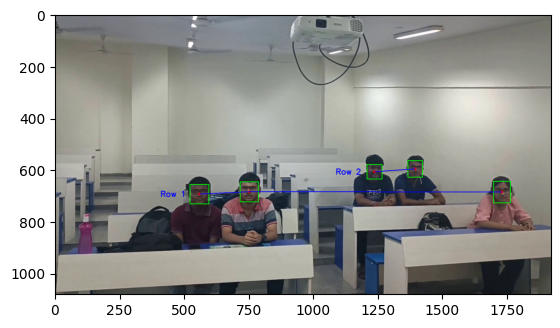

In [29]:
# Load the image
image_path = '/content/drive/MyDrive/SIH/images/grouping_test.jpg'
img = cv2.imread(image_path)

model = YOLO(face_model_path)

# Run prediction (assuming 'results' is already obtained from your YOLO model)
results = model.predict(source=image_path, save=False, conf=0.25)

# Access the results
boxes = results[0].boxes  # Bounding boxes

# Store face center points
centers = []

for box in boxes:
    # Extract bounding box coordinates
    x1, y1, x2, y2 = map(int, box.xyxy[0])  # xyxy format

    # Calculate the center point
    center_x = (x1 + x2) // 2
    center_y = (y1 + y2) // 2

    # Append the center points and bounding box
    centers.append((center_x, center_y, x1, y1, x2, y2))

    # Draw the bounding box (optional, for visualization)
    img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green box, 2px thickness

    # Draw the red point at the center of the bounding box
    img = cv2.circle(img, (center_x, center_y), radius=5, color=(0, 0, 255), thickness=-1)  # Red circle, filled

# Define a y-threshold for proximity
y_threshold = 20  # Adjust this threshold as needed

# Sort centers by their y-coordinate
centers = sorted(centers, key=lambda c: c[1])

# Group points by rows
rows = []
current_row = [centers[0]]

for i in range(1, len(centers)):
    if abs(centers[i][1] - current_row[-1][1]) <= y_threshold:
        current_row.append(centers[i])
    else:
        rows.append(current_row)
        current_row = [centers[i]]

# Add the last row
if current_row:
    rows.append(current_row)

# Reverse the rows so that row numbering starts from the bottom
rows = rows[::-1]

# Draw lines between adjacent center points within each row and label rows
for row_index, row in enumerate(rows):
    row_label = f"Row {row_index + 1}"

    # Find the leftmost point in the row
    leftmost_point = min(row, key=lambda p: p[0])  # Find the smallest x-coordinate

    # Draw the row label text near the leftmost point
    img = cv2.putText(img, row_label, (leftmost_point[0] - 150, leftmost_point[1] + 10),
                      cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)  # White text

    # Sort the row points by their x-coordinate
    sorted_row = sorted(row, key=lambda p: p[0])

    # Draw lines between adjacent points in the sorted row
    for i in range(len(sorted_row) - 1):
        # Draw line between adjacent points
        img = cv2.line(img, (sorted_row[i][0], sorted_row[i][1]), (sorted_row[i + 1][0], sorted_row[i + 1][1]), (255, 0, 0), 2)  # Blue line, 2px thickness

# Save or display the result
cv2.imwrite('output_image_with_row_labels.jpg', img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# Projector Status Detection

In [31]:
# Define progress reporting points
progress_list = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Load the YOLOv8 model
model = YOLO('/content/drive/MyDrive/SIH/models/projector_best.pt')

# Specify the path to the input video file
video_path = '/content/drive/MyDrive/SIH/videos/cb2.mp4'

# Initialize video capture from the file
cap = cv2.VideoCapture(video_path)

# Get the width and height of the video frames
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create a VideoWriter object to save the output video
output_video_path = 'projector_output.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, 30.0, (frame_width, frame_height))

# Calculate the total number of frames in the video
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Print video details
# print(f"Total Frames: {total_frames}")
# print(f"Frames Per Second (FPS): {fps}")

# Variables to track time and state
state = "OFF"

# Thresholds for brightness detection
brightness_threshold = 250

# Frame processing loop
frame_counter = 0
processed_frames = 0
on_frames = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Process every fps/2th frame
    if (frame_counter % (fps // 2)) != 0:
        frame_counter += 1
        continue

    # Use YOLO model to detect objects
    results = model(frame, verbose=False)

    # Process detected objects
    if len(results[0].boxes) > 0:
        box = results[0].boxes[0].xyxy[0].cpu().numpy()  # Get bounding box coordinates
        x1, y1, x2, y2 = map(int, box)

        # Extract the ROI based on the detected bounding box
        roi = frame[y1:y2, x1:x2]

        # Convert ROI to grayscale and apply Gaussian Blur
        gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        blurred_roi = cv2.GaussianBlur(gray_roi, (5, 5), 0)

        # Find the brightest spot in the ROI
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(blurred_roi)
        brightest_spot_intensity = max_val

        # Adjust max_loc to be relative to the full frame
        max_loc = (max_loc[0] + x1, max_loc[1] + y1)

        # Determine the projector state based on brightness
        if state == "OFF" and brightest_spot_intensity > brightness_threshold:
            state = "ON"
        elif state == "ON":
            on_frames += 1
            if brightest_spot_intensity <= brightness_threshold:
                state = "OFF"

        # Draw bounding boxes, circles, and text on the frame
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Bounding box
        cv2.circle(frame, max_loc, 10, (0, 255, 0), 2)  # Brightest spot
        cv2.putText(frame, f"Brightness: {int(brightest_spot_intensity)}", (10, 115),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 0), 3)
        cv2.putText(frame, state, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0) if state == "ON" else (0, 0, 255), 3, cv2.LINE_AA)

    # Update counters and write the frame
    processed_frames += 1
    frame_counter += 1

    # Print progress every 10%
    progress = (processed_frames / (total_frames // (fps // 2))) * 100
    if int(progress) in progress_list:
        print(f"Processed {int(progress)}% of the video.")
        progress_list.remove(int(progress))

    out.write(frame)

# Finalize and release resources
cap.release()
out.release()

clip = VideoFileClip(video_path)
print(f"Video Duration: {clip.duration:.2f} seconds")
total_on_time = (on_frames / processed_frames) * clip.duration
print(f"Total time the projector was ON: {total_on_time:.2f} seconds ({total_on_time/60:.2f} minutes)")

# Write the total ON and OFF durations to a CSV file
csv_output_path = 'projector_report.csv'
with open(csv_output_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['status', 'duration'])
    writer.writerow(['ON', total_on_time])
    writer.writerow(['OFF', clip.duration - total_on_time])

print(f"CSV file with total ON and OFF durations saved as {csv_output_path}")

Processed 0% of the video.
Processed 10% of the video.
Processed 20% of the video.
Processed 30% of the video.
Processed 40% of the video.
Processed 50% of the video.
Processed 60% of the video.
Processed 70% of the video.
Processed 80% of the video.
Processed 90% of the video.
Processed 100% of the video.
Video Duration: 96.11 seconds
Total time the projector was ON: 46.19 seconds (0.77 minutes)
CSV file with total ON and OFF durations saved as projector_report.csv


In [32]:
!cp /content/projector_output.mp4 /content/drive/MyDrive

#Fire Detection

In [35]:
# Load YOLOv8 model for detection
model = YOLO('/content/drive/MyDrive/SIH/models/fire.pt')

# Paths to input video and output directory
video_path = '/content/drive/MyDrive/SIH/videos/fire_video.mp4'
output_video_path = '/content/fire_output_video.mp4'

# Create output directory if it doesn't exist
os.makedirs(os.path.dirname(output_video_path), exist_ok=True)

# Open video input
cap = cv2.VideoCapture(video_path)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second of the video
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create a video writer object to save the output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 files
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

frame_count = 0  # Counter for frame numbers

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Run model on the frame
    results = model(frame)  # Run the model

    # Initialize fire detected flag
    fire_detected = False

    # Check if results contain any detections
    if results:
        for result in results:
            # Check if any boxes were detected
            if result.boxes.cls.size(0) > 0:
                # Get detected class names
                detected_classes = result.names

                # Draw bounding boxes around detected fires
                for i, box in enumerate(result.boxes.xyxy):
                    x1, y1, x2, y2 = map(int, box.tolist())
                    cls = int(result.boxes.cls[i].item())
                    label = detected_classes[cls]

                    # Draw a rectangle around the detected fire
                    if label == 'Fire Detected':
                        fire_detected = True
                        color = (0, 0, 255)  # Red color for bounding box
                        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                        cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # Write the frame (with or without bounding boxes) to the output video
    out.write(frame)

    frame_count += 1

cap.release()
out.release()
print('Video processing complete.')


0: 384x640 (no detections), 10.7ms
Speed: 1.3ms preprocess, 10.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 fire, 7.8ms
Speed: 1.5ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 fire, 7.6ms
Speed: 1.6ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 fire, 9.0ms
Speed: 1.3ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 fire, 7.1ms
Speed: 1.7ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 8.0ms
Speed: 1.5ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 fire, 8.0ms
Speed: 1.4ms preprocess, 8.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 

Video processing complete.


In [36]:
!cp /content/fire_output_video.mp4 /content/drive/MyDrive/